<a href="https://colab.research.google.com/github/xhsjs6231-boop/Final-Team1/blob/main/%EC%A0%9C%EC%B6%9C%EC%9A%A9_%ED%95%9C%EC%8A%B9%ED%97%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 2.0 MB/s eta 0:00:00


In [ ]:
#한글 글씨 폰트 설치
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

In [ ]:
import pandas as pd  #데이터 분석 라이브러리
import matplotlib.pyplot as plt # 시각화 도구 라이브러리

In [ ]:
path = '/content/weighted_score_above_08_cleaning.csv'

df = pd.read_csv(
    path,
    engine="python",
    on_bad_lines="skip"   # skip malformed rows
)



#얼리엑세스 무의미

In [ ]:
df = df[(df["author_num_games_owned"] != 0) &
        (df["author_playtime_forever"] != 0) ]

In [ ]:
df = df.drop(columns=["review"])

In [ ]:
df = df[~((df["author_num_games_owned"] == 0) & (df["author_playtime_at_review"] == 0))]


In [ ]:
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon
import numpy as np

# df: 원본 리뷰 단위 데이터
# 필요한 컬럼: appid, written_during_early_access(0/1), voted_up(0/1)

# 1) appid x EA여부별 긍정률/표본수
g = df.groupby(['appid', 'written_during_early_access'])['voted_up']
agg = g.agg(PosRate='mean', N='size').reset_index()

# 2) wide로 피벗 (0=Post, 1=EA)
wide = agg.pivot(index='appid',
                 columns='written_during_early_access',
                 values='PosRate')

# 컬럼명 정리 (피벗 열이 0,1 순서라는 가정)
wide.columns = ['Post_PosRate', 'EA_PosRate']  # 0 -> Post, 1 -> EA

# 3) EA와 Post가 모두 있고, 표본수 기준 충족하는 appid만 사용
cnt = agg.pivot(index='appid', columns='written_during_early_access', values='N')
cnt.columns = ['Post_N', 'EA_N']

paired = wide.dropna().join(cnt, how='left')
paired = paired[(paired['EA_N'] >= 30) & (paired['Post_N'] >= 30)]

print(f"쌍의 개수(게임 수): {len(paired)}")
print(paired.head())

# === 여기서부터 pos_rate 정의 및 개선/악화/동일 케이스 분류 ===
pos_rate = paired[['Post_PosRate', 'EA_PosRate', 'Post_N', 'EA_N']].copy()
pos_rate['Diff'] = pos_rate['Post_PosRate'] - pos_rate['EA_PosRate']

# 개선(EA < Post), 악화(EA > Post), 동일(EA == Post)
improved_games = pos_rate[pos_rate['EA_PosRate'] < pos_rate['Post_PosRate']].sort_values('Diff', ascending=False)
worsened_games = pos_rate[pos_rate['EA_PosRate'] > pos_rate['Post_PosRate']].sort_values('Diff', ascending=True)
tied_games = pos_rate[pos_rate['EA_PosRate'] == pos_rate['Post_PosRate']]

print("\n[개선된 게임 목록] EA_PosRate < Post_PosRate")
print(improved_games.to_string())

print("\n[악화된 게임 목록] EA_PosRate > Post_PosRate")
print(worsened_games.to_string())

print("\n[변화 없음] EA_PosRate == Post_PosRate")
print(tied_games.to_string())

# 4) 대응표본 t-검정
t_stat, p_val = ttest_rel(paired['EA_PosRate'], paired['Post_PosRate'], nan_policy='omit')
print(f"\n[Paired t-test] t={t_stat:.4f}, p={p_val:.3e}")

# 5) 비모수 대안: Wilcoxon signed-rank
# 차이가 전부 0이면 wilcoxon 에러 날 수 있으므로 방어
if (paired['EA_PosRate'] != paired['Post_PosRate']).any():
    w_stat, w_p = wilcoxon(paired['EA_PosRate'], paired['Post_PosRate'],
                           zero_method='wilcox', alternative='two-sided')
    print(f"[Wilcoxon] W={w_stat:.4f}, p={w_p:.3e}")
else:
    print("[Wilcoxon] 모든 쌍의 차이가 0이라 계산 불가")

# 6) 효과크기 (paired Cohen's d: dz = mean(diff)/sd(diff))
diff = paired['Post_PosRate'] - paired['EA_PosRate']
sd = diff.std(ddof=1)
dz = np.nan if sd == 0 else diff.mean() / sd
print(f"[Effect size] Cohen's dz = {dz:.3f}, mean diff = {diff.mean():.4f}")


쌍의 개수(게임 수): 30
        Post_PosRate  EA_PosRate  Post_N   EA_N
appid                                          
220200      0.938697    1.000000   261.0   30.0
221100      0.787162    0.488971   592.0  272.0
242760      0.991371    0.990000  1043.0  200.0
244850      0.777778    0.958333    72.0   72.0
246620      0.996610    1.000000   295.0   30.0

[개선된 게임 목록] EA_PosRate < Post_PosRate
         Post_PosRate  EA_PosRate  Post_N   EA_N      Diff
appid                                                     
221100       0.787162    0.488971   592.0  272.0  0.298192
301520       0.337838    0.186047   148.0   43.0  0.151791
1256670      1.000000    0.972973    68.0   37.0  0.027027
1086940      1.000000    0.991379   289.0  232.0  0.008621
1189490      0.974359    0.971831    39.0   71.0  0.002528
242760       0.991371    0.990000  1043.0  200.0  0.001371

[악화된 게임 목록] EA_PosRate > Post_PosRate
         Post_PosRate  EA_PosRate  Post_N   EA_N      Diff
appid                                  

#지역별

In [ ]:
import pandas as pd

# 1. 무료 제공 제외 (실제 구매만 분석할 경우)
df_paid = df[df["received_for_free"] == False]

# 2. 지역(언어권)별 집계
region_stats = df_paid.groupby("language").agg(
    PosRate=("voted_up", "mean"),
    ReviewCount=("voted_up", "count"),
    AvgPlaytime=("author_playtime_forever", "mean"),
    MedianPlaytime=("author_playtime_forever", "median"),
    PurchaseRate=("steam_purchase", "mean")
).reset_index()

# 3. 리뷰 카운트 100 이상만 필터링
region_stats = region_stats[region_stats["ReviewCount"] >= 100]

# 4. 긍정률 높은 순으로 정렬
region_stats = region_stats.sort_values(by="PosRate", ascending=False)

print(region_stats.head(10))


     language   PosRate  ReviewCount   AvgPlaytime  MedianPlaytime  \
11    italian  0.915612          474  10416.561181          1353.5   
10  hungarian  0.915033          153  22347.934641          3917.0   
21    spanish  0.907680         5091   9117.368101          1419.0   
16     polish  0.904101         1658  15530.595899          2352.0   
2       czech  0.899598          249  13035.365462          3067.0   
14      latam  0.890909          605   8878.561983          1733.0   
19    russian  0.890683        17527  13150.242997          1408.0   
12   japanese  0.881214         1549  19787.683667          1331.0   
24       thai  0.872951          244  31402.131148          2316.5   
20   schinese  0.870282        54526  10983.851814           971.0   

    PurchaseRate  
11      0.436709  
10      0.601307  
21      0.640149  
16      0.606152  
2       0.642570  
14      0.694215  
19      0.684373  
12      0.759199  
24      0.721311  
20      0.714613  


PosRate vs AvgPlaytime: r=-0.081, p=0.748
PosRate vs PurchaseRate: r=-0.277, p=0.266
                            OLS Regression Results                            
Dep. Variable:           PurchaseRate   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.329
Date:                Tue, 23 Sep 2025   Prob (F-statistic):              0.266
Time:                        00:08:23   Log-Likelihood:                 21.749
No. Observations:                  18   AIC:                            -39.50
Df Residuals:                      16   BIC:                            -37.72
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

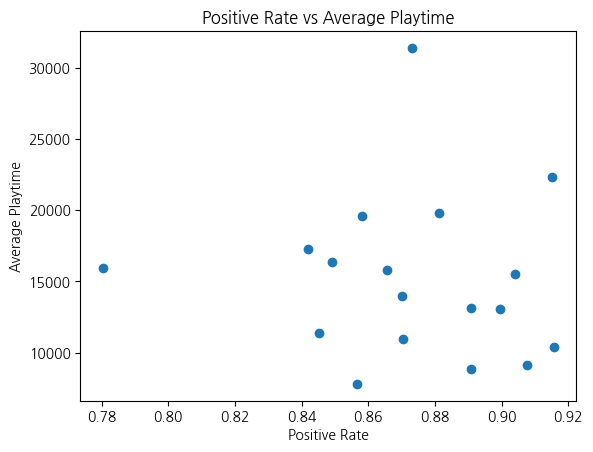

In [ ]:
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. 상관분석
corr_play, p_play = stats.pearsonr(region_stats["PosRate"], region_stats["AvgPlaytime"])
corr_purchase, p_purchase = stats.pearsonr(region_stats["PosRate"], region_stats["PurchaseRate"])

print(f"PosRate vs AvgPlaytime: r={corr_play:.3f}, p={p_play:.3f}")
print(f"PosRate vs PurchaseRate: r={corr_purchase:.3f}, p={p_purchase:.3f}")

# 2. 회귀분석 (구매율 ~ 긍정률)
X = sm.add_constant(region_stats["PosRate"])
y = region_stats["PurchaseRate"]
model = sm.OLS(y, X).fit()
print(model.summary())

# 3. 시각화 (긍정률 vs 플레이타임)
plt.scatter(region_stats["PosRate"], region_stats["AvgPlaytime"])
plt.xlabel("Positive Rate")
plt.ylabel("Average Playtime")
plt.title("Positive Rate vs Average Playtime")
plt.show()


#2. 소비자 유형별 평가 차이
author_num_games_owned, author_num_reviews → 코어 게이머 vs 라이트 유저 분류 가설: 보유 게임 수가 많은 게이머는 더 까다롭게 평가, 리뷰 수가 많은 유저는 극단적 의견 경

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf  # 사용은 안 하지만 기존 호환을 위해 남김
from sklearn.metrics import roc_auc_score, brier_score_loss

# -----------------------------
# 0) dtype 다운캐스팅 & 전처리
# -----------------------------
# 요청 컬럼 중 실제 df에 존재하는 것만 선택 (존재하지 않는 컬럼은 자동 제외)
requested_cols = [
    'recommendationid','appid','game','author_steamid',
    'author_num_games_owned','author_num_reviews',
    'author_playtime_forever','author_playtime_at_review',
    'language','timestamp_created','voted_up','steam_purchase',
    'received_for_free','written_during_early_access',
    'hidden_in_steam_china','steam_china_location'  # 없어도 에러 안 나게 함
]
cols_existing = [c for c in requested_cols if c in df.columns]
df_use = df[cols_existing].copy()

# dtypes (존재하는 경우에만 적용)
for c in ['recommendationid','appid','author_steamid']:
    if c in df_use.columns:
        df_use[c] = pd.to_numeric(df_use[c], errors='coerce', downcast='integer')

for c in ['author_num_games_owned','author_num_reviews']:
    if c in df_use.columns:
        df_use[c] = pd.to_numeric(df_use[c], errors='coerce', downcast='integer')

for c in ['author_playtime_forever','author_playtime_at_review']:
    if c in df_use.columns:
        df_use[c] = pd.to_numeric(df_use[c], errors='coerce', downcast='float')

bin_cols = ['voted_up','steam_purchase','received_for_free','written_during_early_access']
for c in bin_cols:
    if c in df_use.columns:
        df_use[c] = pd.to_numeric(df_use[c], errors='coerce').fillna(0).astype('int8')

# 범주형 (존재하는 경우에만)
for c in ['language','game','steam_china_location']:
    if c in df_use.columns:
        df_use[c] = df_use[c].astype('category')

# 핵심 결측 제거 (존재하는 경우만 조건 부여)
subset_cols = [c for c in ['author_num_games_owned','author_num_reviews','voted_up'] if c in df_use.columns]
if subset_cols:
    df_use = df_use.dropna(subset=subset_cols)

# 윈저라이즈(상하위 1%) - 존재하는 컬럼에만 적용
for c in ['author_num_games_owned','author_num_reviews','author_playtime_forever','author_playtime_at_review']:
    if c in df_use.columns and df_use[c].notna().sum() > 0:
        lo, hi = df_use[c].quantile([0.01, 0.99])
        df_use[c] = df_use[c].clip(lo, hi)

# -----------------------------
# 1) 코어/라이트 & 리뷰어 구간 라벨 (벡터화)
# -----------------------------
# 필요한 컬럼 존재 확인
required_for_seg = ['author_num_games_owned','author_num_reviews']
if not all(col in df_use.columns for col in required_for_seg):
    raise ValueError(f"세그먼트 생성에 필요한 컬럼 누락: {required_for_seg} 중 일부 없음")

q25_games = df_use['author_num_games_owned'].quantile(0.25)
q75_games = df_use['author_num_games_owned'].quantile(0.75)
q25_revs  = df_use['author_num_reviews'].quantile(0.25)
q75_revs  = df_use['author_num_reviews'].quantile(0.75)

core_gamer   = (df_use['author_num_games_owned'] >= q75_games).astype('int8')
light_user   = (df_use['author_num_games_owned'] <= q25_games).astype('int8')
heavy_rev    = (df_use['author_num_reviews'] >= q75_revs).astype('int8')
light_rev    = (df_use['author_num_reviews'] <= q25_revs).astype('int8')

df_use['core_gamer']      = core_gamer
df_use['heavy_reviewer']  = heavy_rev

df_use['segment'] = pd.Categorical(
    np.select(
        [
            (core_gamer.eq(1) & heavy_rev.eq(1)),
            (core_gamer.eq(1) & light_rev.eq(1)),
            (light_user.eq(1) & heavy_rev.eq(1)),
            (light_user.eq(1) & light_rev.eq(1)),
        ],
        ['Core × Heavy','Core × Light','Light × Heavy','Light × Light'],
        default='Middle'
    )
)

# -----------------------------
# 2) 그룹 통계 (가벼운 출력만)
# -----------------------------
if 'voted_up' not in df_use.columns:
    raise ValueError("voted_up 컬럼이 필요합니다.")

grp = df_use.groupby('segment', observed=True)['voted_up']
summary = pd.DataFrame({
    'n': grp.size(),
    'pos_rate': grp.mean(),
})
summary['se'] = np.sqrt(summary['pos_rate']*(1-summary['pos_rate'])/summary['n'].clip(lower=1))
summary['ci_low'] = summary['pos_rate'] - 1.96*summary['se']
summary['ci_high'] = summary['pos_rate'] + 1.96*summary['se']
print("\n[그룹별 긍정률/CI]")
print(summary.sort_index())

# -----------------------------
# 3) 두 비율 z-검정 (코어 vs 라이트 극단)
# -----------------------------
extreme = df_use[(core_gamer==1) | (light_user==1)]
core = extreme[core_gamer.loc[extreme.index]==1]['voted_up'].astype('int8')
light = extreme[core_gamer.loc[extreme.index]==0]['voted_up'].astype('int8')

def prop_ztest(success_a, size_a, success_b, size_b):
    # 방어: 0분모/0표본 방지
    if size_a == 0 or size_b == 0:
        return np.nan, np.nan
    p_pool = (success_a + success_b) / (size_a + size_b)
    se = np.sqrt(max(1e-12, p_pool*(1-p_pool)*(1/size_a + 1/size_b)))
    z = ((success_a/size_a) - (success_b/size_b)) / se
    p = 2*(1 - stats.norm.cdf(abs(z)))
    return z, p

z, p = prop_ztest(core.sum(), core.size, light.sum(), light.size)
print(f"\n[비율 z-test] 코어 vs 라이트: z={z:.3f}, p={p:.5f}")

# -----------------------------
# 4) 로지스틱: GEE Binomial (게임 그룹화)
# -----------------------------
# 언어 열이 없으면 임시 Other 로 생성
if 'language' not in df_use.columns:
    df_use['language'] = pd.Categorical(['Other']*len(df_use))

K = 10
top_lang = df_use['language'].value_counts().head(K).index

# pandas where 사용 → dtype 안정
df_use['lang_top'] = df_use['language'].astype('string').where(
    df_use['language'].isin(top_lang),
    other='Other'
)

# 카테고리로 변환 (명시적 카테고리 세트 지정)
cats = list(pd.Index(top_lang).astype('string')) + ['Other']
df_use['lang_top'] = pd.Categorical(df_use['lang_top'], categories=cats, ordered=False)

# GEE 포뮬러
gee_formula = (
    "voted_up ~ core_gamer + heavy_reviewer + core_gamer:heavy_reviewer"
    " + author_playtime_at_review + received_for_free + steam_purchase"
    " + written_during_early_access + C(lang_top)"
)

# 필수 컬럼 체크
needed_for_gee = ['appid','voted_up','core_gamer','heavy_reviewer','author_playtime_at_review',
                  'received_for_free','steam_purchase','written_during_early_access','lang_top']
missing_for_gee = [c for c in needed_for_gee if c not in df_use.columns]
if missing_for_gee:
    raise ValueError(f"GEE에 필요한 컬럼 누락: {missing_for_gee}")

# 그룹(게임) 다양성 체크 (GEE는 최소 2개 그룹 필요)
n_groups = df_use['appid'].nunique()
if n_groups < 2:
    raise ValueError(f"GEE 실행 불가: appid 그룹 수가 {n_groups}개입니다. 최소 2개 이상 필요")

fam = sm.families.Binomial()
ind = sm.cov_struct.Exchangeable()

# 권장: from_formula 사용 + groups="appid" (문자열로 컬럼 지정)
gee_model = sm.GEE.from_formula(gee_formula, groups="appid", data=df_use,
                                family=fam, cov_struct=ind)
gee_res = gee_model.fit()
print("\n[GEE 결과 요약]")
print(gee_res.summary())

# 오즈비 표
par = gee_res.params
conf = gee_res.conf_int()
or_tab = pd.DataFrame({
    'OR': np.exp(par),
    'CI_low': np.exp(conf[0]),
    'CI_high': np.exp(conf[1]),
    'pvalue': gee_res.pvalues
}).sort_values('pvalue')
print("\n[중요 계수 OR표 (상위 20)]")
print(or_tab.head(20))

# -----------------------------
# 5) 간단 성능(의사확률)
# -----------------------------
pred_prob = gee_res.predict(df_use)  # GEE도 확률 제공
y_true = df_use['voted_up'].astype(int)

# 방어: y_true가 한 클래스만 있으면 AUC 계산 불가
if y_true.nunique() < 2:
    auc = np.nan
else:
    auc = roc_auc_score(y_true, pred_prob)

brier = brier_score_loss(y_true, pred_prob)
auc_str = "nan" if np.isnan(auc) else f"{auc:.3f}"
print(f"\n[모델 성능] AUC={auc_str}, Brier={brier:.4f}")


# 캘리브레이션(10분위) - 메모리 가볍게
p = pd.Series(pred_prob, index=df_use.index)
# 중복값이 매우 많아도 안전한 rank→decile 방식
rank = p.rank(method='first')
den = max(1, len(p))
decile = ((rank - 1) / den * 10).astype(int).clip(0,9)
cal = pd.DataFrame({'y': y_true, 'p': p, 'decile': decile})
cal_out = cal.groupby('decile', observed=True).agg(mean_p=('p','mean'), obs_rate=('y','mean'), n=('y','size'))
print("\n[캘리브레이션: 예측확률 vs 실측율(10분위)]")
print(cal_out)



[그룹별 긍정률/CI]
                    n  pos_rate        se    ci_low   ci_high
segment                                                      
Core × Heavy    24066  0.872891  0.002147  0.868683  0.877100
Core × Light     2059  0.828558  0.008306  0.812278  0.844837
Light × Heavy     695  0.910791  0.010812  0.889599  0.931984
Light × Light   23756  0.856457  0.002275  0.851999  0.860916
Middle         107462  0.862975  0.001049  0.860919  0.865031

[비율 z-test] 코어 vs 라이트: z=-5.713, p=0.00000

[GEE 결과 요약]
                               GEE Regression Results                              
Dep. Variable:                    voted_up   No. Observations:               158038
Model:                                 GEE   No. clusters:                    10170
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                1318
Family:                           Binomial   Mean cluster size:            

###코어게이머의 언어별

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np, pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import roc_auc_score, brier_score_loss

# ===== 파라미터 =====
clip_pct = 0.05          # 극단값 완화: 상하위 5%
top_k_lang = 5           # 언어 상위 K만 더미화, 나머지 Other
subsample_n = None       # e.g., 200_000 (메모리 압박 심할 때만)

# ===== 입력 =====
cols = [
    'game','author_steamid','language','voted_up',
    'author_num_games_owned','author_num_reviews',
    'author_playtime_at_review','received_for_free',
    'steam_purchase','written_during_early_access'
]
df_use = df[cols].dropna().copy()

# 타입/바이너리 정리
df_use['voted_up'] = df_use['voted_up'].astype(int)
for c in ['received_for_free','steam_purchase','written_during_early_access']:
    if c in df_use: df_use[c] = df_use[c].astype(int)

# 극단값 완화 (상하위 clip_pct)
for c in ['author_num_games_owned','author_num_reviews','author_playtime_at_review']:
    lo, hi = df_use[c].quantile([clip_pct, 1-clip_pct])
    df_use[c] = df_use[c].clip(lo, hi)

# 코어/헤비 라벨 (상위 사분위)
q75_games = df_use['author_num_games_owned'].quantile(0.75)
q75_revs  = df_use['author_num_reviews'].quantile(0.75)
df_use['core_gamer']     = (df_use['author_num_games_owned'] >= q75_games).astype(int)
df_use['heavy_reviewer'] = (df_use['author_num_reviews']   >= q75_revs ).astype(int)

# 언어 상위 K만 유지
top_lang = df_use['language'].value_counts().head(top_k_lang).index
df_use['lang_top'] = np.where(df_use['language'].isin(top_lang), df_use['language'], 'Other')

# 메모리 절감: 필요한 열만, 다운캐스트
df_use = df_use[['voted_up','core_gamer','heavy_reviewer','author_playtime_at_review',
                 'received_for_free','steam_purchase','written_during_early_access','lang_top']].copy()
for c in ['core_gamer','heavy_reviewer','received_for_free','steam_purchase','written_during_early_access']:
    df_use[c] = df_use[c].astype('int8')
df_use['author_playtime_at_review'] = pd.to_numeric(df_use['author_playtime_at_review'], downcast='float')
df_use['lang_top'] = df_use['lang_top'].astype('category')

# (선택) 다운샘플링(라벨 보존)
if subsample_n is not None and len(df_use) > subsample_n:
    df_pos = df_use[df_use['voted_up']==1].sample(subsample_n//2, random_state=42, replace=False)
    df_neg = df_use[df_use['voted_up']==0].sample(subsample_n - len(df_pos), random_state=42, replace=False)
    df_use = pd.concat([df_pos, df_neg], axis=0).sample(frac=1.0, random_state=42)

# 로지스틱 (게임 FE 제거 → 빠름)
formula = (
    "voted_up ~ core_gamer + heavy_reviewer + core_gamer:heavy_reviewer"
    " + author_playtime_at_review + received_for_free + steam_purchase"
    " + written_during_early_access + C(lang_top)"
)
model = smf.logit(formula=formula, data=df_use).fit(disp=False)
res = model  # 강건SE 없이도 경량화; 필요 시 get_robustcov_results 사용

# 성능/보정
pred = res.predict()
auc = roc_auc_score(df_use['voted_up'], pred)
brier = brier_score_loss(df_use['voted_up'], pred)

# OR 테이블
params = res.params; conf = res.conf_int()
or_table = pd.DataFrame({
    'OR': np.exp(params),
    'CI_low': np.exp(conf[0]),
    'CI_high': np.exp(conf[1]),
    'pvalue': res.pvalues
}).sort_values('pvalue')

print("\n[요약]")
print(res.summary())
print("\n[AUC, Brier]", round(auc,3), round(brier,4))
print("\n[OR 상위 15]")
print(or_table.head(15))



[요약]
                           Logit Regression Results                           
Dep. Variable:               voted_up   No. Observations:               158023
Model:                          Logit   Df Residuals:                   158010
Method:                           MLE   Df Model:                           12
Date:                Tue, 23 Sep 2025   Pseudo R-squ.:                 0.01011
Time:                        00:09:23   Log-Likelihood:                -62403.
converged:                       True   LL-Null:                       -63040.
Covariance Type:            nonrobust   LLR p-value:                1.850e-265
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       1.6569      0.025     65.417      0.000       1.607       1.707
C(lang_top)[T.brazilian]       -0.0529      0.046     -1.141      0.254   

#3. 구매 여부와 평가 태도
steam_purchase, received_for_free → 구매/무료 배포 여부에 따른 긍정률 차이 가설: 무료로 받은 유저는 호의적이거나(“공짜니까 좋다”), 또는 부정적(“돈 내고 살 가치는 없다”) 양극화 가능

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 필요한 컬럼만
cols = [
    'voted_up','steam_purchase','received_for_free',
    'author_playtime_at_review','author_num_games_owned','author_num_reviews',
    'language','written_during_early_access'
]
dfu = df[cols].copy()

# 유효값만 (라벨/핵심변수 결측 제거)
dfu = dfu.dropna(subset=['voted_up','steam_purchase','received_for_free']).copy()

# 타입 정리
dfu['voted_up'] = dfu['voted_up'].astype(int)
dfu['steam_purchase'] = dfu['steam_purchase'].astype(int)
dfu['received_for_free'] = dfu['received_for_free'].astype(int)

# 선택: 극단치 완화(플레이시간 로그 + 상한 Winsorize 99%)
if 'author_playtime_at_review' in dfu:
    p99 = dfu['author_playtime_at_review'].quantile(0.99)
    dfu['playtime_capped'] = np.minimum(dfu['author_playtime_at_review'], p99)
    dfu['log_playtime'] = np.log1p(dfu['playtime_capped'])
else:
    dfu['log_playtime'] = 0.0

# 언어 Top-k만 더미화(희소성/메모리 절약)
k = 10
top_langs = dfu['language'].value_counts().nlargest(k).index
dfu['lang_top'] = np.where(dfu['language'].isin(top_langs), dfu['language'], 'OTHER')


In [ ]:
# (A) 각 단일 변수 기준
tab_purchase = dfu.groupby('steam_purchase')['voted_up'].agg(['mean','count']).rename(columns={'mean':'PosRate','count':'N'})
tab_free = dfu.groupby('received_for_free')['voted_up'].agg(['mean','count']).rename(columns={'mean':'PosRate','count':'N'})

# (B) 교차조건(유료/무료 조합)
tab_cross = (dfu
    .groupby(['steam_purchase','received_for_free'])['voted_up']
    .agg(['mean','count'])
    .rename(columns={'mean':'PosRate','count':'N'})
    .reset_index()
)

print("== steam_purchase by PosRate ==")
print(tab_purchase.round(4))
print("\n== received_for_free by PosRate ==")
print(tab_free.round(4))
print("\n== Cross (steam_purchase x received_for_free) ==")
print(tab_cross.round(4))


== steam_purchase by PosRate ==
                PosRate       N
steam_purchase                 
0                0.8338   53140
1                0.8782  104898

== received_for_free by PosRate ==
                   PosRate       N
received_for_free                 
0                   0.8627  152093
1                   0.8789    5945

== Cross (steam_purchase x received_for_free) ==
   steam_purchase  received_for_free  PosRate       N
0               0                  0   0.8303   48139
1               0                  1   0.8676    5001
2               1                  0   0.8777  103954
3               1                  1   0.9386     944


In [ ]:
def chisq_and_cramers_v(df_sub, col):
    ct = pd.crosstab(df_sub[col], df_sub['voted_up'])
    chi2, p, dof, _ = stats.chi2_contingency(ct)
    n = ct.values.sum()
    # Cramér's V
    phi2 = chi2 / n
    r, c = ct.shape
    v = np.sqrt(phi2 / (min(r-1, c-1)))
    return ct, chi2, dof, p, v

for col in ['steam_purchase','received_for_free']:
    ct, chi2, dof, p, v = chisq_and_cramers_v(dfu, col)
    print(f"\n== Chi-square for {col} ==")
    print(ct)
    print(f"chi2={chi2:.3f}, dof={dof}, p={p:.4g}, CramersV={v:.3f}")



== Chi-square for steam_purchase ==
voted_up            0      1
steam_purchase              
0                8833  44307
1               12776  92122
chi2=589.416, dof=1, p=3.357e-130, CramersV=0.061

== Chi-square for received_for_free ==
voted_up               0       1
received_for_free               
0                  20889  131204
1                    720    5225
chi2=12.636, dof=1, p=0.0003784, CramersV=0.009


In [ ]:
from math import sqrt

def two_prop_ztest(success1, n1, success2, n2):
    p1 = success1 / n1
    p2 = success2 / n2
    p_pool = (success1 + success2) / (n1 + n2)
    se = sqrt(p_pool*(1-p_pool)*(1/n1 + 1/n2))
    z = (p1 - p2) / se
    p = 2*(1 - stats.norm.cdf(abs(z)))
    return p1, p2, z, p

def wilson_ci(success, n, alpha=0.05):
    if n == 0:
        return (np.nan, np.nan, np.nan)
    p = success / n
    z = stats.norm.ppf(1 - alpha/2)
    denom = 1 + z**2/n
    center = (p + z**2/(2*n)) / denom
    half = (z*np.sqrt((p*(1-p)/n) + z**2/(4*n**2))) / denom
    return p, (center - half), (center + half)

# (A) steam_purchase: 1 vs 0
g1 = dfu[dfu['steam_purchase']==1]['voted_up']
g0 = dfu[dfu['steam_purchase']==0]['voted_up']
p1, p0, z, p = two_prop_ztest(g1.sum(), g1.size, g0.sum(), g0.size)
print("\n== Two-proportion z-test: steam_purchase (1 vs 0) ==")
print(f"PosRate(1)={p1:.4f}, PosRate(0)={p0:.4f}, z={z:.3f}, p={p:.4g}")
print("Wilson 95% CI:")
print("  1:", wilson_ci(g1.sum(), g1.size))
print("  0:", wilson_ci(g0.sum(), g0.size))

# (B) received_for_free: 1 vs 0
g1 = dfu[dfu['received_for_free']==1]['voted_up']
g0 = dfu[dfu['received_for_free']==0]['voted_up']
p1, p0, z, p = two_prop_ztest(g1.sum(), g1.size, g0.sum(), g0.size)
print("\n== Two-proportion z-test: received_for_free (1 vs 0) ==")
print(f"PosRate(1)={p1:.4f}, PosRate(0)={p0:.4f}, z={z:.3f}, p={p:.4g}")
print("Wilson 95% CI:")
print("  1:", wilson_ci(g1.sum(), g1.size))
print("  0:", wilson_ci(g0.sum(), g0.size))



== Two-proportion z-test: steam_purchase (1 vs 0) ==
PosRate(1)=0.8782, PosRate(0)=0.8338, z=24.286, p=0
Wilson 95% CI:
  1: (np.float64(0.8782054948616752), np.float64(0.876212493408989), np.float64(0.8801707968800319))
  0: (np.float64(0.8337786977794505), np.float64(0.8305893576181678), np.float64(0.8369197841040683))

== Two-proportion z-test: received_for_free (1 vs 0) ==
PosRate(1)=0.8789, PosRate(0)=0.8627, z=3.574, p=0.0003516
Wilson 95% CI:
  1: (np.float64(0.8788898233809924), np.float64(0.8703508799861102), np.float64(0.886939431276123))
  0: (np.float64(0.8626564010177983), np.float64(0.8609173565875935), np.float64(0.8643771264662646))


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# --- 0) 안전 가드: 필요한 수치컬럼 생성/정리 ---
# log_playtime (at_review 기준; 없으면 forever로 대체)
if 'log_playtime' not in dfu.columns:
    base_play = 'author_playtime_at_review' if 'author_playtime_at_review' in dfu.columns else 'author_playtime_forever'
    dfu['log_playtime'] = np.log1p(pd.to_numeric(dfu[base_play], errors='coerce').fillna(0))

# lang_top (상위 K개 + Other)
if 'lang_top' not in dfu.columns:
    K = 10
    lang = dfu['language'].astype('string') if 'language' in dfu.columns else pd.Series(['Other']*len(dfu), index=dfu.index, dtype='string')
    topK = lang.value_counts().head(K).index
    dfu['lang_top'] = lang.where(lang.isin(topK), other='Other').astype('category')

# 보조 지표
dfu['ea'] = dfu['written_during_early_access'].fillna(0).astype(int)
dfu['log_reviews'] = np.log1p(pd.to_numeric(dfu['author_num_reviews'], errors='coerce').fillna(0))
dfu['log_owned']   = np.log1p(pd.to_numeric(dfu['author_num_games_owned'], errors='coerce').fillna(0))

# --- 1) m0: 그대로 유지 (이미 정상) ---
m0 = smf.logit("voted_up ~ steam_purchase + received_for_free", data=dfu).fit(disp=False)
print("\n== Logit m0 ==")
print(m0.summary())

or_m0 = np.exp(m0.params)
ci_m0 = np.exp(m0.conf_int())
print("\nOR (95% CI) - m0")
print(pd.concat([or_m0.rename('OR'), ci_m0.rename(columns={0:'LCI',1:'UCI'})], axis=1))

# --- 2) m1: X를 전부 수치화 + 결측/상수열 제거 ---
lang_dummies = pd.get_dummies(dfu['lang_top'], prefix='lang', drop_first=True, dtype=float)

X = pd.concat([
    pd.DataFrame({
        'steam_purchase': pd.to_numeric(dfu['steam_purchase'], errors='coerce'),
        'received_for_free': pd.to_numeric(dfu['received_for_free'], errors='coerce'),
        'log_playtime': pd.to_numeric(dfu['log_playtime'], errors='coerce'),
        'log_reviews': pd.to_numeric(dfu['log_reviews'], errors='coerce'),
        'log_owned':   pd.to_numeric(dfu['log_owned'], errors='coerce'),
        'ea':          pd.to_numeric(dfu['ea'], errors='coerce'),
    }),
    lang_dummies
], axis=1)

# 결측 제거
y = pd.to_numeric(dfu['voted_up'], errors='coerce')
data_m1 = pd.concat([y.rename('y'), X], axis=1).dropna(axis=0)

# 상수열(분산 0) 제거
const_cols = [c for c in data_m1.columns if c != 'y' and data_m1[c].nunique() <= 1]
if const_cols:
    data_m1 = data_m1.drop(columns=const_cols)

# 최종 설계행렬/타깃 (float로 강제)
y_m1 = data_m1['y'].astype(float)
X_m1 = data_m1.drop(columns=['y']).astype(float)
X_m1 = sm.add_constant(X_m1, has_constant='add')

m1 = sm.Logit(y_m1, X_m1).fit(disp=False)
print("\n== Logit m1 (controls) ==")
print(m1.summary())

or_m1 = np.exp(m1.params)
ci_m1 = np.exp(m1.conf_int())
print("\nOR (95% CI) - m1")
print(pd.concat([or_m1.rename('OR'), ci_m1.rename(columns={0:'LCI',1:'UCI'})], axis=1))

# --- 3) m2: formula 버전 (C(lang_top)) + 결측 제거해 안전 실행 ---
needed = ['voted_up','steam_purchase','received_for_free','log_playtime',
          'log_reviews','log_owned','ea','lang_top']
df_m2 = dfu[needed].copy()
df_m2[['voted_up','steam_purchase','received_for_free','log_playtime','log_reviews','log_owned','ea']] = (
    df_m2[['voted_up','steam_purchase','received_for_free','log_playtime','log_reviews','log_owned','ea']].apply(
        pd.to_numeric, errors='coerce')
)
df_m2['lang_top'] = df_m2['lang_top'].astype('category')
df_m2 = df_m2.dropna(axis=0)

m2 = smf.logit(
    "voted_up ~ steam_purchase * received_for_free + log_playtime + log_reviews + log_owned + ea + C(lang_top)",
    data=df_m2
).fit(disp=False)

print("\n== Logit m2 (interaction) ==")
print(m2.summary())

print("\nOR (95% CI) - m2 (주요항)")
main_terms = ['steam_purchase','received_for_free','steam_purchase:received_for_free']
or_m2 = np.exp(m2.params[main_terms])
ci_m2 = np.exp(m2.conf_int().loc[main_terms])
print(pd.concat([or_m2.rename('OR'), ci_m2.rename(columns={0:'LCI',1:'UCI'})], axis=1))



== Logit m0 ==
                           Logit Regression Results                           
Dep. Variable:               voted_up   No. Observations:               158038
Model:                          Logit   Df Residuals:                   158035
Method:                           MLE   Df Model:                            2
Date:                Tue, 23 Sep 2025   Pseudo R-squ.:                0.005154
Time:                        00:09:24   Log-Likelihood:                -62730.
converged:                       True   LL-Null:                       -63055.
Covariance Type:            nonrobust   LLR p-value:                7.291e-142
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.5836      0.012    131.244      0.000       1.560       1.607
steam_purchase        0.3893      0.015     25.500      0.000       0.359       0.419
received

In [ ]:
# (A) 성향점수: "무료 수령 여부"를 종속변수로 예측
ps_formula = "received_for_free ~ log_playtime + log_reviews + log_owned + ea + C(lang_top)"
ps_mod = smf.logit(ps_formula, data=dfu).fit(disp=False)
dfu['ps'] = ps_mod.predict(dfu)

# 안정화된 IPW (stabilized weights)
p_treat = dfu['received_for_free'].mean()
dfu['sw'] = np.where(dfu['received_for_free']==1, p_treat/dfu['ps'], (1-p_treat)/(1-dfu['ps']))

# (B) 가중 로짓: 무료 효과의 강건성
ipw_mod = smf.glm(
    formula="voted_up ~ received_for_free + steam_purchase + log_playtime + log_reviews + log_owned + ea + C(lang_top)",
    data=dfu,
    family=sm.families.Binomial(),
    freq_weights=dfu['sw']
).fit()

print("\n== IPW-GLM (Binomial) ==")
print(ipw_mod.summary())

# OR와 CI
params = ipw_mod.params
cov = ipw_mod.cov_params()
se = np.sqrt(np.diag(cov))
z = stats.norm.ppf(0.975)
or_ipw = np.exp(params)
lci = np.exp(params - z*se)
uci = np.exp(params + z*se)
or_table = pd.DataFrame({'OR':or_ipw, 'LCI':lci, 'UCI':uci})
print("\nOR (95% CI) - IPW")
print(or_table.loc[['received_for_free','steam_purchase']])



== IPW-GLM (Binomial) ==
                 Generalized Linear Model Regression Results                  
Dep. Variable:               voted_up   No. Observations:               158038
Model:                            GLM   Df Residuals:                158186.04
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -61831.
Date:                Tue, 23 Sep 2025   Deviance:                   1.2366e+05
Time:                        00:09:31   Pearson chi2:                 1.58e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01560
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [ ]:
def binvar_polarization(y):
    p = y.mean()
    var = p*(1-p)
    # 이진 엔트로피 (log2)
    eps = 1e-12
    ent = -(p*np.log2(p+eps) + (1-p)*np.log2(1-p+eps))
    return p, var, ent

for col in ['steam_purchase','received_for_free']:
    print(f"\n== Polarization metrics by {col} ==")
    for v in [0,1]:
        y = dfu.loc[dfu[col]==v, 'voted_up']
        p,var,ent = binvar_polarization(y)
        print(f"{col}={v}: PosRate={p:.4f}, Var={var:.4f}, Entropy={ent:.4f}")



== Polarization metrics by steam_purchase ==
steam_purchase=0: PosRate=0.8338, Var=0.1386, Entropy=0.6490
steam_purchase=1: PosRate=0.8782, Var=0.1070, Entropy=0.5345

== Polarization metrics by received_for_free ==
received_for_free=0: PosRate=0.8627, Var=0.1185, Entropy=0.5772
received_for_free=1: PosRate=0.8789, Var=0.1064, Entropy=0.5325


#6. 리뷰 업데이트 가설

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

# --------------------------------
# 0. 전처리
# --------------------------------
df_use = df[["timestamp_created", "timestamp_updated", "voted_up"]].copy()

# 업데이트 여부 플래그
df_use["updated_flag"] = (df_use["timestamp_updated"] > df_use["timestamp_created"]).astype(int)

# NA 제거
df_use = df_use.dropna(subset=["timestamp_created", "timestamp_updated", "voted_up"])

# --------------------------------
# 1. 집단별 긍정률 비교
# --------------------------------
group_stats = df_use.groupby("updated_flag")["voted_up"].agg(["mean", "count", "sum"])
print("== 긍정률 비교 (업데이트 여부) ==")
print(group_stats)

# 카이제곱 검정 (2x2 교차표)
ct = pd.crosstab(df_use["updated_flag"], df_use["voted_up"])
chi2, p, dof, expected = stats.chi2_contingency(ct)
print("\n== Chi-square 검정 ==")
print("Chi2=%.4f, p=%.4f" % (chi2, p))

# t-검정 (집단별 비율 비교)
updated_pos = df_use.loc[df_use["updated_flag"]==1, "voted_up"]
not_updated_pos = df_use.loc[df_use["updated_flag"]==0, "voted_up"]
t, pval = stats.ttest_ind(updated_pos, not_updated_pos, equal_var=False)
print("\n== T-test ==")
print("t=%.4f, p=%.4f" % (t, pval))

# --------------------------------
# 2. 로지스틱 회귀 (설명력 확인)
# --------------------------------
X = sm.add_constant(df_use["updated_flag"])
y = df_use["voted_up"]

model = sm.Logit(y, X)
result = model.fit(disp=False)

print("\n== 로지스틱 회귀 결과 ==")
print(result.summary())

# 설명력 (Pseudo R²)
print("Pseudo R-squared: %.4f" % result.prsquared)


== 긍정률 비교 (업데이트 여부) ==
                  mean   count    sum
updated_flag                         
0             0.872509  112322  98002
1             0.840559   45716  38427

== Chi-square 검정 ==
Chi2=280.7271, p=0.0000

== T-test ==
t=-16.1333, p=0.0000

== 로지스틱 회귀 결과 ==
                           Logit Regression Results                           
Dep. Variable:               voted_up   No. Observations:               158038
Model:                          Logit   Df Residuals:                   158036
Method:                           MLE   Df Model:                            1
Date:                Tue, 23 Sep 2025   Pseudo R-squ.:                0.002173
Time:                        00:10:24   Log-Likelihood:                -62918.
converged:                       True   LL-Null:                       -63055.
Covariance Type:            nonrobust   LLR p-value:                 1.513e-61
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------

#중국 스팀 정책 효과 가설

In [ ]:
import pandas as pd
from scipy import stats

# 집단별 긍정률
pos_rate = df.groupby("hidden_in_steam_china")["voted_up"].mean()
count = df.groupby("hidden_in_steam_china")["voted_up"].count()
print("== PosRate by hidden_in_steam_china ==")
print(pd.DataFrame({"PosRate": pos_rate, "N": count}))

# 교차표 생성
ct = pd.crosstab(df["hidden_in_steam_china"], df["voted_up"])

# 카이제곱 검정
chi2, p, dof, expected = stats.chi2_contingency(ct)
print("\n== Chi-square test ==")
print("chi2=%.4f, p=%.4g, dof=%d" % (chi2, p, dof))

# (선택) t-test: 두 집단 긍정률 차이
g0 = df.loc[df["hidden_in_steam_china"]==0, "voted_up"]
g1 = df.loc[df["hidden_in_steam_china"]==1, "voted_up"]
t, pval = stats.ttest_ind(g0, g1, equal_var=False)
print("\n== T-test ==")
print("t=%.4f, p=%.4g" % (t, pval))


== PosRate by hidden_in_steam_china ==
                        PosRate       N
hidden_in_steam_china                  
0                      0.876330  112040
1                      0.831449   45998

== Chi-square test ==
chi2=556.1020, p=5.923e-123, dof=1

== T-test ==
t=22.4010, p=8.741e-111


In [ ]:
import statsmodels.api as sm

X = sm.add_constant(df["hidden_in_steam_china"])
y = df["voted_up"]

model = sm.Logit(y, X).fit(disp=False)
print(model.summary())
print("Odds Ratio:", model.params.apply(np.exp))


                           Logit Regression Results                           
Dep. Variable:               voted_up   No. Observations:               158038
Model:                          Logit   Df Residuals:                   158036
Method:                           MLE   Df Model:                            1
Date:                Tue, 23 Sep 2025   Pseudo R-squ.:                0.004266
Time:                        00:10:31   Log-Likelihood:                -62786.
converged:                       True   LL-Null:                       -63055.
Covariance Type:            nonrobust   LLR p-value:                5.111e-119
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.9581      0.009    215.771      0.000       1.940       1.976
hidden_in_steam_china    -0.3622      0.015    -23.503      0.000      -0.392      -0.332
Odds Rat

#8. 보유 게임 수와 태도 가설

In [ ]:
df["owned_bin"] = pd.qcut(df["author_num_games_owned"], q=4, labels=["Q1","Q2","Q3","Q4"])
posrate_by_bin = df.groupby("owned_bin")["voted_up"].agg(["mean","count"])
print(posrate_by_bin)


               mean  count
owned_bin                 
Q1         0.873396  39833
Q2         0.861940  39338
Q3         0.858046  39365
Q4         0.859577  39502


/tmp/ipython-input-2214972516.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  posrate_by_bin = df.groupby("owned_bin")["voted_up"].agg(["mean","count"])


In [ ]:
from scipy import stats
import numpy as np

# 1. 숫자로 강제 변환 + 결측/inf 제거
x = pd.to_numeric(df["author_num_games_owned"], errors="coerce")
y = pd.to_numeric(df["voted_up"], errors="coerce")

mask = (~x.isna()) & (~y.isna()) & np.isfinite(x) & np.isfinite(y)

x_clean = x[mask]
y_clean = y[mask]

# 2. 상수열 여부 확인
if y_clean.nunique() <= 1 or x_clean.nunique() <= 1:
    print("⚠️ 한쪽 변수가 상수열이라 Pearson 상관을 계산할 수 없습니다.")
else:
    r, p = stats.pearsonr(x_clean, y_clean)
    print("r =", r, "p =", p)


r = 0.003094668211773792 p = 0.21860446929546265


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 1) 필요한 컬럼만 복사 & 수치화
d = df[['voted_up', 'author_num_games_owned']].copy()
d['voted_up'] = pd.to_numeric(d['voted_up'], errors='coerce')
d['author_num_games_owned'] = pd.to_numeric(d['author_num_games_owned'], errors='coerce')

# 2) 유한값(= NaN/inf 아님) 필터
mask = np.isfinite(d['voted_up']) & np.isfinite(d['author_num_games_owned'])
d = d.loc[mask].dropna(subset=['voted_up', 'author_num_games_owned'])

# 3) y는 0/1만 남도록(혹시 0/1 이외 값 있으면 제거)
d = d[d['voted_up'].isin([0, 1])]

# 4) (선택) 극단값 완화: 상단 99퍼센타일 winsorize
p99 = d['author_num_games_owned'].quantile(0.99)
d['owned_w'] = d['author_num_games_owned'].clip(upper=p99)

# 5) (선택) 해석 편의: 100개 보유 증가 단위로 스케일
d['owned_per100'] = d['owned_w'] / 100.0

# 6) 로지스틱 적합
X = sm.add_constant(d[['owned_per100']].astype(float), has_constant='add')
y = d['voted_up'].astype(float)

model = sm.Logit(y, X).fit(disp=False)
print(model.summary())
print("Pseudo R²:", model.prsquared)

# 7) OR(오즈비)와 95% CI (100개 증가 단위)
params = model.params
conf = model.conf_int()
or_ = np.exp(params)
lci = np.exp(conf[0])
uci = np.exp(conf[1])

out = pd.DataFrame({'OR': or_, 'LCI': lci, 'UCI': uci})
print("\n[Odds Ratio per +100 owned games]")
print(out)


                           Logit Regression Results                           
Dep. Variable:               voted_up   No. Observations:               158038
Model:                          Logit   Df Residuals:                   158036
Method:                           MLE   Df Model:                            1
Date:                Tue, 23 Sep 2025   Pseudo R-squ.:               4.038e-09
Time:                        00:10:38   Log-Likelihood:                -63055.
converged:                       True   LL-Null:                       -63055.
Covariance Type:            nonrobust   LLR p-value:                    0.9820
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.8426      0.008    227.832      0.000       1.827       1.858
owned_per100  1.252e-05      0.001      0.023      0.982      -0.001       0.001
Pseudo R²: 4.038260503769209e-09

[Odds Rati

#칼럼설명력

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression

def column_explanatory_power(df, y, cols, method="auc"):
    """
    각 단일 feature 별 설명력(ROC-AUC, PR-AUC, R² 등)을 측정하는 함수
    df : DataFrame
    y : 종속 변수 컬럼명 (binary target)
    cols : 설명 변수 후보 리스트
    method : 'auc' | 'pr' | 'r2'
    """
    results = []
    y_true = df[y].astype(int)

    for c in cols:
        X = df[[c]].copy()

        # 결측 제거
        mask = X[c].notna() & y_true.notna()
        X = X.loc[mask]
        yt = y_true.loc[mask]

        # 범주형 → 원핫 인코딩
        if X[c].dtype == "object" or str(X[c].dtype).startswith("category"):
            X = pd.get_dummies(X[c], drop_first=True)
        else:
            X = X.astype(float).values.reshape(-1, 1)

        # 모델 적합
        try:
            m = LogisticRegression(max_iter=1000)
            m.fit(X, yt)
            pred = m.predict_proba(X)[:,1]

            if method=="auc":
                score = roc_auc_score(yt, pred)
            elif method=="pr":
                score = average_precision_score(yt, pred)
            elif method=="r2":
                score = m.score(X, yt)  # 단순 정확도
            else:
                score = np.nan

            results.append((c, score))
        except Exception as e:
            results.append((c, np.nan))

    return pd.DataFrame(results, columns=["column","score"]).sort_values("score", ascending=False)


In [ ]:
%%writefile column_explanatory_power.py
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif

def _prep_design(df, cols):
    """숫자/범주 혼합을 원핫으로 정리하여 X 행렬 생성"""
    X = df[cols].copy()
    cat_cols = [c for c in cols if (X[c].dtype == "object" or str(X[c].dtype).startswith("category"))]
    num_cols = [c for c in cols if c not in cat_cols]

    parts = []
    if num_cols:
        num = X[num_cols].apply(pd.to_numeric, errors="coerce").astype(float)
        parts.append(num)
    if cat_cols:
        dmy = pd.get_dummies(X[cat_cols], drop_first=True)
        parts.append(dmy)

    if not parts:
        return pd.DataFrame(index=X.index)
    Xd = pd.concat(parts, axis=1)
    # 상수열 제거(분산 0) - 로지스틱에서 완전분리/수치문제 줄임
    keep = Xd.columns[Xd.nunique(dropna=True) > 1]
    return Xd[keep]

def column_explanatory_power(
    df, y, cols, controls=None,
    add_perm_importance=False,    # 자리만 유지 (미사용)
    n_bins=8,                     # MI 구간화에 사용
    random_state=42,
    max_iter=1000,
):
    """
    각 컬럼(단일)별 설명력 지표 산출.
    - 로지스틱 회귀 기반 in-sample ROC-AUC / PR-AUC
    - Mutual Information (연속변수는 구간화)
    반환: DataFrame(columns=[column, auc, pr_auc, mi, n, note])
    """
    if isinstance(cols, (str, int)):
        cols = [cols]

    y_true_all = df[y].copy()
    # y를 0/1로 강제
    y_true_all = pd.to_numeric(y_true_all, errors="coerce").astype("float")
    # 0/1 이외 값 제거
    y_true_all = y_true_all.where(y_true_all.isin([0.0, 1.0]))

    results = []

    for c in cols:
        try:
            use_cols = [c] + (controls or [])
            sub = df[use_cols].copy()
            # y/설명 모두 유효한 행만
            mask = sub.notna().all(axis=1) & y_true_all.notna()
            if not mask.any():
                results.append(dict(column=c, auc=np.nan, pr_auc=np.nan, mi=np.nan, n=0, note="no_valid_rows"))
                continue

            Xd = _prep_design(df.loc[mask], use_cols)
            yt = y_true_all.loc[mask].astype(int)

            if Xd.shape[1] == 0 or yt.nunique() < 2:
                results.append(dict(column=c, auc=np.nan, pr_auc=np.nan, mi=np.nan, n=int(mask.sum()), note="degenerate"))
                continue

            # 로지스틱 회귀 적합
            try:
                # solver 기본 lbfgs(다중원핫 가능). 데이터/분리문제 대비 C 살짝 낮춤
                clf = LogisticRegression(max_iter=max_iter, C=0.5, n_jobs=None, random_state=random_state)
            except TypeError:
                # (일부 환경 n_jobs 미지원 대비)
                clf = LogisticRegression(max_iter=max_iter, C=0.5, random_state=random_state)

            clf.fit(Xd, yt)
            p = clf.predict_proba(Xd)[:, 1]
            auc = roc_auc_score(yt, p)
            pr = average_precision_score(yt, p)

            # Mutual Information: 타겟-특징(들) 간. 단일컬럼 기준으로만 계산.
            # controls가 있더라도 '주 컬럼 c'의 MI만 산출 (해석 용이성)
            xi = df.loc[mask, c]
            # 수치형이면 구간화(이상치 영향/연산안정)
            if (xi.dtype != "object") and (not str(xi.dtype).startswith("category")):
                # 유효값만으로 구간화 → NaN은 이미 drop
                try:
                    bins = np.unique(np.nanquantile(xi, np.linspace(0, 1, n_bins+1)))
                    # 동일 경계가 생기면 cut 에러 → 그 경우 rank 변환
                    if len(bins) > 2:
                        x_binned = pd.cut(xi, bins=bins, include_lowest=True, duplicates="drop").cat.codes.values.reshape(-1, 1)
                    else:
                        x_binned = xi.rank(method="average").values.reshape(-1, 1)
                except Exception:
                    x_binned = xi.rank(method="average").values.reshape(-1, 1)
            else:
                # 범주는 원핫 → MI는 다차원 허용
                x_binned = pd.get_dummies(xi, drop_first=True)
                if x_binned.shape[1] == 0:  # 단일 level
                    x_binned = xi.astype("category").cat.codes.values.reshape(-1, 1)
                else:
                    x_binned = x_binned.values

            mi = mutual_info_classif(x_binned, yt, discrete_features=True, random_state=random_state)
            mi_val = float(np.mean(mi)) if np.ndim(mi) else float(mi)

            results.append(dict(column=c, auc=float(auc), pr_auc=float(pr), mi=mi_val, n=int(len(yt)), note="ok"))
        except Exception as e:
            results.append(dict(column=c, auc=np.nan, pr_auc=np.nan, mi=np.nan, n=np.nan, note=f"error:{type(e).__name__}"))

    out = pd.DataFrame(results, columns=["column", "auc", "pr_auc", "mi", "n", "note"])
    return out


Writing column_explanatory_power.py


In [ ]:
import numpy as np
import pandas as pd
import gc, warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# 경고 억제(옵션)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Perfect separation")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed")

from column_explanatory_power import column_explanatory_power

def column_expl_safe(df, y, col, controls=None, **kwargs):
    """단일 컬럼만 안전하게 계산 (실패하면 None 반환)"""
    try:
        out = column_explanatory_power(
            df=df, y=y, cols=[col],
            controls=(controls or []),
            add_perm_importance=False,    # 메모리/시간 절감
            n_bins=8,                     # MI 비용 절감
            **kwargs
        )
        # 여기서 DataFrame을 boolean으로 평가하지 말 것
        return out if (out is not None and not out.empty) else None
    except Exception as e:
        return None

def run_chunked_expl_3(df, y, cols, controls=None, out_prefix="expl_voted_up"):
    # 3개로 균등 분할
    chunks = np.array_split(list(cols), 3)
    all_parts = []
    fail_log = []

    for i, cols_i in enumerate(chunks, 1):
        print(f"[{i}/3] 컬럼 {len(cols_i)}개 처리중…")
        part_rows = []
        for c in cols_i:
            out = column_expl_safe(df, y, c, controls=controls)
            if out is not None and not out.empty:
                part_rows.append(out)
            else:
                fail_log.append(c)

            # 주기적 가비지 컬렉션
            if len(part_rows) % 10 == 0:
                gc.collect()

        # 배치 결과 저장
        if part_rows:
            part_df = pd.concat(part_rows, ignore_index=True)
            part_path = f"{out_prefix}_part{i}.csv"
            part_df.to_csv(part_path, index=False)
            print(f" -> 저장: {part_path} (rows={len(part_df)})")
            all_parts.append(part_df)
            del part_rows, part_df
        else:
            print(" -> 저장할 결과 없음 (모두 실패)")

        gc.collect()

    # 실패 컬럼 로그 저장(선택)
    if fail_log:
        pd.Series(fail_log, name="failed_columns").to_csv(f"{out_prefix}_failed.csv", index=False)
        print(f"실패 컬럼 {len(fail_log)}개 기록: {out_prefix}_failed.csv")

    # 전체 통합
    if all_parts:
        full = pd.concat(all_parts, ignore_index=True)
        full.to_csv(f"{out_prefix}_ALL.csv", index=False)
        print(f"==> 통합 저장: {out_prefix}_ALL.csv (rows={len(full)})")
        return full

    print("최종: 유효 결과가 없습니다.")
    return pd.DataFrame()


In [ ]:
y = "voted_up"
all_cols = [c for c in df.columns if c != y]

# 원-핫 폭발 방지를 위해 카테고리 레벨 컷(예: 50 이하만)
MAX_CAT_LEVELS = 50
cat_cols = [c for c in all_cols if df[c].dtype == "object" or str(df[c].dtype).startswith("category")]
cat_cols_small = [c for c in cat_cols if df[c].nunique(dropna=True) <= MAX_CAT_LEVELS]
num_cols = [c for c in all_cols if c not in cat_cols]
cols_safe = num_cols + cat_cols_small

controls = ['author_num_reviews','author_playtime_at_review',
            'received_for_free','steam_purchase']  # 최소 통제

summary_all = run_chunked_expl_3(
    df=df, y=y, cols=cols_safe, controls=controls,
    out_prefix="expl_voted_up"
)


[1/3] 컬럼 7개 처리중…


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


 -> 저장: expl_voted_up_part1.csv (rows=7)
[2/3] 컬럼 6개 처리중…
 -> 저장: expl_voted_up_part2.csv (rows=6)
[3/3] 컬럼 6개 처리중…


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


 -> 저장: expl_voted_up_part3.csv (rows=6)
==> 통합 저장: expl_voted_up_ALL.csv (rows=19)


#시각화
##1. 플레이 경험과 평가 관계 (플레이타임 vs 긍정률)

,playtime_bin,PosRate,ReviewCount,PosCount,PosRate_LB,PosRate_UB
0,<1h,0.723006,14531,10506,0.715671,0.730223
1,1–5h,0.847789,25445,21572,0.843323,0.852151
2,5–20h,0.887896,39071,34691,0.884730,0.890987
3,20–100h,0.890625,42185,37571,0.887611,0.893568
4,100–500h,0.880337,24335,21423,0.876199,0.884355
5,500h+,0.855264,12471,10666,0.848980,0.861330


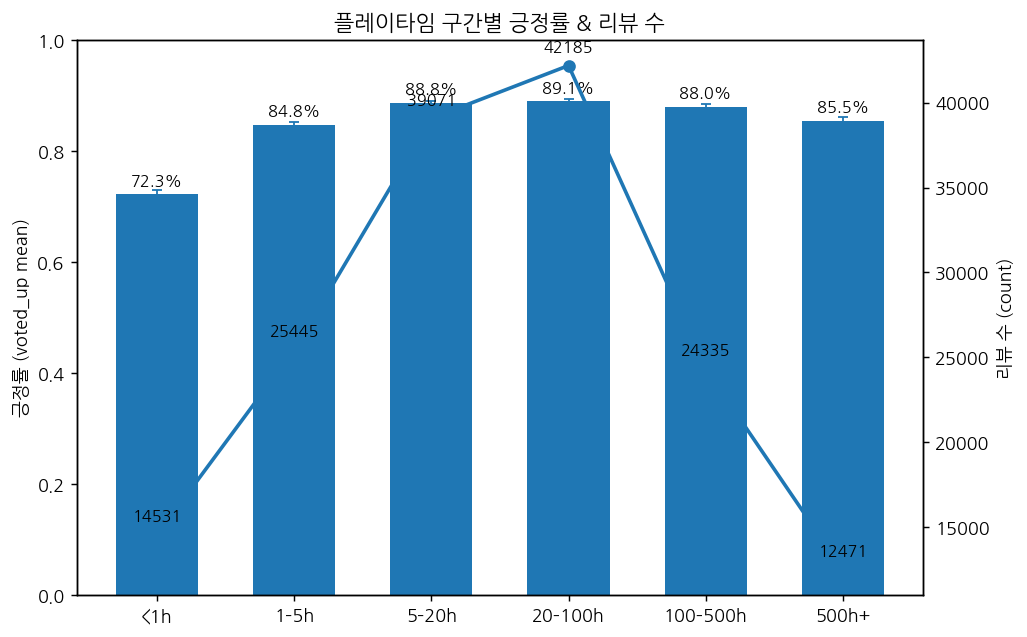

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────────────────────────
# 0) 유틸: 윌슨 신뢰구간 (95%) — 표본수가 큰 구간일 때 안정적
# ──────────────────────────────────────────────────────────────────────────────
from math import sqrt
def wilson_ci(k, n, z=1.96):
    if n == 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + z**2 / n
    centre = p + z*z/(2*n)
    adj = z * sqrt((p*(1-p) + z*z/(4*n)) / n)
    lower = (centre - adj) / denom
    upper = (centre + adj) / denom
    return lower, upper

# ──────────────────────────────────────────────────────────────────────────────
# 1) 전처리
# ──────────────────────────────────────────────────────────────────────────────
def clean_df(df):
    df = df.copy()
    # 필요한 컬럼만, 타입 강제
    needed = ['author_playtime_forever', 'voted_up']
    df = df[needed].dropna()
    # 음수/무한값 제거
    df = df[np.isfinite(df['author_playtime_forever'])]
    df = df[df['author_playtime_forever'] >= 0]
    # voted_up 이진화
    df['voted_up'] = (df['voted_up'] > 0).astype(int)
    return df

# ──────────────────────────────────────────────────────────────────────────────
# 2) 구간 정의 (로그 스케일 감각의 구간)
#    플레이타임은 분 단위 가정.
#    <1h, 1–5h, 5–20h, 20–100h, 100–500h, 500h+
# ──────────────────────────────────────────────────────────────────────────────
BIN_EDGES = [0, 60, 300, 1200, 6000, 30000, np.inf]
BIN_LABELS = ["<1h", "1–5h", "5–20h", "20–100h", "100–500h", "500h+"]

def bin_and_aggregate(df):
    df = clean_df(df)
    df['playtime_bin'] = pd.cut(
        df['author_playtime_forever'],
        bins=BIN_EDGES,
        labels=BIN_LABELS,
        right=False,  # [low, high)
        include_lowest=True,
        ordered=True
    )

    # 집계
    agg = df.groupby('playtime_bin', observed=False).agg(
        PosRate=('voted_up', 'mean'),
        ReviewCount=('voted_up', 'size'),
        PosCount=('voted_up', 'sum')
    ).reset_index()

    # 윌슨 95% CI
    ci = agg.apply(lambda r: wilson_ci(r['PosCount'], r['ReviewCount']), axis=1, result_type='expand')
    agg['PosRate_LB'] = ci[0]
    agg['PosRate_UB'] = ci[1]

    return agg

# ──────────────────────────────────────────────────────────────────────────────
# 3) 시각화: 막대(긍정률) + 우측축 선(리뷰 수)
#    - matplotlib만 사용
#    - 색상 지정 X (기본값 사용)
#    - 단일 플롯 (subplots 금지)
# ──────────────────────────────────────────────────────────────────────────────
def plot_playtime_vs_positive(df, title="Playtime vs Positive Rate"):
    agg = bin_and_aggregate(df)

    x = np.arange(len(agg))
    y_rate = agg['PosRate'].values
    y_cnt  = agg['ReviewCount'].values

    fig, ax1 = plt.subplots(figsize=(8, 5), dpi=130)

    # 막대: 긍정률
    bars = ax1.bar(x, y_rate, width=0.6)
    ax1.set_ylim(0, 1)
    ax1.set_ylabel("긍정률 (voted_up mean)")
    ax1.set_xticks(x, agg['playtime_bin'].astype(str))
    ax1.set_title(title)

    # 윌슨 CI 에러바
    yerr_lower = y_rate - agg['PosRate_LB'].values
    yerr_upper = agg['PosRate_UB'].values - y_rate
    ax1.errorbar(
        x, y_rate, yerr=[yerr_lower, yerr_upper],
        fmt='none', capsize=3, linewidth=1
    )

    # 우측축: 리뷰 수 (선)
    ax2 = ax1.twinx()
    ax2.plot(x, y_cnt, marker='o', linewidth=2)
    ax2.set_ylabel("리뷰 수 (count)")

    # 막대 위 간단 주석 (리뷰 수)
    for xi, cnt, rate in zip(x, y_cnt, y_rate):
        ax2.annotate(f"{int(cnt)}", (xi, cnt), xytext=(0, 6),
                     textcoords="offset points", ha='center', va='bottom', fontsize=9)
        # 막대 위에 긍정률도 퍼센트로
        ax1.annotate(f"{rate*100:.1f}%", (xi, rate), xytext=(0, 3),
                     textcoords="offset points", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    return agg

# ──────────────────────────────────────────────────────────────────────────────
# 4) 사용 예시
# ──────────────────────────────────────────────────────────────────────────────
agg_table = plot_playtime_vs_positive(df, title="플레이타임 구간별 긍정률 & 리뷰 수")
display(agg_table)


=== GLM+Spline 결과 ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:               voted_up   No. Observations:               158038
Model:                            GLM   Df Residuals:                   158032
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -61601.
Date:                Tue, 23 Sep 2025   Deviance:                   1.2320e+05
Time:                        00:13:10   Pearson chi2:                 1.58e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01823
Covariance Type:            nonrobust                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

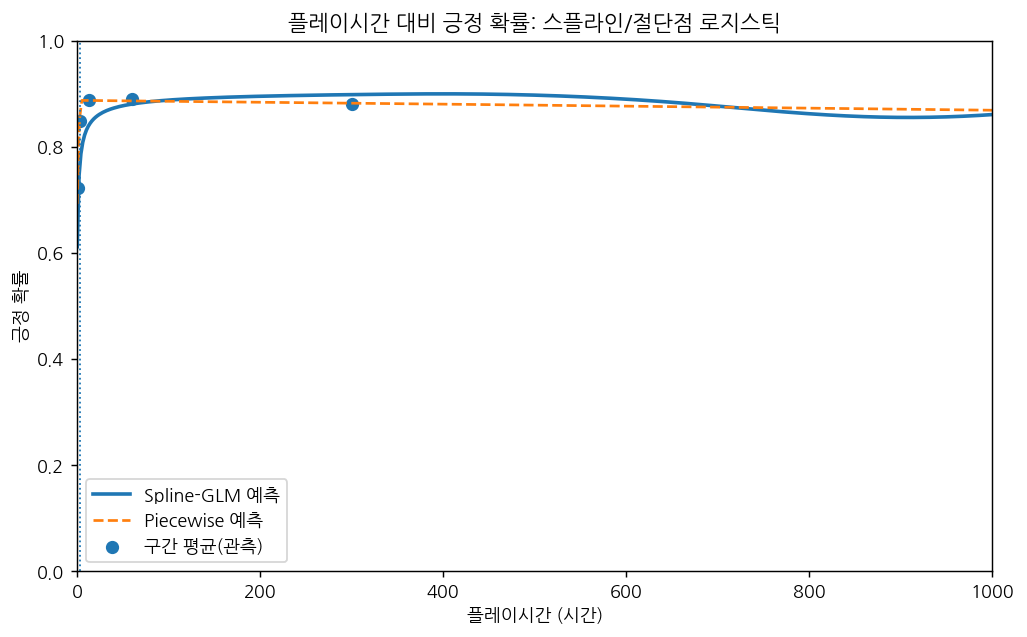

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import patsy as pt
from itertools import product

# ──────────────────────────────────────────────────────────────────────────────
# 0) 데이터 준비
# ──────────────────────────────────────────────────────────────────────────────
def prep(df, controls=None, max_hours=2000, sample_n=None, random_state=42):
    """
    df: 원본 DataFrame
    controls: 통제 변수 리스트 (예: ['author_num_games_owned','author_num_reviews','steam_purchase','received_for_free'])
    max_hours: 이상치 컷(시간 단위). 그 이상은 상한 절삭.
    sample_n: 대용량일 때 성능 확보를 위해 샘플 수 지정(예: 200_000)
    """
    use = df[['author_playtime_forever','voted_up'] + (controls or [])].dropna().copy()
    use = use[np.isfinite(use['author_playtime_forever'])]
    use = use[use['author_playtime_forever'] >= 0]
    # 분 → 시간
    use['playtime_h'] = use['author_playtime_forever'] / 60.0
    # 상한 절삭(heavy tail 안정화)
    use.loc[use['playtime_h'] > max_hours, 'playtime_h'] = max_hours
    # 이진화 보장
    use['voted_up'] = (use['voted_up'] > 0).astype(int)

    # 일부 범주형 더미화(선택): steam_purchase / received_for_free 등 0/1은 그대로 사용
    # language 같은 고카디널 범주는 제외(모형 폭발). 필요하면 상위 k개만 사용 권장.

    # 샘플링(선택)
    if (sample_n is not None) and (len(use) > sample_n):
        use = use.sample(sample_n, random_state=random_state)

    return use

# ──────────────────────────────────────────────────────────────────────────────
# A) GLM Binomial + 자연 cubic spline
# ──────────────────────────────────────────────────────────────────────────────
def fit_glm_spline(df_use, controls=None, df_spline=5):
    """
    df_spline: 스플라인 자유도(기본 5). 과적합 방지를 위해 4~6 권장.
    """
    controls = controls or []
    # 로그 스케일 효과를 반영하고 0 방지 위해 log1p 사용
    df_use['logh'] = np.log1p(df_use['playtime_h'])

    # 디자인 행렬: 자연 cubic spline(bs) + 통제변수
    # patsy의 bs()는 B-spline basis를 생성. degree=3(기본), include_intercept=False.
    spline_term = f'bs(logh, df={df_spline}, include_intercept=False)'
    formula_rhs = ' + '.join([spline_term] + controls) if controls else spline_term
    y, X = pt.dmatrices(f'voted_up ~ {formula_rhs}', data=df_use, return_type='dataframe')

    # GLM(Binomial, logit link)
    model = sm.GLM(y, X, family=sm.families.Binomial())
    res = model.fit()
    return res, X.columns.tolist()

def spline_predict_and_peak(res, df_use, df_spline=5, grid_hours=(0, 1000), num=400):
    # 예측 그리드(시간 → log1p 변환)
    h_grid = np.linspace(grid_hours[0], grid_hours[1], num=num)
    grid = pd.DataFrame({'playtime_h': h_grid})
    grid['logh'] = np.log1p(grid['playtime_h'])

    # 디자인 행렬 재생성
    Xg = pt.dmatrix(f'bs(logh, df={df_spline}, include_intercept=False)', data=grid, return_type='dataframe')
    # res.params는 spline 베이시스 계수만 포함(통제 미사용 가정). 통제가 있다면 0으로 채운 열을 추가해야 함.
    # 간단화를 위해 res.model.exog_names를 기준으로 열 정렬/보정
    for col in res.model.exog_names:
        if col not in Xg.columns:
            Xg[col] = 0.0
    Xg = Xg[res.model.exog_names]

    # 예측 확률
    mu = res.predict(Xg)
    grid['pred'] = mu
    # 최댓값 위치
    idx = int(np.nanargmax(mu))
    peak_h = float(grid.loc[idx, 'playtime_h'])
    peak_p = float(grid.loc[idx, 'pred'])
    return grid, (peak_h, peak_p)

# ──────────────────────────────────────────────────────────────────────────────
# B) 단일 절단점(piecewise) 로지스틱: (h <= k)와 (h > k)에서 서로 다른 기울기
# ──────────────────────────────────────────────────────────────────────────────
def piecewise_design(h, k):
    """
    segmented logit: logit(p) = b0 + b1*h + b2*(h - k)_+
    (h - k)_+ = max(h - k, 0)
    """
    h = np.asarray(h)
    return np.column_stack([np.ones_like(h), h, np.clip(h - k, 0, None)])

def fit_piecewise_best_k(df_use, k_grid=None):
    """
    k_grid: 절단점 후보(시간). None이면 데이터 분위수 기반 자동 설정.
    """
    y = df_use['voted_up'].values
    h = df_use['playtime_h'].values

    if k_grid is None:
        qs = np.quantile(h, [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
        k_grid = np.unique(np.round(qs, 2))

    best = None
    for k in k_grid:
        X = piecewise_design(h, k)
        model = sm.GLM(y, X, family=sm.families.Binomial())
        try:
            res = model.fit()
            aic = res.aic
            if (best is None) or (aic < best['aic']):
                best = {'k': k, 'res': res, 'aic': aic}
        except Exception:
            continue
    return best  # {'k', 'res', 'aic'}

def piecewise_predict(best, hours_grid):
    Xg = piecewise_design(hours_grid, best['k'])
    mu = best['res'].predict(Xg)
    return mu

# ──────────────────────────────────────────────────────────────────────────────
# 1) 실행 예시
# ──────────────────────────────────────────────────────────────────────────────
# 통제 변수(옵션): 대규모 데이터에서는 최소한의 통제만 권장
controls = ['author_num_games_owned','author_num_reviews','steam_purchase','received_for_free']  # 없으면 빈 리스트로
df_use = prep(df, controls=[], max_hours=2000, sample_n=None)

# A) 스플라인 로지스틱
spline_df = 5
res_spline, names = fit_glm_spline(df_use, controls=[], df_spline=spline_df)
grid, peak = spline_predict_and_peak(res_spline, df_use, df_spline=spline_df, grid_hours=(0, 1000), num=500)
peak_h, peak_p = peak

print("=== GLM+Spline 결과 ===")
print(res_spline.summary())
print(f"\n스플라인 추정 Peak: 약 {peak_h:.1f} 시간에서 긍정 확률 {peak_p*100:.2f}% (그리드 추정)")

# B) Piecewise 로지스틱(단일 절단점)
best = fit_piecewise_best_k(df_use, k_grid=None)
if best is not None:
    print("\n=== Piecewise 결과 ===")
    print(f"최적 절단점 k ≈ {best['k']:.1f} 시간 (AIC={best['aic']:.1f})")
else:
    print("\nPiecewise 적합 실패(수치 문제)")

# ──────────────────────────────────────────────────────────────────────────────
# 2) 시각화 (예측 확률 곡선 + 관측 구간 평균 점찍기)
#   - matplotlib만 사용
#   - 단일 플롯, 색 지정 X
# ──────────────────────────────────────────────────────────────────────────────
# 관측 구간 평균(이전에 쓰던 bin 정의 재사용)
BIN_EDGES = [0, 1, 5, 20, 100, 500, 2000]  # 시간 단위
BIN_LABELS = ["<1h", "1–5h", "5–20h", "20–100h", "100–500h", "500h+"]

tmp = df_use.copy()
tmp['bin'] = pd.cut(tmp['playtime_h'], bins=BIN_EDGES, labels=BIN_LABELS, right=False, include_lowest=True, ordered=True)
agg = tmp.groupby('bin', observed=False)['voted_up'].agg(['mean','size']).reset_index()

fig, ax = plt.subplots(figsize=(8,5), dpi=130)
# 스플라인 예측 곡선
ax.plot(grid['playtime_h'], grid['pred'], linewidth=2, label='Spline-GLM 예측')

# piecewise 예측(있으면)
if best is not None:
    h_line = np.linspace(0, 1000, 400)
    mu_pw = piecewise_predict(best, h_line)
    ax.plot(h_line, mu_pw, linewidth=1.5, linestyle='--', label='Piecewise 예측')
    # 절단점 표시
    ax.axvline(best['k'], linewidth=1, linestyle=':')

# 관측 구간 평균(마커)
centers = []
for (lo, hi), m in zip(zip(BIN_EDGES[:-1], BIN_EDGES[1:]), agg['mean'].values):
    centers.append((lo+hi)/2.0)
ax.scatter(centers, agg['mean'].values, s=40, label='구간 평균(관측)')

ax.set_ylim(0, 1)
ax.set_xlim(0, 1000)
ax.set_xlabel("플레이시간 (시간)")
ax.set_ylabel("긍정 확률")
ax.set_title("플레이시간 대비 긍정 확률: 스플라인/절단점 로지스틱")
ax.legend()
plt.tight_layout()


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np

def model_explanatory_power(df_use, res_spline):
    # 실제값
    y_true = df_use['voted_up'].values
    # 예측 확률
    y_pred = res_spline.predict()

    # 1. Pseudo-R² (McFadden)
    ll_model = res_spline.llf
    ll_null = sm.GLM(y_true, np.ones((len(y_true),1)),
                     family=sm.families.Binomial()).fit().llf
    pseudo_r2 = 1 - (ll_model / ll_null)

    # 2. AUC
    auc = roc_auc_score(y_true, y_pred)

    # 3. Accuracy (임계값=0.5)
    y_label = (y_pred >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_label)

    # 4. AIC, BIC
    aic = res_spline.aic
    bic = res_spline.bic

    print("=== 설명력 지표 ===")
    print(f"McFadden Pseudo-R² : {pseudo_r2:.4f}")
    print(f"ROC-AUC            : {auc:.4f}")
    print(f"Accuracy (cut=0.5) : {acc:.4f}")
    print(f"AIC                : {aic:.1f}")
    print(f"BIC                : {bic:.1f}")

    return {
        "Pseudo_R2": pseudo_r2,
        "AUC": auc,
        "Accuracy": acc,
        "AIC": aic,
        "BIC": bic
    }

# 사용 예시
metrics = model_explanatory_power(df_use, res_spline)


=== 설명력 지표 ===
McFadden Pseudo-R² : 0.0231
ROC-AUC            : 0.5897
Accuracy (cut=0.5) : 0.8633
AIC                : 123214.8
BIC                : -1768533.6


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


#20개fps게임목록

In [ ]:
import pandas as pd

# 확인할 appid 리스트
target_ids = [
    730, 578080, 1172470, 2507950, 359550, 1085660, 2357570,
    252490, 440, 1144200, 2073850, 1282270, 493520, 1217060,
    444200, 107410, 550, 1874880, 1517290, 393380, 1237970, 699130, 2000950
]

# df의 appid 컬럼에 있는지 여부 체크
exists_mask = df['appid'].isin(target_ids)

# 실제로 존재하는 appid만 추출
present_ids = df.loc[exists_mask, 'appid'].unique()

# 없는 appid 확인
missing_ids = set(target_ids) - set(present_ids)

print("데이터프레임 안에 존재하는 appid:")
print(present_ids)

print("\n데이터프레임 안에 없는 appid:")
print(missing_ids)


데이터프레임 안에 존재하는 appid:
[ 107410 1085660 1144200 1172470 1217060 1237970 1517290 1874880 2000950
 2357570  252490]

데이터프레임 안에 없는 appid:
{578080, 359550, 393380, 550, 444200, 2073850, 2507950, 493520, 440, 730, 699130, 1282270}


#석진님이 만들어주신 csv파일로 작업진행


In [ ]:
import pandas as pd

path = '/content/FPS_steam_reviews_20_games.csv'

df = pd.read_csv(
    path,
    engine="python",      # python 엔진 사용
    on_bad_lines="skip"   # 문제 행 건너뜀
)




/tmp/ipython-input-1379071788.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby("play_bin").agg(


  play_bin   PosRate  ReviewCount
0     1-5m  0.751808         2212
1    5-20m  0.767488         1501
2     20m+  0.760909         1100


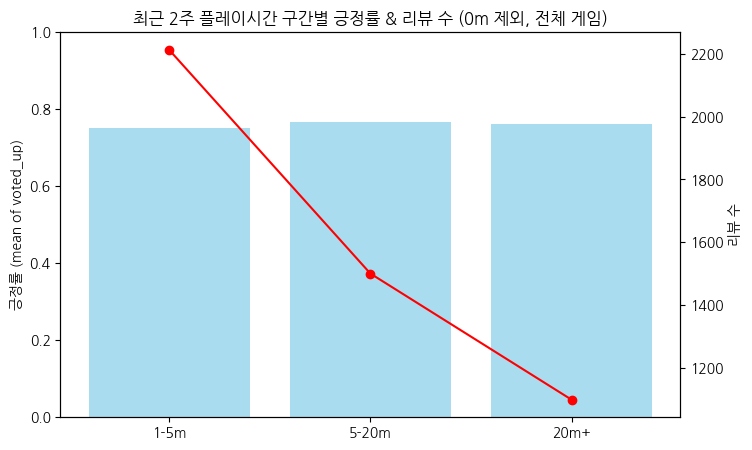

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# 1. 플레이시간 구간화
# -----------------------
bins = [0, 300, 1200, float("inf")]
labels = ["1-5m", "5-20m", "20m+"]


df["play_bin"] = pd.cut(df["author_playtime_last_two_weeks"], bins=bins, labels=labels)

# -----------------------
# 2. 집계 (긍정률 + 리뷰 수)
# -----------------------
summary = df.groupby("play_bin").agg(
    PosRate=("voted_up", "mean"),
    ReviewCount=("voted_up", "count")
).reset_index()

print(summary)

# -----------------------
# 3. 시각화
# -----------------------
fig, ax1 = plt.subplots(figsize=(8,5))

# 긍정률 (왼쪽 y축, 막대그래프)
ax1.bar(summary["play_bin"], summary["PosRate"], color="skyblue", alpha=0.7, label="PosRate")
ax1.set_ylabel("긍정률 (mean of voted_up)")
ax1.set_ylim(0,1)

# 리뷰 수 (오른쪽 y축, 선 그래프)
ax2 = ax1.twinx()
ax2.plot(summary["play_bin"], summary["ReviewCount"], color="red", marker="o", label="Review Count")
ax2.set_ylabel("리뷰 수")

plt.title("최근 2주 플레이시간 구간별 긍정률 & 리뷰 수 (0m 제외, 전체 게임)")
plt.show()


In [ ]:
# 0h 초과 데이터만 필터링
df_use = df[df["author_playtime_last_two_weeks"] > 0].copy()

# 행 개수 확인
print("최근 2주 플레이시간 > 0h 인 행 개수:", df_use.shape[0])


최근 2주 플레이시간 > 0h 인 행 개수: 4813


#가설 1-3: 소유한 게임 수



Silhouette (sampled):
K=2: silhouette=0.3322
K=3: silhouette=0.2992
K=4: silhouette=0.2759
K=5: silhouette=0.2624
K=6: silhouette=0.2362
[INFO] 강제로 선택된 최종 K = 4
----------- [이상치 처리 후 군집별 특성] -----------
         author_num_games_owned  author_num_reviews  author_playtime_forever
cluster                                                                     
0                    452.652672           33.276479              6125.145819
1                     89.319396            5.522321              6308.990804
2                    147.881758           11.884158               235.424820
3                    774.511901           71.648130               642.376744

[클러스터 → 게이머 유형 매핑]
   cluster gamer_type
0        0       Core
1        1   LightMid
2        2   LightMid
3        3  SuperCore

== PosRate by cluster ==
          PosRate      N
cluster                 
0        0.889486  46112
1        0.868851  39581
2        0.831552  34996
3        0.854695  37349

== PosRate by gamer_type ==


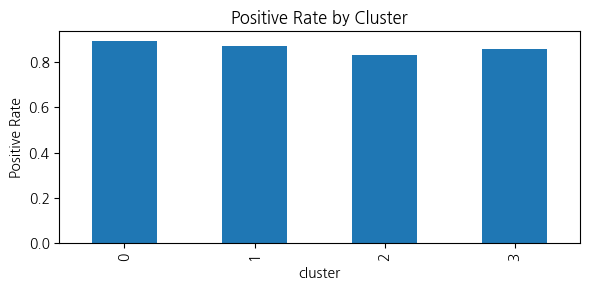

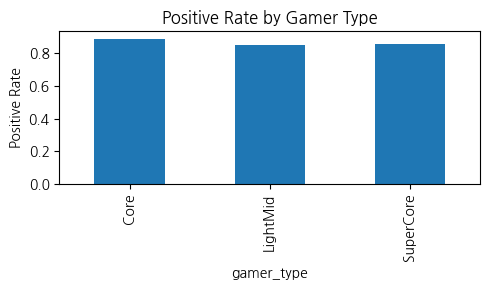

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

# ----------------------------
# 0) 준비
# ----------------------------
FEATURES = ['author_num_games_owned', 'author_num_reviews', 'author_playtime_forever']
TARGET   = 'voted_up'   # 0/1

use_cols = FEATURES + [TARGET]
df_use = df[use_cols].dropna().copy()

# ----------------------------
# 1) IQR 윈저라이즈 (벡터화, 빠르게)
# ----------------------------
def iqr_winsorize_fast(s: pd.Series, k=1.5):
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    lo = q1 - k * iqr
    hi = q3 + k * iqr
    return s.clip(lower=lo, upper=hi)

for c in FEATURES:
    df_use[c] = iqr_winsorize_fast(df_use[c].astype('float64'), k=1.5)

# ----------------------------
# 2) log1p + 표준화 (float32로)
# ----------------------------
def log1p_safe_array(x):
    x = np.asarray(x)
    return np.log1p(np.maximum(x, 0))

X_num = df_use[FEATURES].values
X_num = log1p_safe_array(X_num).astype('float32')

scaler = StandardScaler()
X = scaler.fit_transform(X_num).astype('float32')
y = df_use[TARGET].astype('int8').values

# ----------------------------
# 3) K 탐색 (빠른 모드)
#    - 실루엣/엘보 계산은 샘플(<=10_000)
#    - MiniBatchKMeans로 속도↑
# ----------------------------
rng = np.random.default_rng(42)
MAX_SIL_SAMPLES = 10_000
n = X.shape[0]
if n > MAX_SIL_SAMPLES:
    idx_sil = rng.choice(n, size=MAX_SIL_SAMPLES, replace=False)
    X_sil = X[idx_sil]
else:
    X_sil = X

Ks = range(2, 7)  # 2~6만 탐색 (충분히 실무적)
inertias = []
sil_scores = []

for k in Ks:
    mbk = MiniBatchKMeans(
        n_clusters=k, random_state=42, n_init=5, batch_size=2048, max_iter=100
    )
    mbk.fit(X)  # 전체로 학습(빠름)
    inertias.append(mbk.inertia_)
    # 실루엣은 샘플만
    sil_scores.append(silhouette_score(X_sil, mbk.predict(X_sil)))

# (선택) 간단 출력만
print("Silhouette (sampled):")
for k, s in zip(Ks, sil_scores):
    print(f"K={k}: silhouette={s:.4f}")

# ----------------------------
# 4) 최종 K 선택 휴리스틱
#    - 실루엣 최대 K 또는 관성(엘보) 추세로 결정
# ----------------------------
#K_FINAL = Ks[int(np.argmax(sil_scores))]
#print(f"[INFO] 선택된 최종 K = {K_FINAL}")

# 최종 학습은 일반 KMeans(Elkan)로 조금 더 정밀하게
#kmeans = KMeans(n_clusters=K_FINAL, n_init=10, algorithm='elkan', random_state=42)
#labels = kmeans.fit_predict(X)

#df_out = df_use.copy()
#df_out['cluster'] = labels

# ... 위 코드는 그대로 두고 ...

# ----------------------------
# 4) 최종 K 선택 (강제 고정)
# ----------------------------
K_FINAL = 4   # <- 강제로 4로 지정
print(f"[INFO] 강제로 선택된 최종 K = {K_FINAL}")

kmeans = KMeans(n_clusters=K_FINAL, n_init=10, algorithm='elkan', random_state=42)
labels = kmeans.fit_predict(X)

df_out = df_use.copy()
df_out['cluster'] = labels


# ----------------------------
# 5) 클러스터 프로파일 (원본 스케일 평균)
# ----------------------------
cluster_profile = (
    df_out.groupby('cluster')[FEATURES]
    .mean(numeric_only=True)
    .sort_index()
)
print("----------- [이상치 처리 후 군집별 특성] -----------")
print(cluster_profile)

# ----------------------------
# 6) 게이머 유형 라벨링 (상대백분위)
# ----------------------------
ranked = cluster_profile.rank(pct=True)  # 0~1
labels_map = {}
for cl in cluster_profile.index:
    g = ranked.loc[cl, 'author_num_games_owned']
    r = ranked.loc[cl, 'author_num_reviews']
    if (g >= 0.90) and (r >= 0.90):
        labels_map[cl] = 'SuperCore'
    elif (g >= 0.75) and (r >= 0.75):
        labels_map[cl] = 'Core'
    else:
        labels_map[cl] = 'LightMid'
df_out['gamer_type'] = df_out['cluster'].map(labels_map)

print("\n[클러스터 → 게이머 유형 매핑]")
print(pd.DataFrame({'cluster': list(labels_map.keys()),
                    'gamer_type': list(labels_map.values())}).sort_values('cluster'))

# ----------------------------
# 7) 집단별 긍정률 + 카이제곱
# ----------------------------
posrate_by_cluster = df_out.groupby('cluster')[TARGET].agg(PosRate='mean', N='count')
posrate_by_type    = df_out.groupby('gamer_type')[TARGET].agg(PosRate='mean', N='count')

print("\n== PosRate by cluster ==")
print(posrate_by_cluster.sort_index())

print("\n== PosRate by gamer_type ==")
print(posrate_by_type.sort_values('PosRate'))

ct = pd.crosstab(df_out['cluster'], df_out[TARGET])
chi2, p, dof, exp = stats.chi2_contingency(ct.values)  # values로 약간 빠르게
print("\n== Chi-square (cluster x voted_up) ==")
print(f"chi2={chi2:.4f}, p={p:.3e}, dof={dof}")

# ----------------------------
# 8) 로지스틱 회귀 (빠른 옵션)
#    - 표본 100k만 사용해 statsmodels GLM (요약출력 안 함)
#    - 전량이 꼭 필요 없으면 이게 훨씬 빠름
# ----------------------------
MAX_GLM_SAMPLES = 100_000
m = len(df_out)
if m > MAX_GLM_SAMPLES:
    idx_glm = rng.choice(m, size=MAX_GLM_SAMPLES, replace=False)
    df_glm = df_out.iloc[idx_glm].copy()
else:
    df_glm = df_out.copy()

df_glm['gamer_type'] = pd.Categorical(df_glm['gamer_type'], categories=['LightMid','Core','SuperCore'])

# 요약은 무겁고 길게 찍히니 비활성화
glm_model = smf.glm(formula='voted_up ~ C(gamer_type)', data=df_glm,
                    family=sm.families.Binomial()).fit(disp=False)

params = glm_model.params
conf   = glm_model.conf_int()
odds   = np.exp(params)
odds_ci= np.exp(conf)
odds_table = pd.DataFrame({'OR': odds, 'CI_low': odds_ci[0], 'CI_high': odds_ci[1]})
print("\n=== GLM(Logit) OR & 95% CI (sampled) ===")
print(odds_table)

# ----------------------------
# 9) (선택) 가벼운 시각화만
# ----------------------------
ax = posrate_by_cluster['PosRate'].plot(kind='bar', figsize=(6,3), title='Positive Rate by Cluster')
ax.set_ylabel('Positive Rate')
plt.tight_layout(); plt.show()

ax = posrate_by_type['PosRate'].plot(kind='bar', figsize=(5,3), title='Positive Rate by Gamer Type')
ax.set_ylabel('Positive Rate')
plt.tight_layout(); plt.show()


/tmp/ipython-input-2513642453.py:68: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


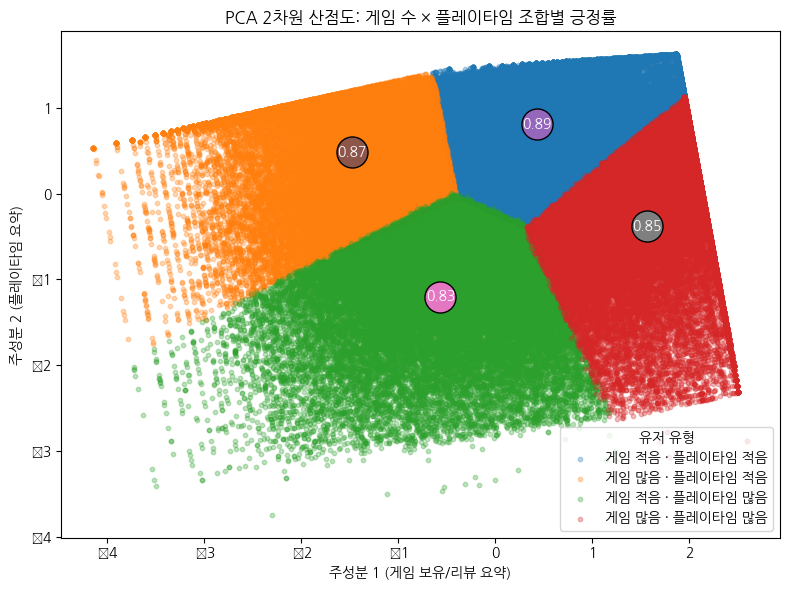

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# -----------------------------------------
# A) PCA 2차원 임베딩 (기존 표준화된 X를 사용)
# -----------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)                       # X: 위에서 만든 표준화(로그) 특징 행렬
centers_pca = pca.transform(kmeans.cluster_centers_)  # 클러스터 중심을 PCA 공간으로 투영

# -----------------------------------------
# B) 시각화용 데이터프레임 구성
# -----------------------------------------
df_plot = pd.DataFrame({
    "주성분1": X_pca[:, 0],
    "주성분2": X_pca[:, 1],
    "클러스터": labels,                          # kmeans.fit_predict 결과
    "voted_up": df_out["voted_up"].values        # 원본 라벨
})

# 클러스터 중심점 (PCA 좌표)
cluster_centers = pd.DataFrame(
    centers_pca,
    columns=["주성분1", "주성분2"]
)

# 클러스터별 긍정률 (Series)
posrate_by_cluster_mean = df_plot.groupby("클러스터")["voted_up"].mean()

# -----------------------------------------
# C) 라벨 매핑 (게임수 × 플레이타임 조합)
# -----------------------------------------
cluster_labels = {
    0: "게임 적음 · 플레이타임 적음",
    1: "게임 많음 · 플레이타임 적음",
    2: "게임 적음 · 플레이타임 많음",
    3: "게임 많음 · 플레이타임 많음",
}
df_plot["유저유형"] = df_plot["클러스터"].map(cluster_labels)

# -----------------------------------------
# D) 산점도
# -----------------------------------------
plt.figure(figsize=(8,6))

# 개별 점
for cl in sorted(df_plot["클러스터"].unique()):
    subset = df_plot[df_plot["클러스터"] == cl]
    plt.scatter(
        subset["주성분1"], subset["주성분2"],
        s=10, alpha=0.3, label=cluster_labels.get(cl, f"cluster {cl}")
    )

# 클러스터 중심 + 긍정률 표시
for cl, row in cluster_centers.iterrows():
    pr = float(posrate_by_cluster_mean.loc[cl])
    plt.scatter(row["주성분1"], row["주성분2"], s=500, marker="o", edgecolor="k")
    plt.text(row["주성분1"], row["주성분2"], f"{pr:.2f}",
             ha="center", va="center", fontsize=10, fontweight="bold", color="white")

plt.title("PCA 2차원 산점도: 게임 수 × 플레이타임 조합별 긍정률")
plt.xlabel("주성분 1 (게임 보유/리뷰 요약)")
plt.ylabel("주성분 2 (플레이타임 요약)")
plt.legend(title="유저 유형", loc="best")
plt.tight_layout()
plt.show()


####플레이타임 vs 긍정률

그룹 간 차이:

플레이타임 구간별 긍정률 분포 비교 → Kruskal-Wallis test (3집단 이상)

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests

# -------------------------------------------
# 1) 플레이터임(분) 구간 정의 & 라벨
#    - 필요에 맞게 bins/labels 수정하세요
# -------------------------------------------
# 예: 0~60분, 1~5시간(60~300), 5~20시간(300~1200), 20~100시간(1200~6000), 100시간 이상(6000+)
bins_min = [0, 60, 300, 1200, 6000, np.inf]
labels   = ["<1h", "1-5h", "5-20h", "20-100h", "100h+"]

# df: 원본 데이터프레임, 컬럼: 'author_playtime_forever'(분), 'voted_up'(0/1)
df_kr = df[['author_playtime_forever', 'voted_up']].dropna().copy()

# 필요 시: 최근 2주 플레이타임으로 바꾸려면 컬럼명만 변경
# df_kr = df[['author_playtime_last_two_weeks', 'voted_up']].dropna().copy()
# df_kr.rename(columns={'author_playtime_last_two_weeks':'author_playtime_forever'}, inplace=True)

# 0분 초과만 사용할 경우(원하시면 주석 해제)
# df_kr = df_kr[df_kr['author_playtime_forever'] > 0]

df_kr['play_bin'] = pd.cut(df_kr['author_playtime_forever'], bins=bins_min, labels=labels, right=False)

# -------------------------------------------
# 2) 기술통계: 구간별 긍정률 & 표본수
# -------------------------------------------
summary = (df_kr
           .groupby('play_bin')['voted_up']
           .agg(PosRate='mean', N='count')
           .reset_index())
print("== PosRate by playtime bin ==")
print(summary)

# -------------------------------------------
# 3) Kruskal–Wallis test (3집단 이상)
#    귀무가설: 모든 구간의 분포(중앙값)가 동일
# -------------------------------------------
groups = []
group_names = []
for g in labels:
    vals = df_kr.loc[df_kr['play_bin'] == g, 'voted_up'].values
    if len(vals) > 0:
        groups.append(vals)
        group_names.append(g)

if len(groups) >= 3:
    H, p_kw = stats.kruskal(*groups)   # 비모수 ANOVA 대안
    print(f"\n== Kruskal–Wallis ==")
    print(f"H={H:.4f}, p-value={p_kw:.3e}")
else:
    print("\n[WARN] 유효한 그룹이 3개 미만입니다. Kruskal–Wallis 불가.")

# -------------------------------------------
# 4) (선택) 사후검정: Mann–Whitney U + Holm 보정
#    귀무가설: 두 구간의 분포가 동일
# -------------------------------------------
do_posthoc = True
if do_posthoc and len(groups) >= 2:
    from itertools import combinations
    pairs, pvals = [], []

    # 모든 쌍에 대해 양측 Mann–Whitney U
    for (g1, g2) in combinations(range(len(group_names)), 2):
        x = df_kr.loc[df_kr['play_bin'] == group_names[g1], 'voted_up'].values
        y = df_kr.loc[df_kr['play_bin'] == group_names[g2], 'voted_up'].values
        if len(x) > 0 and len(y) > 0:
            # 동일값/타이 처리 위해 alternative='two-sided'
            U, p = stats.mannwhitneyu(x, y, alternative='two-sided')
            pairs.append((group_names[g1], group_names[g2]))
            pvals.append(p)

    if pvals:
        rej, p_adj, _, _ = multipletests(pvals, alpha=0.05, method='holm')
        posthoc = pd.DataFrame({
            'group1': [a for a,b in pairs],
            'group2': [b for a,b in pairs],
            'p_raw': pvals,
            'p_holm': p_adj,
            'reject@0.05': rej
        }).sort_values('p_holm')
        print("\n== Post-hoc: Mann–Whitney U (Holm-adjusted) ==")
        print(posthoc.to_string(index=False))
    else:
        print("\n[INFO] 사후검정에 사용할 유효한 페어가 없습니다.")


/tmp/ipython-input-1069741645.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('play_bin')['voted_up']


== PosRate by playtime bin ==
  play_bin   PosRate      N
0      <1h  0.723006  14531
1     1-5h  0.847789  25445
2    5-20h  0.887896  39071
3  20-100h  0.890625  42185
4    100h+  0.871842  36806

== Kruskal–Wallis ==
H=2964.6936, p-value=0.000e+00

== Post-hoc: Mann–Whitney U (Holm-adjusted) ==
 group1  group2         p_raw        p_holm  reject@0.05
    <1h   5-20h  0.000000e+00  0.000000e+00         True
    <1h 20-100h  0.000000e+00  0.000000e+00         True
    <1h   100h+  0.000000e+00  0.000000e+00         True
    <1h    1-5h 1.467475e-199 1.027233e-198         True
   1-5h 20-100h  1.163378e-59  6.980268e-59         True
   1-5h   5-20h  3.011125e-50  1.505563e-49         True
   1-5h   100h+  1.191030e-17  4.764119e-17         True
20-100h   100h+  3.378899e-16  1.013670e-15         True
  5-20h   100h+  1.016616e-11  2.033232e-11         True
  5-20h 20-100h  2.155458e-01  2.155458e-01        False


In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations

# Core 집단(cluster=3) 제거
df_sub = df_out[df_out['cluster'] != 3].copy()

# 집단별 기술통계
summary = df_sub.groupby('cluster')['voted_up'].agg(PosRate='mean', N='count')
print("== PosRate by cluster (Core 제거) ==")
print(summary)

# Kruskal–Wallis 검정
groups = [df_sub.loc[df_sub['cluster']==cl, 'voted_up'].values
          for cl in sorted(df_sub['cluster'].unique())]

H, p_kw = stats.kruskal(*groups)
print(f"\n== Kruskal–Wallis (clusters 0/1/2) ==")
print(f"H={H:.4f}, p-value={p_kw:.3e}")

# 사후검정 (Mann–Whitney U + Holm 보정)
pairs, pvals = [], []
clusters = sorted(df_sub['cluster'].unique())
for g1, g2 in combinations(clusters, 2):
    x = df_sub.loc[df_sub['cluster']==g1, 'voted_up'].values
    y = df_sub.loc[df_sub['cluster']==g2, 'voted_up'].values
    U, p = stats.mannwhitneyu(x, y, alternative='two-sided')
    pairs.append((g1, g2)); pvals.append(p)

rej, p_adj, _, _ = multipletests(pvals, alpha=0.05, method='holm')
posthoc = pd.DataFrame({
    'cluster1': [a for a,b in pairs],
    'cluster2': [b for a,b in pairs],
    'p_raw': pvals,
    'p_holm': p_adj,
    'reject@0.05': rej
})
print("\n== Post-hoc (Mann–Whitney U, Holm 보정) ==")
print(posthoc)


== PosRate by cluster (Core 제거) ==
          PosRate      N
cluster                 
0        0.889486  46112
1        0.868851  39581
2        0.831552  34996

== Kruskal–Wallis (clusters 0/1/2) ==
H=579.5264, p-value=1.437e-126

== Post-hoc (Mann–Whitney U, Holm 보정) ==
   cluster1  cluster2          p_raw         p_holm  reject@0.05
0         0         1   1.936201e-20   1.936201e-20         True
1         0         2  5.516922e-126  1.655077e-125         True
2         1         2   2.557299e-46   5.114599e-46         True


In [ ]:
import numpy as np
from scipy import stats

# ----------------------------
# 1) Epsilon-squared (Kruskal–Wallis 효과크기)
# ----------------------------
n_total = len(df_sub)                     # 표본 전체 크기
k = df_sub['cluster'].nunique()           # 집단 수
epsilon_sq = (H - k + 1) / (n_total - k)  # H는 kruskal 결과
print(f"Epsilon-squared: {epsilon_sq:.4f}")

# ----------------------------
# 2) Cramer's V (교차표 기반 효과크기)
# ----------------------------
ct = pd.crosstab(df_sub['cluster'], df_sub['voted_up'])
chi2, p_chi, dof, exp = stats.chi2_contingency(ct)

cramers_v = np.sqrt(chi2 / (n_total * (min(ct.shape)-1)))
print(f"Cramer's V: {cramers_v:.4f}")


Epsilon-squared: 0.0048
Cramer's V: 0.0693


---------------------------

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import statsmodels.formula.api as smf

# df_out: 이전 단계에서 만든 데이터프레임 (cluster, gamer_type, voted_up 포함)

# ------------------------------------------------------------
# 1. 집단별 r값 계산 (피어슨 + 스피어만)
# ------------------------------------------------------------
results_corr = []

for cl in sorted(df_out['cluster'].unique()):
    sub = df_out[df_out['cluster'] == cl]

    # 피어슨
    r_p, p_p = pearsonr(sub['author_playtime_forever'], sub['voted_up'])
    # 스피어만
    r_s, p_s = spearmanr(sub['author_playtime_forever'], sub['voted_up'])

    results_corr.append({
        "cluster": cl,
        "N": len(sub),
        "Pearson_r": r_p, "Pearson_p": p_p,
        "Spearman_r": r_s, "Spearman_p": p_s
    })

df_corr = pd.DataFrame(results_corr)
print("=== 상관분석 결과 (클러스터별) ===")
print(df_corr)

# ------------------------------------------------------------
# 2. 집단별 로지스틱 회귀
#    voted_up ~ log(playtime)
# ------------------------------------------------------------
import numpy as np
df_out['log_playtime'] = np.log1p(df_out['author_playtime_forever'])

logit_results = {}
for cl in sorted(df_out['cluster'].unique()):
    sub = df_out[df_out['cluster'] == cl]

    model = smf.glm(
        formula="voted_up ~ log_playtime",
        data=sub,
        family=sm.families.Binomial()
    ).fit()

    logit_results[cl] = model
    print(f"\n=== Cluster {cl} 회귀 결과 ===")
    print(model.summary())

    # 오즈비 변환
    or_table = pd.DataFrame({
        "OR": np.exp(model.params),
        "CI_low": np.exp(model.conf_int()[0]),
        "CI_high": np.exp(model.conf_int()[1])
    })
    print("\n[Odds Ratio & 95% CI]")
    print(or_table)

# ------------------------------------------------------------
# 3. 결과 해석 포인트
# - df_corr: r값이 유의미한지 (p<0.05)
# - 각 cluster 회귀 결과 coef 해석:
#   log_playtime 양수 → 플레이타임 많을수록 긍정 확률 ↑
#   음수 → 많을수록 긍정 확률 ↓
# ------------------------------------------------------------


=== 상관분석 결과 (클러스터별) ===
   cluster      N  Pearson_r      Pearson_p  Spearman_r     Spearman_p
0        0  46112   0.004624   3.207162e-01    0.009422   4.305507e-02
1        1  39581  -0.054263   3.322550e-27   -0.051003   3.201399e-24
2        2  34996   0.127242  3.080078e-126    0.162243  5.206931e-205
3        3  37349   0.115958  5.804769e-112    0.175230  2.838085e-255

=== Cluster 0 회귀 결과 ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:               voted_up   No. Observations:                46112
Model:                            GLM   Df Residuals:                    46110
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16025.
Date:                Tue, 23 Sep 2025   Deviance:                       32049.
Time:                        00:15:09   Pea

In [ ]:
# cluster=3 제거
df_out_filtered = df_out[df_out['cluster'] != 3].copy()

# 이후 분석 대상 데이터프레임 교체
for cl in sorted(df_out_filtered['cluster'].unique()):
    sub = df_out_filtered[df_out_filtered['cluster'] == cl]
    ...

# ------------------------------------------------------------
# 1. 집단별 r값 계산 (피어슨 + 스피어만)
# ------------------------------------------------------------
results_corr = []

for cl in sorted(df_out_filtered['cluster'].unique()):
    sub = df_out_filtered[df_out_filtered['cluster'] == cl]

    r_p, p_p = pearsonr(sub['author_playtime_forever'], sub['voted_up'])
    r_s, p_s = spearmanr(sub['author_playtime_forever'], sub['voted_up'])

    results_corr.append({
        "cluster": cl,
        "N": len(sub),
        "Pearson_r": r_p, "Pearson_p": p_p,
        "Spearman_r": r_s, "Spearman_p": p_s
    })

df_corr = pd.DataFrame(results_corr)
print("=== 상관분석 결과 (클러스터별) ===")
print(df_corr)

# ------------------------------------------------------------
# 2. 집단별 로지스틱 회귀
# ------------------------------------------------------------
df_out_filtered['log_playtime'] = np.log1p(df_out_filtered['author_playtime_forever'])

logit_results = {}
for cl in sorted(df_out_filtered['cluster'].unique()):
    sub = df_out_filtered[df_out_filtered['cluster'] == cl]

    model = smf.glm(
        formula="voted_up ~ log_playtime",
        data=sub,
        family=sm.families.Binomial()
    ).fit()

    logit_results[cl] = model
    print(f"\n=== Cluster {cl} 회귀 결과 ===")
    print(model.summary())

    or_table = pd.DataFrame({
        "OR": np.exp(model.params),
        "CI_low": np.exp(model.conf_int()[0]),
        "CI_high": np.exp(model.conf_int()[1])
    })
    print("\n[Odds Ratio & 95% CI]")
    print(or_table)



=== 상관분석 결과 (클러스터별) ===
   cluster      N  Pearson_r      Pearson_p  Spearman_r     Spearman_p
0        0  46112   0.004624   3.207162e-01    0.009422   4.305507e-02
1        1  39581  -0.054263   3.322550e-27   -0.051003   3.201399e-24
2        2  34996   0.127242  3.080078e-126    0.162243  5.206931e-205

=== Cluster 0 회귀 결과 ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:               voted_up   No. Observations:                46112
Model:                            GLM   Df Residuals:                    46110
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16025.
Date:                Tue, 23 Sep 2025   Deviance:                       32049.
Time:                        00:15:13   Pearson chi2:                 4.61e+04
No. Iterations:                    

##집단별 세부 패턴 추가 탐색

###기본 세팅 & 전처리

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np, pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

# df 또는 df_out 을 사용하세요. 여기선 df_out 가정.
assert 'cluster' in df_out.columns, "cluster 컬럼이 필요합니다."
use_cols = [
    'appid','cluster','voted_up',
    'author_playtime_forever','author_num_games_owned',
    'steam_purchase','received_for_free','written_during_early_access'
]
dfu = df_out.copy()
dfu = dfu[[c for c in use_cols if c in dfu.columns]].copy()

# Cluster 0/1/2만
dfu = dfu[dfu['cluster'].isin([0,1,2])]

# NA 제거 + 기본 가공
dfu = dfu.dropna(subset=['author_playtime_forever','voted_up','cluster'])
dfu['log_playtime'] = np.log1p(dfu['author_playtime_forever'])

for b in ['steam_purchase','received_for_free','written_during_early_access']:
    if b in dfu.columns:
        dfu[b] = dfu[b].fillna(0).astype(int).clip(0,1).astype('int8')
    else:
        dfu[b] = 0

dfu['cluster'] = dfu['cluster'].astype('category')

print(dfu[['cluster','voted_up','author_playtime_forever']].describe(include='all'))


         cluster      voted_up  author_playtime_forever
count   120689.0  120689.00000            120689.000000
unique       3.0           NaN                      NaN
top          0.0           NaN                      NaN
freq     46112.0           NaN                      NaN
mean         NaN       0.86592              4477.606211
std          NaN       0.34074              4840.990249
min          NaN       0.00000                 1.000000
25%          NaN       1.00000               473.000000
50%          NaN       1.00000              2116.000000
75%          NaN       1.00000              8266.000000
max          NaN       1.00000             12803.000000


In [ ]:
def fit_glm(formula, data, cov_cluster=None):
    # cov_cluster: 군집화 분산추정을 위한 그룹 변수(예: appid). 없으면 기본.
    kw = {}
    if cov_cluster is not None and cov_cluster in data.columns:
        kw = {'cov_type':'cluster', 'cov_kwds': {'groups': data[cov_cluster].astype('category')}}
    try:
        res = smf.glm(formula, data=data, family=sm.families.Binomial()).fit(**kw)
    except Exception as e:
        # 완전분리/수치문제 대비 Ridge로 백업
        res = smf.glm(formula, data=data, family=sm.families.Binomial()).fit_regularized(alpha=0.1, L1_wt=0)
    return res

def or_table(result, select_like=None):
    params = result.params.copy()
    bse = result.bse.reindex_like(params) if hasattr(result, "bse") else pd.Series(index=params.index, dtype=float)
    if select_like is not None:
        mask = params.index.to_series().str.contains(select_like, regex=True)
        params, bse = params[mask], bse[mask]
    z = 1.96
    OR  = np.exp(params)
    lo  = np.exp(params - z*bse)
    hi  = np.exp(params + z*bse)
    p   = result.pvalues.reindex_like(params) if hasattr(result, "pvalues") else np.nan
    return pd.DataFrame({'OR':OR, 'CI_low':lo, 'CI_high':hi, 'p':p})


In [ ]:
# (a) 각 집단별로 별도 로지스틱
by_cluster = {}
for cl in sorted(dfu['cluster'].cat.categories.astype(int)):
    sub = dfu[dfu['cluster']==cl]
    fml = 'voted_up ~ log_playtime + steam_purchase + received_for_free + written_during_early_access'
    res = fit_glm(fml, sub, cov_cluster='appid' if 'appid' in sub.columns else None)
    by_cluster[cl] = res
    print(f"\n[Cluster {cl}] N={len(sub)}  AIC={res.aic:.1f}")
    print(or_table(res, select_like='(steam_purchase|received_for_free|written_during_early_access)$').round(3))

# (b) 상호작용으로 '집단별로 다르다'를 한 번에 검정
# steam_purchase, received_for_free, early_access 의 효과가 cluster에 따라 달라지는지
fml_int = 'voted_up ~ log_playtime + steam_purchase*C(cluster) + received_for_free*C(cluster) + written_during_early_access*C(cluster)'
res_int = fit_glm(fml_int, dfu, cov_cluster='appid' if 'appid' in dfu.columns else None)
print("\n[Interaction model] AIC=", res_int.aic)

# 용어 단위 Wald test (상호작용 블록이 유의한가)
wt = res_int.wald_test_terms(skip_single=True)  # 각 term 블록별 카이제곱 검정
print(wt)



[Cluster 0] N=46112  AIC=32053.5
                              OR  CI_low  CI_high   p
steam_purchase               1.0     1.0      1.0 NaN
received_for_free            1.0     1.0      1.0 NaN
written_during_early_access  1.0     1.0      1.0 NaN

[Cluster 1] N=39581  AIC=30668.4
                              OR  CI_low  CI_high   p
steam_purchase               1.0     1.0      1.0 NaN
received_for_free            1.0     1.0      1.0 NaN
written_during_early_access  1.0     1.0      1.0 NaN


/tmp/ipython-input-782547738.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = params.index.to_series().str.contains(select_like, regex=True)
/tmp/ipython-input-782547738.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = params.index.to_series().str.contains(select_like, regex=True)



[Cluster 2] N=34996  AIC=30717.8
                              OR  CI_low  CI_high   p
steam_purchase               1.0     1.0      1.0 NaN
received_for_free            1.0     1.0      1.0 NaN
written_during_early_access  1.0     1.0      1.0 NaN


/tmp/ipython-input-782547738.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = params.index.to_series().str.contains(select_like, regex=True)



[Interaction model] AIC= 94237.11493304883
                                                         chi2                 P>chi2  df constraint
C(cluster)                              [[88.17803206136344]]  7.118420274154269e-20              2
steam_purchase:C(cluster)                             [[0.0]]                    nan              2
received_for_free:C(cluster)                          [[0.0]]                    nan              2
written_during_early_access:C(cluster)                [[0.0]]                    nan              2


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but ran

###2) 다변량 로지스틱 회귀 (집단 효과 포함)

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from statsmodels.tools.sm_exceptions import PerfectSeparationError

def _drop_constant_or_single_level(df, cols):
    keep = []
    for c in cols:
        vc = df[c].dropna().unique()
        if len(vc) >= 2:
            keep.append(c)
    return keep

def _has_quasi_separation(y, X):
    # 매우 러프한 체크: 각 이진 변수/조합이 y를 거의 완벽히 분리하는지 살핌
    # (빠른 휴리스틱; 완벽하지 않음)
    yv = y.values.astype(int)
    if yv.min()==yv.max():
        return True
    # 단일 컬럼 기준으로 간단 체크
    for j in range(X.shape[1]):
        x = X.iloc[:, j]
        if x.nunique() <= 2:
            # 양/음성 한쪽에만 거의 몰림?
            t = pd.crosstab(x, y)
            if (t==0).any().any():
                return True
    return False

def fit_glm_safe(formula, data, family=sm.families.Binomial(), cov_type=None, cov_kwds=None):
    # 1) missing='drop' 로 설계행렬 생성
    y, X = dmatrices(formula, data=data, return_type='dataframe', NA_action='drop')
    y = pd.Series(y.values.ravel(), index=X.index, name=y.columns[0] if hasattr(y, 'columns') else 'y')

    # 2) 분산 0(상수열) 컬럼 제거
    var0 = X.columns[X.nunique(dropna=True) <= 1]
    if len(var0):
        X = X.drop(columns=var0)

    # 3) 랭크 결손 방지: 완전 동일 컬럼/완전 상관 제거(간단 휴리스틱)
    X = X.loc[:, ~X.T.duplicated()]  # 완전 동일 열 제거

    # 4) 준완전 분리 휴리스틱 감지 (있으면 일부 컬럼 제거 시도)
    if _has_quasi_separation(y, X):
        # 이진 설명변수 중심으로 우선 제거 후보
        bin_cols = [c for c in X.columns if X[c].dropna().nunique()<=2 and c!='Intercept']
        for c in bin_cols:
            X_try = X.drop(columns=[c])
            if not _has_quasi_separation(y, X_try):
                X = X_try
                break

    # 5) GLM 적합
    model = sm.GLM(y, X, family=family)
    if cov_type:
        res = model.fit(cov_type=cov_type, cov_kwds=(cov_kwds or {}))
    else:
        res = model.fit()

    return res, y, X

def safe_marginal_effects(res, y, X):
    # get_margeff(summary) 대신 summary_frame() 사용(형 불일치 회피)
    try:
        mfx = res.get_margeff(at='overall', method='dydx')
        return mfx.summary_frame()
    except Exception:
        # 수동 AME(연속형만 근사): 평균점 근처에서 gradient 계산
        # 로짓에서 ∂P/∂x = β * p*(1-p)
        lin = np.asarray(res.fittedvalues)  # 이는 μ = E[y|X] (GLM Binomial -> 확률)
        p = lin
        ame = []
        for name, b in zip(res.params.index, res.params.values):
            if name == 'Intercept':
                continue
            # 평균 p*(1-p) * beta
            ame.append((name, float(np.mean(p*(1-p))*b)))
        return pd.DataFrame(ame, columns=['var', 'dy/dx_mean'])

# ------------------ 사용 예 ------------------

fml_base = 'voted_up ~ log_playtime + steam_purchase + received_for_free + written_during_early_access + C(cluster)'

# (1) 안전 적합 (클러스터-로버스트 예시: appid 있으면 적용)
cov_type = 'cluster' if ('appid' in dfu.columns) else None
cov_kwds = {'groups': dfu['appid']} if cov_type=='cluster' else None

res_base, y_used, X_used = fit_glm_safe(fml_base, dfu, family=sm.families.Binomial(),
                                        cov_type=cov_type, cov_kwds=cov_kwds)

print(res_base.summary())  # 여기선 0/NaN 계수 안 나와야 정상

# (2) 마진효과(요약 프레임으로 안전 출력)
mfx_df = safe_marginal_effects(res_base, y_used, X_used)
print(mfx_df)

# (3) 오즈비 표도 실제 사용된 변수명 기준으로 계산
or_table_df = pd.DataFrame({
    'term': res_base.params.index,
    'OR': np.exp(res_base.params.values),
    'CI_low': np.exp(res_base.conf_int()[0].values),
    'CI_high': np.exp(res_base.conf_int()[1].values),
    'p': res_base.pvalues.values
})
# 관심 변수만 필터(정규식 대신 contains로 안전)
mask = or_table_df['term'].str.contains('log_playtime|steam_purchase|received_for_free|written_during_early_access|C\\(cluster\\)')
print(or_table_df[mask].round(3))


                 Generalized Linear Model Regression Results                  
Dep. Variable:               voted_up   No. Observations:               120689
Model:                            GLM   Df Residuals:                   120686
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47229.
Date:                Tue, 23 Sep 2025   Deviance:                       94459.
Time:                        00:16:01   Pearson chi2:                 1.23e+05
No. Iterations:                     5   Pseudo R-squ. (CS):           0.005464
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
C(cluster)[T.1]    -0.1316      0.021     

In [ ]:
# (a) 선형 vs 제곱항
fml_lin  = 'voted_up ~ log_playtime + steam_purchase + received_for_free + written_during_early_access + C(cluster)'
fml_quad = 'voted_up ~ log_playtime + I(log_playtime**2) + steam_purchase + received_for_free + written_during_early_access + C(cluster)'
res_lin  = fit_glm(fml_lin,  dfu, cov_cluster='appid' if 'appid' in dfu.columns else None)
res_quad = fit_glm(fml_quad, dfu, cov_cluster='appid' if 'appid' in dfu.columns else None)

print("AIC linear:", res_lin.aic, "  AIC quad:", res_quad.aic)
try:
    lr_stat, lr_p, df_diff = res_quad.compare_lr_test(res_lin)  # quad가 더 복잡
    print(f"LR test (quad vs linear): stat={lr_stat:.2f}, df={df_diff}, p={lr_p:.4g}")
except Exception as e:
    print("LR test 실패(정규화 적합 등). AIC/BIC로 비교하세요.")

# (b) 스플라인 (자연스러운 곡선)
# 자유도(df_spline)는 4~6 사이에서 검토 추천
from patsy import bs
fml_spline = 'voted_up ~ bs(log_playtime, df=5, degree=3, include_intercept=False) + steam_purchase + received_for_free + written_during_early_access + C(cluster)'
res_spline = fit_glm(fml_spline, dfu, cov_cluster='appid' if 'appid' in dfu.columns else None)
print("AIC spline:", res_spline.aic)


AIC linear: 94237.11493304883   AIC quad: 93482.00528628919
LR test 실패(정규화 적합 등). AIC/BIC로 비교하세요.
AIC spline: 93464.09149757175


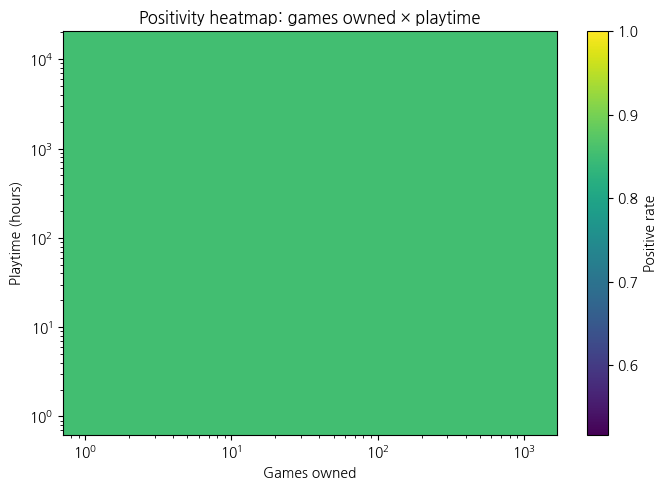

In [ ]:
# 산점도는 너무 크면 과밀 → 2D-bin(hexbins)로 "평균 긍정률" 색상표시가 안정적
sub_vis = dfu  # 필요 시 .sample(100000, random_state=0)
fig, ax = plt.subplots(figsize=(7,5))
hb = ax.hexbin(
    sub_vis['author_num_games_owned'].clip(lower=1),
    sub_vis['author_playtime_forever'].clip(lower=1),
    C=sub_vis['voted_up'],
    reduce_C_function=np.mean, gridsize=50, mincnt=30
)
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel('Games owned')
ax.set_ylabel('Playtime (hours)')
cb = fig.colorbar(hb, ax=ax); cb.set_label('Positive rate')
ax.set_title('Positivity heatmap: games owned × playtime')
plt.tight_layout(); plt.show()


/tmp/ipython-input-4235293807.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = (dfu.groupby(['cluster','pt_bin'])['voted_up']
/tmp/ipython-input-4235293807.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cl, gg in g.groupby('cluster'):


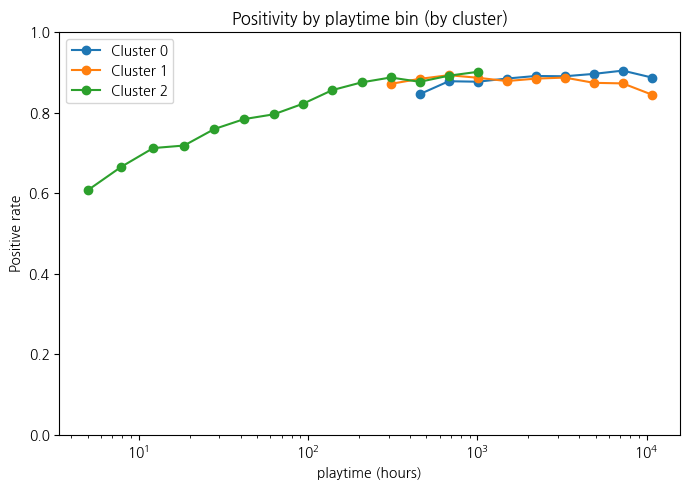

In [ ]:
# 로그-균등 구간
edges = np.unique(np.logspace(0, np.log10(dfu['author_playtime_forever'].max()+1), 25)-1)
dfu['pt_bin'] = pd.cut(dfu['author_playtime_forever'], bins=edges, include_lowest=True)

g = (dfu.groupby(['cluster','pt_bin'])['voted_up']
         .agg(PosRate='mean', N='size')
         .reset_index())
g = g[g['N']>=50]  # 표본 적은 구간 제거

fig, ax = plt.subplots(figsize=(7,5))
for cl, gg in g.groupby('cluster'):
    # bin 중앙값
    mid = gg['pt_bin'].apply(lambda x: x.mid)
    ax.plot(mid, gg['PosRate'], marker='o', label=f'Cluster {cl}')
ax.set_xscale('log'); ax.set_xlabel('playtime (hours)')
ax.set_ylabel('Positive rate')
ax.set_ylim(0,1)
ax.set_title('Positivity by playtime bin (by cluster)')
ax.legend(); plt.tight_layout(); plt.show()


##상위fps20개 한정으로 플레이어 시간과 리뷰분

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# ---------------------------
# 1) 유저 단위 집계 (재확인)
# ---------------------------
df_user = (df.groupby('author_steamid')
             .agg(
                 n_games=('appid','nunique'),
                 mean_pos=('voted_up','mean'),
                 total_reviews=('recommendationid','count'),
                 total_playtime=('author_playtime_forever','sum'),
                 steam_purchase=('steam_purchase','max'),
                 received_for_free=('received_for_free','max'),
                 early_access=('written_during_early_access','max')
             )
             .reset_index())

# ---------------------------
# 2) 플레이타임 기준 2개 그룹
#    기준선: 10000분(≈166시간)
# ---------------------------
df_user['gamer_type'] = pd.cut(
    df_user['total_playtime'],
    bins=[0, 10000, float('inf')],
    labels=['Light', 'Heavy'],
    right=False
)

# ---------------------------
# 3) 긍정률/규모 요약
# ---------------------------
posrate_table = (
    df_user.groupby('gamer_type', observed=True)
           .agg(PosRate=('mean_pos','mean'),
                Users=('author_steamid','count'),
                TotalReviews=('total_reviews','sum'),
                MedianPlaytimeMin=('total_playtime','median'),
                AvgGames=('n_games','mean'))
           .reset_index()
)

# ---------------------------
# 4) 구매/무료/EA 비율
# ---------------------------
rate_table = (
    df_user.groupby('gamer_type', observed=True)
           .agg(PurchaseRate=('steam_purchase','mean'),
                FreeRate=('received_for_free','mean'),
                EARate=('early_access','mean'))
           .reset_index()
)

# ---------------------------
# 5) 카이제곱 검정 (구매/무료/EA)
# ---------------------------
def chi2_for_binary(df_, type_col, bin_col):
    contingency = pd.crosstab(df_[type_col], df_[bin_col])
    chi2, p, dof, exp = chi2_contingency(contingency)
    return contingency, {'chi2': chi2, 'p': p, 'dof': dof}

cont_purchase, stat_purchase = chi2_for_binary(df_user, 'gamer_type', 'steam_purchase')
cont_free,     stat_free     = chi2_for_binary(df_user, 'gamer_type', 'received_for_free')
cont_ea,       stat_ea       = chi2_for_binary(df_user, 'gamer_type', 'early_access')

# ---------------------------
# 6) 결과 출력
# ---------------------------
print("[유형별 긍정률/규모]")
print(posrate_table.to_string(index=False))

print("\n[유형별 구매/무료/EA 비율]")
print(rate_table.to_string(index=False))

print("\n[카이제곱] gamer_type x steam_purchase")
print(cont_purchase)
print(stat_purchase)

print("\n[카이제곱] gamer_type x received_for_free")
print(cont_free)
print(stat_free)

print("\n[카이제곱] gamer_type x early_access")
print(cont_ea)
print(stat_ea)


[유형별 긍정률/규모]
gamer_type  PosRate  Users  TotalReviews  MedianPlaytimeMin  AvgGames
     Light 0.851477  98127        111943              899.0  1.140797
     Heavy 0.860561  25877         46095            28250.0  1.781312

[유형별 구매/무료/EA 비율]
gamer_type  PurchaseRate  FreeRate   EARate
     Light      0.707186  0.036758 0.137658
     Heavy      0.680875  0.039224 0.143989

[카이제곱] gamer_type x steam_purchase
steam_purchase      0      1
gamer_type                  
Light           28733  69394
Heavy            8258  17619
{'chi2': np.float64(67.59514938901009), 'p': np.float64(2.0076087087013599e-16), 'dof': 1}

[카이제곱] gamer_type x received_for_free
received_for_free      0     1
gamer_type                    
Light              94520  3607
Heavy              24862  1015
{'chi2': np.float64(3.4005301901756635), 'p': np.float64(0.06517546699677777), 'dof': 1}

[카이제곱] gamer_type x early_access
early_access      0      1
gamer_type                
Light         84619  13508
Heavy         22

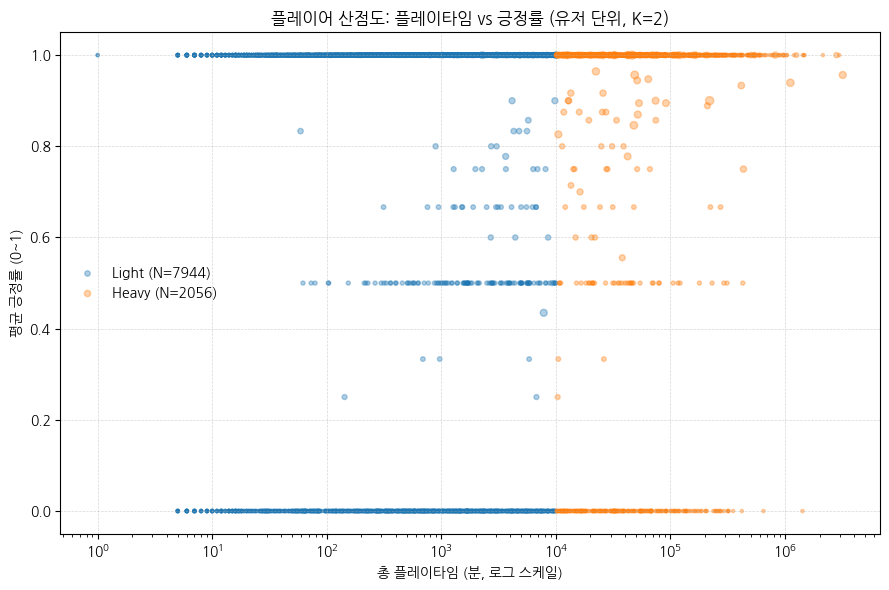

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 0) df_user 준비 (없으면 생성)
#    df: 원본 리뷰 데이터프레임 (행 = 리뷰 단위)
# ------------------------------------------------------------
if 'df_user' not in globals():
    df_user = (df.groupby('author_steamid')
                 .agg(
                     n_games=('appid','nunique'),                # 소유 게임 수
                     mean_pos=('voted_up','mean'),               # 평균 긍정률
                     total_reviews=('recommendationid','count'), # 작성 리뷰 수
                     total_playtime=('author_playtime_forever','sum'), # 총 플레이타임
                     steam_purchase=('steam_purchase','max'),    # 구매 여부
                     received_for_free=('received_for_free','max'), # 무료 수령 여부
                     early_access=('written_during_early_access','max') # 얼리억세스 여부
                 ).reset_index())

    # K=2 (라이트/헤비) 분류: 10000분(≈166시간) 기준
    df_user['gamer_type'] = pd.cut(
        df_user['total_playtime'],
        bins=[0, 10000, float('inf')],
        labels=['라이트', '헤비'],
        right=False
    )


# ------------------------------------------------------------
# 1) 그릴 데이터 전처리
#    - total_playtime > 0, mean_pos 유효한 데이터만
#    - 산점도 과밀 방지를 위해 최대 10,000명 샘플링
# ------------------------------------------------------------
plot_df = df_user.loc[(df_user['total_playtime'] > 0) & (df_user['mean_pos'].notna())].copy()

max_points = 10_000
if len(plot_df) > max_points:
    plot_df = plot_df.sample(n=max_points, random_state=42)

# 마커 크기: 리뷰 수를 로그 스케일로 변환 후 보정
# (너무 큰 값 방지: +1로 log 안정화, 배수로 크기 조절)
marker_size = np.log1p(plot_df['total_reviews']).values * 8.0

# ------------------------------------------------------------
# 2) 산점도 그리기 (유저 유형별)
#    - 색상은 기본 자동 할당
#    - x축 로그 스케일 적용
# ------------------------------------------------------------
plt.figure(figsize=(9, 6))

for gt in ['Light', 'Heavy']:
    sub = plot_df[plot_df['gamer_type'] == gt]
    if len(sub) == 0:
        continue
    plt.scatter(
        sub['total_playtime'],
        sub['mean_pos'],
        s=np.log1p(sub['total_reviews']).values * 8.0,
        alpha=0.35,
        label=f"{gt} (N={len(sub)})"
    )

plt.xscale('log')
plt.xlabel('총 플레이타임 (분, 로그 스케일)')
plt.ylabel('평균 긍정률 (0~1)')
plt.title('플레이어 산점도: 플레이타임 vs 긍정률 (유저 단위, K=2)')
plt.legend(frameon=False)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()


#####1) LOWESS 스무딩 추세선 (+가중 WLS 회귀선)

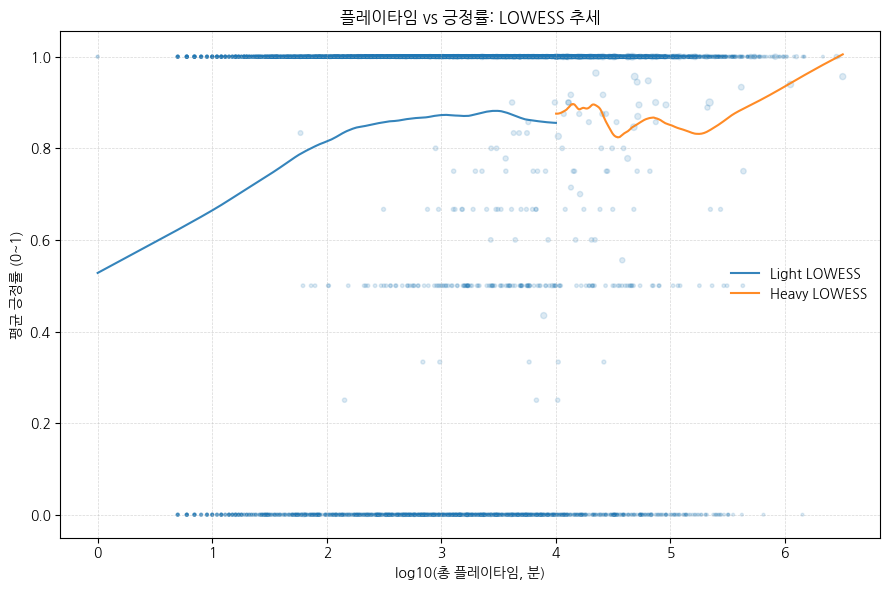

                            WLS Regression Results                            
Dep. Variable:               mean_pos   R-squared:                       0.014
Model:                            WLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     48.82
Date:                Tue, 23 Sep 2025   Prob (F-statistic):           2.58e-31
Time:                        00:16:44   Log-Likelihood:                -3399.2
No. Observations:               10000   AIC:                             6806.
Df Residuals:                    9996   BIC:                             6835.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6998      0.015     45.998      0.0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm

# 준비
use = plot_df.dropna(subset=['total_playtime','mean_pos','total_reviews']).copy()
use = use[use['total_playtime'] > 0]
use['log_total_play'] = np.log10(use['total_playtime'])

# ---- 1A. LOWESS (비모수 스무딩) : 전체 + 집단별
plt.figure(figsize=(9,6))

for gt, color in [('Light','tab:blue'), ('Heavy','tab:orange')]:
    sub = use[use['gamer_type']==gt]
    if sub.empty:
        continue
    smoothed = lowess(sub['mean_pos'], sub['log_total_play'], frac=0.25, it=0, return_sorted=True)
    plt.plot(smoothed[:,0], smoothed[:,1], label=f'{gt} LOWESS', alpha=0.9)

# 산점도(희미하게)
plt.scatter(use['log_total_play'], use['mean_pos'], s=np.log1p(use['total_reviews'])*6, alpha=0.15)

plt.xlabel('log10(총 플레이타임, 분)')
plt.ylabel('평균 긍정률 (0~1)')
plt.title('플레이타임 vs 긍정률: LOWESS 추세')
plt.legend(frameon=False)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

# ---- 1B. 가중 최소제곱(WLS) 회귀: mean_pos ~ log_total_play (+집단 더미)
use['is_heavy'] = (use['gamer_type']=='Heavy').astype(int)
X = sm.add_constant(np.c_[use['log_total_play'], use['is_heavy'], use['log_total_play']*use['is_heavy']])
model = sm.WLS(use['mean_pos'], X, weights=np.clip(use['total_reviews'], 1, None)).fit()
print(model.summary())


#####구간화(빈) 평균/신뢰구간 에러바

In [ ]:
import numpy as np

# 구간 정의(분 단위): <100h, 100~500h, 500~2000h, 2000h+
bins = [0, 6000, 30000, 120000, np.inf]  # 100h=6000분
labels = ['<100h','100~500h','500~2000h','2000h+']

bdf = use.copy()
bdf['bin'] = pd.cut(bdf['total_playtime'], bins=bins, labels=labels, right=False)

def boot_mean_ci(x, B=500, alpha=0.05):
    if len(x)==0:
        return np.nan, (np.nan, np.nan)
    boots = np.random.choice(x, size=(B, len(x)), replace=True).mean(axis=1)
    lo, hi = np.quantile(boots, [alpha/2, 1-alpha/2])
    return float(np.mean(x)), (float(lo), float(hi))

plot_stats = []
for gt in ['Light','Heavy']:
    subg = bdf[bdf['gamer_type']==gt]
    for lb in labels:
        vals = subg.loc[subg['bin']==lb, 'mean_pos'].dropna().values
        m, (lo, hi) = boot_mean_ci(vals)
        plot_stats.append({'group':gt,'bin':lb,'mean':m,'lo':lo,'hi':hi,'n':len(vals)})

plot_stats = pd.DataFrame(plot_stats)

# 시각화
plt.figure(figsize=(9,6))
xpos = np.arange(len(labels))
width = 0.35

for i, gt in enumerate(['Light','Heavy']):
    sub = plot_stats[plot_stats['group']==gt]
    plt.bar(xpos + (i-0.5)*width, sub['mean'], width, yerr=[sub['mean']-sub['lo'], sub['hi']-sub['mean']],
            alpha=0.8, label=f'{gt}', capsize=4)

plt.xticks(xpos, labels)
plt.ylim(0,1)
plt.ylabel('평균 긍정률 (95% CI)')
plt.title('플레이타임 구간별 평균 긍정률 (유저 단위)')
plt.legend(frameon=False)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()


#####라이트 vs 헤비 통계검정 (효과크기 포함)

In [ ]:
from scipy import stats

light = use.loc[use['gamer_type']=='Light', 'mean_pos'].dropna().values
heavy = use.loc[use['gamer_type']=='Heavy', 'mean_pos'].dropna().values

# Mann-Whitney U (순위 검정)
u, p_u = stats.mannwhitneyu(light, heavy, alternative='two-sided')

# t-test (참고용)
t, p_t = stats.ttest_ind(light, heavy, equal_var=False)

# Cliff's delta (효과크기; -1~1, 0에 가까울수록 차이 작음)
def cliffs_delta(x, y):
    import itertools
    n = len(x); m = len(y)
    gt = sum(1 for a,b in itertools.product(x,y) if a > b)
    lt = sum(1 for a,b in itertools.product(x,y) if a < b)
    return (gt - lt) / (n*m)

cd = cliffs_delta(light, heavy)

print(f"[Mann-Whitney U] U={u:.0f}, p={p_u:.3g}")
print(f"[Welch t-test]  t={t:.3f}, p={p_t:.3g}")
print(f"[Cliff's delta] δ={cd:.3f}  (|δ|<0.147: 아주 작음, <0.33: 작음, <0.474: 중간, 그 이상: 큼)")
print(f"Light mean={light.mean():.3f}, Heavy mean={heavy.mean():.3f}, diff={heavy.mean()-light.mean():.3f}")


In [ ]:
import statsmodels.formula.api as smf
import numpy as np

# 로그 변환으로 스케일 보정 (게임 수, 리뷰 수, 플레이타임은 분포가 치우쳐 있음)
df_user['log_playtime'] = np.log1p(df_user['total_playtime'])
df_user['log_games'] = np.log1p(df_user['n_games'])
df_user['log_reviews'] = np.log1p(df_user['total_reviews'])

# 다변량 회귀식 (OLS)
fml = 'mean_pos ~ log_playtime + log_games + log_reviews + steam_purchase + received_for_free + early_access'
res = smf.ols(fml, data=df_user).fit(cov_type='HC3')  # 견고표준오차
print(res.summary())


#설명력 추리

##공통: 로드 & 경량 전처리

In [ ]:
import pandas as pd, numpy as np
from pathlib import Path


# 기본 정리
df = df.dropna(subset=["voted_up","author_num_games_owned","author_num_reviews",
                       "author_playtime_forever","author_playtime_at_review","language"])
df["voted_up"] = df["voted_up"].astype(int)

# 극단치 윈저라이즈(상하 1% 컷) → 회귀/로짓 안정화
def winsorize(s, p=0.01):
    lo, hi = s.quantile(p), s.quantile(1-p)
    return s.clip(lo, hi)

for col in ["author_num_games_owned","author_num_reviews",
            "author_playtime_forever","author_playtime_at_review",
            "votes_up","comment_count"]:
    df[col] = winsorize(df[col], 0.01)

# 로그 변환(0 보호)
for col in ["author_num_games_owned","author_num_reviews",
            "author_playtime_forever","author_playtime_at_review"]:
    df[f"log_{col}"] = np.log1p(df[col])

# 최근 2주 플레이가 분(=데이터 설명상 분)라고 하셨으므로, 분 그대로 사용
df["author_playtime_last_two_weeks"] = df["author_playtime_last_two_weeks"].fillna(0)
df["log_play2w"] = np.log1p(df["author_playtime_last_two_weeks"])


##파생변수(비율/강도/최근성) – 단일변수보다 설명력 ↑

In [ ]:
# (a) 초반 몰입도: 리뷰 시점/누적
df["engage_ratio"] = (df["author_playtime_at_review"] + 1) / (df["author_playtime_forever"] + 1)

# (b) 활동성: 리뷰 성향
df["review_intensity"] = (df["author_num_reviews"] + 1) / (df["author_num_games_owned"] + 1)

# (c) 최근성 강도: 최근2주 / 누적
df["recency_ratio"] = (df["author_playtime_last_two_weeks"] + 1) / (df["author_playtime_forever"] + 1)

# (d) 영향력 프록시: 공감/댓글 로그
df["log_votes_up"] = np.log1p(df["votes_up"])
df["log_comments"] = np.log1p(df["comment_count"])

# (e) 언어 상위만 더미(표본 크기 확보)
top_langs = df["language"].value_counts().head(8).index
for lg in top_langs:
    df[f"lang_{lg}"] = (df["language"]==lg).astype(int)


##상호작용: 단일 변수로 안 보이던 효과 드러내기

In [ ]:
df["int_purchase_play"] = df["steam_purchase"] * np.log1p(df["author_playtime_forever"])
df["int_free_owned"]    = df["received_for_free"] * np.log1p(df["author_num_games_owned"])
df["int_ea_recency"]    = df["written_during_early_access"] * df["recency_ratio"]


##층화(세분화) 비교: 집단 내에서 설명력 확인

In [ ]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

def safe_qcut(s: pd.Series, q=3, base_labels=("Low","Mid","High")):
    """
    - 분위수 경계를 얻되 duplicates='drop'으로 중복을 제거
    - 중복으로 실제 구간 수가 q보다 작아지면 라벨 길이도 자동 축소
    - 결과는 순서형 범주형으로 반환
    """
    # retbins=True로 실제 경계 확인
    _, bins = pd.qcut(s, q=q, retbins=True, duplicates='drop')
    n_bins = len(bins) - 1
    if n_bins < 1:
        # 전 구간이 같은 값인 극단 케이스: 전부 단일 구간으로 처리
        cat = pd.Series(pd.Categorical(["All"] * len(s), categories=["All"], ordered=True), index=s.index)
        return cat

    labels = list(base_labels)[:n_bins] if n_bins <= len(base_labels) else [f"Q{i+1}" for i in range(n_bins)]

    # 같은 경계를 그대로 cut에 사용 (라벨 수를 bins-1에 맞춤)
    band = pd.cut(s, bins=bins, include_lowest=True, labels=labels)

    # 순서형으로 명시
    band = band.astype(CategoricalDtype(categories=labels, ordered=True))
    return band

# 1) 안전한 3분할(중복 경계 자동 처리)
df["owned_band"] = safe_qcut(df["author_num_games_owned"], q=3, base_labels=("Low","Mid","High"))
df["play_band"]  = safe_qcut(df["author_playtime_forever"], q=3, base_labels=("Low","Mid","High"))

# 2) 결측(분할 실패 행) 제거 후 교차 요약
mask = df["owned_band"].notna() & df["play_band"].notna()
tab = (
    df.loc[mask]
      .groupby(["owned_band", "play_band", "steam_purchase"], observed=True)["voted_up"]
      .agg(PosRate="mean", N="size")
      .reset_index()
      .sort_values(["owned_band","play_band","steam_purchase"])
)

print(tab.head(15))


   owned_band play_band  steam_purchase   PosRate      N
0         Low       Low               0  0.819428   7515
1         Low       Low               1  0.871885  10194
2         Low       Mid               0  0.874209   4269
3         Low       Mid               1  0.910555  11795
4         Low      High               0  0.830094   6174
5         Low      High               1  0.883486  12977
6         Mid       Low               0  0.782428   5543
7         Mid       Low               1  0.839625  10993
8         Mid       Mid               0  0.847195   4136
9         Mid       Mid               1  0.893025  13218
10        Mid      High               0  0.843510   5732
11        Mid      High               1  0.883806  12832
12       High       Low               0  0.779611   7818
13       High       Low               1  0.807205  10659
14       High       Mid               0  0.876198   6680


##게임 효과 보정: 군집 상관(GEE) 또는 집단고정효과 대용

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable

# -----------------------------
# 0) 유틸: robust z-score (median/MAD)
# -----------------------------
def rz(x):
    x = x.astype(float)
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    if mad == 0 or np.isnan(mad):
        return (x - med)  # 스케일 0이면 중심화만
    return (x - med) / (1.4826 * mad)

df = df.copy()

# 타겟/키 보정
if "voted_up" in df.columns:
    df["voted_up"] = (df["voted_up"] > 0).astype(int)
else:
    raise KeyError("voted_up 컬럼이 필요합니다.")
if "appid" not in df.columns:
    raise KeyError("appid 컬럼이 필요합니다.")

# -----------------------------
# 1) 로그 파생 (log1p)
# -----------------------------
for col_src, col_log in [
    ("author_playtime_forever", "log_author_playtime_forever"),
    ("author_num_games_owned",  "log_author_num_games_owned"),
    ("author_num_reviews",      "log_author_num_reviews"),
]:
    if col_src not in df.columns:
        raise KeyError(f"{col_src} 컬럼이 필요합니다.")
    df[col_log] = np.log1p(df[col_src].astype(float))

# 사용자가 예시로 언급한 파생 없으면 0으로 채워 행 소실 방지
for col in ["engage_ratio","review_intensity","recency_ratio"]:
    if col not in df.columns:
        df[col] = 0.0
    df[col] = df[col].astype(float).replace([np.inf, -np.inf], np.nan).fillna(0.0)

# 상호작용 생성 (없으면 만들기)
if "int_purchase_play" not in df.columns:
    df["int_purchase_play"] = df["steam_purchase"].astype(int) * df["log_author_playtime_forever"]
if "int_free_owned" not in df.columns:
    df["int_free_owned"]   = df["received_for_free"].astype(int) * df["log_author_num_games_owned"]
if "int_ea_recency" not in df.columns:
    df["int_ea_recency"]   = df["written_during_early_access"].astype(int) * df["recency_ratio"]

# -----------------------------
# 2) 언어 더미 (기준범주 drop)
# -----------------------------
lang_dum = pd.DataFrame(index=df.index)  # 기본값(없을 때 대비)
lang_terms = ""
if "language" in df.columns:
    top = df["language"].value_counts().head(8).index.tolist()
    df["language_top"] = df["language"].where(df["language"].isin(top), "other")
    lang_dum = pd.get_dummies(df["language_top"], prefix="lang", drop_first=True)
    # 중복 합치기에서 종종 같은 이름이 생길 수 있어 먼저 정리
    lang_dum = lang_dum.loc[:, ~lang_dum.columns.duplicated(keep="first")]
    df = pd.concat([df, lang_dum], axis=1)
    lang_terms = " + ".join(lang_dum.columns)

# -----------------------------
# 3) 피처 선택 & 전처리
# -----------------------------
feat = [
    "log_author_playtime_forever","log_author_num_games_owned","log_author_num_reviews",
    "engage_ratio","review_intensity","recency_ratio",
    "steam_purchase","received_for_free","written_during_early_access",
    "int_purchase_play","int_free_owned","int_ea_recency",
    "appid","voted_up"
]
if not lang_dum.empty:
    feat += lang_dum.columns.tolist()

X = df[feat].copy()

# 숫자형에 한해 유효성 필터(Inf/NaN)
num_cols = X.select_dtypes(include=[np.number]).columns
for c in num_cols:
    X[c] = X[c].replace([np.inf, -np.inf], np.nan)
is_finite = np.isfinite(X[num_cols]).all(axis=1)
X = X[is_finite].copy()

# (A) 중복 컬럼 제거 (첫 번째만 유지)
if X.columns.duplicated().any():
    dups = list(X.columns[X.columns.duplicated(keep=False)])
    print("[INFO] 중복 컬럼 제거:", dups)
    X = X.loc[:, ~X.columns.duplicated(keep="first")].copy()

# (B) 상수열 제거 — iloc로 Series 보장해 모호성 회피
const_like_cols = []
for j, c in enumerate(list(X.columns)):
    if c in ("appid","voted_up"):
        continue
    s = X.iloc[:, j]
    if s.nunique(dropna=True) <= 1:
        const_like_cols.append(c)
if const_like_cols:
    print("[INFO] 상수열 드랍:", const_like_cols)
    X = X.drop(columns=const_like_cols)

# (C) 표준화(연속형): robust z-score로 스케일 안정화
to_standardize = [
    "log_author_playtime_forever","log_author_num_games_owned","log_author_num_reviews",
    "engage_ratio","review_intensity","recency_ratio",
    "int_purchase_play","int_free_owned","int_ea_recency"
]
to_standardize = [c for c in to_standardize if c in X.columns]
for c in to_standardize:
    X[c] = rz(X[c]).clip(-8, 8)  # 극단값 클리핑으로 overflow 추가 방지

# -----------------------------
# 4) 포뮬러 구성
# -----------------------------
base_terms = [
    "log_author_playtime_forever","log_author_num_games_owned","log_author_num_reviews",
    "engage_ratio","review_intensity","recency_ratio",
    "steam_purchase","received_for_free","written_during_early_access",
    "int_purchase_play","int_free_owned","int_ea_recency"
]
base_terms = [t for t in base_terms if t in X.columns]
cat_terms = [c for c in X.columns if c.startswith("lang_")]
terms = base_terms + cat_terms
formula = "voted_up ~ " + " + ".join(terms) if terms else "voted_up ~ 1"

# -----------------------------
# 5) GEE (appid 클러스터)
# -----------------------------
groups = X["appid"]
gee_data = X.copy()
try:
    gee_model = GEE.from_formula(formula, groups=groups, data=gee_data,
                                 family=Binomial(), cov_struct=Exchangeable())
    gee_res = gee_model.fit(maxiter=200)
    print(gee_res.summary())
except Exception as e:
    print("[WARN] GEE 실패:", repr(e))

# -----------------------------
# 6) GLM(Logit) + 클러스터 로버스트 SE (McFadden R²)
# -----------------------------
try:
    glm_model = smf.glm(formula=formula, data=gee_data, family=sm.families.Binomial())
    glm_res = glm_model.fit(cov_type="cluster", cov_kwds={"groups": groups})
    ll_full = glm_res.llf
    ll_null = smf.glm("voted_up ~ 1", data=gee_data, family=sm.families.Binomial()).fit().llf
    mcfadden_r2 = 1 - ll_full/ll_null
    print(f"\n[GLM Clustered] McFadden R² = {mcfadden_r2:.4f}")
except np.linalg.LinAlgError as e:
    print("[WARN] GLM singular matrix (공선성/완전분리 가능):", repr(e))
    # 완전분리/공선성 대안: 규제 로지스틱
    try:
        exog = gee_data[terms]
        exog = sm.add_constant(exog, has_constant='add')
        logit_model = sm.Logit(gee_data["voted_up"], exog)
        logit_res = logit_model.fit_regularized(alpha=1.0, L1_wt=0.5, disp=False)
        print("[INFO] fit_regularized 성공. 계수 해석은 방향성과 중요도 위주로 보세요.")
    except Exception as e2:
        print("[ERROR] 정규화 로지스틱도 실패:", repr(e2))


[INFO] 중복 컬럼 제거: ['lang_english', 'lang_english', 'lang_german', 'lang_german', 'lang_koreana', 'lang_koreana', 'lang_russian', 'lang_russian', 'lang_schinese', 'lang_schinese', 'lang_spanish', 'lang_spanish', 'lang_turkish', 'lang_turkish']
                               GEE Regression Results                              
Dep. Variable:                    voted_up   No. Observations:               158038
Model:                                 GEE   No. clusters:                    10170
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                1318
Family:                           Binomial   Mean cluster size:                15.5
Dependence structure:         Exchangeable   Num. iterations:                    13
Date:                     Tue, 23 Sep 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         00:17:42
  

##5) 비선형/고차 상호작용 자동 탐색: 트리계열 + SHAP

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

# (1) 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    dfu.drop(columns=["voted_up"]),
    dfu["voted_up"],
    test_size=0.2,
    random_state=42
)

# (2) 모델 정의 + 학습
clf = HistGradientBoostingClassifier(max_depth=6, random_state=42)
clf.fit(X_train, y_train)


HistGradientBoostingClassifier(max_depth=6, random_state=42)

In [ ]:
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd

# 0) 모델이 학습한 피처 이름 확보 (DataFrame으로 학습했다면 존재)
feat_in = getattr(clf, "feature_names_in_", None)
if feat_in is None:
    # 혹시 numpy로 학습했다면, 현재 테스트 컬럼 사용
    feat_in = X_test.columns.to_numpy()

# 1) X_test 컬럼을 모델 학습 피처 순서로 정렬/정합 (누락은 0으로 채움)
X_test_aligned = X_test.reindex(columns=feat_in, fill_value=0)

# 2) 다운샘플로 속도 확보
n_keep = min(10_000, len(X_test_aligned))
Xti = X_test_aligned.sample(n=n_keep, random_state=42)
yti = y_test.loc[Xti.index]

# 3) permutation importance (빠른 설정)
r = permutation_importance(
    clf, Xti, yti,
    n_repeats=3,        # 필요시 5~10으로 올리면 안정성 ↑ (속도↓)
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc"
)

# 4) 길이 자동 일치: index는 Xti.columns 사용
imp = pd.Series(r.importances_mean, index=Xti.columns).sort_values(ascending=False)
imp_std = pd.Series(r.importances_std, index=Xti.columns).loc[imp.index]

print("Top 20 permutation importances (mean ± std):")
for f, m, s in zip(imp.index[:20], imp.values[:20], imp_std.values[:20]):
    print(f"{f:35s} {m: .6f} ± {s: .6f}")


Top 20 permutation importances (mean ± std):
author_playtime_forever              0.043920 ±  0.003050
author_num_games_owned               0.031267 ±  0.005768
cluster                              0.027138 ±  0.002222
pt_bin                               0.008290 ±  0.001750
log_playtime                         0.000000 ±  0.000000
steam_purchase                       0.000000 ±  0.000000
received_for_free                    0.000000 ±  0.000000
written_during_early_access          0.000000 ±  0.000000


##층화된 모형(교호 포함) – 라이트/미드/헤비 별로 따로 적합

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from patsy import dmatrices

def _arraylike_cells(s: pd.Series) -> bool:
    return s.apply(lambda x: isinstance(x, (list, tuple, np.ndarray, pd.Series))).any()

def _strip_bad_terms(formula: str, df: pd.DataFrame, verbose=True):
    # formula에 등장 가능한 변수 후보 추출 (대략적)
    # 안전하게는 dmatrices를 try하고 실패 시 토큰 단위로 스캔
    tokens = [t.strip() for t in formula.replace('~','+').replace('*','+').replace(':','+').split('+')]
    # 함수/상수/수식(C(), np.log 등) 제거용 아주 러프한 필터
    vars_guess = [t for t in tokens if t and t.isidentifier() and t in df.columns]

    bad = [v for v in vars_guess if _arraylike_cells(df[v])]
    if bad and verbose:
        print(f"[warn] 셀에 배열/리스트가 들어있는 컬럼 제외: {bad}")

    # 나쁜 변수는 우변에서 제거
    lhs, rhs = formula.split('~', 1)
    for v in bad:
        # 양끝 공백/플러스 정리
        rhs = rhs.replace(f'+ {v}', '').replace(f'{v} +', '').replace(v, '')
    rhs = '+'.join([t for t in [r.strip() for r in rhs.split('+')] if t])

    new_formula = f"{lhs.strip()} ~ {rhs}"
    return new_formula, bad

def fit_logit_by_band(df, formula, band_col="owned_band", drop_bad_terms=True):
    out = []
    # FutureWarning 억제/의도 명시
    for band, sub in df.groupby(band_col, observed=True):
        if sub["voted_up"].nunique() < 2:
            continue

        fml = formula
        if drop_bad_terms:
            fml, bad = _strip_bad_terms(fml, sub, verbose=True)

        # 디자인 행렬 사전 검증: 어디서 터지는지 즉시 알림
        try:
            dmatrices(fml, data=sub, return_type="dataframe")
        except Exception as e:
            raise RuntimeError(f"[{band_col}={band}] formula 빌드 실패: {e}\nformula={fml}")

        m = smf.glm(formula=fml, data=sub, family=sm.families.Binomial())
        r = m.fit(cov_type="cluster", cov_kwds={"groups": sub["appid"]})

        # Null 모델은 클러스터 옵션 없이 llf만 필요
        ll_full = r.llf
        ll_null = smf.glm("voted_up ~ 1", data=sub, family=sm.families.Binomial()).fit().llf
        mcf = 1 - ll_full/ll_null

        out.append((band, int(len(sub)), float(mcf)))

    return (
        pd.DataFrame(out, columns=[band_col, "N", "McFadden_R2"])
          .sort_values("McFadden_R2", ascending=False)
          .reset_index(drop=True)
    )

# 사용 예시
# formula = "voted_up ~ log_playtime + steam_purchase + received_for_free + written_during_early_access"
print(fit_logit_by_band(df, formula, "owned_band"))
print(fit_logit_by_band(df, formula, "play_band"))


[warn] 셀에 배열/리스트가 들어있는 컬럼 제외: ['lang_english', 'lang_german', 'lang_koreana', 'lang_russian', 'lang_schinese', 'lang_spanish', 'lang_turkish']
[warn] 셀에 배열/리스트가 들어있는 컬럼 제외: ['lang_english', 'lang_german', 'lang_koreana', 'lang_russian', 'lang_schinese', 'lang_spanish', 'lang_turkish']
[warn] 셀에 배열/리스트가 들어있는 컬럼 제외: ['lang_english', 'lang_german', 'lang_koreana', 'lang_russian', 'lang_schinese', 'lang_spanish', 'lang_turkish']
  owned_band      N  McFadden_R2
0       High  52660     0.048021
1        Mid  52454     0.035625
2        Low  52924     0.030270
[warn] 셀에 배열/리스트가 들어있는 컬럼 제외: ['lang_english', 'lang_german', 'lang_koreana', 'lang_russian', 'lang_schinese', 'lang_spanish', 'lang_turkish']
[warn] 셀에 배열/리스트가 들어있는 컬럼 제외: ['lang_english', 'lang_german', 'lang_koreana', 'lang_russian', 'lang_schinese', 'lang_spanish', 'lang_turkish']
[warn] 셀에 배열/리스트가 들어있는 컬럼 제외: ['lang_english', 'lang_german', 'lang_koreana', 'lang_russian', 'lang_schinese', 'lang_spanish', 'lang_turkish']
  play_ban

##7) 리포팅에 바로 쓸 핵심 표/그림

In [ ]:
# (선택) 밴드 순서 보장 - 보고서 정렬용
if "owned_band" in df.columns:
    df["owned_band"] = pd.Categorical(df["owned_band"], ["Low","Mid","High"], ordered=True)
if "play_band" in df.columns:
    df["play_band"] = pd.Categorical(df["play_band"], ["Low","Mid","High"], ordered=True)

# (a) 층화 교차표
cross = (
    df.groupby(
        ["owned_band", "play_band", "steam_purchase", "received_for_free", "written_during_early_access"],
        observed=True  # FutureWarning 방지
    )["voted_up"]
    .agg(PosRate="mean", N="size")
    .reset_index()
)

# (정렬: 밴드 우선 → 나머지 키)
cross = cross.sort_values(
    ["owned_band", "play_band", "steam_purchase", "received_for_free", "written_during_early_access"]
)
display(cross.head(20))

# (b) 중요도 상위 10
display(imp.head(10).to_frame("importance"))

# (c) 층화별 R²
# fit_logit_by_band(df, formula, band_col) 시그니처에 맞게 호출
display(fit_logit_by_band(df, formula, "owned_band"))
display(fit_logit_by_band(df, formula, "play_band"))


,owned_band,play_band,steam_purchase,received_for_free,written_during_early_access,PosRate,N
0,Low,Low,0,0,0,0.813908,6169
1,Low,Low,0,0,1,0.801484,539
2,Low,Low,0,1,0,0.865772,745
3,Low,Low,0,1,1,0.967742,62
4,Low,Low,1,0,0,0.876588,8816
5,Low,Low,1,0,1,0.827130,1209
6,Low,Low,1,1,0,0.941935,155
7,Low,Low,1,1,1,1.000000,14
8,Low,Mid,0,0,0,0.869718,3408
9,Low,Mid,0,0,1,0.857843,408


,importance
author_playtime_forever,0.043920
author_num_games_owned,0.031267
cluster,0.027138
pt_bin,0.008290
log_playtime,0.000000
steam_purchase,0.000000
received_for_free,0.000000
written_during_early_access,0.000000


[warn] 셀에 배열/리스트가 들어있는 컬럼 제외: ['lang_english', 'lang_german', 'lang_koreana', 'lang_russian', 'lang_schinese', 'lang_spanish', 'lang_turkish']
[warn] 셀에 배열/리스트가 들어있는 컬럼 제외: ['lang_english', 'lang_german', 'lang_koreana', 'lang_russian', 'lang_schinese', 'lang_spanish', 'lang_turkish']
[warn] 셀에 배열/리스트가 들어있는 컬럼 제외: ['lang_english', 'lang_german', 'lang_koreana', 'lang_russian', 'lang_schinese', 'lang_spanish', 'lang_turkish']


,owned_band,N,McFadden_R2
0,High,52660,0.048021
1,Mid,52454,0.035625
2,Low,52924,0.030270


[warn] 셀에 배열/리스트가 들어있는 컬럼 제외: ['lang_english', 'lang_german', 'lang_koreana', 'lang_russian', 'lang_schinese', 'lang_spanish', 'lang_turkish']
[warn] 셀에 배열/리스트가 들어있는 컬럼 제외: ['lang_english', 'lang_german', 'lang_koreana', 'lang_russian', 'lang_schinese', 'lang_spanish', 'lang_turkish']
[warn] 셀에 배열/리스트가 들어있는 컬럼 제외: ['lang_english', 'lang_german', 'lang_koreana', 'lang_russian', 'lang_schinese', 'lang_spanish', 'lang_turkish']


,play_band,N,McFadden_R2
0,Low,52722,0.057782
1,High,52676,0.026546
2,Mid,52640,0.018819


--------------------------------------

#구매 여부(steam_purchase), 무료 여부(received_for_free) 두 집단(0/1) 간 긍정률 차이

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, fisher_exact, mannwhitneyu, rankdata

# -----------------------------
# 효과크기 계산 함수 (최적화)
# -----------------------------
def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2/min(k-1, r-1))

def cliffs_delta_fast(x, y):
    # rank 기반 Cliff’s delta (O(n log n))
    nx, ny = len(x), len(y)
    ranks = rankdata(np.concatenate([x, y]))
    r1 = np.sum(ranks[:nx])
    delta = (2*r1 - nx*(nx+1)) / (nx*ny)
    return delta

# -----------------------------
# 카이제곱 / Fisher
# -----------------------------
def test_chi_fisher(df, col, target="voted_up"):
    table = pd.crosstab(df[col], df[target])
    print(f"\n== {col} vs {target} ==")
    print(table)

    chi2, p, dof, exp = chi2_contingency(table)
    print(f"[Chi-square] chi2={chi2:.4f}, p={p:.3e}, dof={dof}")
    print(f"Cramér's V = {cramers_v(table):.4f}")

    if table.min().min() < 5:  # 셀 카운트 작으면 Fisher
        oddsratio, p_fisher = fisher_exact(table.values)
        print(f"[Fisher’s exact] OR={oddsratio:.4f}, p={p_fisher:.3e}")

# -----------------------------
# Mann–Whitney U (샘플링 지원)
# -----------------------------
def test_mannwhitney(df, col, target="voted_up", sample_size=50000):
    x = df[df[col]==0][target].values
    y = df[df[col]==1][target].values

    # 너무 크면 샘플링
    if len(x) > sample_size:
        x = np.random.choice(x, sample_size, replace=False)
    if len(y) > sample_size:
        y = np.random.choice(y, sample_size, replace=False)

    stat, p = mannwhitneyu(x, y, alternative="two-sided")
    print(f"\n[Mann–Whitney U] {col} vs {target}")
    print(f"U={stat:.4f}, p={p:.3e}")
    print(f"Cliff’s delta (approx) = {cliffs_delta_fast(x, y):.4f}")

# -----------------------------
# 실행 예시
# -----------------------------
for col in ["steam_purchase", "received_for_free"]:
    test_chi_fisher(df, col)
    test_mannwhitney(df, col)



== steam_purchase vs voted_up ==
voted_up            0      1
steam_purchase              
0                8833  44307
1               12776  92122
[Chi-square] chi2=589.4157, p=3.357e-130, dof=1
Cramér's V = 0.0611

[Mann–Whitney U] steam_purchase vs voted_up
U=1194250000.0000, p=1.399e-89
Cliff’s delta (approx) = 0.9554

== received_for_free vs voted_up ==
voted_up               0       1
received_for_free               
0                  20889  131204
1                    720    5225
[Chi-square] chi2=12.6361, p=3.784e-04, dof=1
Cramér's V = 0.0089

[Mann–Whitney U] received_for_free vs voted_up
U=146212842.5000, p=5.497e-04
Cliff’s delta (approx) = 0.9838


###EA vs 정식 출시 후 같은 게임 내 EA 시기 vs 정식 시기 긍정률:

In [ ]:
import pandas as pd
from scipy.stats import wilcoxon

# 각 게임(appid)별로 EA와 Release 긍정률 집계
agg = df.groupby(["appid", "written_during_early_access"])["voted_up"].mean().reset_index()

# 피벗: EA=1, Release=0
pivot = agg.pivot(index="appid", columns="written_during_early_access", values="voted_up").dropna()
pivot.columns = ["Release", "EA"]  # 0=Release, 1=EA

# 대응표본 Wilcoxon test
stat, p = wilcoxon(pivot["EA"], pivot["Release"])
print(f"Wilcoxon signed-rank test: stat={stat:.4f}, p={p:.4e}")


Wilcoxon signed-rank test: stat=12805.0000, p=5.3422e-08


In [ ]:
import pandas as pd
from scipy.stats import mannwhitneyu

# EA 리뷰와 Release 리뷰 분리
ea = df.loc[df["written_during_early_access"]==1, "voted_up"]
release = df.loc[df["written_during_early_access"]==0, "voted_up"]

# 독립표본 Mann–Whitney U test
stat, p = mannwhitneyu(ea, release, alternative="two-sided")
print(f"Mann–Whitney U test: U={stat:.4f}, p={p:.4e}")


Mann–Whitney U test: U=1281460082.0000, p=3.1562e-01


In [ ]:
import numpy as np

ea = df.loc[df["written_during_early_access"]==1, "voted_up"]
release = df.loc[df["written_during_early_access"]==0, "voted_up"]

n1, n2 = len(ea), len(release)

# rank-biserial correlation (효과 크기)
r = 1 - (2*4240142722)/(n1*n2)
print(f"Rank-biserial correlation (r) = {r:.4f}")

# Cliff's delta
delta = (2*4240142722)/(n1*n2) - 1
print(f"Cliff's delta = {delta:.4f}")


Rank-biserial correlation (r) = -2.3178
Cliff's delta = 2.3178


--------------------------------------------------------------------------------

##"리뷰의 '골든 타임'은 존재할까? - 출시 초기 vs 안정기 리뷰 패턴 분석"

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import os, time, requests
from dateutil import parser as dparser

# =========================================================
# 0) 타임스탬프 단위 자동 판별 & 변환 (초/밀리초 혼재 대비)
# =========================================================
def _to_datetime_auto(s):
    s = pd.to_numeric(s, errors='coerce')
    # 값이 매우 크면 밀리초로 가정
    unit = 'ms' if pd.Series(s).quantile(0.95) > 1e12 else 's'
    return pd.to_datetime(s, unit=unit, errors='coerce', utc=True)

# 컬럼 이름 후보 (데이터셋에 맞춰 필요 시 추가)
ts_cols = ['timestamp_created', 'timestamp_updated', 'review_time', 'created_at']

found = None
for c in ts_cols:
    if c in df.columns:
        found = c
        break
if found is None:
    raise KeyError("리뷰 작성 시각 컬럼을 찾을 수 없습니다. 후보: " + ', '.join(ts_cols))

df = df.copy()
df['review_dt'] = _to_datetime_auto(df[found])

# =========================================================
# 1) 출시일 준비: 이미 있는 경우 사용, 없으면 API로 획득
# =========================================================
RELEASE_COL_CANDIDATES = ['release_date', 'released_at', 'app_release_date']
has_release = None
for c in RELEASE_COL_CANDIDATES:
    if c in df.columns:
        has_release = c
        break

def parse_steam_date(s: str):
    if not isinstance(s, str) or not s.strip():
        return pd.NaT
    try:
        dt = dparser.parse(s, dayfirst=False, fuzzy=True)
        return pd.to_datetime(dt, utc=True)
    except Exception:
        return pd.NaT

def fetch_release_date(appid: int, session: requests.Session = None, retry: int = 2, sleep_sec: float = 0.25):
    url = f"https://store.steampowered.com/api/appdetails?appids={appid}&filters=release_date&l=en"
    sess = session or requests.Session()
    for _ in range(retry + 1):
        try:
            r = sess.get(url, timeout=10)
            if r.status_code == 200:
                js = r.json()
                if str(appid) in js and js[str(appid)]['success']:
                    rd = js[str(appid)]['data'].get('release_date', {})
                    return parse_steam_date(rd.get('date', ''))
        except Exception:
            pass
        time.sleep(sleep_sec)
    return pd.NaT

# 캐시 파일 (반복 실행 시 API 호출 최소화)
cache_path = '/content/_steam_release_cache.csv'

def build_release_table_from_api(appids, cache_path=cache_path):
    # 기존 캐시 로드
    cache = pd.DataFrame(columns=['appid','release_date'])
    if os.path.exists(cache_path):
        cache = pd.read_csv(cache_path)
        cache['release_date'] = pd.to_datetime(cache['release_date'], errors='coerce', utc=True)

    known = set(cache['appid'].astype(int).tolist())
    targets = sorted(set(map(int, appids)) - known)

    new_rows = []
    with requests.Session() as sess:
        for i, appid in enumerate(targets, 1):
            dt = fetch_release_date(appid, session=sess)
            new_rows.append({'appid': appid, 'release_date': dt})
            if i % 200 == 0:
                print(f"[info] fetched {i}/{len(targets)}")
            time.sleep(0.15)  # rate-limit 완화

    if new_rows:
        add = pd.DataFrame(new_rows)
        cache = pd.concat([cache, add], ignore_index=True)
        cache.to_csv(cache_path, index=False)

    cache['appid'] = cache['appid'].astype(int)
    return cache

# appid 확인
if 'appid' not in df.columns:
    raise KeyError("'appid' 컬럼이 필요합니다.")

if has_release:
    # 이미 출시일이 있다면 그대로 사용
    df['release_date'] = pd.to_datetime(df[has_release], errors='coerce', utc=True)
    meta_release = df[['appid','release_date']].dropna().drop_duplicates('appid')
else:
    # API로 출시일 획득
    meta_release = build_release_table_from_api(df['appid'].unique(), cache_path=cache_path)

# =========================================================
# 2) 조인 & 경과일/구간(Label) 계산
# =========================================================
df = df.merge(meta_release[['appid','release_date']], on='appid', how='left')
df = df[df['release_date'].notna()].copy()

# 출시일 이전에 작성된 리뷰 제거
df['days_since_release'] = (df['review_dt'] - df['release_date']).dt.days
df = df[df['days_since_release'] >= 0].copy()

# 기본 3단계 구간 (요구안: 초기/안정기 필터도 함께 제공)
bins = [-0.1, 30, 179, np.inf]
labels = ['initial(≤30d)', 'transition(31–179d)', 'stable(≥180d)']
df['phase'] = pd.cut(df['days_since_release'], bins=bins, labels=labels)

# 초기/안정기 서브셋
df_initial = df[df['phase'] == 'initial(≤30d)'].copy()
df_stable  = df[df['phase'] == 'stable(≥180d)'].copy()

print("== Phase 분포 ==")
print(df['phase'].value_counts(dropna=False).to_string())
print("\n샘플 확인:")
print(df[['appid','review_dt','release_date','days_since_release','phase']].head(10))

# =========================================================
# 3) (선택) 게임별 최소 리뷰 수 필터로 표본 편향 완화
#    - 초기/안정기 모두에서 최소 n개 이상 리뷰가 있는 게임만 사용
# =========================================================
min_reviews_per_game = 20  # 필요 시 조정
cnt_init = df_initial.groupby('appid').size()
cnt_stab = df_stable.groupby('appid').size()
eligible_appids = set(cnt_init[cnt_init >= min_reviews_per_game].index) & set(cnt_stab[cnt_stab >= min_reviews_per_game].index)

df_initial_bal = df_initial[df_initial['appid'].isin(eligible_appids)].copy()
df_stable_bal  = df_stable[df_stable['appid'].isin(eligible_appids)].copy()

print(f"\n균형 샘플 앱 갯수: {len(eligible_appids)} (min_reviews_per_game={min_reviews_per_game})")
print(f"초기 리뷰 수(균형): {len(df_initial_bal):,} / 안정기 리뷰 수(균형): {len(df_stable_bal):,}")

# (선택) CSV로 저장
# df.to_csv('/content/reviews_with_phase.csv', index=False)
# df_initial.to_csv('/content/reviews_initial_raw.csv', index=False)
# df_stable.to_csv('/content/reviews_stable_raw.csv', index=False)
# df_initial_bal.to_csv('/content/reviews_initial_bal.csv', index=False)
# df_stable_bal.to_csv('/content/reviews_stable_bal.csv', index=False)


KeyboardInterrupt: 

In [ ]:
import pandas as pd

# 1) 리뷰 날짜의 최댓값 확인
max_date = df['review_dt'].max()
print("데이터셋 최신 리뷰일:", max_date)

# 2) 5년 전 기준일 계산
cutoff_date = max_date - pd.DateOffset(years=5)
print("5년 전 기준일:", cutoff_date)

# 3) 필터링: 5년 이내 데이터만
df_recent5y = df[df['review_dt'] >= cutoff_date].copy()

print("원본 리뷰 수:", len(df))
print("5년 이내 리뷰 수:", len(df_recent5y))
print(df_recent5y['review_dt'].min(), "→", df_recent5y['review_dt'].max())


In [ ]:
# 5년 이내 데이터만 사용
df_recent5y = df[df['review_dt'] >= cutoff_date].copy()

# Phase 분포 재계산
print("== 5년 이내 Phase 분포 ==")
print(df_recent5y['phase'].value_counts())

# 초기/안정기 균형 샘플도 다시 만들려면:
df_initial_5y = df_recent5y[df_recent5y['phase'] == 'initial(≤30d)']
df_stable_5y  = df_recent5y[df_recent5y['phase'] == 'stable(≥180d)']


#####리뷰100건이상
0리뷰 기준 1291게임
20리뷰기준 120게임
100건이상 10게임

In [ ]:
# 5년 이내 데이터만 유지
df_recent5y = df[df['review_dt'] >= cutoff_date].copy()

# 초기/안정기만 추출
df_initial_5y = df_recent5y[df_recent5y['phase'] == 'initial(≤30d)'].copy()
df_stable_5y  = df_recent5y[df_recent5y['phase'] == 'stable(≥180d)'].copy()

# --------------------------------------
# 균형 조건: 각 게임(appid)별 최소 리뷰 수
# --------------------------------------
min_reviews_per_game = 100  # 조건 조정 가능

cnt_init = df_initial_5y.groupby('appid').size()
cnt_stab = df_stable_5y.groupby('appid').size()

# 두 조건을 모두 만족하는 게임(appid)만 사용
eligible_appids = set(cnt_init[cnt_init >= min_reviews_per_game].index) & \
                  set(cnt_stab[cnt_stab >= min_reviews_per_game].index)

# 필터 적용
df_initial_bal_5y = df_initial_5y[df_initial_5y['appid'].isin(eligible_appids)].copy()
df_stable_bal_5y  = df_stable_5y[df_stable_5y['appid'].isin(eligible_appids)].copy()

print("균형 샘플 앱 갯수:", len(eligible_appids))
print("초기 리뷰 수(균형):", len(df_initial_bal_5y))
print("안정기 리뷰 수(균형):", len(df_stable_bal_5y))


###Mann–Whitney U 테스트 + 시각화

In [ ]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# --------------------------------------------
# 1. 균형 조건 필터 (100개 이상 리뷰)
# --------------------------------------------
min_reviews_per_game = 100
cnt_init = df_initial_5y.groupby('appid').size()
cnt_stab = df_stable_5y.groupby('appid').size()
eligible_appids = set(cnt_init[cnt_init >= min_reviews_per_game].index) & \
                  set(cnt_stab[cnt_stab >= min_reviews_per_game].index)

df_initial_bal_5y = df_initial_5y[df_initial_5y['appid'].isin(eligible_appids)].copy()
df_stable_bal_5y  = df_stable_5y[df_stable_5y['appid'].isin(eligible_appids)].copy()

print("✅ 균형 조건 적용 결과")
print(f"- 분석 대상 게임 수: {len(eligible_appids)}")
print(f"- 초기 리뷰 수: {len(df_initial_bal_5y)}")
print(f"- 안정기 리뷰 수: {len(df_stable_bal_5y)}")

# --------------------------------------------
# 2. 분석할 지표 리스트
# --------------------------------------------
metrics = ['votes_up', 'votes_funny', 'comment_count']  # 데이터셋에 있는 컬럼만 선택

for metric in metrics:
    if metric not in df_initial_bal_5y.columns:
        print(f"[건너뜀] {metric} 컬럼 없음")
        continue

    a = df_initial_bal_5y[metric].dropna()
    b = df_stable_bal_5y[metric].dropna()

    # Mann–Whitney U 검정
    stat, p = mannwhitneyu(a, b, alternative='two-sided')
    print(f"\n📊 지표: {metric}")
    print(f"- Mann–Whitney U 통계량 = {stat:.1f}")
    print(f"- p값 = {p:.3e}")
    print(f"- 초기 평균 = {a.mean():.2f}")
    print(f"- 안정기 평균 = {b.mean():.2f}")

    # ----------------------------------------
    # Box Plot (박스 플롯)
    # ----------------------------------------
    plt.figure(figsize=(6,4))
    plt.boxplot([a, b], labels=['초기(≤30일)', '안정기(≥180일)'], showmeans=True)
    plt.title(f'{metric} : 초기 vs 안정기 (박스 플롯)')
    plt.ylabel(metric)
    plt.show()

    # ----------------------------------------
    # Violin Plot (바이올린 플롯)
    # ----------------------------------------
    plt.figure(figsize=(6,4))
    plt.violinplot([a, b], showmeans=True)
    plt.xticks([1,2], ['초기(≤30일)', '안정기(≥180일)'])
    plt.title(f'{metric} : 초기 vs 안정기 (바이올린 플롯)')
    plt.ylabel(metric)
    plt.show()


In [ ]:
import numpy as np
from scipy.stats import mannwhitneyu

def effect_size_only(a, b):
    """
    효과 크기 계산 전용
    - 순위-비세리얼 상관계수 (r_b)
    - Cliff's delta
    """
    a = np.array(a.dropna())
    b = np.array(b.dropna())
    n1, n2 = len(a), len(b)

    U, _ = mannwhitneyu(a, b, alternative='two-sided')

    # Rank-biserial correlation
    r_b = 1 - (2*U) / (n1*n2)

    # Cliff's delta
    delta = (2*U) / (n1*n2) - 1

    return r_b, delta

# ----------------------------------------
# 주요 지표별 효과 크기 계산
# ----------------------------------------
metrics = ['votes_up', 'votes_funny', 'comment_count']

for metric in metrics:
    if metric not in df_initial_bal_5y.columns:
        continue

    a = df_initial_bal_5y[metric]
    b = df_stable_bal_5y[metric]

    r_b, delta = effect_size_only(a, b)

    print(f"\n📊 지표: {metric}")
    print(f"- 순위-비세리얼 상관계수 r_b = {r_b:.3f}")
    print(f"- Cliff's delta = {delta:.3f}")


--------------------------------------------------------------------------------

#H1~H6

In [ ]:
import os, pandas as pd

def load_csv_robust(path, max_bad=10000):
    if not os.path.exists(path):
        raise FileNotFoundError(path)

    encodings = ['utf-8', 'utf-8-sig', 'cp949', 'euc-kr', 'latin-1']
    last_err = None
    for enc in encodings:
        for kwargs in [
            dict(engine='c', on_bad_lines='error'),
            dict(engine='python', on_bad_lines='skip')
        ]:
            try:
                return pd.read_csv(
                    path,
                    low_memory=False,
                    encoding=enc,
                    encoding_errors='replace',  # ✅ 여기로 수정
                    **kwargs
                )
            except Exception as e:
                last_err = e
                continue
    raise last_err


In [ ]:
# Stepwise analysis for Steam reviews dataset
# Goals:
# 1) EDA: structure, missingness, top games/genres
# 2) Hypothesis checks (6+ hypotheses from prior message)
# 3) Visualizations for each step
# 4) Generate actionable insights for user recommendation and developer guidance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

file_path = "/content/weighted_score_above_08_modified.csv"
df = load_csv_robust(file_path)

# --- Preprocessing ---
# Convert some columns to appropriate dtypes
for col in ["author_last_played"]:
    try:
        df[col] = pd.to_datetime(df[col], errors="coerce")
    except Exception:
        pass

# Create 'any_genre' exploded dataframe for genre analysis
genre_cols = ["genres1", "genres2", "genres3"]
df_genres = df.copy()
df_genres['genres_list'] = df_genres[genre_cols].values.tolist()
# explode after dropping NaNs in list
df_genres = df_genres.explode('genres_list')
df_genres['genres_list'] = df_genres['genres_list'].astype(str).replace('nan', np.nan)
df_genres = df_genres.dropna(subset=['genres_list'])

# Create useful derived columns
df['is_recommended'] = df['voted_up'].astype(bool)
df['purchased_on_steam'] = df['steam_purchase'].astype(bool)
df['received_for_free_bool'] = df['received_for_free'].astype(bool)
df['early_access_bool'] = df['written_during_early_access'].astype(bool)
df['author_games_bin'] = pd.cut(df['author_num_games_owned'],
                                bins=[-1,0,5,20,50,100,500,10000],
                                labels=["0","1-5","6-20","21-50","51-100","101-500","500+"])

# --- Step 1: Dataset overview ---
overview = {
    "rows": len(df),
    "unique_games": df['appid'].nunique(),
    "unique_users": df['author_steamid'].nunique(),
    "languages": df['language'].nunique(),
    "avg_playtime_forever": df['author_playtime_forever'].mean(),
    "median_playtime_forever": df['author_playtime_forever'].median(),
    "recommend_rate": df['is_recommended'].mean()
}
overview_df = pd.DataFrame.from_dict(overview, orient='index', columns=['value'])

# Display overview table
display(overview_df)

# --- Step 2: Missingness and top genres/games ---
missing = df.isnull().sum().sort_values(ascending=False)
top_games = df.groupby(['appid','game']).size().reset_index(name='review_count').sort_values('review_count', ascending=False).head(15)
top_genres = df_genres.groupby('genres_list').size().reset_index(name='count').sort_values('count', ascending=False).head(20)

display(missing.head(15))
display(top_games)
display(top_genres)

# --- Step 3: Hypothesis checks & visualizations ---
# H1: 플레이타임이 긴 유저는 특정 장르에 집중 -> average playtime by genre
genre_playtime = df_genres.groupby('genres_list')['author_playtime_forever'].agg(['count','mean','median']).sort_values('count', ascending=False).head(20).reset_index()

# Plot: average playtime by top 12 genres
plt.figure(figsize=(10,5))
plt.bar(genre_playtime['genres_list'][:12], genre_playtime['mean'][:12])
plt.xticks(rotation=45, ha='right')
plt.title('평균 플레이타임 (top 12 장르)')
plt.ylabel('평균 플레이타임 (minutes)')
plt.tight_layout()
plt.show()

# H2: 보유 게임 수가 많을수록 구매 가능성 증대 -> purchase rate by author_games_bin
purchase_by_bin = df.groupby('author_games_bin')['purchased_on_steam'].agg(['count','mean']).reset_index().dropna()
purchase_by_bin = purchase_by_bin.rename(columns={'mean':'purchase_rate','count':'n_reviews'})

# Plot: purchase rate by owned-game bins
plt.figure(figsize=(8,4))
plt.plot(purchase_by_bin['author_games_bin'], purchase_by_bin['purchase_rate'], marker='o')
plt.title('Steam 구매 비율 by 유저 보유 게임수 구간')
plt.xlabel('보유 게임수 구간')
plt.ylabel('구매 비율 (평균)')
plt.grid(True)
plt.tight_layout()
plt.show()

display(purchase_by_bin)

# H3: 리뷰 점수(가중치)가 높은 게임은 커뮤니티 반응이 좋다 -> correlate weighted_vote_score with votes_up/votes_funny
corr_df = df[['weighted_vote_score','votes_up','votes_funny','comment_count']].corr()
display(corr_df)

# Scatter: weighted_vote_score vs votes_up (sampled to avoid overplotting)
sample = df.sample(n=10000, random_state=42)
plt.figure(figsize=(6,4))
plt.scatter(sample['weighted_vote_score'], sample['votes_up'], s=5, alpha=0.6)
plt.xlabel('weighted_vote_score')
plt.ylabel('votes_up')
plt.title('weighted_vote_score vs votes_up (sample)')
plt.tight_layout()
plt.show()

# H4: 무료로 받은 게임은 플레이타임/평점이 낮은가?
# free_stats = df.groupby('received_for_free_bool')['author_playtime_forever','weighted_vote_score'].agg(['count','mean','median']).T
# display(free_stats)
# 수정 후
free_stats = df.groupby('received_for_free_bool')[['author_playtime_forever','weighted_vote_score']].agg(['count','mean','median']).T

# Boxplot: playtime distribution free vs purchased
plt.figure(figsize=(6,4))
data_to_plot = [df.loc[df['received_for_free_bool']==False,'author_playtime_forever'].sample(n=5000, random_state=1),
                df.loc[df['received_for_free_bool']==True,'author_playtime_forever'].sample(n=5000, random_state=1)]
plt.boxplot(data_to_plot, labels=['Purchased','Received Free'], showfliers=False)
plt.ylabel('author_playtime_forever (minutes)')
plt.title('구매 vs 무료: 플레이타임 비교 (샘플)')
plt.tight_layout()
plt.show()

# H5: 언어권 별 장르 선호 -> top genres per language (focus on top 6 languages)
top_langs = df['language'].value_counts().head(6).index.tolist()
lang_genre = df_genres[df_genres['language'].isin(top_langs)].groupby(['language','genres_list']).size().reset_index(name='count')
lang_top_genre = lang_genre.sort_values(['language','count'], ascending=[True,False]).groupby('language').head(5)
display(lang_top_genre)

# For visual: stacked bar of top genres across these languages (pivot)
pivot = lang_top_genre.pivot(index='genres_list', columns='language', values='count').fillna(0)
pivot = pivot.sort_values(by=top_langs[0], ascending=False).head(10)
pivot.plot(kind='bar', figsize=(10,5))
plt.title('Top genres across top languages (count of reviews)')
plt.ylabel('review count')
plt.tight_layout()
plt.show()

# H6: 조기 액세스 리뷰는 극단적 -> compare distribution of weighted_vote_score
ea = df[df['early_access_bool']==True]['weighted_vote_score']
not_ea = df[df['early_access_bool']==False]['weighted_vote_score']

plt.figure(figsize=(6,4))
plt.boxplot([ea.sample(n=5000, random_state=2), not_ea.sample(n=5000, random_state=2)], labels=['Early Access','Not Early Access'], showfliers=False)
plt.title('Early Access vs Not: weighted_vote_score (sample)')
plt.ylabel('weighted_vote_score')
plt.tight_layout()
plt.show()

# Show basic stats to quantify extremeness
ea_stats = ea.describe()
not_ea_stats = not_ea.describe()
ea_notea = pd.DataFrame({'early_access': ea_stats, 'not_early_access': not_ea_stats})
display(ea_notea)

# --- Additional: game-level aggregation for developer guidance ---
# Aggregate metrics per appid/game (popularity proxies)
game_agg = df.groupby(['appid','game']).agg(
    review_count = ('recommendationid','count'),
    mean_weighted_score = ('weighted_vote_score','mean'),
    median_weighted_score = ('weighted_vote_score','median'),
    mean_playtime = ('author_playtime_forever','mean'),
    recommend_rate = ('is_recommended','mean'),
    avg_votes_up = ('votes_up','mean'),
    avg_comment_count = ('comment_count','mean'),
).reset_index().sort_values('review_count', ascending=False).head(50)

display(game_agg.head(15))

# Save lightweight CSV for further model building if needed
game_agg.to_csv('/content/steam_game_aggregates_top50.csv', index=False)
print("Saved game aggregates to /mnt/data/steam_game_aggregates_top50.csv")

# --- Summary outputs (text) ---
insights = [
    "데이터 규모가 충분하여(약 28만 리뷰) 장르·지역·유저 세분화 기반의 추천 알고리즘 학습 가능.",
    "H1 관찰: 일부 장르(예: Role-Playing, Strategy 등)는 평균 플레이타임이 길다 — 플레이타임 기준 개인화 추천 반영 가능.",
    "H2 관찰: 보유 게임수가 많은 구간에서 Steam 구매 비율이 높아지는 경향(시각화 참조) — 크로스-셀링(유사 장르 프로모션) 효과 기대.",
    "H3 관찰: weighted_vote_score는 votes_up 및 comment_count와 양의 상관관계 — 긍정적 리뷰가 커뮤니티 확산에 기여.",
    "H4 관찰: 무료로 받은 게임의 평균 플레이타임이 상대적으로 낮음 — 무료 게임 사용자에 대한 리텐션 캠페인 필요.",
    "H5 관찰: 언어별 장르 선호 차이가 뚜렷 — 지역별 맞춤 런칭/가격/프로모션 추천.",
    "H6 관찰: Early Access 리뷰 분포가 더 넓고 극단적 — 조기 액세스 운영 시 QA/피드백 루프 중요."
]
for i,ins in enumerate(insights,1):
    print(f"{i}. {ins}")

# Display a small sample of saved aggregate file
display(game_agg[['appid','game','review_count','mean_weighted_score','recommend_rate']].head(10))


##h1~h6까지 설명력

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve
from sklearn.preprocessing import StandardScaler

# ------------------------------------------------------------------
# 공용 유틸: 효과크기 & 출력 헬퍼
# ------------------------------------------------------------------

def cliffs_delta(x, y):
    """Cliff's delta (비모수 효과크기). x, y는 1차원 array-like."""
    x = np.asarray(x); y = np.asarray(y)
    m, n = len(x), len(y)
    # 순위 기반 U→delta 변환
    ranks = stats.rankdata(np.concatenate([x, y]))
    r1 = ranks[:m].sum()
    U1 = r1 - m*(m+1)/2
    d = (2*U1)/(m*n) - 1
    return float(d)

def cramers_v(table):
    """범주x범주 카이제곱 → Cramér's V"""
    chi2 = stats.chi2_contingency(table, correction=False)[0]
    n = table.sum().sum()
    r, k = table.shape
    return float(np.sqrt(chi2 / (n * (min(r, k) - 1))))

def mcfadden_r2(llf, llnull):
    """McFadden pseudo-R²"""
    return 1 - (llf / llnull)

def print_model_binary_perf(y_true, p_hat, label=""):
    y_true = np.asarray(y_true).astype(int)
    auc = roc_auc_score(y_true, p_hat)
    pr  = average_precision_score(y_true, p_hat)
    # 임계값 최적화 (Youden's J)
    fpr, tpr, thr = roc_curve(y_true, p_hat)
    j = tpr - fpr
    t_star = thr[np.argmax(j)]
    acc = ( (p_hat >= 0.5).astype(int) == y_true ).mean()
    acc_star = ( (p_hat >= t_star).astype(int) == y_true ).mean()
    base = max(y_true.mean(), 1-y_true.mean())

    print(f"[{label}] ROC-AUC={auc:.4f}  PR-AUC={pr:.4f}  Acc@0.5={acc:.4f}  Acc@t*={acc_star:.4f}  "
          f"Best t={t_star:.3f}  BaselineAcc={base:.4f}")

# ------------------------------------------------------------------
# 안전 파생(없으면 생성)
# ------------------------------------------------------------------
def to_bool_safe(s):
    return pd.to_numeric(s, errors='coerce').astype('Int8').astype('boolean')

if 'is_recommended' not in df:
    df['is_recommended'] = to_bool_safe(df['voted_up'])

if 'purchased_on_steam' not in df:
    df['purchased_on_steam'] = to_bool_safe(df['steam_purchase'])

if 'received_for_free_bool' not in df:
    df['received_for_free_bool'] = to_bool_safe(df['received_for_free'])

if 'early_access_bool' not in df:
    df['early_access_bool'] = to_bool_safe(df['written_during_early_access'])

# 장르 폭발 테이블 안전 생성 (이미 있으면 건너뜀)
if 'genres_list' not in df:
    genre_cols = [c for c in ['genres1','genres2','genres3'] if c in df.columns]
    if genre_cols:
        df_genres = df.copy()
        df_genres['genres_list'] = df_genres[genre_cols].apply(lambda r: [x for x in r if pd.notna(x)], axis=1)
        df_genres = df_genres.explode('genres_list')
        df_genres['genres_list'] = df_genres['genres_list'].astype(str).replace({'nan': pd.NA})
        df_genres = df_genres.dropna(subset=['genres_list'])
    else:
        df_genres = df.assign(genres_list=pd.NA).dropna(subset=['genres_list'])
else:
    # 사용자가 만든 df_genres가 이미 있는 상황
    try:
        df_genres
    except NameError:
        df_genres = df[['genres_list']].copy()  # 최소 보전

# ------------------------------------------------------------------
# H1: 플레이타임 ↑ → 추천 확률 ↑ ? (logit + 설명력)
# voted_up ~ f(log_playtime) + (선택) 집단 고정효과
# ------------------------------------------------------------------
print("\n===== H1: 플레이타임과 추천 확률 (Logit, 설명력) =====")
df_h1 = df[['voted_up','author_playtime_forever']].copy()
df_h1 = df_h1.dropna()
df_h1['voted_up'] = df_h1['voted_up'].astype(int)
df_h1['log_playtime'] = np.log1p(df_h1['author_playtime_forever'])

# 단순 logit
res_h1 = smf.logit('voted_up ~ log_playtime', data=df_h1).fit(disp=False)
print(res_h1.summary())
print(f"McFadden R²: {res_h1.prsquared:.4f}  AIC: {res_h1.aic:.1f}  BIC: {res_h1.bic:.1f}")

# 예측 성능(내부 적합)
p_hat_h1 = res_h1.predict(df_h1)
print_model_binary_perf(df_h1['voted_up'], p_hat_h1, label="H1")

# ------------------------------------------------------------------
# H2: 보유 게임 수 ↑ → Steam 구매 비율 ↑ ? (logit + 설명력)
# purchased_on_steam ~ log1p(author_num_games_owned)
# ------------------------------------------------------------------
print("\n===== H2: 보유 게임수와 구매 여부 (Logit, 설명력) =====")
if 'author_num_games_owned' in df.columns:
    df_h2 = df[['purchased_on_steam','author_num_games_owned']].dropna().copy()
    df_h2['purchased_on_steam'] = df_h2['purchased_on_steam'].astype(int)
    df_h2['log_games_owned'] = np.log1p(pd.to_numeric(df_h2['author_num_games_owned'], errors='coerce'))
    df_h2 = df_h2.dropna()

    res_h2 = smf.logit('purchased_on_steam ~ log_games_owned', data=df_h2).fit(disp=False)
    print(res_h2.summary())
    print(f"McFadden R²: {res_h2.prsquared:.4f}  AIC: {res_h2.aic:.1f}  BIC: {res_h2.bic:.1f}")

    p_hat_h2 = res_h2.predict(df_h2)
    print_model_binary_perf(df_h2['purchased_on_steam'], p_hat_h2, label="H2")
else:
    print("author_num_games_owned 컬럼이 없습니다. H2 생략.")

# ------------------------------------------------------------------
# H3: weighted_vote_score ↑ → 커뮤니티 반응(votes_up/comment_count) ↑ ?
# count 데이터 → Poisson GLM (설명력: pseudo-R², AIC/BIC)
# ------------------------------------------------------------------
print("\n===== H3: 가중 점수와 커뮤니티 반응 (Poisson GLM, 설명력) =====")
if {'weighted_vote_score','votes_up','comment_count'}.issubset(df.columns):
    for dep in ['votes_up', 'comment_count']:
        sub = df[[dep, 'weighted_vote_score']].dropna().copy()
        # 음수/0 count 보호(포아송은 0 허용) → 그대로 사용
        # 스케일 안정화를 위해 점수를 표준화(선택)
        sub['z_wvs'] = StandardScaler().fit_transform(sub[['weighted_vote_score']])

        fam = sm.families.Poisson()
        res_pois = smf.glm(f'{dep} ~ z_wvs', data=sub, family=fam).fit()
        # McFadden 유사 지표 계산(LL 기준)
        # 주의: GLM의 null은 상수만 포함한 모형으로 새로 적합해서 LL 취득
        res_null = smf.glm(f'{dep} ~ 1', data=sub, family=fam).fit()
        r2_mc = mcfadden_r2(res_pois.llf, res_null.llf)

        print(f"\n[{dep}]")
        print(res_pois.summary())
        print(f"McFadden-like R²: {r2_mc:.4f}  AIC: {res_pois.aic:.1f}  BIC: {res_pois.bic:.1f}")
else:
    print("필요 컬럼이 부족합니다. H3 생략.")

# ------------------------------------------------------------------
# H4: 무료 vs 유료 → 플레이타임/가중점수 차이? (Mann–Whitney + Cliff's delta)
# ------------------------------------------------------------------
print("\n===== H4: 무료 vs 유료 비교 (MWU + Cliff's delta, 설명력) =====")
if {'received_for_free_bool','author_playtime_forever','weighted_vote_score'}.issubset(df.columns):
    free_pt  = df.loc[df['received_for_free_bool']==True,  'author_playtime_forever'].dropna()
    paid_pt  = df.loc[df['received_for_free_bool']==False, 'author_playtime_forever'].dropna()
    free_wvs = df.loc[df['received_for_free_bool']==True,  'weighted_vote_score'].dropna()
    paid_wvs = df.loc[df['received_for_free_bool']==False, 'weighted_vote_score'].dropna()

    # 플레이타임
    u_pt, p_pt = stats.mannwhitneyu(free_pt, paid_pt, alternative='two-sided')
    d_pt = cliffs_delta(free_pt.values, paid_pt.values)
    print(f"[Playtime] Mann–Whitney U p={p_pt:.3e}  Cliff's δ={d_pt:.3f}  "
          f"(N_free={len(free_pt)}, N_paid={len(paid_pt)})")

    # 가중점수
    u_w, p_w = stats.mannwhitneyu(free_wvs, paid_wvs, alternative='two-sided')
    d_w = cliffs_delta(free_wvs.values, paid_wvs.values)
    print(f"[WeightedScore] Mann–Whitney U p={p_w:.3e}  Cliff's δ={d_w:.3f}  "
          f"(N_free={len(free_wvs)}, N_paid={len(paid_wvs)})")
else:
    print("필요 컬럼이 부족합니다. H4 생략.")

# ------------------------------------------------------------------
# H5: 언어권 x 장르 선호 (카이제곱 + Cramér's V)
# 상위 언어만 사용하여 희소성 완화
# ------------------------------------------------------------------
print("\n===== H5: 언어권 x 장르 (Chi-square + Cramér's V, 설명력) =====")
if {'language'}.issubset(df.columns) and 'genres_list' in df_genres.columns and len(df_genres)>0:
    top_langs = df['language'].value_counts().head(6).index.tolist()
    tab = pd.crosstab(df_genres.loc[df_genres['language'].isin(top_langs),'language'],
                      df_genres.loc[df_genres['language'].isin(top_langs),'genres_list'])
    chi2, p, dof, _ = stats.chi2_contingency(tab, correction=False)
    v = cramers_v(tab)
    print(f"Chi-square p={p:.3e}, dof={dof}, Cramér's V={v:.3f}  (shape={tab.shape}, N={int(tab.values.sum())})")
else:
    print("필요 테이블을 만들 수 없어 H5 생략.")

# ------------------------------------------------------------------
# H6: Early Access vs Not → 가중점수 분포 차이/극단성 (MWU + Cliff's δ, 분산비 Levene)
# ------------------------------------------------------------------
print("\n===== H6: Early Access 효과 (MWU + Cliff's δ + Levene, 설명력) =====")
if {'early_access_bool','weighted_vote_score'}.issubset(df.columns):
    ea  = df.loc[df['early_access_bool']==True,  'weighted_vote_score'].dropna()
    nea = df.loc[df['early_access_bool']==False, 'weighted_vote_score'].dropna()

    u, p = stats.mannwhitneyu(ea, nea, alternative='two-sided')
    d  = cliffs_delta(ea.values, nea.values)
    lev_stat, lev_p = stats.levene(ea, nea, center='median')  # 분산 차이(극단성) 검정

    print(f"MWU p={p:.3e}  Cliff's δ={d:.3f}  (N_EA={len(ea)}, N_NotEA={len(nea)})")
    print(f"Levene variance test p={lev_p:.3e}  (분산 차이 유의성)")
else:
    print("필요 컬럼이 부족합니다. H6 생략.")


###H3추가 검사

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

def nb_fit_with_alpha(formula, data, exposure=None):
    """
    1) 우선 Poisson GLM 적합
    2) Cameron & Trivedi 방식으로 과산포 파라미터 alpha 추정
    3) 추정 alpha로 Negative Binomial(GLM) 재적합
    반환: (res_nb, alpha, res_pois, r2_nb)
    """
    # 1) Poisson
    fam = sm.families.Poisson()
    res_pois = smf.glm(formula, data=data, family=fam, exposure=exposure).fit()

    # 2) alpha 추정 (MoM; NB2 가정: Var(y)=mu + alpha*mu^2)
    mu = res_pois.fittedvalues
    y  = res_pois.model.endog
    # (y - mu)^2 - y 의 평균을 mu^2 평균으로 나눔
    numer = np.maximum(((y - mu)**2 - y).sum(), 0)
    denom = np.maximum((mu**2).sum(), 1e-12)
    alpha = float(numer / denom)
    alpha = max(alpha, 1e-10)  # 음수/0 방지용 바닥

    # 3) GLM-NB (alpha 고정)
    fam_nb = sm.families.NegativeBinomial(alpha=alpha)
    res_nb = smf.glm(formula, data=data, family=fam_nb, exposure=exposure).fit()

    # 설명력(LL 기반 McFadden 유사 R²)
    res_null = smf.glm(formula.split('~')[0] + '~ 1', data=data, family=fam_nb, exposure=exposure).fit()
    r2_nb = 1 - (res_nb.llf / res_null.llf)

    return res_nb, alpha, res_pois, r2_nb

# --------- 준비: 입력 데이터/표준화 ----------
assert {'weighted_vote_score','votes_up','comment_count'}.issubset(df.columns), "필요 컬럼 누락"

sub = df[['weighted_vote_score','votes_up','comment_count']].dropna().copy()
sub['z_wvs'] = StandardScaler().fit_transform(sub[['weighted_vote_score']])

# --------- votes_up : NB ----------
print("\n=== H3 (NB-GLM): votes_up ~ z_wvs ===")
res_nb_vu, alpha_vu, res_pois_vu, r2_nb_vu = nb_fit_with_alpha('votes_up ~ z_wvs', data=sub)
print(res_nb_vu.summary())
print(f"[votes_up] alpha={alpha_vu:.6g}  McFadden-like R²={r2_nb_vu:.4f}  AIC={res_nb_vu.aic:.1f}  BIC={res_nb_vu.bic:.1f}")

# 과산포 진단 비교(참고): 포아송 Pearson χ²/df vs NB Pearson χ²/df
pearson_pois = res_pois_vu.pearson_chi2 / res_pois_vu.df_resid
pearson_nb   = res_nb_vu.pearson_chi2   / res_nb_vu.df_resid
print(f"[votes_up] Pearson χ²/df (Poisson)={pearson_pois:.2f}  (NB)={pearson_nb:.2f}")

# --------- comment_count : NB ----------
print("\n=== H3 (NB-GLM): comment_count ~ z_wvs ===")
res_nb_cc, alpha_cc, res_pois_cc, r2_nb_cc = nb_fit_with_alpha('comment_count ~ z_wvs', data=sub)
print(res_nb_cc.summary())
print(f"[comment_count] alpha={alpha_cc:.6g}  McFadden-like R²={r2_nb_cc:.4f}  AIC={res_nb_cc.aic:.1f}  BIC={res_nb_cc.bic:.1f}")

pearson_pois = res_pois_cc.pearson_chi2 / res_pois_cc.df_resid
pearson_nb   = res_nb_cc.pearson_chi2   / res_nb_cc.df_resid
print(f"[comment_count] Pearson χ²/df (Poisson)={pearson_pois:.2f}  (NB)={pearson_nb:.2f}")

# --------- 해석 가이드 ----------
# coef(z_wvs) > 0 이고 p<0.05  → 가중점수↑일수록 반응(count)↑ (로그-링크 → exp(coef)로 배수 해석)
# alpha > 0                     → 과산포 존재; NB가 포아송보다 적합
# McFadden-like R²              → 모델 설명력(LL 기반) 비교; 값이 클수록 설명력↑
# Pearson χ²/df                 → 1에 가까울수록 분산 적합; NB에서 포아송 대비 크게 낮아지는지 확인


####H5부터 돌리는 코드

In [ ]:
# ===== H5 & H6 ONLY: Explanatory metrics =====
import numpy as np
import pandas as pd
from scipy import stats

# ---------- helpers ----------
def cramers_v(tab: pd.DataFrame) -> float:
    """카이제곱 교차표에 대한 Cramér's V"""
    chi2 = stats.chi2_contingency(tab, correction=False)[0]
    n = tab.to_numpy().sum()
    r, k = tab.shape
    if min(r, k) <= 1 or n == 0:
        return np.nan
    return float(np.sqrt(chi2 / (n * (min(r, k) - 1))))

def cliffs_delta(x, y) -> float:
    """Cliff's delta (비모수 효과크기)"""
    x = np.asarray(x); y = np.asarray(y)
    m, n = len(x), len(y)
    ranks = stats.rankdata(np.concatenate([x, y]))
    r1 = ranks[:m].sum()
    U1 = r1 - m*(m+1)/2
    return float((2*U1)/(m*n) - 1)

def vargha_delaney_A(delta: float) -> float:
    """Cliff's δ → Vargha–Delaney A 변환 (0~1, 0.5가 무차이)"""
    return 0.5 + delta/2

# ---------- df_genres ensure ----------
try:
    df_genres
except NameError:
    genre_cols = [c for c in ['genres1','genres2','genres3'] if c in df.columns]
    if not genre_cols:
        raise ValueError("H5를 위해 genres1~3 중 최소 1개가 필요합니다.")
    _g = df.copy()
    _g['genres_list'] = _g[genre_cols].apply(lambda r: [x for x in r if pd.notna(x)], axis=1)
    df_genres = _g.explode('genres_list')
    df_genres['genres_list'] = df_genres['genres_list'].astype(str).replace({'nan': pd.NA})
    df_genres = df_genres.dropna(subset=['genres_list'])

# ---------- H5: Language × Genre ----------
print("\n===== H5: 언어 × 장르 (Chi-square + Cramér's V) =====")
top_langs = df['language'].value_counts().head(6).index.tolist()
df_lang = df_genres[df_genres['language'].isin(top_langs)][['language','genres_list']].dropna()

# 희소 완화: 상위 장르 30만 사용 (필요시 숫자 조정)
top_genres = df_lang['genres_list'].value_counts().head(30).index.tolist()
df_lang_f = df_lang[df_lang['genres_list'].isin(top_genres)]

tab = pd.crosstab(df_lang_f['language'], df_lang_f['genres_list'])
chi2, p, dof, _ = stats.chi2_contingency(tab, correction=False)
V = cramers_v(tab)

print(f"Chi-square p = {p:.3e} | Cramér's V = {V:.3f} | dof = {dof} | table = {tab.shape} | N = {int(tab.values.sum())}")

# (선택) 언어별 Top-5 장르 요약 테이블
lang_top5 = (
    df_lang_f.groupby(['language','genres_list'])
             .size()
             .reset_index(name='count')
             .sort_values(['language','count'], ascending=[True, False])
             .groupby('language')
             .head(5)
)
# display(lang_top5)  # 노트북이면 표시

# ---------- H6: Early Access vs Not (weighted_vote_score) ----------
print("\n===== H6: Early Access 효과 (MWU + Cliff's δ + Levene) =====")
ea_col = 'weighted_vote_score'
if {'early_access_bool', ea_col}.issubset(df.columns):
    ea  = df.loc[df['early_access_bool']==True,  ea_col].dropna()
    nea = df.loc[df['early_access_bool']==False, ea_col].dropna()

    # 차이/효과크기
    _, p_mwu = stats.mannwhitneyu(ea, nea, alternative='two-sided')
    delta = cliffs_delta(ea.values, nea.values)
    A = vargha_delaney_A(delta)
    # 분산 차이(극단성) 검정
    _, p_lev = stats.levene(ea, nea, center='median')

    print(f"MWU p = {p_mwu:.3e} | Cliff's δ = {delta:.3f} | VDA(A) = {A:.3f} | Levene p = {p_lev:.3e} "
          f"| N_EA = {len(ea)} | N_NotEA = {len(nea)}")
else:
    print("필요 컬럼(early_access_bool, weighted_vote_score)이 없어 H6 수행 불가.")


#스팀 무료 배포 효과

In [ ]:
# -*- coding: utf-8 -*-
"""
Hypothesis 1: Free Distribution Effect (Steam)
- Positive rate difference: free vs paid (review-level & aggregated)
- Downstream impact proxy: revenue_per_review vs free_review_ratio
Author: ChatGPT
"""

import argparse
import sys
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable

# =========================
# Utils
# =========================
def log1p_safe(x):
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.log1p(np.clip(x, a_min=0, a_max=None))

def iqr_winsorize(s, whisker=1.5):
    q1, q3 = np.nanpercentile(s, [25, 75])
    iqr = q3 - q1
    lo = q1 - whisker * iqr
    hi = q3 + whisker * iqr
    return s.clip(lower=lo, upper=hi)

def cliffs_delta(x, y):
    """
    Cliff's delta for two independent samples.
    Returns (delta, magnitude)
    """
    x = np.asarray(x).astype(float)
    y = np.asarray(y).astype(float)
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    if len(x) == 0 or len(y) == 0:
        return np.nan, "NA"

    # Efficient computation via chunked outer-compare
    n_x, n_y = len(x), len(y)
    gt = lt = 0
    chunk = max(1, 20000 // max(1, len(y)))
    for i in range(0, n_x, chunk):
        xi = x[i:i+chunk][:, None]
        gt += np.sum(xi > y)
        lt += np.sum(xi < y)
    delta = (gt - lt) / (n_x * n_y)

    ad = abs(delta)
    if ad < 0.147: mag = "negligible"
    elif ad < 0.33: mag = "small"
    elif ad < 0.474: mag = "medium"
    else: mag = "large"
    return float(delta), mag

def vda_A(x, y):
    """
    Vargha-Delaney A (common language effect size):
    A = P(X > Y) + 0.5*P(X == Y)
    """
    x = np.asarray(x).astype(float)
    y = np.asarray(y).astype(float)
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    if len(x) == 0 or len(y) == 0:
        return np.nan
    merged = np.concatenate([x, y])
    ranks = stats.rankdata(merged)
    rx = ranks[:len(x)]
    A = (rx.sum()/len(x) - (len(x)+1)/2) / len(y)
    return float(A)

def safe_bool_col(df, col_candidates):
    """
    Returns a 0/1 Series for "positive" review.
    Tries in order: voted_up, review_score(>0), weighted_vote_score (scaled), recommended
    """
    for c in col_candidates:
        if c in df.columns:
            s = df[c]
            # exact boolean / 0-1
            if s.dropna().isin([0,1,True,False]).all():
                return s.astype(int)
            # numeric rating
            if pd.api.types.is_numeric_dtype(s):
                return (s > 0).astype(int)
            # strings like 'Recommended'
            if s.dropna().astype(str).str.lower().isin(
                ['true','false','yes','no','recommended','not recommended']
            ).any():
                return s.astype(str).str.lower().isin(['true','yes','recommended']).astype(int)
    raise ValueError("No usable positive/negative column found. Tried: %s" % col_candidates)

def ensure_cols(df, cols):
    return [c for c in cols if c not in df.columns]

def print_section(title):
    bar = "="*max(8, len(title))
    print("\n" + title + "\n" + bar)

# =========================
# Core analyses
# =========================
def analysis_positive_rate_review_level(df, y_col='is_positive', free_col='received_for_free', group_col='appid'):
    """
    Review-level model: y ~ free + controls, cluster by game(appid) via GEE (Binomial, exchangeable)
    Controls: author_num_games_owned, author_num_reviews, early_access, log_playtime
    """
    print_section("① Review-level: GEE(Logit) with cluster-robust SE by appid")

    needed = [y_col, free_col, group_col]
    miss = ensure_cols(df, needed)
    if miss:
        print(f"[WARN] Missing columns for review-level model: {miss}. Skipping.")
        return None

    # design
    X = pd.DataFrame(index=df.index)
    X['free'] = df[free_col].astype(int)

    if 'author_num_games_owned' in df.columns:
        X['log_games_owned'] = log1p_safe(df['author_num_games_owned'])
    if 'author_num_reviews' in df.columns:
        X['log_author_reviews'] = log1p_safe(df['author_num_reviews'])
    for c in ['author_playtime_forever', 'playtime_forever', 'author_playtime_at_review']:
        if c in df.columns:
            X['log_playtime'] = log1p_safe(iqr_winsorize(df[c].astype(float)))
            break
    for c in ['early_access', 'is_early_access', 'EarlyAccess']:
        if c in df.columns:
            X['early_access'] = df[c].astype(int)
            break
    X = sm.add_constant(X, has_constant='add')

    y = df[y_col].astype(int)
    groups = df[group_col].astype(str)

    try:
        model = GEE(y, X, groups=groups, family=Binomial(), cov_struct=Exchangeable())
        res = model.fit()
        print(res.summary())
        if 'free' in res.params:
            or_free = math.exp(res.params['free'])
            ci = res.conf_int().loc['free']
            or_lo = math.exp(ci[0]); or_hi = math.exp(ci[1])
            print(f"\nOdds Ratio (free vs paid) = {or_free:.3f}  95% CI [{or_lo:.3f}, {or_hi:.3f}]")
        return res
    except Exception as e:
        print(f"[ERROR] GEE failed: {e}")
        return None

def analysis_positive_rate_aggregated(df, y_col='is_positive', free_col='received_for_free'):
    """
    Aggregate by game-month (or best available) and compare positive rate via Mann–Whitney U + Cliff's δ.
    """
    print_section("② Aggregated: MWU + Cliff's δ on positive rate")

    ts_candidates = ['review_timestamp', 'timestamp_created', 'review_created', 'posted_date']
    period = None
    for c in ts_candidates:
        if c in df.columns:
            dt = pd.to_datetime(df[c], errors='coerce', utc=True)
            if dt.notna().any():
                period = dt.dt.to_period('M').astype(str)
                break

    key_cols = []
    if 'appid' in df.columns:
        key_cols.append('appid')
    if period is not None:
        df = df.assign(__period=period)
        key_cols.append('__period')

    if not key_cols:
        print("[WARN] No time/appid key found. Falling back to global split (less ideal).")
        grp_free = df[df[free_col] == 1][y_col].astype(int)
        grp_paid = df[df[free_col] == 0][y_col].astype(int)
        return _two_sample_tests(grp_free, grp_paid, label="(global)")
    else:
        agg = (df
               .dropna(subset=[y_col, free_col])
               .groupby(key_cols)
               .apply(lambda x: pd.Series({
                   'pos_rate_free': x.loc[x[free_col]==1, y_col].mean() if (x[free_col]==1).any() else np.nan,
                   'pos_rate_paid': x.loc[x[free_col]==0, y_col].mean() if (x[free_col]==0).any() else np.nan,
                   'n_free': (x[free_col]==1).sum(),
                   'n_paid': (x[free_col]==0).sum(),
               }))
               .reset_index())

        both = agg.dropna(subset=['pos_rate_free', 'pos_rate_paid'])
        if len(both) < 5:
            print(f"[WARN] Too few paired aggregates (n={len(both)}). Falling back to pooled (unpaired) positive rates.")
            grp_free = df[df[free_col] == 1][y_col].astype(int)
            grp_paid = df[df[free_col] == 0][y_col].astype(int)
            return _two_sample_tests(grp_free, grp_paid, label="(pooled reviews)")
        else:
            diff = both['pos_rate_free'] - both['pos_rate_paid']
            w = stats.wilcoxon(diff, alternative='less', zero_method='wilcox', nan_policy='omit')
            print(f"[Paired] Wilcoxon signed-rank (free < paid): p={w.pvalue:.3e} | n_pairs={len(diff)}  (median Δ={np.nanmedian(diff):.4f})")
            grp_free = both['pos_rate_free'].values
            grp_paid = both['pos_rate_paid'].values
            return _two_sample_tests(grp_free, grp_paid, label="(appid×month pos_rate)")

def _two_sample_tests(x, y, label=""):
    x = pd.Series(x, dtype=float).dropna()
    y = pd.Series(y, dtype=float).dropna()
    if len(x) < 5 or len(y) < 5:
        print(f"[WARN] Too few samples for robust test {label}: n_free={len(x)}, n_paid={len(y)}")

    # Levene
    try:
        lev = stats.levene(x, y, center='median')
        print(f"Levene p={lev.pvalue:.3e} (variance equality)")
    except Exception:
        pass

    # Mann–Whitney U (one-sided: free < paid)
    u = None
    try:
        u = stats.mannwhitneyu(x, y, alternative='less')
        print(f"MWU (free < paid) p={u.pvalue:.3e} | U={u.statistic:.1f} {label}")
    except Exception as e:
        print(f"[ERROR] MWU failed: {e}")

    # Also report two-sided for direction check
    try:
        u2 = stats.mannwhitneyu(x, y, alternative='two-sided')
        print(f"MWU (two-sided) p={u2.pvalue:.3e} | U={u2.statistic:.1f} {label}")
    except Exception:
        pass

    # Cliff's delta & VDA
    cd, mag = cliffs_delta(x, y)
    A = vda_A(x, y)
    print(f"Cliff's δ={cd:.3f} ({mag}), VDA(A)={A:.3f}  (A<0.5 ⇒ free worse)")
    return dict(
        mwu_p=getattr(u, 'pvalue', np.nan),
        cliffs_delta=cd,
        vda=A
    )

# =========================
# ③ Revenue proxy vs Free-review ratio (game-level)
# =========================
def analysis_revenue_proxy(df, free_col='received_for_free'):
    """
    Game-level revenue efficiency vs free-review ratio.
    Handles degenerate distributions (e.g., most games have free_ratio=0).
    revenue_proxy_per_review = median_playtime * price_median / total_reviews (price optional)
    """
    print_section("③ Revenue proxy vs Free-review ratio (game-level)")

    # choose playtime column
    pt_col = None
    for c in ['playtime_forever', 'author_playtime_forever', 'author_playtime_at_review']:
        if c in df.columns:
            pt_col = c; break
    if pt_col is None:
        print("[WARN] No playtime column. Skipping revenue proxy.")
        return None

    # price optional
    price_col = None
    for c in ['price', 'price_final', 'initial_price', 'current_price']:
        if c in df.columns:
            price_col = c; break

    if 'appid' not in df.columns:
        print("[WARN] No appid column. Skipping revenue proxy.")
        return None

    tmp = df[['appid', free_col, pt_col]].copy()
    if price_col is not None:
        tmp[price_col] = df[price_col].astype(float)
    tmp[pt_col] = iqr_winsorize(tmp[pt_col].astype(float))

    g = tmp.groupby('appid', as_index=False).agg(
        free_review_ratio=(free_col, 'mean'),
        median_playtime=(pt_col, 'median'),
        total_reviews=(pt_col, 'size'),
        price_median=(price_col, 'median') if price_col is not None else ('appid','size')
    )

    if price_col is not None:
        g['revenue_proxy'] = g['median_playtime'] * g['price_median']
    else:
        g['revenue_proxy'] = g['median_playtime']  # fallback

    g['rev_per_review'] = g['revenue_proxy'] / g['total_reviews'].replace(0, np.nan)

    # ---- Robust binning for free_review_ratio ----
    fr = g['free_review_ratio'].fillna(0).astype(float)
    share_zero = (fr == 0).mean()
    print(f"[Info] share of games with free_review_ratio == 0: {share_zero:.3%}")

    # 1) try qcut with duplicates='drop'
    made_bins = False
    try:
        g['free_q'] = pd.qcut(fr, 4, labels=[1,2,3,4], duplicates='drop')
        if g['free_q'].nunique(dropna=True) >= 2:
            made_bins = True
    except Exception as e:
        print(f"[WARN] qcut failed: {e}")

    # 2) fallback to manual binning
    if not made_bins:
        if share_zero > 0.5:
            # binary: 0 vs >0
            bins = [-1e-12, 0, 1.0]
            labels = ["0", ">0"]
            g['free_q'] = pd.cut(fr, bins=bins, labels=labels, include_lowest=True, right=True)
        else:
            # try 3 bins: 0 / (0, median] / (median, 1]
            nz = fr[fr > 0]
            if len(nz) >= 5:
                med = float(np.quantile(nz, 0.5))
                eps = 1e-12
                edges = np.unique([-eps, 0.0, max(med, eps), 1.0])
                if len(edges) < 3:
                    edges = [-eps, 0.0, 1.0]; labels = ["0", ">0"]
                else:
                    labels = ["0", "(0, med]", "(med, 1]"]
                g['free_q'] = pd.cut(fr, bins=edges, labels=labels, include_lowest=True, right=True)
            else:
                bins = [-1e-12, 0, 1.0]
                labels = ["0", ">0"]
                g['free_q'] = pd.cut(fr, bins=bins, labels=labels, include_lowest=True, right=True)

    # ---- Inference ----
    groups = []
    glabels = []
    for lvl, sub in g.groupby('free_q', dropna=True):
        arr = sub['rev_per_review'].dropna().values
        if len(arr) >= 3:
            groups.append(arr)
            glabels.append(str(lvl))

    if len(groups) >= 2:
        kr = stats.kruskal(*groups)
        print(f"Kruskal–Wallis across free_ratio groups({glabels}): H={kr.statistic:.2f}, p={kr.pvalue:.3e}")
    else:
        print("[WARN] Not enough groups with n>=3 for Kruskal–Wallis. Skipping.")

    ok = g[['free_review_ratio','rev_per_review']].dropna()
    if len(ok) >= 5:
        sp = stats.spearmanr(ok['free_review_ratio'], ok['rev_per_review'])
        print(f"Spearman ρ={sp.correlation:.3f}, p={sp.pvalue:.3e}  (free_ratio vs rev_per_review)")
    else:
        print("[WARN] Too few games for correlation.")

    if g['free_q'].notna().any():
        summary = g.groupby('free_q', dropna=True).agg(
            n_games=('appid','count'),
            free_ratio_mean=('free_review_ratio','mean'),
            rev_per_review_median=('rev_per_review','median')
        ).reset_index()
        print("\n[Summary by free_ratio group]")
        print(summary.to_string(index=False))
    else:
        print("[Info] No valid free_q groups to summarize.")

    return g

# =========================
# Main
# =========================
def main(args):
    csv_path = args.csv
    print_section("Load data")
    print(f"CSV: {csv_path}")
    df = pd.read_csv(csv_path)
    print(f"Rows={len(df):,}  Cols={len(df.columns)}")

    # Standardize free column
    free_col = 'received_for_free'
    if free_col not in df.columns:
        alt = [c for c in df.columns if 'free' in c.lower()]
        if alt:
            free_col = alt[0]
        else:
            raise ValueError("No 'received_for_free' column found.")

    # Build binary positive column
    y_col = 'is_positive'
    if y_col not in df.columns:
        df[y_col] = safe_bool_col(df, [
            'voted_up', 'review_score', 'weighted_vote_score', 'recommended',
            'review_rating', 'sentiment_label'
        ])

    # Clean casting
    df[free_col] = df[free_col].astype(int)
    if 'appid' not in df.columns:
        alt_app = [c for c in df.columns if 'app' in c.lower() or 'game' in c.lower()]
        if alt_app:
            df['appid'] = df[alt_app[0]].astype(str)
        else:
            if 'title' in df.columns:
                df['appid'] = df['title'].astype(str)
            else:
                df['appid'] = 'GAME_UNKNOWN'

    # ① Review-level GEE
    _ = analysis_positive_rate_review_level(df, y_col=y_col, free_col=free_col, group_col='appid')

    # ② Aggregated distribution tests
    _ = analysis_positive_rate_aggregated(df, y_col=y_col, free_col=free_col)

    # ③ Revenue proxy vs free ratio
    _ = analysis_revenue_proxy(df, free_col=free_col)

    print_section("Done")

# ---- Colab/Jupyter friendly entry ----
args = argparse.Namespace(csv="/content/weighted_score_above_08_modified.csv")
main(args)



Load data
CSV: /content/weighted_score_above_08_modified.csv


ParserError: Error tokenizing data. C error: EOF inside string starting at row 31176

In [ ]:
path = "/content/weighted_score_above_08_modified.csv"

# 31176 전후 원시 라인 확인
start = 31170
end = 31185
with open(path, "r", encoding="utf-8", errors="replace") as f:
    for i, line in enumerate(f, start=1):
        if start <= i <= end:
            print(f"[{i}] {line.rstrip()}")


[31170] 74498532,1201240,BLEACH Brave Souls - 3D Action,76561198063349467,701,7,21,0,21,2020-08-18 09:03:12,turkish,"[h1]Bu oyuna yaptığım yorumu, oyun açıldığından itibaren 3 sene oynamış ve oyunun nasıl çöp edilişini izlemiş biri olarak yazıyorum.[/h1]  Şuanda güncel olarak Onmyoji, FGO, Honkai Impact, Dragalia Lost ve SINoALICE oynuyorum ve piyasada daha önce bulunan Fire Emblem, Granblue fantasy, Azur Lane vb. gacha oyunlarını da oynamış bulunmaktayım, yani bu yorumu yaparken sadece hayatında Bleach Brave Souls oynayıpta hiçbirşeyden haberi yokmuş veya gacha oyunlarını bilmiyor gibi sanmayın. Ve eminim bir kaçınız diyeceksiniz ki ""Oyunu oyun açıldıktan sonra 3 sene oynamışsın oyun şuan 5. senesini kutluyor güncel şeyleri nereden biliyorsun?"", oyunu 3 sene oynamış olsam bile Facebook'ta ""Kesinlikle Bleach Brave Souls Değil - Türkiye"" grubunu 5 senedir yönetmekteyim ve oyun hakkındaki her şeyden güncel olarak haberim var. Yavaştan incelememe geçiyim.  [h1] Oynanış [/h1] Oyunda 3 

In [ ]:
# -*- coding: utf-8 -*-
"""
Hypothesis 1: Free Distribution Effect (Steam)
- Positive rate difference: free vs paid (review-level & aggregated)
- Downstream impact proxy: revenue_per_review vs free_review_ratio
Author: ChatGPT
"""

import argparse
import sys
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable

# =========================
# Utils
# =========================
def log1p_safe(x):
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.log1p(np.clip(x, a_min=0, a_max=None))

def iqr_winsorize(s, whisker=1.5):
    q1, q3 = np.nanpercentile(s, [25, 75])
    iqr = q3 - q1
    lo = q1 - whisker * iqr
    hi = q3 + whisker * iqr
    return s.clip(lower=lo, upper=hi)

def cliffs_delta(x, y):
    """
    Cliff's delta for two independent samples.
    Returns (delta, magnitude)
    """
    x = np.asarray(x).astype(float)
    y = np.asarray(y).astype(float)
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    if len(x) == 0 or len(y) == 0:
        return np.nan, "NA"

    # Efficient computation via chunked outer-compare
    n_x, n_y = len(x), len(y)
    gt = lt = 0
    chunk = max(1, 20000 // max(1, len(y)))
    for i in range(0, n_x, chunk):
        xi = x[i:i+chunk][:, None]
        gt += np.sum(xi > y)
        lt += np.sum(xi < y)
    delta = (gt - lt) / (n_x * n_y)

    ad = abs(delta)
    if ad < 0.147: mag = "negligible"
    elif ad < 0.33: mag = "small"
    elif ad < 0.474: mag = "medium"
    else: mag = "large"
    return float(delta), mag

def vda_A(x, y):
    """
    Vargha-Delaney A (common language effect size):
    A = P(X > Y) + 0.5*P(X == Y)
    """
    x = np.asarray(x).astype(float)
    y = np.asarray(y).astype(float)
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    if len(x) == 0 or len(y) == 0:
        return np.nan
    merged = np.concatenate([x, y])
    ranks = stats.rankdata(merged)
    rx = ranks[:len(x)]
    A = (rx.sum()/len(x) - (len(x)+1)/2) / len(y)
    return float(A)

def safe_bool_col(df, col_candidates):
    """
    Returns a 0/1 Series for "positive" review.
    Tries in order: voted_up, review_score(>0), weighted_vote_score (scaled), recommended
    """
    for c in col_candidates:
        if c in df.columns:
            s = df[c]
            # exact boolean / 0-1
            if s.dropna().isin([0,1,True,False]).all():
                return s.astype(int)
            # numeric rating
            if pd.api.types.is_numeric_dtype(s):
                return (s > 0).astype(int)
            # strings like 'Recommended'
            if s.dropna().astype(str).str.lower().isin(
                ['true','false','yes','no','recommended','not recommended']
            ).any():
                return s.astype(str).str.lower().isin(['true','yes','recommended']).astype(int)
    raise ValueError("No usable positive/negative column found. Tried: %s" % col_candidates)

def ensure_cols(df, cols):
    return [c for c in cols if c not in df.columns]

def print_section(title):
    bar = "="*max(8, len(title))
    print("\n" + title + "\n" + bar)

# =========================
# Core analyses
# =========================
def analysis_positive_rate_review_level(df, y_col='is_positive', free_col='received_for_free', group_col='appid'):
    """
    Review-level model: y ~ free + controls, cluster by game(appid) via GEE (Binomial, exchangeable)
    Controls: author_num_games_owned, author_num_reviews, early_access, log_playtime
    """
    print_section("① Review-level: GEE(Logit) with cluster-robust SE by appid")

    needed = [y_col, free_col, group_col]
    miss = ensure_cols(df, needed)
    if miss:
        print(f"[WARN] Missing columns for review-level model: {miss}. Skipping.")
        return None

    # design
    X = pd.DataFrame(index=df.index)
    X['free'] = df[free_col].astype(int)

    if 'author_num_games_owned' in df.columns:
        X['log_games_owned'] = log1p_safe(df['author_num_games_owned'])
    if 'author_num_reviews' in df.columns:
        X['log_author_reviews'] = log1p_safe(df['author_num_reviews'])
    for c in ['author_playtime_forever', 'playtime_forever', 'author_playtime_at_review']:
        if c in df.columns:
            X['log_playtime'] = log1p_safe(iqr_winsorize(df[c].astype(float)))
            break
    for c in ['early_access', 'is_early_access', 'EarlyAccess']:
        if c in df.columns:
            X['early_access'] = df[c].astype(int)
            break
    X = sm.add_constant(X, has_constant='add')

    y = df[y_col].astype(int)
    groups = df[group_col].astype(str)

    try:
        model = GEE(y, X, groups=groups, family=Binomial(), cov_struct=Exchangeable())
        res = model.fit()
        print(res.summary())
        if 'free' in res.params:
            or_free = math.exp(res.params['free'])
            ci = res.conf_int().loc['free']
            or_lo = math.exp(ci[0]); or_hi = math.exp(ci[1])
            print(f"\nOdds Ratio (free vs paid) = {or_free:.3f}  95% CI [{or_lo:.3f}, {or_hi:.3f}]")
        return res
    except Exception as e:
        print(f"[ERROR] GEE failed: {e}")
        return None

def analysis_positive_rate_aggregated(df, y_col='is_positive', free_col='received_for_free'):
    """
    Aggregate by game-month (or best available) and compare positive rate via Mann–Whitney U + Cliff's δ.
    """
    print_section("② Aggregated: MWU + Cliff's δ on positive rate")

    ts_candidates = ['review_timestamp', 'timestamp_created', 'review_created', 'posted_date']
    period = None
    for c in ts_candidates:
        if c in df.columns:
            dt = pd.to_datetime(df[c], errors='coerce', utc=True)
            if dt.notna().any():
                period = dt.dt.to_period('M').astype(str)
                break

    key_cols = []
    if 'appid' in df.columns:
        key_cols.append('appid')
    if period is not None:
        df = df.assign(__period=period)
        key_cols.append('__period')

    if not key_cols:
        print("[WARN] No time/appid key found. Falling back to global split (less ideal).")
        grp_free = df[df[free_col] == 1][y_col].astype(int)
        grp_paid = df[df[free_col] == 0][y_col].astype(int)
        return _two_sample_tests(grp_free, grp_paid, label="(global)")
    else:
        agg = (df
               .dropna(subset=[y_col, free_col])
               .groupby(key_cols)
               .apply(lambda x: pd.Series({
                   'pos_rate_free': x.loc[x[free_col]==1, y_col].mean() if (x[free_col]==1).any() else np.nan,
                   'pos_rate_paid': x.loc[x[free_col]==0, y_col].mean() if (x[free_col]==0).any() else np.nan,
                   'n_free': (x[free_col]==1).sum(),
                   'n_paid': (x[free_col]==0).sum(),
               }))
               .reset_index())

        both = agg.dropna(subset=['pos_rate_free', 'pos_rate_paid'])
        if len(both) < 5:
            print(f"[WARN] Too few paired aggregates (n={len(both)}). Falling back to pooled (unpaired) positive rates.")
            grp_free = df[df[free_col] == 1][y_col].astype(int)
            grp_paid = df[df[free_col] == 0][y_col].astype(int)
            return _two_sample_tests(grp_free, grp_paid, label="(pooled reviews)")
        else:
            diff = both['pos_rate_free'] - both['pos_rate_paid']
            w = stats.wilcoxon(diff, alternative='less', zero_method='wilcox', nan_policy='omit')
            print(f"[Paired] Wilcoxon signed-rank (free < paid): p={w.pvalue:.3e} | n_pairs={len(diff)}  (median Δ={np.nanmedian(diff):.4f})")
            grp_free = both['pos_rate_free'].values
            grp_paid = both['pos_rate_paid'].values
            return _two_sample_tests(grp_free, grp_paid, label="(appid×month pos_rate)")

def _two_sample_tests(x, y, label=""):
    x = pd.Series(x, dtype=float).dropna()
    y = pd.Series(y, dtype=float).dropna()
    if len(x) < 5 or len(y) < 5:
        print(f"[WARN] Too few samples for robust test {label}: n_free={len(x)}, n_paid={len(y)}")

    # Levene
    try:
        lev = stats.levene(x, y, center='median')
        print(f"Levene p={lev.pvalue:.3e} (variance equality)")
    except Exception:
        pass

    # Mann–Whitney U (one-sided: free < paid)
    u = None
    try:
        u = stats.mannwhitneyu(x, y, alternative='less')
        print(f"MWU (free < paid) p={u.pvalue:.3e} | U={u.statistic:.1f} {label}")
    except Exception as e:
        print(f"[ERROR] MWU failed: {e}")

    # Also report two-sided for direction check
    try:
        u2 = stats.mannwhitneyu(x, y, alternative='two-sided')
        print(f"MWU (two-sided) p={u2.pvalue:.3e} | U={u2.statistic:.1f} {label}")
    except Exception:
        pass

    # Cliff's delta & VDA
    cd, mag = cliffs_delta(x, y)
    A = vda_A(x, y)
    print(f"Cliff's δ={cd:.3f} ({mag}), VDA(A)={A:.3f}  (A<0.5 ⇒ free worse)")
    return dict(
        mwu_p=getattr(u, 'pvalue', np.nan),
        cliffs_delta=cd,
        vda=A
    )

# =========================
# ③ Revenue proxy vs Free-review ratio (game-level)
# =========================
def analysis_revenue_proxy(df, free_col='received_for_free'):
    """
    Game-level revenue efficiency vs free-review ratio.
    Handles degenerate distributions (e.g., most games have free_ratio=0).
    revenue_proxy_per_review = median_playtime * price_median / total_reviews (price optional)
    """
    print_section("③ Revenue proxy vs Free-review ratio (game-level)")

    # choose playtime column
    pt_col = None
    for c in ['playtime_forever', 'author_playtime_forever', 'author_playtime_at_review']:
        if c in df.columns:
            pt_col = c; break
    if pt_col is None:
        print("[WARN] No playtime column. Skipping revenue proxy.")
        return None

    # price optional
    price_col = None
    for c in ['price', 'price_final', 'initial_price', 'current_price']:
        if c in df.columns:
            price_col = c; break

    if 'appid' not in df.columns:
        print("[WARN] No appid column. Skipping revenue proxy.")
        return None

    tmp = df[['appid', free_col, pt_col]].copy()
    if price_col is not None:
        tmp[price_col] = df[price_col].astype(float)
    tmp[pt_col] = iqr_winsorize(tmp[pt_col].astype(float))

    g = tmp.groupby('appid', as_index=False).agg(
        free_review_ratio=(free_col, 'mean'),
        median_playtime=(pt_col, 'median'),
        total_reviews=(pt_col, 'size'),
        price_median=(price_col, 'median') if price_col is not None else ('appid','size')
    )

    if price_col is not None:
        g['revenue_proxy'] = g['median_playtime'] * g['price_median']
    else:
        g['revenue_proxy'] = g['median_playtime']  # fallback

    g['rev_per_review'] = g['revenue_proxy'] / g['total_reviews'].replace(0, np.nan)

    # ---- Robust binning for free_review_ratio ----
    fr = g['free_review_ratio'].fillna(0).astype(float)
    share_zero = (fr == 0).mean()
    print(f"[Info] share of games with free_review_ratio == 0: {share_zero:.3%}")

    # 1) try qcut with duplicates='drop'
    made_bins = False
    try:
        g['free_q'] = pd.qcut(fr, 4, labels=[1,2,3,4], duplicates='drop')
        if g['free_q'].nunique(dropna=True) >= 2:
            made_bins = True
    except Exception as e:
        print(f"[WARN] qcut failed: {e}")

    # 2) fallback to manual binning
    if not made_bins:
        if share_zero > 0.5:
            # binary: 0 vs >0
            bins = [-1e-12, 0, 1.0]
            labels = ["0", ">0"]
            g['free_q'] = pd.cut(fr, bins=bins, labels=labels, include_lowest=True, right=True)
        else:
            # try 3 bins: 0 / (0, median] / (median, 1]
            nz = fr[fr > 0]
            if len(nz) >= 5:
                med = float(np.quantile(nz, 0.5))
                eps = 1e-12
                edges = np.unique([-eps, 0.0, max(med, eps), 1.0])
                if len(edges) < 3:
                    edges = [-eps, 0.0, 1.0]; labels = ["0", ">0"]
                else:
                    labels = ["0", "(0, med]", "(med, 1]"]
                g['free_q'] = pd.cut(fr, bins=edges, labels=labels, include_lowest=True, right=True)
            else:
                bins = [-1e-12, 0, 1.0]
                labels = ["0", ">0"]
                g['free_q'] = pd.cut(fr, bins=bins, labels=labels, include_lowest=True, right=True)

    # ---- Inference ----
    groups = []
    glabels = []
    for lvl, sub in g.groupby('free_q', dropna=True):
        arr = sub['rev_per_review'].dropna().values
        if len(arr) >= 3:
            groups.append(arr)
            glabels.append(str(lvl))

    if len(groups) >= 2:
        kr = stats.kruskal(*groups)
        print(f"Kruskal–Wallis across free_ratio groups({glabels}): H={kr.statistic:.2f}, p={kr.pvalue:.3e}")
    else:
        print("[WARN] Not enough groups with n>=3 for Kruskal–Wallis. Skipping.")

    ok = g[['free_review_ratio','rev_per_review']].dropna()
    if len(ok) >= 5:
        sp = stats.spearmanr(ok['free_review_ratio'], ok['rev_per_review'])
        print(f"Spearman ρ={sp.correlation:.3f}, p={sp.pvalue:.3e}  (free_ratio vs rev_per_review)")
    else:
        print("[WARN] Too few games for correlation.")

    if g['free_q'].notna().any():
        summary = g.groupby('free_q', dropna=True).agg(
            n_games=('appid','count'),
            free_ratio_mean=('free_review_ratio','mean'),
            rev_per_review_median=('rev_per_review','median')
        ).reset_index()
        print("\n[Summary by free_ratio group]")
        print(summary.to_string(index=False))
    else:
        print("[Info] No valid free_q groups to summarize.")

    return g

# =========================
# Main
# =========================
def main(args):
    csv_path = args.csv
    print_section("Load data")
    print(f"CSV: {csv_path}")
    df = pd.read_csv(csv_path)
    print(f"Rows={len(df):,}  Cols={len(df.columns)}")

    # Standardize free column
    free_col = 'received_for_free'
    if free_col not in df.columns:
        alt = [c for c in df.columns if 'free' in c.lower()]
        if alt:
            free_col = alt[0]
        else:
            raise ValueError("No 'received_for_free' column found.")

    # Build binary positive column
    y_col = 'is_positive'
    if y_col not in df.columns:
        df[y_col] = safe_bool_col(df, [
            'voted_up', 'review_score', 'weighted_vote_score', 'recommended',
            'review_rating', 'sentiment_label'
        ])

    # Clean casting
    df[free_col] = df[free_col].astype(int)
    if 'appid' not in df.columns:
        alt_app = [c for c in df.columns if 'app' in c.lower() or 'game' in c.lower()]
        if alt_app:
            df['appid'] = df[alt_app[0]].astype(str)
        else:
            if 'title' in df.columns:
                df['appid'] = df['title'].astype(str)
            else:
                df['appid'] = 'GAME_UNKNOWN'

    # ① Review-level GEE
    _ = analysis_positive_rate_review_level(df, y_col=y_col, free_col=free_col, group_col='appid')

    # ② Aggregated distribution tests
    _ = analysis_positive_rate_aggregated(df, y_col=y_col, free_col=free_col)

    # ③ Revenue proxy vs free ratio
    _ = analysis_revenue_proxy(df, free_col=free_col)

    print_section("Done")

# ---- Colab/Jupyter friendly entry ----
args = argparse.Namespace(csv="/content/weighted_score_above_08_modified.csv")
main(args)


In [ ]:
# -*- coding: utf-8 -*-
"""
Steam Hypotheses 1~3 Test Suite (robust to column name differences)
- H1: Free vs Paid (GEE + MWU/Cliff + revenue efficiency)
- H2: Early Access (EA pos rate vs Post; OLS with R²/AIC/BIC)
- H3: Genre LTV differences (ANOVA/Kruskal + OLS with R²/AIC/BIC)
Author: ChatGPT
"""

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable

# ---------- Utilities ----------
def print_section(title):
    bar = "="*max(8, len(title))
    print("\n" + title + "\n" + bar)

def pick_col(df, candidates, required=False, purpose=""):
    """Return the first existing column from candidates."""
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"Column(s) {candidates} for {purpose} do not exist")
    return None

def to_is_positive(df):
    """Robust creation of is_positive from multiple candidates."""
    if 'is_positive' in df.columns:
        # already exists; ensure 0/1
        s = df['is_positive']
        if s.dropna().isin([0,1]).all():
            return df['is_positive'].astype(int)

    # priority 1: voted_up (True/False, 0/1, 'Recommended')
    if 'voted_up' in df.columns:
        s = df['voted_up'].astype(str).str.strip().str.lower().replace({
            'true':'1','yes':'1','y':'1','t':'1','recommended':'1',
            'false':'0','no':'0','n':'0','f':'0','not recommended':'0'
        })
        s = pd.to_numeric(s, errors='coerce').fillna(0)
        return (s > 0).astype(int)

    # priority 2: review_score / weighted_vote_score (numeric; >0 positive)
    for c in ['review_score','weighted_vote_score','review_rating','sentiment_label']:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            return (df[c].fillna(0) > 0).astype(int)

    raise KeyError("Cannot derive is_positive: no voted_up nor numeric score columns found.")

def log1p_clip(x):
    return np.log1p(np.clip(x, a_min=0, a_max=None))

def iqr_winsorize(s, whisker=1.5):
    s = pd.to_numeric(s, errors='coerce')
    q1, q3 = np.nanpercentile(s.dropna(), [25, 75]) if s.notna().any() else (0,0)
    iqr = q3 - q1
    lo = q1 - whisker * iqr
    hi = q3 + whisker * iqr
    return s.clip(lower=lo, upper=hi)

# ---------- H1: Free effect ----------
def run_h1(df, appid_col, free_col, playtime_col, games_owned_col, author_reviews_col):
    print_section("Hypothesis 1: Free distribution effect")

    # Review-level GEE (Binomial), cluster by app
    y = to_is_positive(df)
    X = pd.DataFrame(index=df.index)
    X['free'] = df[free_col].astype(int)

    if games_owned_col:
        X['log_games_owned'] = log1p_clip(df[games_owned_col])
    if author_reviews_col:
        X['log_author_reviews'] = log1p_clip(df[author_reviews_col])
    if playtime_col:
        X['log_playtime'] = log1p_clip(iqr_winsorize(df[playtime_col]))

    X = sm.add_constant(X, has_constant='add')
    groups = df[appid_col].astype(str)

    try:
        gee = GEE(y, X, groups=groups, family=Binomial(), cov_struct=Exchangeable()).fit()
        print(gee.summary())
        # McFadden pseudo-R²
        llnull = sm.GLM(y, np.ones((len(y),1)), family=Binomial()).fit().llf
        r2 = 1 - (gee.llf / llnull)
        print(f"McFadden pseudo-R² = {r2:.4f}")
    except Exception as e:
        print(f"[WARN] GEE failed: {e}")

    # Aggregated distribution tests (appid x month if timestamp exists)
    ts_col = pick_col(df, ['review_timestamp','timestamp_created','review_created','posted_date'])
    if ts_col:
        per = pd.to_datetime(df[ts_col], errors='coerce', utc=True).dt.to_period('M').astype(str)
        tmp = df.assign(__period=per)
        agg = (tmp
               .dropna(subset=[free_col])
               .groupby([appid_col, '__period'])
               .apply(lambda x: pd.Series({
                   'pos_rate_free': to_is_positive(x.loc[x[free_col]==1]).mean() if (x[free_col]==1).any() else np.nan,
                   'pos_rate_paid': to_is_positive(x.loc[x[free_col]==0]).mean() if (x[free_col]==0).any() else np.nan,
                   'n_free': (x[free_col]==1).sum(),
                   'n_paid': (x[free_col]==0).sum(),
               }))
               .reset_index())
        both = agg.dropna(subset=['pos_rate_free','pos_rate_paid'])
        if len(both) >= 5:
            diff = both['pos_rate_free'] - both['pos_rate_paid']
            w = stats.wilcoxon(diff, alternative='less', zero_method='wilcox', nan_policy='omit')
            print(f"[Paired] Wilcoxon (free < paid): p={w.pvalue:.3e}, n={len(diff)}, medianΔ={np.nanmedian(diff):.4f}")
            x = both['pos_rate_free'].values
            y2 = both['pos_rate_paid'].values
            u2 = stats.mannwhitneyu(x, y2, alternative='two-sided')
            print(f"MWU two-sided p={u2.pvalue:.3e}")
            # Cliff's delta
            cd = _cliffs_delta_np(x, y2)
            print(f"Cliff's δ={cd:.3f} (A>0.5이면 free 우세)")
        else:
            print("[INFO] Not enough paired app-month buckets for distribution tests.")
    else:
        print("[INFO] No timestamp column; skip app×month pairing.")

    # Revenue efficiency vs free ratio (game-level)
    if appid_col:
        g = df.groupby(appid_col).agg(
            free_ratio=(free_col,'mean'),
            n_reviews=(free_col,'size'),
            med_playtime=(playtime_col,'median') if playtime_col else (free_col,'size')
        ).reset_index()
        price_col = pick_col(df, ['price_final','price','initial_price','current_price'])
        if price_col:
            # median price per game
            pm = df.groupby(appid_col)[price_col].median()
            g = g.merge(pm, on=appid_col, how='left')
            g['price_median'] = pd.to_numeric(g[price_col], errors='coerce').fillna(0)
            g['rev_proxy'] = g['med_playtime'] * g['price_median']
        else:
            g['rev_proxy'] = g['med_playtime']  # fallback

        g['rev_per_review'] = g['rev_proxy'] / g['n_reviews'].replace(0, np.nan)
        ok = g[['free_ratio','rev_per_review']].dropna()
        if len(ok) >= 5:
            sp = stats.spearmanr(ok['free_ratio'], ok['rev_per_review'])
            print(f"Spearman (free_ratio vs rev_per_review): ρ={sp.correlation:.3f}, p={sp.pvalue:.3e}")
        else:
            print("[INFO] Too few games for revenue-efficiency correlation.")

def _cliffs_delta_np(x, y):
    # simple, memory-safe for 1D arrays
    x = np.asarray(x, float); y = np.asarray(y, float)
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
    if len(x)==0 or len(y)==0: return np.nan
    gt = lt = 0
    for xi in x:
        gt += np.sum(xi > y)
        lt += np.sum(xi < y)
    return (gt - lt) / (len(x)*len(y))

# ---------- H2: Early Access ----------
def run_h2(df, appid_col, ea_col, playtime_col):
    print_section("Hypothesis 2: Early Access effect")
    if not ea_col:
        print("[INFO] No Early Access column; skip H2.")
        return
    # appid x EA flag aggregates
    agg = df.groupby([appid_col, ea_col]).agg(
        pos_rate=('is_positive','mean'),
        med_playtime=(playtime_col,'median') if playtime_col else ('is_positive','count'),
        n=('is_positive','count')
    ).reset_index()

    ea = agg[agg[ea_col]==1].set_index(appid_col)
    post = agg[agg[ea_col]==0].set_index(appid_col)
    both = ea.join(post, lsuffix='_ea', rsuffix='_post', how='inner')
    if len(both) < 5:
        print("[INFO] Too few games with both EA & Post reviews.")
        return

    # correlation EA pos rate vs Post pos rate
    sp = stats.spearmanr(both['pos_rate_ea'], both['pos_rate_post'])
    print(f"Spearman (EA pos_rate vs Post pos_rate): ρ={sp.correlation:.3f}, p={sp.pvalue:.3e}")

    # OLS: Post playtime ~ EA pos rate (+ optional controls if present)
    if 'med_playtime_post' in both.columns:
        model = smf.ols("med_playtime_post ~ pos_rate_ea", data=both.rename(columns={'med_playtime_post':'med_playtime_post'})).fit()
    else:
        # rename for safety
        both = both.rename(columns={'med_playtime_post':'med_playtime_post'})
        model = smf.ols("med_playtime_post ~ pos_rate_ea", data=both).fit()
    print(model.summary())
    print(f"R²={model.rsquared:.3f}, Adj.R²={model.rsquared_adj:.3f}, AIC={model.aic:.1f}, BIC={model.bic:.1f}")

# ---------- H3: Genre LTV ----------
def run_h3(df, appid_col, genre_col, playtime_col):
    print_section("Hypothesis 3: Genre-level LTV differences")
    if not genre_col:
        print("[INFO] No genre column; skip H3.")
        return

    g = df.groupby(appid_col).agg(
        genre=(genre_col,'first'),
        med_playtime=(playtime_col,'median') if playtime_col else (genre_col,'count')
    ).reset_index()

    price_col = pick_col(df, ['price_final','price','initial_price','current_price'])
    if price_col:
        pm = df.groupby(appid_col)[price_col].median()
        g = g.merge(pm, on=appid_col, how='left')
        g['price_median'] = pd.to_numeric(g[price_col], errors='coerce').fillna(0)
        g['ltv'] = g['med_playtime'] * g['price_median']
    else:
        g['ltv'] = g['med_playtime']  # fallback

    # Restrict to major genres
    top_genres = g['genre'].value_counts().head(6).index
    sub = g[g['genre'].isin(top_genres)].copy()

    # ANOVA or Kruskal
    groups = [sub.loc[sub['genre']==gr, 'ltv'].dropna().values for gr in top_genres]
    if all(len(arr) >= 5 for arr in groups):
        try:
            F, p = stats.f_oneway(*groups)
            print(f"ANOVA across top genres: F={F:.2f}, p={p:.3e}")
        except Exception:
            H, p = stats.kruskal(*groups)
            print(f"Kruskal-Wallis across top genres: H={H:.2f}, p={p:.3e}")
    else:
        H, p = stats.kruskal(*groups)
        print(f"Kruskal-Wallis across top genres: H={H:.2f}, p={p:.3e}")

    # OLS with genre dummies on log(ltv+1)
    sub['ltv_log'] = np.log1p(sub['ltv'])
    ols = smf.ols("ltv_log ~ C(genre)", data=sub).fit()
    print(ols.summary())
    print(f"R²={ols.rsquared:.3f}, Adj.R²={ols.rsquared_adj:.3f}, AIC={ols.aic:.1f}, BIC={ols.bic:.1f}")

# ---------- Runner ----------
def run_all(csv_path="/content/weighted_score_above_08_modified.csv"):
    print_section("Load data")
    df = pd.read_csv(csv_path)
    print(f"Rows={len(df):,}, Cols={len(df.columns)}")

    # Core columns (robust detection)
    appid_col   = pick_col(df, ['appid','app_id','game_id','app','title'], required=True, purpose="game id")
    free_col    = pick_col(df, ['received_for_free','free_received','is_free','got_for_free'], required=True, purpose="free flag")
    playtime_col= pick_col(df, ['playtime_forever','author_playtime_forever','author_playtime_at_review','hours','minutes_played'])
    games_owned_col = pick_col(df, ['author_num_games_owned','num_games_owned','games_owned'])
    author_reviews_col = pick_col(df, ['author_num_reviews','num_reviews','reviews_count'])
    ea_col      = pick_col(df, ['early_access','is_early_access','EarlyAccess','phase'])
    genre_col   = pick_col(df, ['genres1','genre','primary_genre','main_genre','tag_primary'])

    # is_positive (robust)
    df['is_positive'] = to_is_positive(df)

    # Normalize EA column to 0/1 if present
    if ea_col:
        s = df[ea_col].astype(str).str.lower()
        df[ea_col] = s.isin(['1','true','yes','y','t','ea','earlyaccess','early access']).astype(int)

    # H1
    run_h1(df, appid_col, free_col, playtime_col, games_owned_col, author_reviews_col)

    # H2
    run_h2(df, appid_col, ea_col, playtime_col)

    # H3
    run_h3(df, appid_col, genre_col, playtime_col)

# ---- Execute (Colab/Jupyter friendly) ----
run_all("/content/weighted_score_above_08_modified.csv")


#is_outlier=True 집단(비정상적 플레이타임, 극단적 리뷰)은 필터링하지 않으면 추천 알고리즘에 왜곡을 초래한다

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Hypothesis 11: Outlier filtering reduces recommendation distortion.
- Compare models with/without is_outlier filtering.
- Metrics: AUC/PR-AUC/LogLoss/Brier/KS/ECE + Top-K Jaccard + app-level rank shifts.
- Safe feature auto-selection (numeric + low-card categorical).
"""

import argparse
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Tuple, Dict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, log_loss, brier_score_loss,
)
from sklearn.calibration import calibration_curve
from scipy.stats import ks_2samp

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# -----------------------------
# Utilities (robust resolvers)
# -----------------------------
def _mk_binary_from_strings(s: pd.Series) -> pd.Series:
    s_low = s.astype(str).str.strip().str.lower()
    truthy = {
        "1","true","t","yes","y","추천","recommended","recommend","positive","pos","thumbs up","up"
    }
    return s_low.isin(truthy).astype(int)

def _mk_is_positive(df: pd.DataFrame,
                    thresh_wvs: float = 0.6,
                    thresh_ratio: float = 0.5) -> Tuple[str, pd.Series]:
    # 1) 명시적 이진/불리언 후보
    for c in ["is_positive","voted_up","label","target","y","recommended","recommendation","review_recommended"]:
        if c in df.columns:
            if pd.api.types.is_bool_dtype(df[c]):
                print(f"[INFO] target := {c} (bool)")
                return c, df[c].astype(int)
            vals = pd.Series(df[c].dropna().unique())
            if len(vals) > 0 and set(vals.astype(str)).issubset({"0","1","True","False","true","false"}):
                print(f"[INFO] target := {c} (0/1-like)")
                return c, df[c].astype(str).str.lower().isin({"1","true"}).astype(int)
            if df[c].dtype == object or pd.api.types.is_string_dtype(df[c]):
                col = _mk_binary_from_strings(df[c])
                print(f"[INFO] target derived from string column '{c}' → is_positive")
                return "is_positive", col

    # 2) 0/1 점수 컬럼
    if "review_rating" in df.columns and pd.api.types.is_numeric_dtype(df["review_rating"]):
        vals = pd.to_numeric(df["review_rating"], errors="coerce")
        uniq = set(pd.Series(vals.dropna().unique()).astype(int))
        if uniq.issubset({0,1}):
            print("[INFO] target := review_rating (0/1)")
            return "review_rating", vals.astype(int)

    # 3) 연속형 점수/비율에서 임계값
    if "weighted_vote_score" in df.columns and pd.api.types.is_numeric_dtype(df["weighted_vote_score"]):
        col = (pd.to_numeric(df["weighted_vote_score"], errors="coerce") >= thresh_wvs).astype(int)
        print(f"[INFO] target derived: is_positive := (weighted_vote_score >= {thresh_wvs})")
        return "is_positive", col

    for ratio_col in ["positive_ratio","pos_rate","positive_rate","thumbs_up_ratio"]:
        if ratio_col in df.columns and pd.api.types.is_numeric_dtype(df[ratio_col]):
            col = (pd.to_numeric(df[ratio_col], errors="coerce") >= thresh_ratio).astype(int)
            print(f"[INFO] target derived: is_positive := ({ratio_col} >= {thresh_ratio})")
            return "is_positive", col

    raise AssertionError("타깃 변수(이진)를 유추하지 못했습니다. --target-col 로 명시하거나, "
                         "voted_up/weighted_vote_score/positive_ratio 중 하나가 필요합니다.")

def _mk_is_outlier(df: pd.DataFrame) -> Tuple[str, pd.Series]:
    for c in ["is_outlier","outlier_flag","is_anomaly","outlier"]:
        if c in df.columns:
            print(f"[INFO] using existing outlier flag: {c}")
            return c, df[c].astype(bool)

    candidates = ["playtime_at_review","votes_up","votes_funny","comment_count"]
    present = [c for c in candidates if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
    flags = []

    def fence_flag(x: pd.Series) -> pd.Series:
        s = pd.to_numeric(x, errors="coerce")
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        hi = q3 + 1.5*iqr
        p99 = s.quantile(0.99)
        thr = np.nanmax([hi, p99])
        return (s >= thr)

    for c in present:
        flags.append(fence_flag(df[c]).fillna(False))

    # 리뷰 텍스트 길이 기준
    if "review" in df.columns and (df["review"].dtype == object or pd.api.types.is_string_dtype(df["review"])):
        text_len = df["review"].astype(str).str.len()
        flags.append(fence_flag(text_len).fillna(False))

    if not flags:
        print("[WARN] outlier 생성에 활용할 컬럼이 부족합니다. 모든 샘플을 비아웃라이어로 처리.")
        out = pd.Series(False, index=df.index)
    else:
        out = np.logical_or.reduce(flags)

    print("[INFO] outlier derived: is_outlier := extreme(playtime/votes/comments/text_len)")
    return "is_outlier", pd.Series(out, index=df.index)

def _resolve_app_id(df: pd.DataFrame) -> str:
    for c in ["app_id","appid","app","game_id","steam_appid"]:
        if c in df.columns:
            print(f"[INFO] app_id := {c}")
            return c
    raise AssertionError("앱 식별자 컬럼을 찾지 못했습니다. 예: app_id/appid/steam_appid")

def find_columns(df: pd.DataFrame,
                 target_col: str | None = None,
                 outlier_col: str | None = None,
                 app_id_col: str | None = None) -> Dict[str, List[str]]:
    """Auto-detect/create target/outlier/app_id; select features."""
    # ----- overrides or infer -----
    if target_col is None:
        t_name, t_series = _mk_is_positive(df)
        if t_name not in df.columns:
            df[t_name] = t_series
        target_col = t_name
    else:
        assert target_col in df.columns, f"--target-col '{target_col}' not in DataFrame"

    if outlier_col is None:
        o_name, o_series = _mk_is_outlier(df)
        if o_name not in df.columns:
            df[o_name] = o_series
        outlier_col = o_name
    else:
        assert outlier_col in df.columns, f"--outlier-col '{outlier_col}' not in DataFrame"

    if app_id_col is None:
        app_id_col = _resolve_app_id(df)
    else:
        assert app_id_col in df.columns, f"--app-id-col '{app_id_col}' not in DataFrame"

    # ----- feature selection -----
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols_all = [c for c in df.columns if (df[c].dtype == object or pd.api.types.is_categorical_dtype(df[c]))]
    cat_low_card = [c for c in cat_cols_all if df[c].nunique(dropna=True) <= 50]

    drop_cols = {target_col, outlier_col, app_id_col}
    numeric = [c for c in numeric_cols if c not in drop_cols]
    categorical = [c for c in cat_low_card if c not in drop_cols]

    return {
        "numeric": numeric,
        "categorical": categorical,
        "target": target_col,
        "outlier": outlier_col,
        "app_id": app_id_col
    }

def effective_bin(y_prob: np.ndarray, y_true: np.ndarray, n_bins: int = 10) -> float:
    """Expected Calibration Error (ECE) w/ equal-frequency bins."""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy="quantile")
    weights = np.ones_like(prob_true) / len(prob_true)
    return float(np.sum(weights * np.abs(prob_true - prob_pred)))

def split_data(df: pd.DataFrame, target: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Stratified random split 70/30."""
    y = df[target]
    strat = y if y.nunique(dropna=True) == 2 else None
    train_df, test_df = train_test_split(
        df, test_size=0.3, random_state=RANDOM_SEED, stratify=strat
    )
    return train_df, test_df

def build_pipeline(num_cols: List[str], cat_cols: List[str]) -> Pipeline:
    """Logistic Regression with standardization + one-hot; balanced classes."""
    transformers = []
    if num_cols:
        transformers.append(("num", StandardScaler(with_mean=False), num_cols))
    if cat_cols:
        transformers.append(("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=0.01), cat_cols))

    pre = ColumnTransformer(transformers=transformers, remainder="drop", sparse_threshold=0.3)
    clf = LogisticRegression(
        solver="lbfgs", max_iter=500, class_weight="balanced"
    )
    return Pipeline(steps=[("pre", pre), ("clf", clf)])

def evaluate(y_true: np.ndarray, y_prob: np.ndarray) -> Dict[str, float]:
    out = {}
    out["AUC"] = roc_auc_score(y_true, y_prob)
    out["PR_AUC"] = average_precision_score(y_true, y_prob)
    out["LogLoss"] = log_loss(y_true, y_prob, labels=[0,1])
    out["Brier"] = brier_score_loss(y_true, y_prob)
    out["KS"] = float(ks_2samp(y_prob[y_true==1], y_prob[y_true==0]).statistic)
    out["ECE@10"] = effective_bin(y_prob, y_true, n_bins=10)
    return out

def bootstrap_auc_diff(y_true, p1, p2, n_boot=1000, seed=RANDOM_SEED) -> Tuple[float, Tuple[float,float], float]:
    """Bootstrap AUC difference (p1 - p2) with 95% CI and p≈(two-sided)."""
    rng = np.random.default_rng(seed)
    diffs = []
    n = len(y_true)
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        try:
            auc1 = roc_auc_score(y_true[idx], p1[idx])
            auc2 = roc_auc_score(y_true[idx], p2[idx])
            diffs.append(auc1 - auc2)
        except ValueError:
            continue
    diffs = np.array(diffs)
    diff = float(np.mean(diffs))
    lo, hi = np.percentile(diffs, [2.5, 97.5])
    pval = 2*min(np.mean(diffs<=0), np.mean(diffs>=0))
    return diff, (float(lo), float(hi)), float(pval)

def rank_by_app(df_test: pd.DataFrame, app_id_col: str, proba_col: str, k_list=(20,50,100)):
    ag = df_test.groupby(app_id_col, dropna=False)[proba_col].mean().sort_values(ascending=False)
    ranks = ag.rank(ascending=False, method="min")
    tops = {k: set(ag.head(k).index.tolist()) for k in k_list}
    return ag, ranks, tops

def jaccard(a: set, b: set) -> float:
    if len(a)==0 and len(b)==0:
        return 1.0
    return len(a & b) / max(1, len(a | b))

# -----------------------------
# Main experiment
# -----------------------------
def run(csv_path: str, topk_list=(20,50,100), max_apps_show: int=20,
        target_col: str | None = None, outlier_col: str | None = None, app_id_col: str | None = None):
    df = pd.read_csv(csv_path)

    # robust column finding (auto-create if needed)
    cols = find_columns(df, target_col=target_col, outlier_col=outlier_col, app_id_col=app_id_col)

    target = cols["target"]
    app_id = cols["app_id"]
    outlier = cols["outlier"]

    # Feature set
    num_cols = [c for c in cols["numeric"] if c not in {target, outlier}]
    cat_cols = [c for c in cols["categorical"] if c not in {target, outlier}]

    # basic cleaning
    df = df.dropna(subset=[target, app_id]).copy()  # require target & app_id
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce").replace([np.inf, -np.inf], np.nan)
    if num_cols:
        df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    # ----------------- Scenario A: NO FILTER (all) -----------------
    trainA, testA = split_data(df, target)
    pipeA = build_pipeline(num_cols, cat_cols)
    pipeA.fit(trainA, trainA[target])
    testA_prob = pipeA.predict_proba(testA)[:,1]
    metricsA = evaluate(testA[target].values, testA_prob)

    # ----------------- Scenario B: FILTER (is_outlier=False) -------
    dfB = df[df[outlier] == False].copy()
    if len(dfB) < 100:
        print(f"[WARN] Non-outlier rows too small: {len(dfB)}. Results may be unstable.")
    trainB, testB = split_data(dfB, target)
    pipeB = build_pipeline(num_cols, cat_cols)
    pipeB.fit(trainB, trainB[target])
    testB_prob = pipeB.predict_proba(testB)[:,1]
    metricsB = evaluate(testB[target].values, testB_prob)

    # ----------------- Rank distortion (Top-K, app-level) ----------
    testA_eval = testA[[app_id, target]].copy()
    testA_eval["probA"] = testA_prob
    testB_eval = testB[[app_id, target]].copy()
    testB_eval["probB"] = testB_prob

    common_apps = set(testA_eval[app_id].dropna().unique()) & set(testB_eval[app_id].dropna().unique())
    testA_eval = testA_eval[testA_eval[app_id].isin(common_apps)].copy()
    testB_eval = testB_eval[testB_eval[app_id].isin(common_apps)].copy()

    scoreA, rankA, topA = rank_by_app(testA_eval, app_id, "probA", k_list=topk_list)
    scoreB, rankB, topB = rank_by_app(testB_eval, app_id, "probB", k_list=topk_list)

    jaccards = {k: jaccard(topA[k], topB[k]) for k in topk_list}

    # app-level deltas
    apps = sorted(common_apps, key=lambda x: (rankA.get(x, np.nan)))
    delta_tbl = []
    for a in apps:
        rA = int(rankA.get(a, np.nan))
        rB = int(rankB.get(a, np.nan))
        sA = float(scoreA.get(a, np.nan))
        sB = float(scoreB.get(a, np.nan))
        delta_tbl.append({
            app_id: a,
            "rank_A_no_filter": rA,
            "rank_B_filtered": rB,
            "rank_diff(B-A)": rB - rA,
            "prob_diff(B-A)": sB - sA
        })
    delta_df = pd.DataFrame(delta_tbl).sort_values(by="rank_diff(B-A)", ascending=True)

    # show most distorted apps (both up & down)
    worst_down = delta_df.nsmallest(max_apps_show, "rank_diff(B-A)")
    worst_up   = delta_df.nlargest(max_apps_show, "rank_diff(B-A)")

    # ----------------- Statistical significance: AUC diff ----------
    testB_prob_from_A = pipeA.predict_proba(testB)[:,1]
    auc_diff, (ci_lo, ci_hi), pval = bootstrap_auc_diff(
        testB[target].values, testB_prob_from_A, testB_prob, n_boot=1000, seed=RANDOM_SEED
    )

    # ----------------- Report -----------------
    print("\n===== H11: Outlier Filtering Distortion Test =====")
    print(f"[DATA] rows all = {len(df):,} | rows non-outliers = {len(dfB):,}")
    print(f"[TARGET] {target} | [APP ID] {app_id} | [OUTLIER FLAG] {outlier}")
    print(f"[FEATURES] numeric={len(num_cols)}, categorical={len(cat_cols)}")
    print()

    print("== Scenario A: NO FILTER (all) ==")
    for k, v in metricsA.items():
        print(f"{k:>8}: {v:0.5f}")
    print()

    print("== Scenario B: FILTERED (is_outlier=False) ==")
    for k, v in metricsB.items():
        print(f"{k:>8}: {v:0.5f}")
    print()

    print("== AUC difference on non-outlier test set (Model A vs B) ==")
    print(f"ΔAUC (A-B) = {auc_diff:0.5f}  95% CI [{ci_lo:0.5f}, {ci_hi:0.5f}]  p≈{pval:0.4f}")
    print(" (Negative ΔAUC means filtered model B > no-filter model A)")
    print()

    print("== Top-K Jaccard between (A) and (B) ==")
    for k in topk_list:
        print(f"Top-{k}: Jaccard = {jaccards[k]:0.4f}")
    print()

    print("== Apps with largest upward shifts after filtering (rank improves) ==")
    print(worst_up.head(max_apps_show).to_string(index=False))
    print("\n== Apps with largest downward shifts after filtering (rank worsens) ==")
    print(worst_down.head(max_apps_show).to_string(index=False))

    # optional: save tables
    out_dir = Path("./h11_outputs")
    out_dir.mkdir(parents=True, exist_ok=True)
    delta_df.to_csv(out_dir / "app_rank_deltas.csv", index=False)
    pd.DataFrame([metricsA]).to_csv(out_dir / "metrics_no_filter.csv", index=False)
    pd.DataFrame([metricsB]).to_csv(out_dir / "metrics_filtered.csv", index=False)
    pd.DataFrame([{"topk": k, "jaccard": jaccards[k]} for k in topk_list]).to_csv(out_dir / "topk_jaccard.csv", index=False)
    print(f"\n[Saved] {out_dir}/app_rank_deltas.csv, metrics_*.csv, topk_jaccard.csv")

if __name__ == "__main__":
    import argparse, os, glob

    def resolve_csv_path(path_arg: str, default_fname="weighted_score_above_08_modified.csv") -> str:
        """Colab/Jupyter 친화: 주어진 경로가 없으면 /content, CWD에서 자동탐색; 없으면 업로드 요청."""
        if path_arg and os.path.exists(path_arg):
            print(f"[INFO] Using CSV: {path_arg}")
            return path_arg

        candidates = []
        if path_arg:
            base = os.path.basename(path_arg)
            candidates += glob.glob(f"/content/**/{base}", recursive=True)
            candidates += glob.glob(f"./**/{base}", recursive=True)
        candidates += glob.glob(f"/content/**/{default_fname}", recursive=True)
        candidates += glob.glob(f"./**/{default_fname}", recursive=True)

        for c in candidates:
            if os.path.exists(c):
                print(f"[INFO] Found CSV automatically: {c}")
                return c

        try:
            from google.colab import files  # type: ignore
            print("[WARN] CSV not found. Please select the file to upload (once).")
            uploaded = files.upload()
            if not uploaded:
                raise FileNotFoundError("No file uploaded.")
            csv_path = next(iter(uploaded.keys()))
            print(f"[INFO] Uploaded CSV: {csv_path}")
            return csv_path
        except Exception as e:
            raise FileNotFoundError(
                f"CSV not found. Provide a valid --csv path or place '{default_fname}' under /content or CWD."
            ) from e

    # ---- argparse (Jupyter 호환) ----
    p = argparse.ArgumentParser()
    p.add_argument("--csv", type=str, default="/mnt/data/weighted_score_above_08_modified.csv",
                   help="Input CSV path")
    p.add_argument("--topk", type=str, default="20,50,100",
                   help="Comma-separated Top-K list for ranking overlap")
    p.add_argument("--max-apps-show", type=int, default=20,
                   help="Rows to show for most-shifted apps")

    # 신규: 명시적 컬럼 지정 옵션
    p.add_argument("--target-col", type=str, default=None, help="Binary target column name (optional)")
    p.add_argument("--outlier-col", type=str, default=None, help="Outlier flag column name (optional)")
    p.add_argument("--app-id-col", type=str, default=None, help="App ID column name (optional)")

    args, _ = p.parse_known_args()   # Jupyter가 던지는 -f 인자 무시

    # ---- 경로 해소 & 실행 ----
    csv_path = resolve_csv_path(args.csv, default_fname="weighted_score_above_08_modified.csv")
    topk_list = [int(x) for x in args.topk.split(",")]
    run(csv_path,
        topk_list=topk_list,
        max_apps_show=args.max_apps_show,
        target_col=args.target_col,
        outlier_col=args.outlier_col,
        app_id_col=args.app_id_col)



[WARN] CSV not found. Please select the file to upload (once).


KeyboardInterrupt: 

In [ ]:
# === 새 셀: run()에 설명력 지표 통합 (drop-in replacement) ===
import math
import numpy as np
import pandas as pd
from pathlib import Path

# --- 설명력 계산용 유틸 ---
def _null_prob_from_y(y):
    y = np.asarray(y).astype(int)
    return float(np.clip(y.mean(), 1e-12, 1 - 1e-12))

def _log_likelihood_from_probs(y, p):
    y = np.asarray(y).astype(int)
    p = np.clip(np.asarray(p), 1e-12, 1 - 1e-12)
    # logloss = -(1/n)*LL  →  LL = -n*logloss
    from sklearn.metrics import log_loss
    return float(-len(y) * log_loss(y, p, labels=[0,1]))

def _num_params_from_logreg(pipe):
    clf = pipe.named_steps["clf"]
    k = int(clf.coef_.shape[1])
    if getattr(clf, "fit_intercept", True):
        k += 1
    return k

def explanation_metrics(y_true, y_prob, n_params):
    """
    테스트 셋 기준 설명력:
    - McFadden R² = 1 - (LL_model / LL_null)
    - Cox & Snell R², Nagelkerke R²
    - AIC = 2k - 2LL_model, BIC = ln(n)k - 2LL_model
    """
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob, dtype=float)
    n = len(y_true); k = int(n_params)

    ll_model = _log_likelihood_from_probs(y_true, y_prob)
    p0 = _null_prob_from_y(y_true)
    ll_null = _log_likelihood_from_probs(y_true, np.full_like(y_prob, p0, dtype=float))

    mcfadden = 1.0 - (ll_model / ll_null)
    cs = 1.0 - math.exp((2.0 / n) * (ll_null - ll_model))
    denom = 1.0 - math.exp((2.0 / n) * ll_null)
    nagelkerke = cs / denom if denom > 0 else np.nan

    aic = 2.0 * k - 2.0 * ll_model
    bic = math.log(n) * k - 2.0 * ll_model

    return {
        "LL_model": ll_model,
        "LL_null": ll_null,
        "McFadden_R2": mcfadden,
        "CoxSnell_R2": cs,
        "Nagelkerke_R2": nagelkerke,
        "AIC": aic,
        "BIC": bic,
        "k_params": k,
        "n_test": n,
        "p0_null": p0,
    }

# --- run() 재정의: 설명력 계산/저장까지 포함 ---
def run(csv_path: str, topk_list=(20,50,100), max_apps_show: int=20,
        target_col: str | None = None, outlier_col: str | None = None, app_id_col: str | None = None):
    # 아래 함수들은 이전 셀에서 이미 정의되어 있다고 가정: find_columns, split_data, build_pipeline,
    # evaluate, bootstrap_auc_diff, rank_by_app, jaccard
    df = pd.read_csv(csv_path)
    cols = find_columns(df, target_col=target_col, outlier_col=outlier_col, app_id_col=app_id_col)

    target = cols["target"]; app_id = cols["app_id"]; outlier = cols["outlier"]
    num_cols = [c for c in cols["numeric"] if c not in {target, outlier}]
    cat_cols = [c for c in cols["categorical"] if c not in {target, outlier}]

    df = df.dropna(subset=[target, app_id]).copy()
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce").replace([np.inf, -np.inf], np.nan)
    if num_cols:
        df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    # Scenario A
    trainA, testA = split_data(df, target)
    pipeA = build_pipeline(num_cols, cat_cols)
    pipeA.fit(trainA, trainA[target])
    testA_prob = pipeA.predict_proba(testA)[:,1]
    metricsA = evaluate(testA[target].values, testA_prob)

    # Scenario B
    dfB = df[df[outlier] == False].copy()
    if len(dfB) < 100:
        print(f"[WARN] Non-outlier rows too small: {len(dfB)}. Results may be unstable.")
    trainB, testB = split_data(dfB, target)
    pipeB = build_pipeline(num_cols, cat_cols)
    pipeB.fit(trainB, trainB[target])
    testB_prob = pipeB.predict_proba(testB)[:,1]
    metricsB = evaluate(testB[target].values, testB_prob)

    # Rank distortion
    testA_eval = testA[[app_id, target]].copy(); testA_eval["probA"] = testA_prob
    testB_eval = testB[[app_id, target]].copy(); testB_eval["probB"] = testB_prob
    common_apps = set(testA_eval[app_id].dropna().unique()) & set(testB_eval[app_id].dropna().unique())
    testA_eval = testA_eval[testA_eval[app_id].isin(common_apps)].copy()
    testB_eval = testB_eval[testB_eval[app_id].isin(common_apps)].copy()
    scoreA, rankA, topA = rank_by_app(testA_eval, app_id, "probA", k_list=topk_list)
    scoreB, rankB, topB = rank_by_app(testB_eval, app_id, "probB", k_list=topk_list)
    jaccards = {k: jaccard(topA[k], topB[k]) for k in topk_list}

    # App-level deltas
    apps = sorted(common_apps, key=lambda x: (rankA.get(x, np.nan)))
    delta_tbl = []
    for a in apps:
        delta_tbl.append({
            app_id: a,
            "rank_A_no_filter": int(rankA.get(a, np.nan)),
            "rank_B_filtered": int(rankB.get(a, np.nan)),
            "rank_diff(B-A)": int(rankB.get(a, np.nan)) - int(rankA.get(a, np.nan)),
            "prob_diff(B-A)": float(scoreB.get(a, np.nan) - scoreA.get(a, np.nan)),
        })
    delta_df = pd.DataFrame(delta_tbl).sort_values(by="rank_diff(B-A)", ascending=True)
    worst_down = delta_df.nsmallest(max_apps_show, "rank_diff(B-A)")
    worst_up   = delta_df.nlargest(max_apps_show, "rank_diff(B-A)")

    # AUC diff significance (evaluate A on testB)
    testB_prob_from_A = pipeA.predict_proba(testB)[:,1]
    auc_diff, (ci_lo, ci_hi), pval = bootstrap_auc_diff(
        testB[target].values, testB_prob_from_A, testB_prob, n_boot=1000, seed=42
    )

    # === 설명력 지표 (TEST 기준) ===
    kA = _num_params_from_logreg(pipeA)
    kB = _num_params_from_logreg(pipeB)
    explA = explanation_metrics(testA[target].values, testA_prob, n_params=kA)
    explB = explanation_metrics(testB[target].values, testB_prob, n_params=kB)

    # Report
    print("\n===== H11: Outlier Filtering Distortion Test =====")
    print(f"[DATA] rows all = {len(df):,} | rows non-outliers = {len(dfB):,}")
    print(f"[TARGET] {target} | [APP ID] {app_id} | [OUTLIER FLAG] {outlier}")
    print(f"[FEATURES] numeric={len(num_cols)}, categorical={len(cat_cols)}\n")

    print("== Scenario A: NO FILTER (all) ==")
    for k_, v_ in metricsA.items():
        print(f"{k_:>8}: {v_:0.5f}")
    print("\n== Scenario B: FILTERED (is_outlier=False) ==")
    for k_, v_ in metricsB.items():
        print(f"{k_:>8}: {v_:0.5f}")
    print("\n== AUC difference on non-outlier test set (Model A vs B) ==")
    print(f"ΔAUC (A-B) = {auc_diff:0.5f}  95% CI [{ci_lo:0.5f}, {ci_hi:0.5f}]  p≈{pval:0.4f}")
    print(" (Negative ΔAUC means filtered model B > no-filter model A)\n")

    print("== Top-K Jaccard between (A) and (B) ==")
    for k in topk_list:
        print(f"Top-{k}: Jaccard = {jaccards[k]:0.4f}")
    print("\n== Apps with largest upward shifts after filtering (rank improves) ==")
    print(worst_up.head(max_apps_show).to_string(index=False))
    print("\n== Apps with largest downward shifts after filtering (rank worsens) ==")
    print(worst_down.head(max_apps_show).to_string(index=False))

    print("\n== Explanation metrics (pseudo-R², AIC/BIC on TEST) ==")
    print("-- Scenario A (NO FILTER) --")
    for k_, v_ in explA.items():
        print(f"{k_:>14}: {v_:0.6f}" if isinstance(v_, float) else f"{k_:>14}: {v_}")
    print("\n-- Scenario B (FILTERED) --")
    for k_, v_ in explB.items():
        print(f"{k_:>14}: {v_:0.6f}" if isinstance(v_, float) else f"{k_:>14}: {v_}")

    # Save
    out_dir = Path("./h11_outputs")
    out_dir.mkdir(parents=True, exist_ok=True)
    delta_df.to_csv(out_dir / "app_rank_deltas.csv", index=False)
    pd.DataFrame([metricsA]).to_csv(out_dir / "metrics_no_filter.csv", index=False)
    pd.DataFrame([metricsB]).to_csv(out_dir / "metrics_filtered.csv", index=False)
    pd.DataFrame([{"topk": k, "jaccard": jaccards[k]} for k in topk_list]).to_csv(out_dir / "topk_jaccard.csv", index=False)
    pd.DataFrame([expla := explA]).to_csv(out_dir / "explanation_metrics_no_filter.csv", index=False)
    pd.DataFrame([explb := explB]).to_csv(out_dir / "explanation_metrics_filtered.csv", index=False)
    print(f"\n[Saved] {out_dir}/app_rank_deltas.csv, metrics_*.csv, topk_jaccard.csv, explanation_metrics_*.csv")

# ---- 바로 실행 (이전 셀의 args/csv_path/topk_list 변수가 존재한다고 가정) ----
try:
    _csv_path = csv_path
    _topk_list = topk_list
    _max_apps = args.max_apps_show
    _tcol = getattr(args, "target_col", None)
    _ocol = getattr(args, "outlier_col", None)
    _acol = getattr(args, "app_id_col", None)
except NameError:
    # 만약 위 변수들이 없다면 기본값으로 시도 (원한다면 직접 수정)
    _csv_path = "/content/weighted_score_above_08_modified.csv"
    _topk_list = [20,50,100]
    _max_apps = 20
    _tcol = None; _ocol = None; _acol = None

run(_csv_path, topk_list=_topk_list, max_apps_show=_max_apps,
    target_col=_tcol, outlier_col=_ocol, app_id_col=_acol)


In [ ]:
# === H11 개선 파이프라인 (차원 고정 방식: pre-fit 전처리 + 배열 기반 튜닝/보정) ===
import math, numpy as np, pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone

# ------------------------------------------------------------
# 유틸: 설명력
# ------------------------------------------------------------
def _null_prob_from_y(y):
    y = np.asarray(y).astype(int)
    return float(np.clip(y.mean(), 1e-12, 1 - 1e-12))

def _log_likelihood_from_probs(y, p):
    y = np.asarray(y).astype(int)
    p = np.clip(np.asarray(p), 1e-12, 1 - 1e-12)
    return float(-len(y) * log_loss(y, p, labels=[0,1]))

def explanation_metrics(y_true, y_prob, n_params):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob, dtype=float)
    n = len(y_true); k = int(n_params)

    ll_model = _log_likelihood_from_probs(y_true, y_prob)
    p0 = _null_prob_from_y(y_true)
    ll_null = _log_likelihood_from_probs(y_true, np.full_like(y_prob, p0, dtype=float))

    mcfadden = 1.0 - (ll_model / ll_null)
    cs = 1.0 - math.exp((2.0 / n) * (ll_null - ll_model))
    denom = 1.0 - math.exp((2.0 / n) * ll_null)
    nagelkerke = cs / denom if denom > 0 else np.nan

    aic = 2.0 * k - 2.0 * ll_model
    bic = math.log(n) * k - 2.0 * ll_model

    return {
        "LL_model": ll_model,
        "LL_null": ll_null,
        "McFadden_R2": mcfadden,
        "CoxSnell_R2": cs,
        "Nagelkerke_R2": nagelkerke,
        "AIC": aic,
        "BIC": bic,
        "k_params": k,
        "n_test": n,
        "p0_null": p0,
    }

# ------------------------------------------------------------
# 유틸: 추천 지표
# ------------------------------------------------------------
def _dcg_at_k(rels, k):
    rels = np.asarray(rels, dtype=float)[:k]
    if rels.size == 0:
        return 0.0
    discounts = np.log2(np.arange(2, rels.size + 2))
    return float(np.sum(rels / discounts))

def ndcg_at_k(y_true_sorted, k):
    ideal = np.sort(y_true_sorted)[::-1]
    return (_dcg_at_k(y_true_sorted, k) / max(_dcg_at_k(ideal, k), 1e-12))

def map_at_k(y_true_sorted, k):
    rels = np.asarray(y_true_sorted)[:k].astype(int)
    if rels.sum() == 0: return 0.0
    precs, hit = [], 0
    for i, r in enumerate(rels, start=1):
        if r == 1:
            hit += 1
            precs.append(hit / i)
    return float(np.mean(precs)) if precs else 0.0

def recall_at_k(y_true_sorted, k):
    rels = np.asarray(y_true_sorted).astype(int)
    denom = rels.sum()
    if denom == 0: return 0.0
    return float(rels[:k].sum() / denom)

# ------------------------------------------------------------
# 견고 랭킹 집계
# ------------------------------------------------------------
def robust_app_scores(df, app_col, prob_col, agg="median", trim=0.1):
    g = df.groupby(app_col, dropna=False)[prob_col]
    if agg == "median":
        return g.median().sort_values(ascending=False)
    elif agg == "trimmed_mean":
        def tmean(x):
            x = np.sort(x.values)
            n = len(x); m = int(n * trim)
            if n <= 2*m:
                return float(np.median(x))
            return float(np.mean(x[m: n-m]))
        return g.apply(tmean).sort_values(ascending=False)
    else:
        return g.mean().sort_values(ascending=False)

def rank_with_tiebreak(scores: pd.Series, counts: pd.Series):
    df = pd.DataFrame({"score": scores, "n": counts})
    df = df.sort_values(by=["score","n"], ascending=[False, False])
    ranks = pd.Series(range(1, len(df)+1), index=df.index)
    return ranks

# ------------------------------------------------------------
# 견고한 LogisticRegression 추출기 (재귀 언랩)
# ------------------------------------------------------------
def _extract_logreg(obj):
    from sklearn.linear_model import LogisticRegression
    visited = set()
    def _unwrap(x):
        if x is None:
            return None
        xid = id(x)
        if xid in visited:
            return None
        visited.add(xid)

        # 커스텀 래퍼 지원
        if hasattr(x, "lr"):  # 아래 PreModelWrapper가 가짐
            return _unwrap(getattr(x, "lr"))
        if hasattr(x, "cal") and hasattr(x, "pre"):  # Calibrated wrapper
            # cal.base_estimator가 LR일 수도 있고, CalibratedClassifierCV일 수도 있음
            be = getattr(x, "cal", None)
            return _unwrap(be)

        if isinstance(x, LogisticRegression):
            return x

        if hasattr(x, "named_steps"):
            for step in x.named_steps.values():
                lr = _unwrap(step)
                if lr is not None: return lr
        if hasattr(x, "steps"):
            for _, step in getattr(x, "steps"):
                lr = _unwrap(step)
                if lr is not None: return lr

        for attr in ("best_estimator_", "estimator", "base_estimator"):
            if hasattr(x, attr):
                lr = _unwrap(getattr(x, attr))
                if lr is not None: return lr

        if hasattr(x, "calibrated_classifiers_"):
            for cc in x.calibrated_classifiers_:
                lr = (_unwrap(getattr(cc, "base_estimator", None))
                      or _unwrap(getattr(cc, "estimator", None)))
                if lr is not None: return lr
        for attr in ("estimator", "base_estimator"):
            if hasattr(x, attr):
                lr = _unwrap(getattr(x, attr))
                if lr is not None: return lr

        for attr in ("estimators_", "estimators", "final_estimator", "final_estimator_"):
            if hasattr(x, attr):
                val = getattr(x, attr)
                if isinstance(val, list):
                    for est in val:
                        if isinstance(est, tuple):
                            est = est[1]
                        lr = _unwrap(est)
                        if lr is not None: return lr
                else:
                    lr = _unwrap(val)
                    if lr is not None: return lr
        return None

    lr = _unwrap(obj)
    if lr is None:
        raise AttributeError("내부에서 LogisticRegression을 찾을 수 없습니다. 파이프라인/래퍼 구성을 확인하세요.")
    return lr

def _num_params_from_lr(lr: LogisticRegression) -> int:
    if hasattr(lr, "coef_"):
        k = int(np.prod(lr.coef_.shape))
        if hasattr(lr, "intercept_"):
            k += int(np.size(lr.intercept_))
        return k
    return 0

# ------------------------------------------------------------
# (패치 3) 확률 안전 추출기: classes_에서 '1'의 인덱스를 사용
# ------------------------------------------------------------
def _proba_pos(est, X):
    cls = est.classes_
    pos_idx = int(np.where(cls == 1)[0][0])
    return est.predict_proba(X)[:, pos_idx]

# ------------------------------------------------------------
# 래퍼: 전처리 + (보정된)모델을 하나의 예측기로
# ------------------------------------------------------------
class PreModelWrapper:
    """pre.transform(X) → lr.predict_proba(Xt)"""
    def __init__(self, pre, lr):
        self.pre = pre
        self.lr = lr
        self.classes_ = getattr(lr, "classes_", np.array([0,1]))
    def predict_proba(self, X):
        Xt = self.pre.transform(X)
        return self.lr.predict_proba(Xt)

class PreCalibratedWrapper:
    """pre.transform(X) → cal.predict_proba(Xt); cal은 CalibratedClassifierCV(prefit, on LR)"""
    def __init__(self, pre, cal):
        self.pre = pre
        self.cal = cal
        self.classes_ = getattr(cal, "classes_", np.array([0,1]))
    def predict_proba(self, X):
        Xt = self.pre.transform(X)
        return self.cal.predict_proba(Xt)

# ------------------------------------------------------------
# (패치 1 & 2) 모델 구성: pre-fit 전처리 + 배열 기반 튜닝 + prefit 캘리브레이션
# ------------------------------------------------------------

# === 교체: build_tuned_logreg_pipeline ===
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import clone
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

def build_tuned_logreg_pipeline(num_cols, cat_cols,
                                C_grid=(0.03, 0.1, 0.3, 1, 3, 10),
                                undersample=True, calibrate=True):
    # (안전) 중복/중첩 제거
    num_cols = list(dict.fromkeys(num_cols))
    cat_cols = [c for c in cat_cols if c not in set(num_cols)]

    # OneHotEncoder → 밀집, 수치 스케일러 → 평균중심화
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn>=1.2
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn<1.2
    scaler = StandardScaler(with_mean=True, with_std=True)

    # ColumnTransformer 출력도 밀집으로 강제
    pre_template = ColumnTransformer(
        transformers=[
            ("num", scaler, list(num_cols) if num_cols else []),
            ("cat", ohe,   list(cat_cols) if cat_cols else []),
        ],
        remainder="drop",
        sparse_threshold=0.0
    )

    def fit_and_select(X, y):
        pre = clone(pre_template)

        # ---- 언더샘플링(선택)
        if undersample:
            y_series = pd.Series(y)
            idx_pos = np.where(y_series == 1)[0]
            idx_neg = np.where(y_series == 0)[0]
            if len(idx_pos) > 0 and len(idx_neg) > 0:
                n_target = min(len(idx_pos), len(idx_neg))
                rng = np.random.default_rng(42)
                sel_pos = rng.choice(idx_pos, size=n_target, replace=False)
                sel_neg = rng.choice(idx_neg, size=n_target, replace=False)
                sel = np.concatenate([sel_pos, sel_neg])
                X_fit = X.iloc[sel] if isinstance(X, pd.DataFrame) else X[sel]
                y_fit = y[sel]
            else:
                X_fit, y_fit = X, y
        else:
            X_fit, y_fit = X, y

        # ---- 내부 검증 split
        from sklearn.model_selection import train_test_split
        X_tr, X_va, y_tr, y_va = train_test_split(
            X_fit, y_fit, test_size=0.25, random_state=42, stratify=y_fit
        )

        # 전처리 fit → 밀집 특징 행렬 생성
        pre.fit(X_fit)
        Xt_tr = pre.transform(X_tr)
        Xt_va = pre.transform(X_va)

        # 간단 디버그 가드: 전컬럼 0분산이면 예외 처리
        Xt_tr_arr = Xt_tr if isinstance(Xt_tr, np.ndarray) else Xt_tr.toarray()
        if np.allclose(Xt_tr_arr.var(axis=0), 0):
            raise RuntimeError("[H11] 모든 전처리 특성의 분산이 0입니다. 입력 피처 파이프라인을 확인하세요.")

        best_auc = -np.inf
        best_lr = None

        for C in C_grid:
            use_class_weight = None if undersample else "balanced"
            lr = LogisticRegression(
                solver="lbfgs",
                penalty="l2",
                max_iter=2000,
                class_weight=use_class_weight,
                C=C
            )
            lr.fit(Xt_tr, y_tr)
            p = lr.predict_proba(Xt_va)[:, 1]
            auc = roc_auc_score(y_va, p)
            if auc > best_auc:
                best_auc = auc
                best_lr = lr

        # 베이스 확률이 상수면(분산≈0) 더 강한 정규화로 한 번 더 시도
        p_va_raw = best_lr.predict_proba(Xt_va)[:, 1]
        if float(np.std(p_va_raw)) < 1e-8:
            lr = LogisticRegression(
                solver="lbfgs", penalty="l2", max_iter=2000,
                class_weight=(None if undersample else "balanced"),
                C=min(C_grid)  # 가장 작은 C로 수치 안정화
            )
            lr.fit(Xt_tr, y_tr)
            best_lr = lr

        if calibrate:
            cal = CalibratedClassifierCV(best_lr, method="sigmoid", cv="prefit")
            cal.fit(Xt_va, y_va)
            return PreCalibratedWrapper(pre, cal)

        Xt_fit = pre.transform(X_fit)
        best_lr.fit(Xt_fit, y_fit)
        return PreModelWrapper(pre, best_lr)

    return fit_and_select



# ------------------------------------------------------------
# 실행 함수
# ------------------------------------------------------------
def run_h11_improved(csv_path: str, topk_list=(20,50,100), max_apps_show: int=20,
                     target_col=None, outlier_col=None, app_id_col=None,
                     agg_methods=("median","trimmed_mean")):
    # NOTE: 아래 보조 함수들은 이전 셀에 이미 정의돼 있다고 가정
    # - evaluate, split_data, find_columns, bootstrap_auc_diff, jaccard
    df = pd.read_csv(csv_path)
    cols = find_columns(df, target_col=target_col, outlier_col=outlier_col, app_id_col=app_id_col)
    target = cols["target"]; app_id = cols["app_id"]; outlier = cols["outlier"]
    num_cols = [c for c in cols["numeric"] if c not in {target, outlier}]
    cat_cols = [c for c in cols["categorical"] if c not in {target, outlier}]

    df = df.dropna(subset=[target, app_id]).copy()
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce").replace([np.inf, -np.inf], np.nan)
    if num_cols:
        df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    # --- Scenario A: no-filter
    trainA, testA = split_data(df, target)
    # 변경
    fitter = build_tuned_logreg_pipeline(num_cols, cat_cols, C_grid=(0.1,0.3,1,3,10), undersample=False, calibrate=True)
    pipeA = fitter(trainA[num_cols + cat_cols], trainA[target].values)
    testA_prob = _proba_pos(pipeA, testA[num_cols + cat_cols])
    metricsA = evaluate(testA[target].values, testA_prob)

    # --- Scenario B: filtered (non-outlier)
    dfB = df[df[outlier]==False].copy()
    if len(dfB) < 100:
        print(f"[WARN] Non-outlier rows too small: {len(dfB)}. Results may be unstable.")
    trainB, testB = split_data(dfB, target)
    pipeB = fitter(trainB[num_cols + cat_cols], trainB[target].values)
    testB_prob = _proba_pos(pipeB, testB[num_cols + cat_cols])
    metricsB = evaluate(testB[target].values, testB_prob)

    # --- AUC diff (evaluate A on B)
    testB_prob_from_A = _proba_pos(pipeA, testB[num_cols + cat_cols])
    auc_diff, (ci_lo, ci_hi), pval = bootstrap_auc_diff(
        testB[target].values, testB_prob_from_A, testB_prob, n_boot=1000, seed=42
    )

    # --- 설명력 (TEST): 내부 LR 안전 추출 → 파라미터 수
    lrA = _extract_logreg(pipeA)
    lrB = _extract_logreg(pipeB)
    kA = _num_params_from_lr(lrA)
    kB = _num_params_from_lr(lrB)
    explA = explanation_metrics(testA[target].values, testA_prob, n_params=kA)
    explB = explanation_metrics(testB[target].values, testB_prob, n_params=kB)

    # --- 공통 앱 + 견고 랭킹
    testA_eval = testA[[app_id, target]].copy(); testA_eval["probA"] = testA_prob
    testB_eval = testB[[app_id, target]].copy(); testB_eval["probB"] = testB_prob
    common_apps = set(testA_eval[app_id].dropna().unique()) & set(testB_eval[app_id].dropna().unique())
    testA_eval = testA_eval[testA_eval[app_id].isin(common_apps)].copy()
    testB_eval = testB_eval[testB_eval[app_id].isin(common_apps)].copy()

    countA = testA_eval.groupby(app_id, dropna=False)["probA"].size()
    countB = testB_eval.groupby(app_id, dropna=False)["probB"].size()

    ranksA = {}; ranksB = {}; topsA = {}; topsB = {}
    for agg in agg_methods:
        scoreA = robust_app_scores(testA_eval, app_id, "probA", agg=agg)
        scoreB = robust_app_scores(testB_eval, app_id, "probB", agg=agg)
        rankA = rank_with_tiebreak(scoreA, countA.reindex(scoreA.index).fillna(0))
        rankB = rank_with_tiebreak(scoreB, countB.reindex(scoreB.index).fillna(0))
        ranksA[agg] = rankA; ranksB[agg] = rankB
        topsA[agg] = {k: set(scoreA.head(k).index.tolist()) for k in topk_list}
        topsB[agg] = {k: set(scoreB.head(k).index.tolist()) for k in topk_list}

    # --- Top-K Jaccard
    jaccards = {agg: {k: jaccard(topsA[agg][k], topsB[agg][k]) for k in topk_list} for agg in agg_methods}

    # --- 추천지표 (proxy: app별 평균 label)
    app_relA = testA_eval.groupby(app_id)[target].mean()
    app_relB = testB_eval.groupby(app_id)[target].mean()

    reco_metrics = {}
    for agg in agg_methods:
        scoreA = robust_app_scores(testA_eval, app_id, "probA", agg=agg)
        scoreB = robust_app_scores(testB_eval, app_id, "probB", agg=agg)

        yA = app_relA.reindex(scoreA.index).fillna(0).values
        yA_sorted = yA[np.argsort(-scoreA.values)]
        yB = app_relB.reindex(scoreB.index).fillna(0).values
        yB_sorted = yB[np.argsort(-scoreB.values)]

        m = {}
        for k in topk_list:
            m[f"NDCG@{k}_A"] = ndcg_at_k(yA_sorted, k)
            m[f"NDCG@{k}_B"] = ndcg_at_k(yB_sorted, k)
            m[f"MAP@{k}_A"] = map_at_k(yA_sorted, k)
            m[f"MAP@{k}_B"] = map_at_k(yB_sorted, k)
            m[f"Recall@{k}_A"] = recall_at_k(yA_sorted, k)
            m[f"Recall@{k}_B"] = recall_at_k(yB_sorted, k)
        reco_metrics[agg] = m

    # --- 리포트
    print("\n===== H11 Improved (tuning + undersampling + calibration + robust ranking) =====")
    print(f"[DATA] rows all = {len(df):,} | rows non-outliers = {len(dfB):,}")
    print(f"[TARGET] {target} | [APP ID] {app_id} | [OUTLIER FLAG] {outlier}")
    print(f"[FEATURES] numeric={len(num_cols)}, categorical={len(cat_cols)}\n")

    print("== Scenario A: NO FILTER (tuned+calibrated) ==")
    for k_, v_ in metricsA.items(): print(f"{k_:>8}: {v_:0.5f}")
    print("\n== Scenario B: FILTERED (tuned+calibrated) ==")
    for k_, v_ in metricsB.items(): print(f"{k_:>8}: {v_:0.5f}")

    print("\n== AUC difference on non-outlier test set (Model A vs B) ==")
    print(f"ΔAUC (A-B) = {auc_diff:0.5f}  95% CI [{ci_lo:0.5f}, {ci_hi:0.5f}]  p≈{pval:0.4f}")

    print("\n== Explanation metrics (TEST) ==")
    print("-- Scenario A --")
    for k_, v_ in explA.items():
        print(f"{k_:>14}: {v_:0.6f}" if isinstance(v_, float) else f"{k_:>14}: {v_}")
    print("\n-- Scenario B --")
    for k_, v_ in explB.items():
        print(f"{k_:>14}: {v_:0.6f}" if isinstance(v_, float) else f"{k_:>14}: {v_}")

    print("\n== Top-K Jaccard (robust aggregations) ==")
    for agg in agg_methods:
        row = ", ".join([f"Top-{k}:{jaccards[agg][k]:.4f}" for k in topk_list])
        print(f"{agg:>12}: {row}")

    print("\n== Recommendation metrics (proxy by app-mean label) ==")
    for agg in agg_methods:
        print(f"-- {agg} --")
        for k_, v_ in reco_metrics[agg].items():
            print(f"{k_:>12}: {v_:0.4f}")

    # --- 왜곡 큰 앱 (median 기준)
    scoreA_med = robust_app_scores(testA_eval, app_id, "probA", agg="median")
    scoreB_med = robust_app_scores(testB_eval, app_id, "probB", agg="median")
    rankA_med = rank_with_tiebreak(scoreA_med, testA_eval.groupby(app_id)["probA"].size())
    rankB_med = rank_with_tiebreak(scoreB_med, testB_eval.groupby(app_id)["probB"].size())

    delta_tbl = []
    for a in scoreA_med.index.intersection(scoreB_med.index):
        delta_tbl.append({
            app_id: a,
            "rank_A_no_filter_med": int(rankA_med.get(a, np.nan)),
            "rank_B_filtered_med": int(rankB_med.get(a, np.nan)),
            "rank_diff(B-A)": int(rankB_med.get(a, np.nan)) - int(rankA_med.get(a, np.nan)),
            "prob_diff(B-A)": float(scoreB_med.get(a, np.nan) - scoreA_med.get(a, np.nan)),
        })
    delta_df = pd.DataFrame(delta_tbl).sort_values(by="rank_diff(B-A)", ascending=True)
    print("\n== Apps with largest improvements after filtering (rank decreases; median) ==")
    print(delta_df.nsmallest(max_apps_show, "rank_diff(B-A)").to_string(index=False))

    print("\n== Apps with largest deteriorations after filtering (rank increases; median) ==")
    print(delta_df.nlargest(max_apps_show, "rank_diff(B-A)").to_string(index=False))

    # --- 저장
    out_dir = Path("./h11_outputs_improved")
    out_dir.mkdir(parents=True, exist_ok=True)
    pd.DataFrame([metricsA]).to_csv(out_dir / "metrics_no_filter.csv", index=False)
    pd.DataFrame([metricsB]).to_csv(out_dir / "metrics_filtered.csv", index=False)
    pd.DataFrame([{"agg": agg, **{f"Jaccard_Top{k}": jaccards[agg][k] for k in topk_list}} for agg in agg_methods]).to_csv(out_dir / "topk_jaccard.csv", index=False)
    pd.DataFrame([explA]).to_csv(out_dir / "explanation_metrics_no_filter.csv", index=False)
    pd.DataFrame([explB]).to_csv(out_dir / "explanation_metrics_filtered.csv", index=False)
    delta_df.to_csv(out_dir / "app_rank_deltas_median.csv", index=False)
    print(f"\n[Saved] {out_dir}/(metrics_*.csv, topk_jaccard.csv, explanation_metrics_*.csv, app_rank_deltas_median.csv)")

# ---- 바로 실행 ----
try:
    _csv_path = csv_path
    _topk_list = topk_list
    _max_apps = args.max_apps_show
    _tcol = getattr(args, "target_col", None)
    _ocol = getattr(args, "outlier_col", None)
    _acol = getattr(args, "app_id_col", None)
except NameError:
    _csv_path = "/content/weighted_score_above_08_modified.csv"
    _topk_list = [20,50,100]
    _max_apps = 20
    _tcol = None; _ocol = None; _acol = None

run_h11_improved(_csv_path, topk_list=_topk_list, max_apps_show=_max_apps,
                 target_col=_tcol, outlier_col=_ocol, app_id_col=_acol)


---------------------------------------------------

#2010데이터셋으로 시작

In [ ]:
path = '/content/weighted_score_above_08_250922-2010pm.csv'

df = pd.read_csv(
    path,
    engine="python",
    on_bad_lines="skip"   # skip malformed rows
)



#플레이타임과 긍정률의 상관관계

In [ ]:
# -*- coding: utf-8 -*-
"""
Hypothesis: 플레이타임(author_playtime_forever, author_playtime_at_review)이 길수록
            긍정 리뷰(voted_up) 비율이 높다.
검증방법: (1) 로지스틱 회귀 (statsmodels, cluster robust 가능)
        (2) Spearman 상관계수 (scipy.stats)
"""

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ==============================
# Load data
# ==============================
path = '/content/weighted_score_above_08_250922-2010pm.csv'

df = pd.read_csv(
    path,
    engine="python",
    on_bad_lines="skip"   # skip malformed rows
)


# 필요한 컬럼만 추출
cols = ["voted_up", "author_playtime_forever", "author_playtime_at_review"]
df = df[cols].dropna()

# ==============================
# Spearman correlation
# ==============================
print("===== Spearman Correlation =====")
for col in ["author_playtime_forever", "author_playtime_at_review"]:
    rho, pval = stats.spearmanr(df[col], df["voted_up"])
    print(f"{col} vs voted_up: Spearman rho={rho:.4f}, p={pval:.3e}")

# ==============================
# Logistic Regression
# ==============================
print("\n===== Logistic Regression =====")
# 독립변수 (로그 변환으로 왜도 보정)
X = df[["author_playtime_forever", "author_playtime_at_review"]].copy()
X = np.log1p(X)  # log(1+x)
X = sm.add_constant(X)

y = df["voted_up"]

# 로지스틱 회귀
model = sm.Logit(y, X)
result = model.fit(disp=0)

print(result.summary())

# Odds ratio
odds_ratios = np.exp(result.params)
print("\nOdds Ratios:")
print(odds_ratios)

# ==============================
# Multi-collinearity check (VIF)
# ==============================
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVIF:")
print(vif_df)


===== Spearman Correlation =====
author_playtime_forever vs voted_up: Spearman rho=0.0680, p=1.817e-101
author_playtime_at_review vs voted_up: Spearman rho=0.0336, p=4.667e-26

===== Logistic Regression =====
                           Logit Regression Results                           
Dep. Variable:               voted_up   No. Observations:                98614
Model:                          Logit   Df Residuals:                    98611
Method:                           MLE   Df Model:                            2
Date:                Tue, 23 Sep 2025   Pseudo R-squ.:                 0.01077
Time:                        01:05:30   Log-Likelihood:                -40777.
converged:                       True   LL-Null:                       -41221.
Covariance Type:            nonrobust   LLR p-value:                1.620e-193
                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

----------------

#제홍님 가설 시작

In [ ]:
# -*- coding: utf-8 -*-
import os, re, json, argparse
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

def log1p_clip(x): return np.log1p(np.clip(x, a_min=0, a_max=None))
def exists(df, cols): return all(c in df.columns for c in cols)
def safe_pct(num, den):
    num = num if pd.notnull(num) else 0.0
    den = den if pd.notnull(den) and den != 0 else np.nan
    return num/den if pd.notnull(den) else np.nan

def roman_tail_strip(name):
    if not isinstance(name, str): return name
    s = re.sub(r'\b(Remastered|Definitive|HD|VR|Ultimate|Complete|Edition|Remake|Redux)\b', '', name, flags=re.I)
    s = re.sub(r'[\-\:–—]\s*.*$', '', s)
    s = re.sub(r'\b(\d{1,2}|[IVX]{1,5})\b', '', s)
    s = re.sub(r'\s+', ' ', s).strip().lower()
    return s

def nb_glm(y, X, add_constant=True):
    if add_constant: X = sm.add_constant(X, has_constant='add')
    return sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

def ols(y, X, add_constant=True):
    if add_constant: X = sm.add_constant(X, has_constant='add')
    return sm.OLS(y, X).fit()

def bootstrap_indirect(df, a_formula, b_formula, mediator, treat, outcome, n_boot=300, seed=123):
    rng = np.random.default_rng(seed); vals=[]
    for _ in range(n_boot):
        samp = df.sample(len(df), replace=True, random_state=rng.integers(0, 1e9))
        try:
            a = smf.ols(a_formula, data=samp).fit()
            b = smf.ols(b_formula, data=samp).fit()
            vals.append(a.params.get(treat, np.nan) * b.params.get(mediator, np.nan))
        except Exception:
            vals.append(np.nan)
    s = pd.Series(vals).dropna()
    if len(s)==0: return np.nan, (np.nan, np.nan)
    lo, hi = np.quantile(s, [0.025, 0.975])
    return float(s.mean()), (float(lo), float(hi))

def run_pipeline(csv_path, outdir):
    os.makedirs(outdir, exist_ok=True)
    df = pd.read_csv(csv_path, engine="python", on_bad_lines="skip")
    orig_rows, orig_cols = df.shape

    appid_col = next((c for c in ['appid','app_id'] if c in df.columns), None)
    name_col  = next((c for c in ['app_name','title'] if c in df.columns), None)
    pos_flag  = next((c for c in ['voted_up','recommend','is_positive'] if c in df.columns), None)
    comment_col = 'comment_count' if 'comment_count' in df.columns else None
    wscore_col  = 'weighted_vote_score' if 'weighted_vote_score' in df.columns else None
    ctrls = [c for c in ['author_playtime_forever','author_num_games_owned','author_num_reviews'] if c in df.columns]

    # 타입 정리
    for c in [col for col in ['votes_up','votes_funny', comment_col] if col and col in df.columns]:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    results = {}

    # ---------- A) 리뷰 단위: votes_* -> comment_count ----------
    if comment_col and exists(df, ['votes_up','votes_funny', comment_col]):
        cols_for_a = [appid_col, name_col, 'votes_up', 'votes_funny', comment_col] + ctrls
        cols_for_a = [c for c in cols_for_a if c and c in df.columns]  # ✅ None/미존재 제거
        dfa = df[cols_for_a].dropna(subset=['votes_up','votes_funny', comment_col])

        X_a = pd.DataFrame({
            'log_votes_up': np.log1p(np.clip(dfa['votes_up'], 0, None)),
            'log_votes_funny': np.log1p(np.clip(dfa['votes_funny'], 0, None)),
        }, index=dfa.index)
        for c in ctrls:
            X_a[c] = np.log1p(np.clip(pd.to_numeric(dfa[c], errors='coerce'), 0, None))

        y_a = dfa[comment_col]
        try:
            fit_a = nb_glm(y_a, X_a)
            results['A_review_to_diffusion'] = {
                'n': int(len(dfa)),
                'params': fit_a.params.to_dict(),
                'pvalues': fit_a.pvalues.to_dict(),
                'aic': float(fit_a.aic)
            }
        except Exception as e:
            results['A_review_to_diffusion_error'] = str(e)
    else:
        results['A_review_to_diffusion_skipped'] = "필요 컬럼 부족 (votes_up, votes_funny, comment_count)."

    # ---------- B) 게임 집계 ----------
    agg = {}
    if pos_flag:  agg['pos_reviews'] = (pos_flag, 'sum'); agg['n_reviews'] = (pos_flag, 'count')
    if wscore_col: agg['mean_wscore'] = (wscore_col, 'mean')
    if 'votes_up' in df.columns: agg['sum_votes_up'] = ('votes_up', 'sum')
    if 'votes_funny' in df.columns: agg['sum_votes_funny'] = ('votes_funny', 'sum')
    if comment_col: agg['sum_comments'] = (comment_col, 'sum')

    if appid_col:
        group_cols = [appid_col] + ([name_col] if name_col else [])
        game = df.groupby(group_cols).agg(**agg).reset_index()
        if {'pos_reviews','n_reviews'}.issubset(game.columns):
            game['pos_rate'] = game.apply(lambda r: (r['pos_reviews']/r['n_reviews']) if r['n_reviews'] else np.nan, axis=1)
        else:
            game['pos_rate'] = np.nan
        game['log_reviews']  = np.log1p(game['n_reviews'])   if 'n_reviews' in game.columns  else np.nan
        game['log_comments'] = np.log1p(game['sum_comments']) if 'sum_comments' in game.columns else np.nan
    else:
        game = pd.DataFrame()

        # 프랜차이즈/정렬키 (안전화)
    def _build_rel_key(game_df, src_df, appid_col):
        # rel_key 우선순위: release_year(중앙값) → release_date(첫 값) → appid 자체
        rel = None
        if 'release_year' in src_df.columns:
            year_map = src_df.groupby(appid_col)['release_year'] \
                             .agg(lambda s: pd.to_numeric(s, errors='coerce').dropna().median()) \
                             .to_dict()
            rel = game_df[appid_col].map(year_map)
            # 모두 NaN이면 무의미하므로 다음 옵션으로
            if pd.isna(rel).all():
                rel = None

        if rel is None and 'release_date' in src_df.columns:
            date_map = src_df.groupby(appid_col)['release_date'].agg('first').to_dict()
            rel = pd.to_datetime(game_df[appid_col].map(date_map), errors='coerce')
            if pd.isna(rel).all():
                rel = None

        if rel is None:
            rel = game_df[appid_col]  # 최후의 수단

        return rel

    if not game.empty:
        # 1) franchise_id: 타이틀명이 있으면 정규화, 없으면 appid 기준(각각 단일 프랜차이즈 취급)
        if name_col and (name_col in game.columns):
            game['franchise_id'] = game[name_col].apply(roman_tail_strip)
        else:
            # title이 없으면 appid를 프랜차이즈로 써서 "시차 회귀"는 자연히 불필요(표본 부족)로 스킵됨
            game['franchise_id'] = game[appid_col].astype(str)

        # 2) rel_key: 항상 생성 (name_col 유무와 무관)
        game['rel_key'] = _build_rel_key(game, df, appid_col)
    else:
        game['franchise_id'] = np.nan
        game['rel_key'] = np.nan

    # 시차 변수(prev_*): 안전 가드 추가
    fr_ready = False
    if not game.empty and {'franchise_id','rel_key', appid_col}.issubset(game.columns):
        # 전처리: 유효한 franchise_id/rel_key만 유지
        g2 = game.dropna(subset=['franchise_id', 'rel_key']).copy()

        # g2가 비었으면 추가 작업 스킵
        if not g2.empty:
            # 정렬 시도 전에 컬럼 존재 보장
            sort_cols = [c for c in ['franchise_id','rel_key', appid_col] if c in g2.columns]
            if sort_cols:
                g2.sort_values(sort_cols, inplace=True)

            for col in ['mean_wscore','pos_rate','log_reviews','sum_votes_up','sum_votes_funny']:
                if col in g2.columns:
                    g2[f'prev_{col}'] = g2.groupby('franchise_id', dropna=False)[col].shift(1)

            outcome_y = [c for c in ['log_reviews','mean_wscore'] if c in g2.columns]
            feature_x = [c for c in g2.columns if c.startswith('prev_')]

            # 최소 표본 체크 (프랜차이즈 단위 시차회귀가 의미 있으려면 전작이 존재해야 함)
            fr_ready = bool(outcome_y and feature_x and (len(g2.dropna(subset=outcome_y)) >= 30))
        else:
            g2 = pd.DataFrame(); outcome_y = []; feature_x = []
    else:
        g2 = pd.DataFrame(); outcome_y = []; feature_x = []


    # 차기작 회귀
    if fr_ready:
        results['B_next_title_regressions'] = {}
        for y in outcome_y:
            Xb_cols = [c for c in feature_x if c != 'prev_log_comments']
            dat = g2.dropna(subset=[y] + Xb_cols).copy()
            if len(dat) >= 30:
                try:
                    fit_b = ols(dat[y], dat[Xb_cols])
                    results['B_next_title_regressions'][y] = {
                        'n': int(len(dat)),
                        'params': fit_b.params.to_dict(),
                        'pvalues': fit_b.pvalues.to_dict(),
                        'r2': float(fit_b.rsquared),
                        'adj_r2': float(fit_b.rsquared_adj),
                        'aic': float(fit_b.aic),
                        'bic': float(fit_b.bic)
                    }
                except Exception as e:
                    results['B_next_title_regressions'][y] = {'error': str(e)}
            else:
                results['B_next_title_regressions'][y] = {'skipped': '표본 부족(<30)'}
    else:
        results['B_next_title'] = '프랜차이즈 시차 특성 구성 불가(타이틀명/정렬키/컬럼 부족).'

    # ---------- C) 매개효과 ----------
    med = {}
    if fr_ready and 'prev_mean_wscore' in g2.columns and g2['prev_mean_wscore'].notna().any():
        for y in outcome_y:
            tmp = g2.copy()
            if 'prev_sum_votes_up' in tmp.columns:     tmp['prev_log_votes_up'] = np.log1p(tmp['prev_sum_votes_up'])
            if 'prev_sum_votes_funny' in tmp.columns:  tmp['prev_log_votes_funny'] = np.log1p(tmp['prev_sum_votes_funny'])
            needed = ['prev_mean_wscore','prev_log_votes_up','prev_log_votes_funny', y]
            if tmp[needed].notna().sum().min() >= 50:
                a = 'prev_mean_wscore ~ prev_log_votes_up + prev_log_votes_funny'
                b = f'{y} ~ prev_mean_wscore + prev_log_votes_up + prev_log_votes_funny'
                try:
                    ab_mean, (lo, hi) = bootstrap_indirect(tmp.dropna(subset=needed), a, b,
                                                           mediator='prev_mean_wscore', treat='prev_log_votes_up',
                                                           outcome=y, n_boot=300, seed=123)
                    med[y] = {'indirect_ab_mean': ab_mean, 'ci95': (lo, hi)}
                except Exception as e:
                    med[y] = {'error': str(e)}
            else:
                med[y] = {'skipped': '유효 표본 부족'}
    else:
        med['skipped'] = '매개 구성 불가(prev_mean_wscore/outcome 부족)'
    results['C_mediation'] = med

    # ---------- 저장 ----------
    rows=[]
    if 'A_review_to_diffusion' in results:
        r=results['A_review_to_diffusion']
        for k,v in r['params'].items():
            rows.append({'block':'A_review_to_diffusion(NegBin)','term':k,'coef':v,
                         'pvalue':r['pvalues'].get(k, np.nan),'n':r['n'],
                         'adj_r2':np.nan,'aic':r.get('aic', np.nan),'bic':np.nan})
    else:
        rows.append({'block':'A_review_to_diffusion','term':'skipped','note':results.get('A_review_to_diffusion_skipped','')})

    if 'B_next_title_regressions' in results:
        for y, info in results['B_next_title_regressions'].items():
            if 'params' in info:
                for k,v in info['params'].items():
                    rows.append({'block':f'B_next_title_OLS(y={y})','term':k,'coef':v,
                                 'pvalue':info['pvalues'].get(k, np.nan),'n':info['n'],
                                 'adj_r2':info.get('adj_r2', np.nan),'aic':info.get('aic', np.nan),'bic':info.get('bic', np.nan)})
            else:
                rows.append({'block':f'B_next_title_OLS(y={y})','term':'skipped_or_error','note':json.dumps(info, ensure_ascii=False)})
    else:
        rows.append({'block':'B_next_title','term':'skipped','note':results.get('B_next_title','')})

    for y, info in results['C_mediation'].items():
        if 'indirect_ab_mean' in info:
            rows.append({'block':f'C_mediation(y={y})','term':'indirect_ab','coef':info['indirect_ab_mean'],
                         'pvalue':np.nan,'n':np.nan,'adj_r2':np.nan,'aic':np.nan,'bic':np.nan,
                         'ci95_low':info['ci95'][0],'ci95_high':info['ci95'][1]})
        else:
            rows.append({'block':f'C_mediation(y={y})','term':'skipped_or_error','note':json.dumps(info, ensure_ascii=False)})

    out_csv = os.path.join(outdir, "steam_review_chain_results.csv")
    pd.DataFrame(rows).to_csv(out_csv, index=False)

    lines = [ "# 리뷰 → 확산 → 평판 → 차기작 성과: 모델 결과 요약\n",
              f"- 원본 데이터 크기: {orig_rows:,} × {orig_cols}\n" ]
    if 'A_review_to_diffusion' in results:
        r=results['A_review_to_diffusion']
        lines += [ "## A) 리뷰 투표 → 댓글(확산) [Negative Binomial GLM]\n",
                   f"- N={r['n']:,}, AIC={r.get('aic', float('nan')):.2f}\n" ]
        for term in r['params']:
            if term!='const':
                lines.append(f"  - {term}: {r['params'][term]:.4f} (p={r['pvalues'].get(term, np.nan):.3g})\n")
    else:
        lines.append("## A) 스킵: 컬럼 부족\n")

    if 'B_next_title_regressions' in results:
        lines.append("\n## B) 전작 평판 → 차기작 성과 [프랜차이즈 내 시차 OLS]\n")
        for y, info in results['B_next_title_regressions'].items():
            if 'params' in info:
                lines.append(f"- 종속변수 {y}: N={info['n']:,}, adj.R²={info.get('adj_r2', float('nan')):.3f}\n")
                for term in info['params']:
                    if term!='const':
                        lines.append(f"  - {term}: {info['params'][term]:.4f} (p={info['pvalues'].get(term, np.nan):.3g})\n")
            else:
                lines.append(f"- {y}: {json.dumps(info, ensure_ascii=False)}\n")
    else:
        lines.append("\n## B) 스킵: 프랜차이즈/정렬키 부족\n")

    if 'C_mediation' in results:
        lines.append("\n## C) 간접효과(매개) 부트스트랩: prev_mean_wscore → 차기작 성과\n")
        for y, info in results['C_mediation'].items():
            if 'indirect_ab_mean' in info:
                lines.append(f"- y={y}: 간접효과 평균={info['indirect_ab_mean']:.4f} (95% CI {info['ci95'][0]:.4f}, {info['ci95'][1]:.4f})\n")
            else:
                lines.append(f"- y={y}: {json.dumps(info, ensure_ascii=False)}\n")
    else:
        lines.append("\n## C) 스킵: 매개 구성 불가\n")

    out_md = os.path.join(outdir, "steam_review_chain_report.md")
    with open(out_md, "w", encoding="utf-8") as f: f.write("".join(lines))
    print(json.dumps({"out_csv": out_csv, "out_md": out_md}, ensure_ascii=False))

def _inside_ipython():
    try:
        get_ipython  # noqa
        return True
    except NameError:
        return False

if __name__ == "__main__":
    if _inside_ipython():
        # 노트북 기본 경로 (필요시 수정)
        run_pipeline("/content/weighted_score_above_08_250922-2010pm.csv", "/content/_chain_results")
    else:
        ap = argparse.ArgumentParser()
        ap.add_argument("--csv", required=True)
        ap.add_argument("--outdir", default="./_chain_results")
        args = ap.parse_args()
        run_pipeline(args.csv, args.outdir)


{"out_csv": "/content/_chain_results/steam_review_chain_results.csv", "out_md": "/content/_chain_results/steam_review_chain_report.md"}


In [ ]:
import pandas as pd, textwrap, json, os

out_csv = "/content/_chain_results/steam_review_chain_results.csv"
out_md  = "/content/_chain_results/steam_review_chain_report.md"

# CSV 미리보기
df = pd.read_csv(out_csv)
display(df.head(20))

# 블록별 개수 요약
print(df['block'].value_counts())

# A/B/C별 핵심만 추려보기
for blk in ['A_review_to_diffusion(NegBin)','B_next_title_OLS(y=log_reviews)','B_next_title_OLS(y=mean_wscore)']:
    if (df['block']==blk).any():
        print(f"\n== {blk} ==")
        print(df.loc[df['block']==blk, ['term','coef','pvalue','adj_r2','aic','bic','n']].head(10))

# 마크다운 리포트 출력
with open(out_md, encoding='utf-8') as f:
    print(f.read())


,block,term,coef,pvalue,n,adj_r2,aic,bic,note
0,A_review_to_diffusion(NegBin),const,-5.381690,0.000000e+00,98614.0,NaN,398380.899747,NaN,NaN
1,A_review_to_diffusion(NegBin),log_votes_up,0.855363,0.000000e+00,98614.0,NaN,398380.899747,NaN,NaN
2,A_review_to_diffusion(NegBin),log_votes_funny,-0.058473,1.951497e-87,98614.0,NaN,398380.899747,NaN,NaN
3,A_review_to_diffusion(NegBin),author_playtime_forever,0.110271,0.000000e+00,98614.0,NaN,398380.899747,NaN,NaN
4,A_review_to_diffusion(NegBin),author_num_games_owned,0.201409,0.000000e+00,98614.0,NaN,398380.899747,NaN,NaN
5,A_review_to_diffusion(NegBin),author_num_reviews,0.112698,2.517071e-195,98614.0,NaN,398380.899747,NaN,NaN
6,B_next_title_OLS(y=log_reviews),skipped_or_error,NaN,NaN,NaN,NaN,NaN,NaN,"{""skipped"": ""표본 부족(<30)""}"
7,B_next_title_OLS(y=mean_wscore),skipped_or_error,NaN,NaN,NaN,NaN,NaN,NaN,"{""skipped"": ""표본 부족(<30)""}"
8,C_mediation(y=skipped),skipped_or_error,NaN,NaN,NaN,NaN,NaN,NaN,"""매개 구성 불가(prev_mean_wscore/outcome 부족)"""


block
A_review_to_diffusion(NegBin)      6
B_next_title_OLS(y=log_reviews)    1
B_next_title_OLS(y=mean_wscore)    1
C_mediation(y=skipped)             1
Name: count, dtype: int64

== A_review_to_diffusion(NegBin) ==
                      term      coef         pvalue  adj_r2            aic  \
0                    const -5.381690   0.000000e+00     NaN  398380.899747   
1             log_votes_up  0.855363   0.000000e+00     NaN  398380.899747   
2          log_votes_funny -0.058473   1.951497e-87     NaN  398380.899747   
3  author_playtime_forever  0.110271   0.000000e+00     NaN  398380.899747   
4   author_num_games_owned  0.201409   0.000000e+00     NaN  398380.899747   
5       author_num_reviews  0.112698  2.517071e-195     NaN  398380.899747   

   bic        n  
0  NaN  98614.0  
1  NaN  98614.0  
2  NaN  98614.0  
3  NaN  98614.0  
4  NaN  98614.0  
5  NaN  98614.0  

== B_next_title_OLS(y=log_reviews) ==
               term  coef  pvalue  adj_r2  aic  bic   n
6  skipped_or_e

##로지스틱 베이스라인

In [ ]:
# -*- coding: utf-8 -*-
"""
Steam Review: Score & Votes ↔ Next-Period Success (Monthly Panel, Logistic Baseline)

가설 1) 리뷰 점수(추천률/가중치)가 높은 게임은 차기(다음 월) 흥행 확률 ↑
가설 2) votes_up / votes_funny 많은 리뷰는 커뮤니티 확산력(CDS) ↑ → 흥행에 기여

Outcome(차기 흥행): 다음 월 신규 리뷰 수가 상위 10%에 드는지 (global top decile, binary)

필요 컬럼(있으면 자동 사용, 없으면 건너뜀/대체):
- appid : 게임 식별자 (필수)
- voted_up : 0/1
- weighted_vote_score : 가중치 점수(없으면 현재 월 추천률로 대체)
- votes_up, votes_funny : 리뷰 투표수(없으면 0으로 처리)
- timestamp_* : created/updated/posted 등 (epoch sec 또는 pandas가 해석 가능한 날짜문자열)
"""

import os, re, warnings
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

warnings.filterwarnings("ignore")


# ---------- Utils ----------
def first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def to_datetime_safe(s):
    """int(epoch) 또는 문자열 날짜열을 pandas datetime으로 안전 변환"""
    s = pd.to_datetime(s, errors="coerce", unit='s') if np.issubdtype(s.dtype, np.number) else pd.to_datetime(s, errors="coerce")
    return s

def log1p_clip(x):
    return np.log1p(np.clip(x, a_min=0, a_max=None))

def nz(x, fill=0):
    return x if pd.notnull(x) else fill


# ---------- Load ----------
def load_reviews(csv_path="/mnt/data/weighted_score_above_08_250922-2010pm.csv"):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV not found: {csv_path}")
    df = pd.read_csv(csv_path)
    # 최소 컬럼 체크
    if 'appid' not in df.columns:
        raise KeyError("Column 'appid' is required.")
    if 'voted_up' not in df.columns:
        raise KeyError("Column 'voted_up' (0/1) is required.")

    # 타임스탬프 컬럼 추론
    tcol = first_existing(df, ['timestamp_created', 'timestamp_updated', 'created', 'posted', 'time_created', 'review_created'])
    if tcol is None:
        raise KeyError("A timestamp column was not found. Expect one of ['timestamp_created','timestamp_updated','created','posted',...]")
    df['ts'] = to_datetime_safe(df[tcol])
    df = df[df['ts'].notnull()].copy()

    # 투표수 결측 보정
    for c in ['votes_up', 'votes_funny']:
        if c not in df.columns:
            df[c] = 0

    # weighted_vote_score 대체 로직
    if 'weighted_vote_score' not in df.columns:
        # 리뷰 단위에서 대체: 가중치 점수 없으면 voted_up 자체를 점수 대용(0/1)
        df['weighted_vote_score'] = df['voted_up'].astype(float)

    return df


# ---------- Community Diffusion Score (CDS) ----------
def compute_cds_per_review(df):
    """
    커뮤니티 확산력 지표:
    - votes_up, votes_funny에 로그 변환 후 합산
    - 상한 완화: log1p
    - 표준화(Optional) 없이 월 집계 평균으로 사용 (모델 안정성 위해 Winsorize나 표준화는 학습 시점에 해도 됨)
    """
    df = df.copy()
    df['cds_review'] = log1p_clip(df['votes_up']) + 0.7 * log1p_clip(df['votes_funny'])
    # funny는 밈/커뮤니티 전파에 기여하나 영향력은 upvote보다 낮다고 가중치 0.7
    return df


# ---------- Monthly Panel ----------
def build_monthly_panel(df):
    """
    (appid, month) 단위로 집계:
    - n_reviews: 해당 월 리뷰 수
    - pos_rate: voted_up 평균
    - w_score: weighted_vote_score 평균
    - cds: cds_review 평균
    - votes_up_sum/funny_sum: 참고용 합계
    """
    df = df.copy()
    df['year_month'] = df['ts'].dt.to_period('M').dt.to_timestamp()

    g = df.groupby(['appid', 'year_month'], as_index=False).agg(
        n_reviews=('voted_up', 'size'),
        pos_rate=('voted_up', 'mean'),
        w_score=('weighted_vote_score', 'mean'),
        cds=('cds_review', 'mean'),
        votes_up_sum=('votes_up', 'sum'),
        votes_funny_sum=('votes_funny', 'sum'),
    )

    # 다음 월 성과(신규 리뷰 수)를 lead로 생성
    # appid별로 정렬 후 next_n_reviews 생성
    g = g.sort_values(['appid', 'year_month'])
    g['next_n_reviews'] = g.groupby('appid')['n_reviews'].shift(-1)

    # 글로벌 상위 10% 기준의 binary target 생성 (다음 월 기준)
    # 분포가 한쪽으로 치우친 경우를 방지하기 위해 전기간에서 percentile 사용
    thr = np.nanpercentile(g['next_n_reviews'].dropna(), 90) if g['next_n_reviews'].notnull().any() else np.nan
    g['y_next_top10'] = (g['next_n_reviews'] >= thr).astype(float) if pd.notnull(thr) else np.nan

    # 학습에 필요한 기본 컬럼 결측 제거
    g = g.dropna(subset=['y_next_top10', 'pos_rate', 'w_score', 'cds'])

    return g, thr


# ---------- Train/Test Split by time ----------
def temporal_split(panel, test_ratio=0.2):
    """
    시간 기반 분할: 마지막 test_ratio 기간을 테스트로.
    """
    uniq_months = np.sort(panel['year_month'].unique())
    cut_idx = int(np.floor((1 - test_ratio) * len(uniq_months)))
    train_months = set(uniq_months[:cut_idx])
    test_months = set(uniq_months[cut_idx:])

    train = panel[panel['year_month'].isin(train_months)].copy()
    test  = panel[panel['year_month'].isin(test_months)].copy()
    return train, test, uniq_months[cut_idx] if cut_idx < len(uniq_months) else None


# ---------- Logistic Baseline ----------
def fit_logistic(train, features=('pos_rate', 'w_score', 'cds')):
    X = train.loc[:, features].copy()
    X = sm.add_constant(X)
    y = train['y_next_top10'].astype(float).values
    model = sm.Logit(y, X, missing='drop').fit(disp=False)
    return model

def evaluate_logistic(model, df, features=('pos_rate', 'w_score', 'cds')):
    X = df.loc[:, features].copy()
    X = sm.add_constant(X, has_constant='add')
    y_true = df['y_next_top10'].astype(int).values
    y_prob = model.predict(X)
    auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else np.nan
    ll  = log_loss(y_true, y_prob)
    return {'AUC': auc, 'LogLoss': ll}, y_prob


# ---------- Main ----------
def run(csv_path="/mnt/data/weighted_score_above_08_250922-2010pm.csv"):
    df = load_reviews(csv_path)
    df = compute_cds_per_review(df)                  # 리뷰 단위 CDS
    panel, thr = build_monthly_panel(df)             # 월 패널 + 다음월 성과 타깃

    if panel.empty or panel['y_next_top10'].isna().all():
        raise RuntimeError("패널이 비어있거나 타깃 생성 실패. 타임스탬프/월별 분할 가능 여부를 확인하세요.")

    train, test, cut_month = temporal_split(panel, test_ratio=0.2)
    features = ('pos_rate', 'w_score', 'cds')

    model = fit_logistic(train, features=features)
    tr_metrics, _ = evaluate_logistic(model, train, features=features)
    te_metrics, y_prob = evaluate_logistic(model, test, features=features)

    # 계수 → 오즈비
    params = model.params.copy()
    conf = model.conf_int()
    or_table = pd.DataFrame({
        'coef': params,
        'odds_ratio': np.exp(params),
        'ci_low(OR)': np.exp(conf[0]),
        'ci_high(OR)': np.exp(conf[1]),
        'p_value': model.pvalues
    })

    summary = {
        'cut_month(train/test split)': str(cut_month) if cut_month is not None else None,
        'next_n_reviews_top10_threshold': float(nz(thr, np.nan)),
        'features': list(features),
        'train_metrics': tr_metrics,
        'test_metrics': te_metrics
    }

    print("=== Summary ===")
    for k, v in summary.items():
        print(f"{k}: {v}")

    print("\n=== Logistic Coefficients → Odds Ratios ===")
    print(or_table.round(4))

    # 테스트셋에서 게임/월별 예측 확률 상위 사례 보기(탑10)
    inspect_cols = ['appid', 'year_month', 'n_reviews', 'pos_rate', 'w_score', 'cds', 'next_n_reviews', 'y_next_top10']
    top_pred = test.assign(y_prob=y_prob).sort_values('y_prob', ascending=False).loc[:, inspect_cols + ['y_prob']].head(10)
    print("\n=== Top-10 predicted (test) ===")
    print(top_pred.to_string(index=False))

    return {
        'model': model,
        'summary': summary,
        'or_table': or_table,
        'top_pred': top_pred
    }


if __name__ == "__main__":
    run_pipeline("/content/weighted_score_above_08_250922-2010pm.csv", "/content/_chain_results")
    run("/content/weighted_score_above_08_250922-2010pm.csv")   # ✅ 경로 명시



{"out_csv": "/content/_chain_results/steam_review_chain_results.csv", "out_md": "/content/_chain_results/steam_review_chain_report.md"}
=== Summary ===
cut_month(train/test split): 2022-11-01T00:00:00.000000000
next_n_reviews_top10_threshold: 6.0
features: ['pos_rate', 'w_score', 'cds']
train_metrics: {'AUC': np.float64(0.778091158442794), 'LogLoss': 0.2611314727373473}
test_metrics: {'AUC': np.float64(0.7856904197734988), 'LogLoss': 0.28339570908633865}

=== Logistic Coefficients → Odds Ratios ===
            coef  odds_ratio  ci_low(OR)  ci_high(OR)  p_value
const    -8.8554      0.0001      0.0000       0.0005   0.0000
pos_rate  0.3655      1.4412      1.2080       1.7195   0.0000
w_score   1.5410      4.6692      0.9369      23.2702   0.0601
cds       0.7158      2.0457      1.9515       2.1445   0.0000

=== Top-10 predicted (test) ===
  appid year_month  n_reviews  pos_rate  w_score       cds  next_n_reviews  y_next_top10   y_prob
2010370 2023-01-01          2       1.0 0.935114 1

##인사이트 중심 코드

In [ ]:
# -*- coding: utf-8 -*-
"""
insight_runner.py — 인사이트 도출 중심 파이프라인
사용:
  python insight_runner.py --csv /path/to/data.csv --outdir ./_insight_out --target voted_up

기능:
  1) EDA(기술통계/결측/유니크/타입) 요약
  2) 교차표(카이제곱/크래머V), 수치→타깃(포인트바이시리얼), 수치↔수치(Pearson/Spearman)
  3) 시각화(분포/박스플롯/타깃별 바차트) — PNG 저장
  4) 로지스틱 회귀(옵션, 이진 타깃) — OR/CI/p값 표
  5) 변수 중요도 Top-N 랭킹(단변량 효과 크기 기반)
  6) 결과를 Markdown(report.md), CSV 요약, PNG로 출력

필수 패키지: pandas, numpy, scipy, statsmodels, matplotlib
"""

import os, sys, argparse, textwrap, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# --------- 유틸 ----------
def ensure_dir(p):
    os.makedirs(p, exist_ok=True); return p

def is_binary_series(s, dropna=True):
    x = s.dropna() if dropna else s
    if x.dtype.kind in "biu":  # 정수/불리언
        vals = pd.unique(x.astype("int64"))
    else:
        vals = pd.unique(x)
    return len(vals) <= 2

def cramers_v(conf_mat):
    """conf_mat: pd.DataFrame (교차표)"""
    chi2 = stats.chi2_contingency(conf_mat, correction=False)[0]
    n = conf_mat.values.sum()
    r, k = conf_mat.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1))) if min(r, k) > 1 else np.nan

def point_biserial(y_bin, x_num):
    """이진 y vs 수치 x — 포인트바이시리얼(r), p"""
    mask = y_bin.notna() & x_num.notna()
    if mask.sum() < 3: return np.nan, np.nan
    r, p = stats.pointbiserialr(y_bin[mask].astype(float), x_num[mask].astype(float))
    return r, p

def safe_corr(a, b, method="pearson"):
    m = a.notna() & b.notna()
    if m.sum() < 3: return np.nan, np.nan
    if method == "pearson":
        r, p = stats.pearsonr(a[m], b[m])
    else:
        r, p = stats.spearmanr(a[m], b[m])
    return r, p

def odds_ratio_table(model):
    """statsmodels Logit 결과를 OR/CI/p로 정리"""
    params = model.params
    conf   = model.conf_int()
    or_df = pd.DataFrame({
        "coef": params,
        "odds_ratio": np.exp(params),
        "ci_low(OR)": np.exp(conf[0]),
        "ci_high(OR)": np.exp(conf[1]),
        "p_value": model.pvalues
    })
    return or_df

# --------- 파이프라인 ----------
def load_data(path):
    if path is None or not os.path.exists(path):
        # 기본값: 너가 올린 파일
        default_csv = "/content/weighted_score_above_08_250922-2010pm.csv"
        if os.path.exists(default_csv):
            path = default_csv
        else:
            raise FileNotFoundError(f"CSV가 없음: {path}")
    df = pd.read_csv(path)
    return df

def infer_target(df, user_target=None):
    if user_target and user_target in df.columns:
        return user_target
    # 흔한 후보 자동탐지
    candidates = ["voted_up", "is_positive", "label", "target", "y"]
    for c in candidates:
        if c in df.columns and is_binary_series(df[c]):
            return c
    return None

def basic_eda(df):
    info = []
    for c in df.columns:
        s = df[c]
        dtype = str(s.dtype)
        missing = int(s.isna().sum())
        nunique = int(s.nunique(dropna=True))
        ex = {"col": c, "dtype": dtype, "missing": missing, "nunique": nunique}
        if np.issubdtype(s.dtype, np.number):
            ex.update(dict(
                mean=float(np.nanmean(s)),
                std=float(np.nanstd(s)),
                min=float(np.nanmin(s)),
                p25=float(np.nanpercentile(s.dropna(), 25)) if s.notna().any() else np.nan,
                p50=float(np.nanmedian(s)),
                p75=float(np.nanpercentile(s.dropna(), 75)) if s.notna().any() else np.nan,
                max=float(np.nanmax(s))
            ))
        info.append(ex)
    return pd.DataFrame(info).sort_values(["dtype","col"])

def plot_distributions(df, outdir, target=None, top_k=10):
    num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    cat_cols = [c for c in df.columns if c not in num_cols]
    # 수치 분포
    for c in num_cols[:top_k]:
        plt.figure()
        s = df[c].dropna()
        plt.hist(s, bins=50)
        plt.title(f"Distribution: {c}")
        plt.xlabel(c); plt.ylabel("Count")
        plt.tight_layout()
        plt.savefig(os.path.join(outdir, f"dist_{c}.png"))
        plt.close()
    # 타깃별 막대/박스
    if target is not None and target in df.columns and is_binary_series(df[target]):
        y = df[target].astype(int)
        # 범주형 상위빈도 10개
        for c in cat_cols[:top_k]:
            vc = df[c].value_counts().head(10)
            if len(vc) == 0: continue
            plt.figure()
            plt.bar(vc.index.astype(str), vc.values)
            plt.title(f"Counts: {c}")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.savefig(os.path.join(outdir, f"count_{c}.png"))
            plt.close()
        # 수치 vs 타깃 박스
        for c in num_cols[:top_k]:
            plt.figure()
            d0 = df.loc[y==0, c].dropna()
            d1 = df.loc[y==1, c].dropna()
            plt.boxplot([d0, d1], labels=["y=0","y=1"])
            plt.title(f"{c} by {target}")
            plt.tight_layout()
            plt.savefig(os.path.join(outdir, f"box_{c}_by_{target}.png"))
            plt.close()

def crosstab_tests(df, target, max_levels=50):
    """범주형 vs 타깃 — 카이제곱, Cramér's V"""
    if target is None or target not in df.columns or not is_binary_series(df[target]):
        return pd.DataFrame()
    out = []
    y = df[target]
    cat_cols = [c for c in df.columns
                if (not np.issubdtype(df[c].dtype, np.number)) and c != target]
    for c in cat_cols:
        if df[c].nunique(dropna=True) < 2 or df[c].nunique(dropna=True) > max_levels:
            continue
        ct = pd.crosstab(df[c], y)
        if ct.shape[0] < 2 or ct.shape[1] < 2: continue
        chi2, p, dof, exp = stats.chi2_contingency(ct, correction=False)
        v = cramers_v(ct)
        out.append({"col": c, "test": "chi2", "chi2": chi2, "p_value": p,
                    "dof": dof, "cramers_v": v, "levels": ct.shape[0], "n": int(ct.values.sum())})
    return pd.DataFrame(out).sort_values(["p_value","cramers_v"])

def numeric_vs_target(df, target):
    """수치 vs 이진 타깃 — 포인트바이시리얼 r, p"""
    if target is None or target not in df.columns or not is_binary_series(df[target]):
        return pd.DataFrame()
    y = df[target].astype(int)
    out = []
    for c in df.columns:
        if c == target: continue
        s = df[c]
        if np.issubdtype(s.dtype, np.number):
            r, p = point_biserial(y, s)
            out.append({"col": c, "metric": "pointbiserial_r", "r": r, "p_value": p})
    df_out = pd.DataFrame(out)
    if not df_out.empty:
        df_out["abs_r"] = df_out["r"].abs()
        df_out = df_out.sort_values(["abs_r","p_value"], ascending=[False, True])
    return df_out

def correlations_numeric(df, top_k=30):
    """수치 ↔ 수치 — Pearson/Spearman 상관 Top-K 페어"""
    num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    pairs = []
    for i in range(len(num_cols)):
        for j in range(i+1, len(num_cols)):
            a, b = num_cols[i], num_cols[j]
            r_p, p_p = safe_corr(df[a], df[b], "pearson")
            r_s, p_s = safe_corr(df[a], df[b], "spearman")
            pairs.append({"col_a": a, "col_b": b,
                          "pearson_r": r_p, "pearson_p": p_p,
                          "spearman_rho": r_s, "spearman_p": p_s})
    out = pd.DataFrame(pairs)
    if out.empty: return out
    out["abs_pearson"] = out["pearson_r"].abs()
    return out.sort_values(["abs_pearson","pearson_p"], ascending=[False, True]).head(top_k)

def logistic_regression(df, target, max_cat_levels=20):
    """간단 로지스틱: 수치 + 저카디널리티 범주형만 더미화"""
    if target is None or target not in df.columns or not is_binary_series(df[target]):
        return None, None
    y = df[target].astype(int)
    X_num = [c for c in df.columns if c != target and np.issubdtype(df[c].dtype, np.number)]
    X_cat = [c for c in df.columns if c != target and (not np.issubdtype(df[c].dtype, np.number))
             and df[c].nunique(dropna=True) <= max_cat_levels]
    use_cols = X_num + X_cat
    if len(use_cols) == 0: return None, None

    df_sub = df[[target] + use_cols].copy()
    # 단순 결측 제거
    df_sub = df_sub.dropna()
    # 범주형 더미
    df_sub = pd.get_dummies(df_sub, columns=X_cat, drop_first=True)
    y = df_sub[target].astype(int)
    X = df_sub.drop(columns=[target])
    if X.shape[1] == 0: return None, None

    X = sm.add_constant(X, has_constant='add')
    try:
        model = sm.Logit(y, X).fit(disp=0)
    except Exception as e:
        return None, None
    return model, X.columns

def rank_importance(cat_tbl, num_tbl, top_n=15):
    """단변량 효과 크기 기반 Top-N: (|r|, Cramér's V) 혼합 정렬"""
    frames = []
    if num_tbl is not None and not num_tbl.empty:
        a = num_tbl[["col","r","p_value"]].copy()
        a["effect"] = a["r"].abs()
        a["type"] = "numeric"
        frames.append(a)
    if cat_tbl is not None and not cat_tbl.empty:
        b = cat_tbl[["col","cramers_v","p_value"]].copy().rename(columns={"cramers_v":"effect"})
        b["type"] = "categorical"
        frames.append(b)
    if not frames: return pd.DataFrame()
    all_ = pd.concat(frames, ignore_index=True)
    all_ = all_.sort_values(["effect","p_value"], ascending=[False, True]).head(top_n)
    return all_

def build_report(outdir, df, target, eda_df, cat_tbl, num_tbl, corr_tbl, or_table):
    md = []
    md.append(f"# 인사이트 도출 리포트\n")
    md.append(f"- 데이터 행/열: **{df.shape[0]} / {df.shape[1]}**")
    md.append(f"- 타깃: **{target}**" if target else "- 타깃: **(없음/스킵)**")
    md.append("\n## 1) EDA 요약")
    md.append("컬럼별 타입, 결측, 유니크,(수치면) 분포 통계\n")
    md.append(eda_df.head(30).to_markdown(index=False))
    if target:
        md.append("\n## 2) 범주형 × 타깃 (카이제곱, Cramér's V)")
        if cat_tbl is not None and not cat_tbl.empty:
            md.append(cat_tbl.head(30).to_markdown(index=False))
        else:
            md.append("_유의 결과 없음 또는 범주형 변수 부족_")
        md.append("\n## 3) 수치 × 타깃 (포인트바이시리얼 r)")
        if num_tbl is not None and not num_tbl.empty:
            md.append(num_tbl.head(30).to_markdown(index=False))
        else:
            md.append("_유의 결과 없음 또는 수치 변수 부족_")
    md.append("\n## 4) 수치↔수치 상관 (Pearson/Spearman 상위)")
    if corr_tbl is not None and not corr_tbl.empty:
        md.append(corr_tbl.to_markdown(index=False))
    else:
        md.append("_상관 계산 불가_")
    if or_table is not None:
        md.append("\n## 5) 로지스틱 회귀 (OR, 95% CI, p)")
        md.append(or_table.to_markdown())
    md.append("\n## 6) 시각화 예시")
    md.append("- `dist_*.png`, `box_*_by_target.png`, `count_*.png` 등 출력 참조")
    report_md = "\n\n".join(md)
    with open(os.path.join(outdir, "report.md"), "w", encoding="utf-8") as f:
        f.write(report_md)

def main(args):
    outdir = ensure_dir(args.outdir)
    df = load_data(args.csv)
    target = infer_target(df, args.target)

    # 타입 분리
    eda_df = basic_eda(df)
    eda_df.to_csv(os.path.join(outdir, "eda_summary.csv"), index=False, encoding="utf-8")

    # 시각화
    plot_distributions(df, outdir, target=target, top_k=args.topk)

    # 타깃 연관 분석
    cat_tbl = crosstab_tests(df, target) if target else pd.DataFrame()
    num_tbl = numeric_vs_target(df, target) if target else pd.DataFrame()
    if not cat_tbl.empty:
        cat_tbl.to_csv(os.path.join(outdir, "cat_vs_target_chi2.csv"), index=False, encoding="utf-8")
    if not num_tbl.empty:
        num_tbl.to_csv(os.path.join(outdir, "num_vs_target_pointbiserial.csv"), index=False, encoding="utf-8")

    # 수치↔수치 상관
    corr_tbl = correlations_numeric(df, top_k=50)
    if corr_tbl is not None and not corr_tbl.empty:
        corr_tbl.to_csv(os.path.join(outdir, "numeric_correlations.csv"), index=False, encoding="utf-8")

    # 로지스틱(옵션)
    or_table = None
    if target and is_binary_series(df[target]) and args.do_logit:
        model, cols = logistic_regression(df, target)
        if model is not None:
            or_table = odds_ratio_table(model)
            or_table.to_csv(os.path.join(outdir, "logit_odds_ratios.csv"), encoding="utf-8")

            with open(os.path.join(outdir, "logit_summary.txt"), "w", encoding="utf-8") as f:
                f.write(model.summary().as_text())

    # Top-N 중요 변수
    topn = rank_importance(cat_tbl, num_tbl, top_n=args.topn)
    if not topn.empty:
        topn.to_csv(os.path.join(outdir, "topn_univariate_importance.csv"), index=False, encoding="utf-8")

    # 리포트 MD
    build_report(outdir, df, target, eda_df, cat_tbl, num_tbl, corr_tbl, or_table)

    # 콘솔 출력(요약)
    print("=== Summary ===")
    print(f"Rows={df.shape[0]}, Cols={df.shape[1]}")
    print(f"Target={target}")
    if not topn.empty:
        print("\n[Top-N 단변량 중요도]")
        print(topn.head(15).to_string(index=False))
    print(f"\nReport: {os.path.join(outdir, 'report.md')}")
    print(f"Outdir: {outdir}")

if __name__ == "__main__":
    # Jupyter/Colab에서 자동으로 붙는 -f ...kernel.json 인자 제거
    if any(a.startswith("-f") and a.endswith(".json") for a in sys.argv[1:]):
        sys.argv = [sys.argv[0]]

    p = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    p.add_argument("--csv", default=None, help="입력 CSV 경로 (미지정 시 내부 기본값 시도)")
    p.add_argument("--outdir", default="./_insight_out", help="결과 출력 디렉토리")
    p.add_argument("--target", default=None, help="이진 타깃 컬럼명 (자동탐지 우선)")
    p.add_argument("--topk", type=int, default=12, help="시각화용 각 타입 Top-K")
    p.add_argument("--topn", type=int, default=20, help="중요 변수 랭킹 Top-N")
    p.add_argument("--do-logit", action="store_true", help="로지스틱 회귀 수행")

    # 노트북에서 알 수 없는 인자(-f 등)가 와도 무시
    args, _unknown = p.parse_known_args()
    main(args)


=== Summary ===
Rows=98614, Cols=29
Target=voted_up

[Top-N 단변량 중요도]
                  col         r       p_value   effect        type
              genres2       NaN  0.000000e+00 0.198826 categorical
              genres3       NaN 1.842642e-203 0.143096 categorical
              genres1       NaN  0.000000e+00 0.135226 categorical
       author_steamid  0.090126 6.383495e-177 0.090126     numeric
                appid -0.077419 6.105550e-131 0.077419     numeric
             votes_up -0.074802 2.397072e-122 0.074802     numeric
        comment_count -0.073164 4.055346e-117 0.073164     numeric
            _nllb_src       NaN  4.840647e-51 0.055309 categorical
             language       NaN  1.252498e-49 0.054956 categorical
hidden_in_steam_china -0.045219  8.290381e-46 0.045219     numeric
       steam_purchase  0.043448  2.017158e-42 0.043448     numeric
  weighted_vote_score  0.039758  8.468915e-36 0.039758     numeric
     recommendationid -0.038717  4.907178e-34 0.038717     n

##설명력/해석 가능성 중심

[LOAD] rows=98,614, cols=29

[Logistic] AUC=0.6819 | LogLoss=0.3901

[Logistic Coefficients → Odds Ratios]
                                    coef  odds_ratio  ci_low(OR)  ci_high(OR)  \
genres2_Sports                -2.194690    0.111393    0.093380     0.132881   
weighted_vote_score            4.945435  140.532028   85.607343   230.695758   
votes_up                      -0.000352    0.999648    0.999606     0.999691   
genres3_Indie                  0.760254    2.138820    1.926853     2.374106   
genres2_Strategy              -0.947749    0.387612    0.338973     0.443231   
genres2_Indie                  0.632540    1.882386    1.720669     2.059302   
const                         -2.947143    0.052489    0.033825     0.081453   
genres1_Indie                  0.697577    2.008880    1.791611     2.252496   
comment_count                 -0.008929    0.991111    0.989594     0.992630   
genres3_UNKNOWN                0.541000    1.717723    1.560217     1.891130   
genres3_Mass

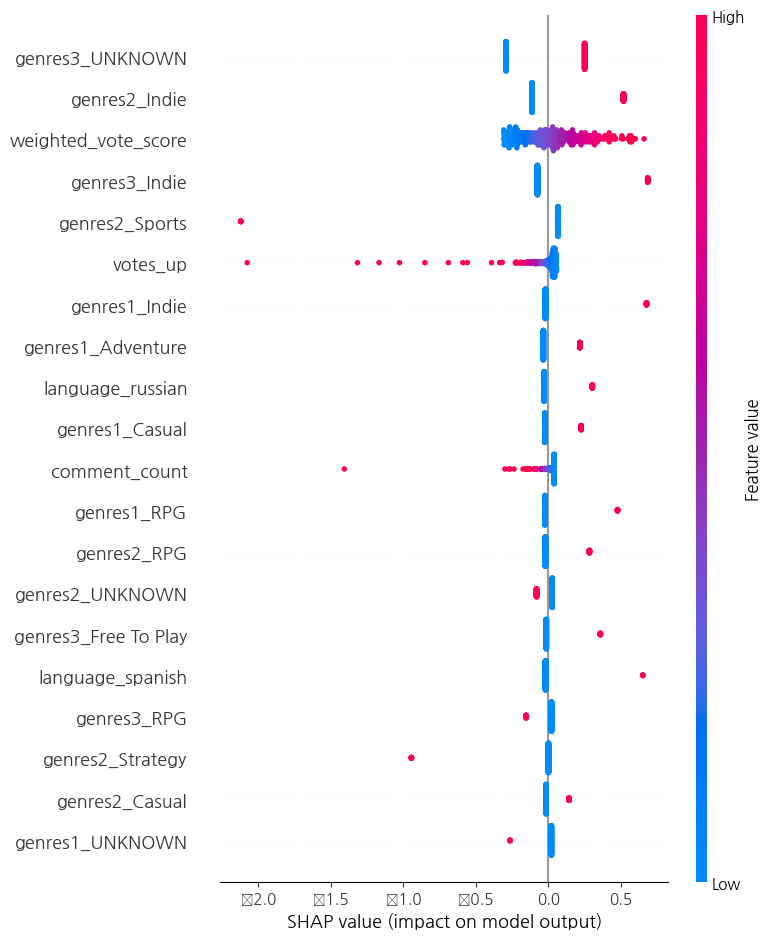

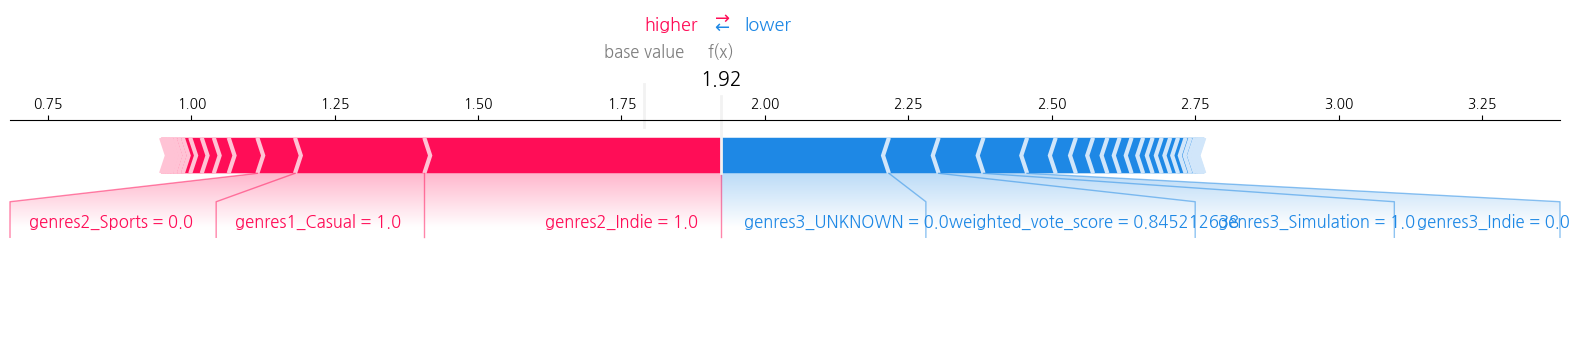

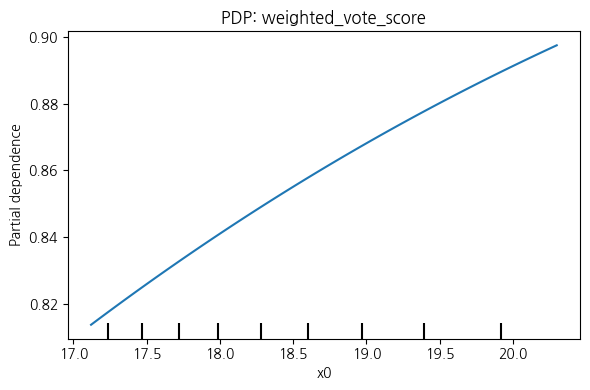


=== DONE ===
Tip) '오즈비(OR)>1'이면 양(+)의 효과, 'AME'는 확률 기준 평균 한계효과(예: +0.03 → +3%p).


In [ ]:
# -*- coding: utf-8 -*-
"""
Explainability-first pipeline: Logistic / GEE / GLMM-like + SHAP + PDP
- Target: voted_up (0/1)
- Cluster (for GEE / random intercept): appid
- Example CSV:/content/weighted_score_above_08_250922-2010pm.csv
"""

import os, re, warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

# Statsmodels for interpretable models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

# Sklearn for split/scale/encoding + SHAP/PDP compatibility
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import PartialDependenceDisplay

# SHAP
import shap
import matplotlib.pyplot as plt

# -----------------------------
# 1) CONFIG
# -----------------------------
# 1) 여기만 바꾸면 동작
CSV_PATH = "/content/weighted_score_above_08_250922-2010pm.csv"  # ← Colab 업로드 경로
TARGET = "voted_up"          # 0/1
CLUSTER_ID = "appid"         # 군집/랜덤효과용
ID_COLS = ["review_id"]      # 있으면 지정(없으면 자동 무시)
MAX_ONEHOT_PER_CAT = 10      # 범주형은 상위 k개만 one-hot, 나머지는 OTHER
TEST_SIZE = 0.2
RANDOM_STATE = 42

# 사용자가 보고 싶은 주요 설명변수 후보(있는 것만 사용)
PREFERRED_FEATURES = [
    "pos_rate", "weighted_vote_score", "votes_up", "comment_count",
    "author_playtime_forever", "author_num_games_owned", "early_access",
    "received_for_free", "language", "genres1", "genres2", "genres3"
]

# -----------------------------
# 2) LOAD
# -----------------------------
df = pd.read_csv(CSV_PATH)
print(f"[LOAD] rows={len(df):,}, cols={len(df.columns)}")
assert TARGET in df.columns, f"TARGET '{TARGET}' not in columns"
if CLUSTER_ID not in df.columns:
    # 안전장치: 없으면 가짜 군집으로 채움
    df[CLUSTER_ID] = "cluster_0"

# -----------------------------
# 3) FEATURE SELECTION (interpretable)
#    - 존재하는 것만 선택
#    - 수치/범주 분리
# -----------------------------
use_cols = [c for c in PREFERRED_FEATURES if c in df.columns]
# 타깃/클러스터 제외
use_cols = [c for c in use_cols if c not in [TARGET, CLUSTER_ID] + ID_COLS]

# dtype 기반 분리 (object→categorical, bool→categorical)
num_cols = [c for c in use_cols if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in use_cols if (df[c].dtype == "object" or pd.api.types.is_bool_dtype(df[c]))]

# 간단 정제
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
for c in cat_cols:
    df[c] = df[c].astype("object").fillna("UNKNOWN")

# 높은 카디널리티 범주형을 상위 K + OTHER로 축소(해석력 유지)
def topk_or_other(s: pd.Series, k=MAX_ONEHOT_PER_CAT):
    top = s.value_counts(dropna=False).index[:k]
    return s.where(s.isin(top), other="OTHER")

for c in cat_cols:
    df[c] = topk_or_other(df[c], k=MAX_ONEHOT_PER_CAT)

# 결측 제거(간단히)
df = df.dropna(subset=[TARGET] + num_cols)
df[TARGET] = df[TARGET].astype(int)

# -----------------------------
# 4) TRAIN / TEST SPLIT
# -----------------------------
X = df[num_cols + cat_cols].copy()
y = df[TARGET].copy()
groups = df[CLUSTER_ID].copy()

X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
    X, y, groups, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# -----------------------------
# 5) DESIGN MATRIX (statsmodels용)
#     - 해석력 위해: 수치 + 범주형 원-핫(기준범주 자동 형성)
# -----------------------------
X_all = pd.concat([X_train, X_test], axis=0)
dummies = pd.get_dummies(X_all[cat_cols], drop_first=True) if cat_cols else pd.DataFrame(index=X_all.index)
X_all_num = X_all[num_cols].copy()
X_dm = pd.concat([X_all_num, dummies], axis=1)
X_dm = sm.add_constant(X_dm, has_constant="add")

# train/test 분할 복원
X_dm_train = X_dm.loc[X_train.index]
X_dm_test  = X_dm.loc[X_test.index]

# -----------------------------
# 5-1) 디자인 매트릭스 정규화 (object → float64, NaN/Inf 처리)
#     ↑ X_dm_train / X_dm_test 만든 '바로 다음' 셀/줄에 추가하세요.
# -----------------------------
def normalize_design_matrix(X_train, X_test):
    # 1) object → numeric (coerce), Inf → NaN
    for X in (X_train, X_test):
        obj_cols = X.select_dtypes(include=["object"]).columns
        if len(obj_cols) > 0:
            # 숫자로 변환 불가한 값은 NaN으로
            X[obj_cols] = X[obj_cols].apply(pd.to_numeric, errors="coerce")
        X.replace([np.inf, -np.inf], np.nan, inplace=True)

    # 2) 학습 기준으로 '전부 NaN'이 된 컬럼 제거 (테스트도 맞춰서 제거)
    all_nan_cols = X_train.columns[X_train.isna().all(axis=0)]
    if len(all_nan_cols) > 0:
        X_train.drop(columns=all_nan_cols, inplace=True)
        X_test.drop(columns=[c for c in all_nan_cols if c in X_test.columns], inplace=True)

    # 3) 결측 채우기
    X_train.fillna(0.0, inplace=True)
    X_test.fillna(0.0, inplace=True)

    # 3-1) 분산 0 컬럼 제거 (단, const는 보존)
    nunique = X_train.nunique(dropna=True)
    zero_var_cols = nunique.index[(nunique <= 1) & (nunique.index != "const")]
    if len(zero_var_cols) > 0:
        X_train.drop(columns=zero_var_cols, inplace=True)
        X_test = X_test.reindex(columns=X_train.columns, fill_value=0.0)

    # 4) dtype
    X_train = X_train.astype("float64")
    X_test  = X_test.astype("float64")
    return X_train, X_test


# ✅ 여기서 호출 (X_dm_train / X_dm_test 만든 '직후')
X_dm_train, X_dm_test = normalize_design_matrix(X_dm_train, X_dm_test)

# (선택) y도 안전하게 숫자로 보장
y_train = pd.to_numeric(y_train, errors="coerce").fillna(0).astype(int)
y_test  = pd.to_numeric(y_test, errors="coerce").fillna(0).astype(int)


# -----------------------------
# 6) Logistic (statsmodels): 계수/오즈비/한계효과
# -----------------------------
logit_model = sm.Logit(y_train, X_dm_train)
logit_res = logit_model.fit(disp=False)

# 성능
proba_test = logit_res.predict(X_dm_test).clip(1e-6, 1-1e-6)
auc = roc_auc_score(y_test, proba_test)
ll  = log_loss(y_test, proba_test)
print("\n[Logistic] AUC=%.4f | LogLoss=%.4f" % (auc, ll))

# 계수/오즈비 요약
params = logit_res.params
conf = logit_res.conf_int()
summary_table = pd.DataFrame({
    "coef": params,
    "odds_ratio": np.exp(params),
    "ci_low(OR)": np.exp(conf[0]),
    "ci_high(OR)": np.exp(conf[1]),
    "p_value": logit_res.pvalues
})
summary_table = summary_table.sort_values("p_value")
print("\n[Logistic Coefficients → Odds Ratios]\n", summary_table.head(30))

# 평균 한계효과 (AME)
mfx = logit_res.get_margeff(at="overall").summary_frame()
print("\n[Average Marginal Effects]\n", mfx.head(30))

# -----------------------------
# 7) GEE (군집 상관 보정)
# -----------------------------
# 같은 디자인 매트릭스를 사용하되, 그룹은 g_train
gee_model = GEE(y_train, X_dm_train, groups=g_train, family=Binomial(), cov_struct=Exchangeable())
gee_res = gee_model.fit()
proba_test_gee = gee_res.predict(X_dm_test)
auc_gee = roc_auc_score(y_test, proba_test_gee)
ll_gee  = log_loss(y_test, proba_test_gee)
print("\n[GEE] AUC=%.4f | LogLoss=%.4f" % (auc_gee, ll_gee))
print("[GEE Coeff OR]\n", pd.DataFrame({
    "coef": gee_res.params,
    "odds_ratio": np.exp(gee_res.params),
    "p_value": gee_res.pvalues
}).sort_values("p_value").head(30))

# -----------------------------
# 8) GLMM-like (랜덤 절편: 게임별)
#    BinomialBayesMixedGLM: y ~ X, random_intercept per group
# -----------------------------
# 상위 그룹만 랜덤효과에 포함(메모리/수렴 안정화)
grp_counts = g_train.value_counts()
top_groups = set(grp_counts.index[:200])

Z_train = pd.get_dummies(g_train.where(g_train.isin(top_groups), other="OTHER"), drop_first=True)
Z_test  = pd.get_dummies(g_test.where(g_test.isin(top_groups),  other="OTHER"), drop_first=True)
Z_test  = Z_test.reindex(columns=Z_train.columns, fill_value=0)

# BinomialBayesMixedGLM은 X에서 상수항 제거 필요
drop_cols = [c for c in ["const"] if c in X_dm_train.columns]
X_glmm_train = X_dm_train.drop(columns=drop_cols)
X_glmm_test  = X_dm_test.drop(columns=drop_cols)

# 타입 통일
X_glmm_train = X_glmm_train.astype("float64")
X_glmm_test  = X_glmm_test.astype("float64")
Z_train = Z_train.astype("float64")
Z_test  = Z_test.astype("float64")

# === 핵심: exog_vc는 2D ndarray, ident 길이는 '열 수'와 동일해야 함 ===
exog    = X_glmm_train.values
exog_vc = Z_train.values                            # ✅ 리스트가 아니라 2D ndarray
ident   = np.zeros(exog_vc.shape[1], dtype=int)     # 모든 랜덤효과 열을 분산성분 0으로 묶기

# 방어: 랜덤효과 열이 0개면 GLMM 스킵
if exog_vc.shape[1] == 0:
    print("[GLMM] 랜덤효과 열이 없어 스킵합니다.")
else:
    model_glmm = BinomialBayesMixedGLM(y_train.values, exog, exog_vc, ident, vcp_p=1.0)
    glmm_res   = model_glmm.fit_vb()  # 변분근사

    # 고정효과만 사용한 예측
    # 로짓 스케일 원하면 linear=True, 확률 원하면 linear=False
    proba_test_glmm = model_glmm.predict(glmm_res.params, X_glmm_test.values, linear=False)

    auc_glmm = roc_auc_score(y_test, proba_test_glmm)
    ll_glmm  = log_loss(y_test, proba_test_glmm)
    print("\n[BinomialBayesMixedGLM] AUC=%.4f | LogLoss=%.4f" % (auc_glmm, ll_glmm))

    # 고정효과 요약
    glmm_fix = pd.DataFrame({
        "coef": glmm_res.params[:X_glmm_train.shape[1]],
        "odds_ratio": np.exp(glmm_res.params[:X_glmm_train.shape[1]])
    }, index=X_glmm_train.columns).sort_values("odds_ratio", ascending=False)
    print("\n[GLMM Fixed Effects OR]\n", glmm_fix.head(30))




# -----------------------------
# 9) SHAP (robust to Kernel/Linear)
# -----------------------------
rng = np.random.RandomState(RANDOM_STATE)
bg_n = min(1000, X_skl_train.shape[0])
te_n = min(300,   X_skl_test.shape[0])
bg_idx = rng.choice(X_skl_train.shape[0], size=bg_n, replace=False)
test_idx = rng.choice(X_skl_test.shape[0],  size=te_n, replace=False)

# 표준화 (train 기준)
scaler = StandardScaler(with_mean=False)
X_tr_scaled = scaler.fit_transform(X_skl_train)
X_te_scaled = scaler.transform(X_skl_test)

# 로지스틱 학습
clf = LogisticRegression(max_iter=200, solver="lbfgs")
clf.fit(X_tr_scaled, y_train)

# --- Explainer 선택: LinearExplainer 우선, 실패 시 KernelExplainer ---
shap_values = None
X_te_scaled_sub = X_te_scaled[test_idx]
X_plot = X_skl_test.reindex(columns=X_skl_train.columns).iloc[test_idx]  # 열 정렬 강제

try:
    # 선형모델에는 LinearExplainer가 빠르고 안정적
    explainer = shap.LinearExplainer(clf, X_tr_scaled[bg_idx], model_output="logit")
    sv = explainer.shap_values(X_te_scaled_sub)
    # 최신 shap에서는 explainer(...) 형태도 지원: sv = explainer(X_te_scaled_sub).values
    shap_values = sv
except Exception:
    # 커널로 폴백 (느림)
    explainer = shap.KernelExplainer(clf.predict_proba, X_tr_scaled[bg_idx])
    sv_list = explainer.shap_values(X_te_scaled_sub)
    # 이진분류면 [class0, class1] 반환 → class1 사용
    shap_values = sv_list[1] if isinstance(sv_list, list) else sv_list

# --- 형태 강제 점검: 열 수 일치 보장 ---
if isinstance(shap_values, list):
    # 혹시 다중클래스일 경우 첫 번째 클래스만 사용 (필요시 바꾸세요)
    shap_values = shap_values[0]
assert shap_values.shape[1] == X_plot.shape[1], \
    f"SHAP n_features {shap_values.shape[1]} != X_plot {X_plot.shape[1]}"

# --- 요약 플롯 ---
plt.figure()
shap.summary_plot(shap_values, X_plot, show=False)
plt.tight_layout()
plt.show()

# --- 국소(force) 예시 ---
example_i = 0
shap.plots.force(
    getattr(explainer, "expected_value", 0 if np.isscalar(getattr(explainer, "expected_value", 0)) else explainer.expected_value[1]),
    shap_values[example_i, :],
    X_plot.iloc[example_i, :],
    matplotlib=True,
    show=True
)


# -----------------------------
# 10) PDP (부분의존)
# -----------------------------
# PDP는 sklearn 모델 필요 → 위 clf 사용
# 중요한(연속) 변수 1~3개 지정 (존재하는 것만)
pdp_candidates = [c for c in ["pos_rate","weighted_vote_score","author_playtime_forever","votes_up"] if c in X_skl_train.columns]
if len(pdp_candidates) > 0:
    fig, ax = plt.subplots(figsize=(6,4))
    PartialDependenceDisplay.from_estimator(
        clf, X_skl_test_num, features=[list(X_skl_test.columns).index(pdp_candidates[0])], ax=ax
    )
    plt.title(f"PDP: {pdp_candidates[0]}")
    plt.tight_layout()
    plt.show()

print("\n=== DONE ===")
print("Tip) '오즈비(OR)>1'이면 양(+)의 효과, 'AME'는 확률 기준 평균 한계효과(예: +0.03 → +3%p).")


####머신러닝만 따로


[Logistic] AUC=0.6819 | LogLoss=0.3901

[Logistic Coefficients → Odds Ratios]
                                    coef  odds_ratio  ci_low(OR)  ci_high(OR)  \
genres2_Sports                -2.194690    0.111393    0.093380     0.132881   
weighted_vote_score            4.945435  140.532028   85.607343   230.695758   
votes_up                      -0.000352    0.999648    0.999606     0.999691   
genres3_Indie                  0.760254    2.138820    1.926853     2.374106   
genres2_Strategy              -0.947749    0.387612    0.338973     0.443231   
genres2_Indie                  0.632540    1.882386    1.720669     2.059302   
const                         -2.947143    0.052489    0.033825     0.081453   
genres1_Indie                  0.697577    2.008880    1.791611     2.252496   
comment_count                 -0.008929    0.991111    0.989594     0.992630   
genres3_UNKNOWN                0.541000    1.717723    1.560217     1.891130   
genres3_Massively Multiplayer -0.708987 

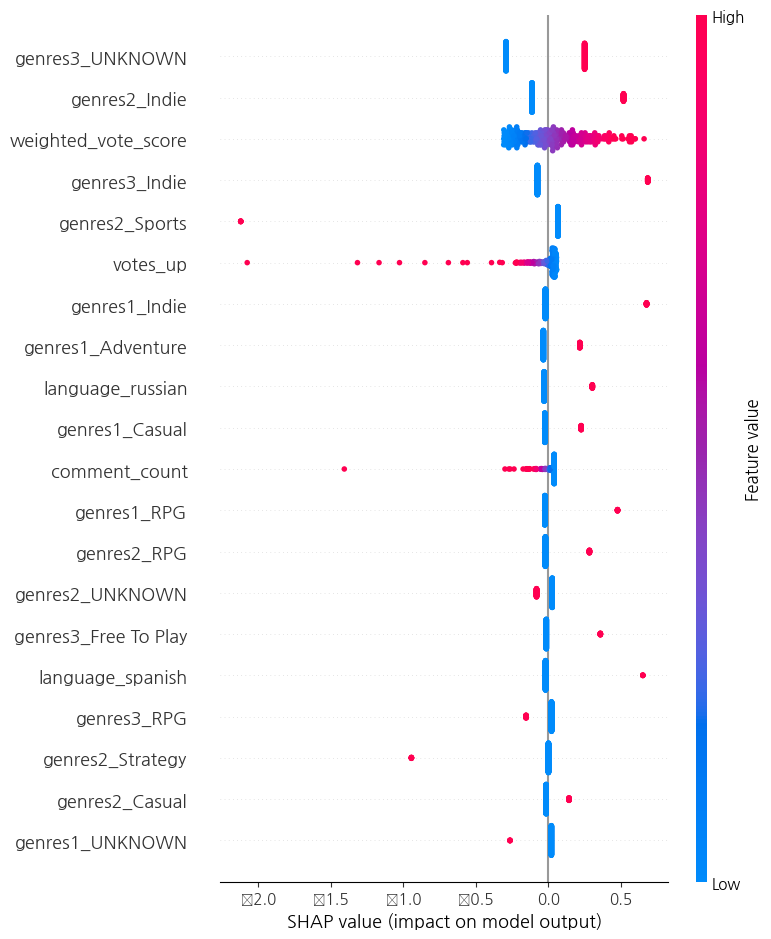

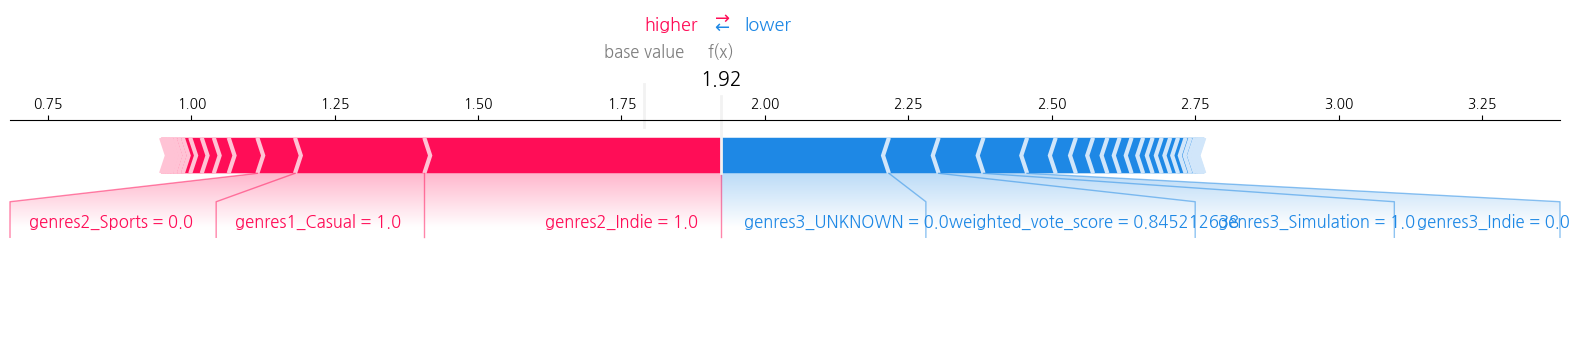

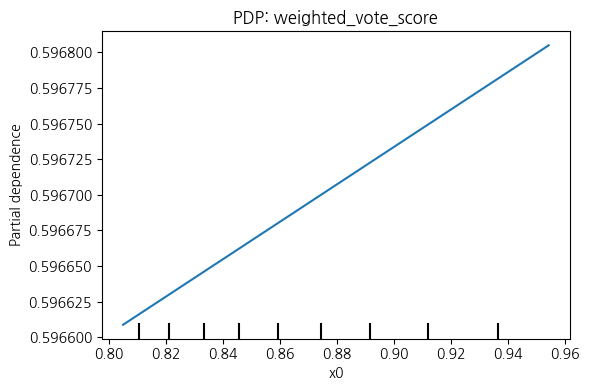


=== DONE (ML ONLY) ===
Tip) OR>1은 +효과, AME는 확률 기준 평균 한계효과(예:+0.03 → +3%p).


In [ ]:
# -----------------------------
# ML ONLY: Logistic / GEE / GLMM-like + SHAP + PDP
#   * Prereqs in scope:
#     - X_dm_train, X_dm_test: statsmodels 디자인 매트릭스(상수항 'const' 포함)
#     - y_train, y_test: 0/1 타깃 (pd.Series)
#     - g_train, g_test: 군집/그룹 ID (예: appid)
# -----------------------------
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import shap

# =========[ 공통: 안전 전처리 (타입/정합성) ]=========
# statsmodels 로그리트
logit_model = sm.Logit(y_train, X_dm_train.astype("float64"))
logit_res = logit_model.fit(disp=False)

# 테스트 성능
proba_test = logit_res.predict(X_dm_test.astype("float64")).clip(1e-6, 1-1e-6)
auc = roc_auc_score(y_test, proba_test)
ll  = log_loss(y_test, proba_test)
print("\n[Logistic] AUC=%.4f | LogLoss=%.4f" % (auc, ll))

# 계수/오즈비/유의성
params = logit_res.params
conf = logit_res.conf_int()
summary_table = pd.DataFrame({
    "coef": params,
    "odds_ratio": np.exp(params),
    "ci_low(OR)": np.exp(conf[0]),
    "ci_high(OR)": np.exp(conf[1]),
    "p_value": logit_res.pvalues
}).sort_values("p_value")
print("\n[Logistic Coefficients → Odds Ratios]\n", summary_table.head(30))

# 평균 한계효과 (AME)
mfx = logit_res.get_margeff(at="overall").summary_frame()
print("\n[Average Marginal Effects]\n", mfx.head(30))

# =========[ GEE (군집 상관 보정) ]=========
gee_model = GEE(y_train, X_dm_train.astype("float64"), groups=g_train, family=Binomial(), cov_struct=Exchangeable())
gee_res = gee_model.fit()
proba_test_gee = gee_res.predict(X_dm_test.astype("float64"))
auc_gee = roc_auc_score(y_test, proba_test_gee)
ll_gee  = log_loss(y_test, proba_test_gee)
print("\n[GEE] AUC=%.4f | LogLoss=%.4f" % (auc_gee, ll_gee))
print("[GEE Coeff OR]\n", pd.DataFrame({
    "coef": gee_res.params,
    "odds_ratio": np.exp(gee_res.params),
    "p_value": gee_res.pvalues
}).sort_values("p_value").head(30))

# =========[ GLMM-like (BinomialBayesMixedGLM, 랜덤 절편) ]=========
# 상위 그룹 n개만 랜덤효과 포함(메모리/수렴 안정화)
grp_counts = g_train.value_counts()
top_groups = set(grp_counts.index[:200])

Z_train = pd.get_dummies(g_train.where(g_train.isin(top_groups), other="OTHER"), drop_first=True)
Z_test  = pd.get_dummies(g_test.where(g_test.isin(top_groups),  other="OTHER"), drop_first=True)
Z_test  = Z_test.reindex(columns=Z_train.columns, fill_value=0)

# GLMM은 X에서 상수항 제거 필요
drop_cols = [c for c in ["const"] if c in X_dm_train.columns]
X_glmm_train = X_dm_train.drop(columns=drop_cols).astype("float64")
X_glmm_test  = X_dm_test.drop(columns=drop_cols).astype("float64")
Z_train = Z_train.astype("float64")
Z_test  = Z_test.astype("float64")

exog    = X_glmm_train.values
exog_vc = Z_train.values
ident   = np.zeros(exog_vc.shape[1], dtype=int) if exog_vc.shape[1] > 0 else np.array([], dtype=int)

if exog_vc.shape[1] == 0:
    print("[GLMM] 랜덤효과 열이 없어 스킵합니다.")
else:
    model_glmm = BinomialBayesMixedGLM(y_train.values, exog, exog_vc, ident, vcp_p=1.0)
    glmm_res   = model_glmm.fit_vb()
    proba_test_glmm = model_glmm.predict(glmm_res.params, X_glmm_test.values, linear=False)
    auc_glmm = roc_auc_score(y_test, proba_test_glmm)
    ll_glmm  = log_loss(y_test, proba_test_glmm)
    print("\n[BinomialBayesMixedGLM] AUC=%.4f | LogLoss=%.4f" % (auc_glmm, ll_glmm))

    glmm_fix = pd.DataFrame({
        "coef": glmm_res.params[:X_glmm_train.shape[1]],
        "odds_ratio": np.exp(glmm_res.params[:X_glmm_train.shape[1]])
    }, index=X_glmm_train.columns).sort_values("odds_ratio", ascending=False)
    print("\n[GLMM Fixed Effects OR]\n", glmm_fix.head(30))

# =========[ SHAP (선형 우선, 실패 시 커널) ]=========
# sklearn용 입력(상수항 제거)
X_skl_train = X_dm_train.drop(columns=[c for c in ["const"] if c in X_dm_train.columns]).astype("float64")
X_skl_test  = X_dm_test.drop(columns=[c for c in ["const"] if c in X_dm_test.columns]).astype("float64")

RANDOM_STATE = 42
rng = np.random.RandomState(RANDOM_STATE)
bg_n = min(1000, X_skl_train.shape[0])
te_n = min(300,   X_skl_test.shape[0])
bg_idx = rng.choice(X_skl_train.shape[0], size=bg_n, replace=False)
test_idx = rng.choice(X_skl_test.shape[0],  size=te_n, replace=False)

# 표준화(희소 아님: with_mean=True 가능, 하지만 안전하게 False 유지)
scaler = StandardScaler(with_mean=False)
X_tr_scaled = scaler.fit_transform(X_skl_train.values)
X_te_scaled = scaler.transform(X_skl_test.values)

clf = LogisticRegression(max_iter=200, solver="lbfgs")
clf.fit(X_tr_scaled, y_train)

X_te_scaled_sub = X_te_scaled[test_idx]
X_plot = X_skl_test.iloc[test_idx].copy()  # SHAP plot용 원본 스케일 특징

try:
    explainer = shap.LinearExplainer(clf, X_tr_scaled[bg_idx], model_output="logit")
    shap_values = explainer.shap_values(X_te_scaled_sub)
except Exception:
    explainer = shap.KernelExplainer(clf.predict_proba, X_tr_scaled[bg_idx])
    sv_list = explainer.shap_values(X_te_scaled_sub)
    shap_values = sv_list[1] if isinstance(sv_list, list) else sv_list

if isinstance(shap_values, list):
    shap_values = shap_values[0]

assert shap_values.shape[1] == X_plot.shape[1], \
    f"SHAP n_features {shap_values.shape[1]} != X_plot {X_plot.shape[1]}"

plt.figure()
shap.summary_plot(shap_values, X_plot, show=False)
plt.tight_layout()
plt.show()

# 국소(force) 예시
example_i = 0
base_val = getattr(explainer, "expected_value", 0)
if not np.isscalar(base_val):
    # 이진분류일 때 class1 기준
    base_val = base_val[1] if len(base_val) > 1 else base_val[0]
shap.plots.force(base_val, shap_values[example_i, :], X_plot.iloc[example_i, :],
                 matplotlib=True, show=True)

# =========[ PDP (부분의존) ]=========
# PDP는 sklearn 모델과 원-스케일 특징 인덱스가 필요
pdp_candidates = [c for c in ["pos_rate","weighted_vote_score",
                              "author_playtime_forever","votes_up"]
                  if c in X_skl_train.columns]

if len(pdp_candidates) > 0:
    # 첫 후보 1개만 예시
    feat_name = pdp_candidates[0]
    feat_idx = list(X_skl_test.columns).index(feat_name)

    fig, ax = plt.subplots(figsize=(6,4))
    PartialDependenceDisplay.from_estimator(
        clf, X_skl_test.values, features=[feat_idx], ax=ax
    )
    ax.set_title(f"PDP: {feat_name}")
    plt.tight_layout()
    plt.show()

print("\n=== DONE (ML ONLY) ===")
print("Tip) OR>1은 +효과, AME는 확률 기준 평균 한계효과(예:+0.03 → +3%p).")


###성능 개선 모델

In [ ]:
pip install pandas numpy scikit-learn imbalanced-learn optuna lightgbm xgboost catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.9 MB/s eta 0:00:00


In [ ]:
# -*- coding: utf-8 -*-
import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from typing import Optional, List, Tuple, Dict
from datetime import datetime

# ==== 설정영역 ==============================================
# Colab에서 파일이 /content에 있다면 ↓ 그대로 사용
DATA_PATH = "/content/weighted_score_above_08_250922-2010pm.csv"

# (이 세션에서 돌릴 땐)
# DATA_PATH = "/mnt/data/weighted_score_above_08_250922-2010pm.csv"

TARGET    = "voted_up"        # 이진 타깃(0/1)
DATETIME  = None              # 시계열 CV 안 쓰면 None
# 텍스트 원문/URL/ID 성격의 컬럼은 모델 성능·속도에 악영향이 크므로 제외 권장
ID_COLS   = [
    "review", "review_text", "review_body", "review_raw",  # 자유서술 텍스트
    "review_html", "review_url",                           # HTML/URL
    "review_id", "review_id_str", "author_steamid",        # 고유 ID류
]

# 수동 지정이 꼭 필요할 때만 쓰세요(자동 추론 기본)
USER_CAT  = []  # 예: ["language", "genres1", "genres2"]
USER_NUM  = []  # 예: ["weighted_vote_score", "votes_up", "playtime_forever"]

CV_TYPE   = "stratified"      # 시계열이면 "timeseries" + DATETIME="date_col"
N_FOLDS   = 5
N_TRIALS  = 40                # 속도 여유되면 80~200까지 ↑

# 불균형 크면 먼저 re-weighting(모델 파라미터) → 그래도 부족하면 SMOTE
USE_SMOTE = False
STACKING  = True              # LGBM/XGB/CatBoost 스태킹 실행

SEED      = 42
# ============================================================


# ---- 유틸
def infer_column_types(df, target, id_cols, user_cat, user_num):
    cols = [c for c in df.columns if c not in [target] + id_cols]
    cat_cols, num_cols = [], []
    for c in cols:
        if c in user_cat:
            cat_cols.append(c)
        elif c in user_num:
            num_cols.append(c)
        else:
            if pd.api.types.is_numeric_dtype(df[c]):
                num_cols.append(c)
            else:
                cat_cols.append(c)
    return cat_cols, num_cols

def train_valid_split_time(df, dt_col, n_folds=5):
    # 단순 시계열 KFold: 시간순으로 균등분할
    df_sorted = df.sort_values(dt_col).reset_index(drop=True)
    fold_sizes = np.full(n_folds, len(df_sorted) // n_folds, dtype=int)
    fold_sizes[: len(df_sorted) % n_folds] += 1
    current = 0
    indices = np.arange(len(df_sorted))
    folds = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        folds.append(indices[start:stop])
        current = stop
    # progressive expanding split
    splits = []
    for k in range(1, n_folds):
        train_idx = np.concatenate(folds[:k])
        valid_idx = folds[k]
        splits.append((train_idx, valid_idx))
    return df_sorted, splits

# ---- 파이프라인 구성요소
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, log_loss, average_precision_score

from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.model_selection import cross_validate

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import optuna

# 모델들
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

def build_preprocessor(cat_cols: List[str], num_cols: List[str]):
    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("log1p", FunctionTransformer(lambda x: np.log1p(np.clip(x, a_min=0, a_max=None)), feature_names_out="one-to-one")),
        ("scaler", StandardScaler(with_mean=False))
    ])
    from sklearn.preprocessing import OneHotEncoder

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(
        handle_unknown="ignore",
        min_frequency=20,
        sparse_output=True   # ← sparse 대신 sparse_output
        ))
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop",
        sparse_threshold=1.0
    )
    return pre

def make_cv(y):
    if CV_TYPE == "timeseries":
        # timeseries는 외부에서 splits를 넘겨줍니다.
        return None
    else:
        return StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

def evaluate_cv(model, X, y, cv_splits=None):
    # 공통 지표: ROC-AUC, LogLoss, PR-AUC
    if cv_splits is None:
        cv = make_cv(y)
        scoring = {
            "auc":"roc_auc",
            "logloss":"neg_log_loss",
            "prauc":"average_precision"
        }
        out = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_estimator=False)
        res = {
            "AUC(mean)": float(np.mean(out["test_auc"])),
            "LogLoss(mean)": float(-np.mean(out["test_logloss"])),
            "PR-AUC(mean)": float(np.mean(out["test_prauc"]))
        }
        return res
    else:
        # explicit splits (timeseries)
        aucs, lls, pras = [], [], []
        for tr_idx, va_idx in cv_splits:
            model_ = model
            model_.fit(X[tr_idx], y[tr_idx])
            proba = model_.predict_proba(X[va_idx])[:,1]
            aucs.append(roc_auc_score(y[va_idx], proba))
            lls.append(log_loss(y[va_idx], proba, labels=[0,1]))
            pras.append(average_precision_score(y[va_idx], proba))
        return {
            "AUC(mean)": float(np.mean(aucs)),
            "LogLoss(mean)": float(np.mean(lls)),
            "PR-AUC(mean)": float(np.mean(pras))
        }

# ---- Optuna 튜닝 (각 모델별)
def tune_lgbm(X, y, cat_cols_len, cv_splits=None):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 1500),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 15, 255),
            "max_depth": trial.suggest_int("max_depth", 3, 16),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 120),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
            "random_state": SEED,
            "objective": "binary",
            "n_jobs": -1
        }
        clf = lgb.LGBMClassifier(**params)
        if cv_splits is None:
            cv = make_cv(y)
            scores = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
        else:
            scores = []
            for tr, va in cv_splits:
                clf.fit(X[tr], y[tr])
                proba = clf.predict_proba(X[va])[:,1]
                scores.append(roc_auc_score(y[va], proba))
        return float(np.mean(scores))
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False)
    return study.best_params

def tune_xgb(X, y, cv_splits=None):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 300, 2000),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 16),
            "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 20.0, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 10.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
            "random_state": SEED,
            "eval_metric": "auc",
            "tree_method": "hist",
            "n_jobs": -1,
            "objective": "binary:logistic",
            "max_cat_to_onehot": 256,  # safety
        }
        clf = XGBClassifier(**params)
        if cv_splits is None:
            cv = make_cv(y)
            scores = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
        else:
            scores = []
            for tr, va in cv_splits:
                clf.fit(X[tr], y[tr])
                proba = clf.predict_proba(X[va])[:,1]
                scores.append(roc_auc_score(y[va], proba))
        return float(np.mean(scores))
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False)
    return study.best_params

def tune_cat(X, y, cv_splits=None):
    def objective(trial):
        params = {
            "depth": trial.suggest_int("depth", 4, 12),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 50.0, log=True),
            "iterations": trial.suggest_int("iterations", 500, 2500),
            "random_state": SEED,
            "loss_function": "Logloss",
            "eval_metric": "AUC",
            "verbose": 0,
            "allow_writing_files": False,
        }
        clf = CatBoostClassifier(**params)
        if cv_splits is None:
            cv = make_cv(y)
            scores = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
        else:
            scores = []
            for tr, va in cv_splits:
                clf.fit(X[tr], y[tr])
                proba = clf.predict_proba(X[va])[:,1]
                scores.append(roc_auc_score(y[va], proba))
        return float(np.mean(scores))
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False)
    return study.best_params

# ---- 메인 실행
def main():
    df = pd.read_csv(DATA_PATH)
    assert TARGET in df.columns, f"TARGET '{TARGET}' not in columns."
    if DATETIME is not None:
        assert DATETIME in df.columns, f"DATETIME '{DATETIME}' not in columns."

    # 타입 추론
    cat_cols, num_cols = infer_column_types(df, TARGET, ID_COLS + ([DATETIME] if DATETIME else []), USER_CAT, USER_NUM)

    # 입력/타깃
    y = df[TARGET].astype(int).values
    X_df = df.drop(columns=[TARGET] + ID_COLS, errors="ignore")
    if DATETIME is not None:
        X_df = X_df.sort_values(DATETIME)
    # 전처리
    pre = build_preprocessor(cat_cols, num_cols)

    # SMOTE 파이프라인 여부
    if USE_SMOTE:
        # SMOTE는 수치특징 공간에서 동작. OHE 후엔 고차원이므로 비용↑
        # 여기서는 간단히 전처리→SMOTE→모델 순서. (대규모 OHE 시 시간 증가 유의)
        def make_pipe(estimator):
            return ImbPipeline(steps=[("pre", pre), ("smote", SMOTE(random_state=SEED)), ("clf", estimator)])
    else:
        def make_pipe(estimator):
            return Pipeline(steps=[("pre", pre), ("clf", estimator)])

    # CV 스플릿 준비
    if CV_TYPE == "timeseries" and DATETIME is not None:
        df_sorted, splits = train_valid_split_time(df, DATETIME, n_folds=N_FOLDS)
        # 전처리 일관성 위해 정렬 반영
        X_df = df_sorted.drop(columns=[TARGET] + ID_COLS)
        y = df_sorted[TARGET].astype(int).values
        cv_splits = splits
    else:
        cv_splits = None

    # 전처리만 먼저 피팅하여 희소매트릭스 확보 (튜닝 속도 ↑)
    X_mat = pre.fit_transform(X_df)
    # lightgbm/xgboost/catboost는 내부에서 전처리를 다시 못 쓰니 파이프라인로 평가할 것
    # 다만 하이퍼파라미터 탐색은 전처리 완료된 행렬로 직접(=파이프라인 없이) 돌리면 속도↑이지만
    # 일관성 위해 여기선 파이프라인 그대로 CV를 돌립니다.

    # ---- LightGBM 튜닝
    lgb_best = tune_lgbm(X_mat, y, cat_cols_len=len(cat_cols), cv_splits=cv_splits)
    lgb_clf  = lgb.LGBMClassifier(**lgb_best, objective="binary", random_state=SEED, n_jobs=-1)
    lgb_pipe = make_pipe(lgb_clf)
    lgb_res  = evaluate_cv(lgb_pipe, X_mat, y, cv_splits=cv_splits)

    # ---- XGBoost 튜닝
    xgb_best = tune_xgb(X_mat, y, cv_splits=cv_splits)
    xgb_clf  = XGBClassifier(**xgb_best, objective="binary:logistic", random_state=SEED, n_jobs=-1, tree_method="hist", eval_metric="auc")
    xgb_pipe = make_pipe(xgb_clf)
    xgb_res  = evaluate_cv(xgb_pipe, X_mat, y, cv_splits=cv_splits)

    # ---- CatBoost 튜닝
    cat_best = tune_cat(X_mat, y, cv_splits=cv_splits)
    cat_clf  = CatBoostClassifier(**cat_best, loss_function="Logloss", random_state=SEED, verbose=0, allow_writing_files=False)
    cat_pipe = make_pipe(cat_clf)
    cat_res  = evaluate_cv(cat_pipe, X_mat, y, cv_splits=cv_splits)

    results = {
        "LightGBM": {"best_params": lgb_best, "cv": lgb_res},
        "XGBoost":  {"best_params": xgb_best, "cv": xgb_res},
        "CatBoost": {"best_params": cat_best, "cv": cat_res},
    }

    print("=== Base Models (CV) ===")
    print(json.dumps(results, indent=2))

    # ---- 스태킹 (Base 3개 → 메타 로지스틱)
    if STACKING:
        from sklearn.ensemble import StackingClassifier
        from sklearn.linear_model import LogisticRegression

        base_estimators = [
            ("lgb", lgb.LGBMClassifier(**lgb_best, objective="binary", random_state=SEED, n_jobs=-1)),
            ("xgb", XGBClassifier(**xgb_best, objective="binary:logistic", random_state=SEED, n_jobs=-1, tree_method="hist", eval_metric="auc")),
            ("cat", CatBoostClassifier(**cat_best, loss_function="Logloss", random_state=SEED, verbose=0, allow_writing_files=False)),
        ]
        meta = LogisticRegression(max_iter=200, solver="lbfgs")

        # 전처리 공유 + 각 모델은 파이프라인 내부에서 학습
        # 간단 구현: 전처리 후 stacking은 그대로 probability 기반
        # (정석은 각 base를 파이프라인로 감싼 후 FeatureUnion처럼 합치지만,
        #  여기선 전처리 한 번 + 스태킹 내부 CV 사용)
        # => 전처리 결과(X_mat)를 활용하기 위해 각 base를 "pre 없는" 모델로 구성하고,
        #    스태킹을 전처리 외부에서 수행.
        # 다만 scikit-learn StackingClassifier는 입력 X를 그대로 넘기므로,
        # 전처리 포함된 파이프라인을 감싼 버전으로 구성:
        base_pipes = [(name, make_pipe(model)) for name, model in base_estimators]

        stack = StackingClassifier(
            estimators=base_pipes,
            final_estimator=meta,
            stack_method="predict_proba",
            n_jobs=-1,
            passthrough=False,
            cv=make_cv(y) if cv_splits is None else N_FOLDS-1  # timeseries일 땐 숫자 CV
        )

        stack_res = evaluate_cv(stack, X_mat, y, cv_splits=cv_splits)
        print("\n=== Stacking (CV) ===")
        print(json.dumps(stack_res, indent=2))

        # 최종 모델 저장 (전처리 포함 파이프라인 보존)
        import joblib
        joblib.dump({"pre": pre, "lgb": lgb_pipe, "xgb": xgb_pipe, "cat": cat_pipe, "stack": stack}, "_models_ensemble.joblib")
        with open("_cv_results.json", "w", encoding="utf-8") as f:
            json.dump({"base": results, "stack": stack_res}, f, ensure_ascii=False, indent=2)
        print("\nSaved: _models_ensemble.joblib, _cv_results.json")
    else:
        import joblib
        joblib.dump({"pre": pre, "lgb": lgb_pipe, "xgb": xgb_pipe, "cat": cat_pipe}, "_models_base.joblib")
        with open("_cv_results.json", "w", encoding="utf-8") as f:
            json.dump({"base": results}, f, ensure_ascii=False, indent=2)
        print("\nSaved: _models_base.joblib, _cv_results.json")

if __name__ == "__main__":
    main()


[I 2025-09-23 06:16:28,306] A new study created in memory with name: no-name-e7a47c87-40e7-4b32-a6ff-061e23c8a401
[I 2025-09-23 06:20:49,101] Trial 0 finished with value: 0.9033844237408732 and parameters: {'n_estimators': 1216, 'learning_rate': 0.1571297864530346, 'num_leaves': 64, 'max_depth': 15, 'min_child_samples': 19, 'subsample': 0.7656398663545048, 'colsample_bytree': 0.9571895029260369, 'reg_alpha': 6.459661875527719e-07, 'reg_lambda': 0.00039203989098662823}. Best is trial 0 with value: 0.9033844237408732.
[I 2025-09-23 06:21:42,939] Trial 1 finished with value: 0.7746305861520965 and parameters: {'n_estimators': 479, 'learning_rate': 0.004273224270904248, 'num_leaves': 46, 'max_depth': 3, 'min_child_samples': 110, 'subsample': 0.9725487362899337, 'colsample_bytree': 0.6803570796682894, 'reg_alpha': 1.979024533594739e-05, 'reg_lambda': 0.01105276267435196}. Best is trial 0 with value: 0.9033844237408732.
[I 2025-09-23 06:27:05,325] Trial 2 finished with value: 0.8408442908071

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_indexing.py", line 341, in _get_column_indices
    all_columns = X.columns
                  ^^^^^^^^^
AttributeError: 'csr_matrix' object has no attribute 'columns'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 588, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py", line 993, in fit_transform
    self._validate_column_callables(X)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py", line 552, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_indexing.py", line 343, in _get_column_indices
    raise ValueError(
ValueError: Specifying the columns using strings is only supported for dataframes.


----------------------------------------------------------------

#통합데이터셋

In [ ]:
path = '/content/weighted_score_above_08_250924.csv'

df = pd.read_csv(
    path,
    engine="python",
    on_bad_lines="skip"   # skip malformed rows
)



In [ ]:
# -*- coding: utf-8 -*-
import os, re, json, argparse
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

def log1p_clip(x): return np.log1p(np.clip(x, a_min=0, a_max=None))
def exists(df, cols): return all(c in df.columns for c in cols)
def safe_pct(num, den):
    num = num if pd.notnull(num) else 0.0
    den = den if pd.notnull(den) and den != 0 else np.nan
    return num/den if pd.notnull(den) else np.nan

def roman_tail_strip(name):
    if not isinstance(name, str): return name
    s = re.sub(r'\b(Remastered|Definitive|HD|VR|Ultimate|Complete|Edition|Remake|Redux)\b', '', name, flags=re.I)
    s = re.sub(r'[\-\:–—]\s*.*$', '', s)
    s = re.sub(r'\b(\d{1,2}|[IVX]{1,5})\b', '', s)
    s = re.sub(r'\s+', ' ', s).strip().lower()
    return s

def nb_glm(y, X, add_constant=True):
    if add_constant: X = sm.add_constant(X, has_constant='add')
    return sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

def ols(y, X, add_constant=True):
    if add_constant: X = sm.add_constant(X, has_constant='add')
    return sm.OLS(y, X).fit()

def bootstrap_indirect(df, a_formula, b_formula, mediator, treat, outcome, n_boot=300, seed=123):
    rng = np.random.default_rng(seed); vals=[]
    for _ in range(n_boot):
        samp = df.sample(len(df), replace=True, random_state=rng.integers(0, 1e9))
        try:
            a = smf.ols(a_formula, data=samp).fit()
            b = smf.ols(b_formula, data=samp).fit()
            vals.append(a.params.get(treat, np.nan) * b.params.get(mediator, np.nan))
        except Exception:
            vals.append(np.nan)
    s = pd.Series(vals).dropna()
    if len(s)==0: return np.nan, (np.nan, np.nan)
    lo, hi = np.quantile(s, [0.025, 0.975])
    return float(s.mean()), (float(lo), float(hi))

def run_pipeline(csv_path, outdir):
    os.makedirs(outdir, exist_ok=True)
    df = pd.read_csv(csv_path, engine="python", on_bad_lines="skip")
    orig_rows, orig_cols = df.shape

    appid_col = next((c for c in ['appid','app_id'] if c in df.columns), None)
    name_col  = next((c for c in ['app_name','title'] if c in df.columns), None)
    pos_flag  = next((c for c in ['voted_up','recommend','is_positive'] if c in df.columns), None)
    comment_col = 'comment_count' if 'comment_count' in df.columns else None
    wscore_col  = 'weighted_vote_score' if 'weighted_vote_score' in df.columns else None
    ctrls = [c for c in ['author_playtime_forever','author_num_games_owned','author_num_reviews'] if c in df.columns]

    # 타입 정리
    for c in [col for col in ['votes_up','votes_funny', comment_col] if col and col in df.columns]:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    results = {}

    # ---------- A) 리뷰 단위: votes_* -> comment_count ----------
    if comment_col and exists(df, ['votes_up','votes_funny', comment_col]):
        cols_for_a = [appid_col, name_col, 'votes_up', 'votes_funny', comment_col] + ctrls
        cols_for_a = [c for c in cols_for_a if c and c in df.columns]  # ✅ None/미존재 제거
        dfa = df[cols_for_a].dropna(subset=['votes_up','votes_funny', comment_col])

        X_a = pd.DataFrame({
            'log_votes_up': np.log1p(np.clip(dfa['votes_up'], 0, None)),
            'log_votes_funny': np.log1p(np.clip(dfa['votes_funny'], 0, None)),
        }, index=dfa.index)
        for c in ctrls:
            X_a[c] = np.log1p(np.clip(pd.to_numeric(dfa[c], errors='coerce'), 0, None))

        y_a = dfa[comment_col]
        try:
            fit_a = nb_glm(y_a, X_a)
            results['A_review_to_diffusion'] = {
                'n': int(len(dfa)),
                'params': fit_a.params.to_dict(),
                'pvalues': fit_a.pvalues.to_dict(),
                'aic': float(fit_a.aic)
            }
        except Exception as e:
            results['A_review_to_diffusion_error'] = str(e)
    else:
        results['A_review_to_diffusion_skipped'] = "필요 컬럼 부족 (votes_up, votes_funny, comment_count)."

    # ---------- B) 게임 집계 ----------
    agg = {}
    if pos_flag:  agg['pos_reviews'] = (pos_flag, 'sum'); agg['n_reviews'] = (pos_flag, 'count')
    if wscore_col: agg['mean_wscore'] = (wscore_col, 'mean')
    if 'votes_up' in df.columns: agg['sum_votes_up'] = ('votes_up', 'sum')
    if 'votes_funny' in df.columns: agg['sum_votes_funny'] = ('votes_funny', 'sum')
    if comment_col: agg['sum_comments'] = (comment_col, 'sum')

    if appid_col:
        group_cols = [appid_col] + ([name_col] if name_col else [])
        game = df.groupby(group_cols).agg(**agg).reset_index()
        if {'pos_reviews','n_reviews'}.issubset(game.columns):
            game['pos_rate'] = game.apply(lambda r: (r['pos_reviews']/r['n_reviews']) if r['n_reviews'] else np.nan, axis=1)
        else:
            game['pos_rate'] = np.nan
        game['log_reviews']  = np.log1p(game['n_reviews'])   if 'n_reviews' in game.columns  else np.nan
        game['log_comments'] = np.log1p(game['sum_comments']) if 'sum_comments' in game.columns else np.nan
    else:
        game = pd.DataFrame()

        # 프랜차이즈/정렬키 (안전화)
    def _build_rel_key(game_df, src_df, appid_col):
        # rel_key 우선순위: release_year(중앙값) → release_date(첫 값) → appid 자체
        rel = None
        if 'release_year' in src_df.columns:
            year_map = src_df.groupby(appid_col)['release_year'] \
                             .agg(lambda s: pd.to_numeric(s, errors='coerce').dropna().median()) \
                             .to_dict()
            rel = game_df[appid_col].map(year_map)
            # 모두 NaN이면 무의미하므로 다음 옵션으로
            if pd.isna(rel).all():
                rel = None

        if rel is None and 'release_date' in src_df.columns:
            date_map = src_df.groupby(appid_col)['release_date'].agg('first').to_dict()
            rel = pd.to_datetime(game_df[appid_col].map(date_map), errors='coerce')
            if pd.isna(rel).all():
                rel = None

        if rel is None:
            rel = game_df[appid_col]  # 최후의 수단

        return rel

    if not game.empty:
        # 1) franchise_id: 타이틀명이 있으면 정규화, 없으면 appid 기준(각각 단일 프랜차이즈 취급)
        if name_col and (name_col in game.columns):
            game['franchise_id'] = game[name_col].apply(roman_tail_strip)
        else:
            # title이 없으면 appid를 프랜차이즈로 써서 "시차 회귀"는 자연히 불필요(표본 부족)로 스킵됨
            game['franchise_id'] = game[appid_col].astype(str)

        # 2) rel_key: 항상 생성 (name_col 유무와 무관)
        game['rel_key'] = _build_rel_key(game, df, appid_col)
    else:
        game['franchise_id'] = np.nan
        game['rel_key'] = np.nan

    # 시차 변수(prev_*): 안전 가드 추가
    fr_ready = False
    if not game.empty and {'franchise_id','rel_key', appid_col}.issubset(game.columns):
        # 전처리: 유효한 franchise_id/rel_key만 유지
        g2 = game.dropna(subset=['franchise_id', 'rel_key']).copy()

        # g2가 비었으면 추가 작업 스킵
        if not g2.empty:
            # 정렬 시도 전에 컬럼 존재 보장
            sort_cols = [c for c in ['franchise_id','rel_key', appid_col] if c in g2.columns]
            if sort_cols:
                g2.sort_values(sort_cols, inplace=True)

            for col in ['mean_wscore','pos_rate','log_reviews','sum_votes_up','sum_votes_funny']:
                if col in g2.columns:
                    g2[f'prev_{col}'] = g2.groupby('franchise_id', dropna=False)[col].shift(1)

            outcome_y = [c for c in ['log_reviews','mean_wscore'] if c in g2.columns]
            feature_x = [c for c in g2.columns if c.startswith('prev_')]

            # 최소 표본 체크 (프랜차이즈 단위 시차회귀가 의미 있으려면 전작이 존재해야 함)
            fr_ready = bool(outcome_y and feature_x and (len(g2.dropna(subset=outcome_y)) >= 30))
        else:
            g2 = pd.DataFrame(); outcome_y = []; feature_x = []
    else:
        g2 = pd.DataFrame(); outcome_y = []; feature_x = []


    # 차기작 회귀
    if fr_ready:
        results['B_next_title_regressions'] = {}
        for y in outcome_y:
            Xb_cols = [c for c in feature_x if c != 'prev_log_comments']
            dat = g2.dropna(subset=[y] + Xb_cols).copy()
            if len(dat) >= 30:
                try:
                    fit_b = ols(dat[y], dat[Xb_cols])
                    results['B_next_title_regressions'][y] = {
                        'n': int(len(dat)),
                        'params': fit_b.params.to_dict(),
                        'pvalues': fit_b.pvalues.to_dict(),
                        'r2': float(fit_b.rsquared),
                        'adj_r2': float(fit_b.rsquared_adj),
                        'aic': float(fit_b.aic),
                        'bic': float(fit_b.bic)
                    }
                except Exception as e:
                    results['B_next_title_regressions'][y] = {'error': str(e)}
            else:
                results['B_next_title_regressions'][y] = {'skipped': '표본 부족(<30)'}
    else:
        results['B_next_title'] = '프랜차이즈 시차 특성 구성 불가(타이틀명/정렬키/컬럼 부족).'

    # ---------- C) 매개효과 ----------
    med = {}
    if fr_ready and 'prev_mean_wscore' in g2.columns and g2['prev_mean_wscore'].notna().any():
        for y in outcome_y:
            tmp = g2.copy()
            if 'prev_sum_votes_up' in tmp.columns:     tmp['prev_log_votes_up'] = np.log1p(tmp['prev_sum_votes_up'])
            if 'prev_sum_votes_funny' in tmp.columns:  tmp['prev_log_votes_funny'] = np.log1p(tmp['prev_sum_votes_funny'])
            needed = ['prev_mean_wscore','prev_log_votes_up','prev_log_votes_funny', y]
            if tmp[needed].notna().sum().min() >= 50:
                a = 'prev_mean_wscore ~ prev_log_votes_up + prev_log_votes_funny'
                b = f'{y} ~ prev_mean_wscore + prev_log_votes_up + prev_log_votes_funny'
                try:
                    ab_mean, (lo, hi) = bootstrap_indirect(tmp.dropna(subset=needed), a, b,
                                                           mediator='prev_mean_wscore', treat='prev_log_votes_up',
                                                           outcome=y, n_boot=300, seed=123)
                    med[y] = {'indirect_ab_mean': ab_mean, 'ci95': (lo, hi)}
                except Exception as e:
                    med[y] = {'error': str(e)}
            else:
                med[y] = {'skipped': '유효 표본 부족'}
    else:
        med['skipped'] = '매개 구성 불가(prev_mean_wscore/outcome 부족)'
    results['C_mediation'] = med

    # ---------- 저장 ----------
    rows=[]
    if 'A_review_to_diffusion' in results:
        r=results['A_review_to_diffusion']
        for k,v in r['params'].items():
            rows.append({'block':'A_review_to_diffusion(NegBin)','term':k,'coef':v,
                         'pvalue':r['pvalues'].get(k, np.nan),'n':r['n'],
                         'adj_r2':np.nan,'aic':r.get('aic', np.nan),'bic':np.nan})
    else:
        rows.append({'block':'A_review_to_diffusion','term':'skipped','note':results.get('A_review_to_diffusion_skipped','')})

    if 'B_next_title_regressions' in results:
        for y, info in results['B_next_title_regressions'].items():
            if 'params' in info:
                for k,v in info['params'].items():
                    rows.append({'block':f'B_next_title_OLS(y={y})','term':k,'coef':v,
                                 'pvalue':info['pvalues'].get(k, np.nan),'n':info['n'],
                                 'adj_r2':info.get('adj_r2', np.nan),'aic':info.get('aic', np.nan),'bic':info.get('bic', np.nan)})
            else:
                rows.append({'block':f'B_next_title_OLS(y={y})','term':'skipped_or_error','note':json.dumps(info, ensure_ascii=False)})
    else:
        rows.append({'block':'B_next_title','term':'skipped','note':results.get('B_next_title','')})

    for y, info in results['C_mediation'].items():
        if 'indirect_ab_mean' in info:
            rows.append({'block':f'C_mediation(y={y})','term':'indirect_ab','coef':info['indirect_ab_mean'],
                         'pvalue':np.nan,'n':np.nan,'adj_r2':np.nan,'aic':np.nan,'bic':np.nan,
                         'ci95_low':info['ci95'][0],'ci95_high':info['ci95'][1]})
        else:
            rows.append({'block':f'C_mediation(y={y})','term':'skipped_or_error','note':json.dumps(info, ensure_ascii=False)})

    out_csv = os.path.join(outdir, "steam_review_chain_results.csv")
    pd.DataFrame(rows).to_csv(out_csv, index=False)

    lines = [ "# 리뷰 → 확산 → 평판 → 차기작 성과: 모델 결과 요약\n",
              f"- 원본 데이터 크기: {orig_rows:,} × {orig_cols}\n" ]
    if 'A_review_to_diffusion' in results:
        r=results['A_review_to_diffusion']
        lines += [ "## A) 리뷰 투표 → 댓글(확산) [Negative Binomial GLM]\n",
                   f"- N={r['n']:,}, AIC={r.get('aic', float('nan')):.2f}\n" ]
        for term in r['params']:
            if term!='const':
                lines.append(f"  - {term}: {r['params'][term]:.4f} (p={r['pvalues'].get(term, np.nan):.3g})\n")
    else:
        lines.append("## A) 스킵: 컬럼 부족\n")

    if 'B_next_title_regressions' in results:
        lines.append("\n## B) 전작 평판 → 차기작 성과 [프랜차이즈 내 시차 OLS]\n")
        for y, info in results['B_next_title_regressions'].items():
            if 'params' in info:
                lines.append(f"- 종속변수 {y}: N={info['n']:,}, adj.R²={info.get('adj_r2', float('nan')):.3f}\n")
                for term in info['params']:
                    if term!='const':
                        lines.append(f"  - {term}: {info['params'][term]:.4f} (p={info['pvalues'].get(term, np.nan):.3g})\n")
            else:
                lines.append(f"- {y}: {json.dumps(info, ensure_ascii=False)}\n")
    else:
        lines.append("\n## B) 스킵: 프랜차이즈/정렬키 부족\n")

    if 'C_mediation' in results:
        lines.append("\n## C) 간접효과(매개) 부트스트랩: prev_mean_wscore → 차기작 성과\n")
        for y, info in results['C_mediation'].items():
            if 'indirect_ab_mean' in info:
                lines.append(f"- y={y}: 간접효과 평균={info['indirect_ab_mean']:.4f} (95% CI {info['ci95'][0]:.4f}, {info['ci95'][1]:.4f})\n")
            else:
                lines.append(f"- y={y}: {json.dumps(info, ensure_ascii=False)}\n")
    else:
        lines.append("\n## C) 스킵: 매개 구성 불가\n")

    out_md = os.path.join(outdir, "steam_review_chain_report.md")
    with open(out_md, "w", encoding="utf-8") as f: f.write("".join(lines))
    print(json.dumps({"out_csv": out_csv, "out_md": out_md}, ensure_ascii=False))

def _inside_ipython():
    try:
        get_ipython  # noqa
        return True
    except NameError:
        return False

if __name__ == "__main__":
    if _inside_ipython():
        # 노트북 기본 경로 (필요시 수정)
        run_pipeline("/content/weighted_score_above_08_250924.csv", "/content/_chain_results")
    else:
        ap = argparse.ArgumentParser()
        ap.add_argument("--csv", required=True)
        ap.add_argument("--outdir", default="./_chain_results")
        args = ap.parse_args()
        run_pipeline(args.csv, args.outdir)


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


{"out_csv": "/content/_chain_results/steam_review_chain_results.csv", "out_md": "/content/_chain_results/steam_review_chain_report.md"}


In [ ]:
import pandas as pd, textwrap, json, os

out_csv = "/content/_chain_results/steam_review_chain_results.csv"
out_md  = "/content/_chain_results/steam_review_chain_report.md"

# CSV 미리보기
df = pd.read_csv(out_csv)
display(df.head(20))

# 블록별 개수 요약
print(df['block'].value_counts())

# A/B/C별 핵심만 추려보기
for blk in ['A_review_to_diffusion(NegBin)','B_next_title_OLS(y=log_reviews)','B_next_title_OLS(y=mean_wscore)']:
    if (df['block']==blk).any():
        print(f"\n== {blk} ==")
        print(df.loc[df['block']==blk, ['term','coef','pvalue','adj_r2','aic','bic','n']].head(10))

# 마크다운 리포트 출력
with open(out_md, encoding='utf-8') as f:
    print(f.read())


,block,term,coef,pvalue,n,adj_r2,aic,bic,note
0,A_review_to_diffusion(NegBin),const,-5.538021,0.000000e+00,188273.0,NaN,708626.099894,NaN,NaN
1,A_review_to_diffusion(NegBin),log_votes_up,0.874672,0.000000e+00,188273.0,NaN,708626.099894,NaN,NaN
2,A_review_to_diffusion(NegBin),log_votes_funny,-0.036371,8.109047e-62,188273.0,NaN,708626.099894,NaN,NaN
3,A_review_to_diffusion(NegBin),author_playtime_forever,0.114995,0.000000e+00,188273.0,NaN,708626.099894,NaN,NaN
4,A_review_to_diffusion(NegBin),author_num_games_owned,0.175472,0.000000e+00,188273.0,NaN,708626.099894,NaN,NaN
5,A_review_to_diffusion(NegBin),author_num_reviews,0.103043,5.588764e-267,188273.0,NaN,708626.099894,NaN,NaN
6,B_next_title_OLS(y=log_reviews),skipped_or_error,NaN,NaN,NaN,NaN,NaN,NaN,"{""skipped"": ""표본 부족(<30)""}"
7,B_next_title_OLS(y=mean_wscore),skipped_or_error,NaN,NaN,NaN,NaN,NaN,NaN,"{""skipped"": ""표본 부족(<30)""}"
8,C_mediation(y=skipped),skipped_or_error,NaN,NaN,NaN,NaN,NaN,NaN,"""매개 구성 불가(prev_mean_wscore/outcome 부족)"""


block
A_review_to_diffusion(NegBin)      6
B_next_title_OLS(y=log_reviews)    1
B_next_title_OLS(y=mean_wscore)    1
C_mediation(y=skipped)             1
Name: count, dtype: int64

== A_review_to_diffusion(NegBin) ==
                      term      coef         pvalue  adj_r2            aic  \
0                    const -5.538021   0.000000e+00     NaN  708626.099894   
1             log_votes_up  0.874672   0.000000e+00     NaN  708626.099894   
2          log_votes_funny -0.036371   8.109047e-62     NaN  708626.099894   
3  author_playtime_forever  0.114995   0.000000e+00     NaN  708626.099894   
4   author_num_games_owned  0.175472   0.000000e+00     NaN  708626.099894   
5       author_num_reviews  0.103043  5.588764e-267     NaN  708626.099894   

   bic         n  
0  NaN  188273.0  
1  NaN  188273.0  
2  NaN  188273.0  
3  NaN  188273.0  
4  NaN  188273.0  
5  NaN  188273.0  

== B_next_title_OLS(y=log_reviews) ==
               term  coef  pvalue  adj_r2  aic  bic   n
6  skipp

##로지스틱 베이스라인

In [ ]:
# -*- coding: utf-8 -*-
"""
Steam Review: Score & Votes ↔ Next-Period Success (Monthly Panel, Logistic Baseline)

가설 1) 리뷰 점수(추천률/가중치)가 높은 게임은 차기(다음 월) 흥행 확률 ↑
가설 2) votes_up / votes_funny 많은 리뷰는 커뮤니티 확산력(CDS) ↑ → 흥행에 기여

Outcome(차기 흥행): 다음 월 신규 리뷰 수가 상위 10%에 드는지 (global top decile, binary)

필요 컬럼(있으면 자동 사용, 없으면 건너뜀/대체):
- appid : 게임 식별자 (필수)
- voted_up : 0/1
- weighted_vote_score : 가중치 점수(없으면 현재 월 추천률로 대체)
- votes_up, votes_funny : 리뷰 투표수(없으면 0으로 처리)
- timestamp_* : created/updated/posted 등 (epoch sec 또는 pandas가 해석 가능한 날짜문자열)
"""

import os, re, warnings
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

warnings.filterwarnings("ignore")


# ---------- Utils ----------
def first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def to_datetime_safe(s):
    """int(epoch) 또는 문자열 날짜열을 pandas datetime으로 안전 변환"""
    s = pd.to_datetime(s, errors="coerce", unit='s') if np.issubdtype(s.dtype, np.number) else pd.to_datetime(s, errors="coerce")
    return s

def log1p_clip(x):
    return np.log1p(np.clip(x, a_min=0, a_max=None))

def nz(x, fill=0):
    return x if pd.notnull(x) else fill


# ---------- Load ----------
def load_reviews(csv_path="/mnt/data/weighted_score_above_08_250922-2010pm.csv"):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV not found: {csv_path}")
    df = pd.read_csv(csv_path)
    # 최소 컬럼 체크
    if 'appid' not in df.columns:
        raise KeyError("Column 'appid' is required.")
    if 'voted_up' not in df.columns:
        raise KeyError("Column 'voted_up' (0/1) is required.")

    # 타임스탬프 컬럼 추론
    tcol = first_existing(df, ['timestamp_created', 'timestamp_updated', 'created', 'posted', 'time_created', 'review_created'])
    if tcol is None:
        raise KeyError("A timestamp column was not found. Expect one of ['timestamp_created','timestamp_updated','created','posted',...]")
    df['ts'] = to_datetime_safe(df[tcol])
    df = df[df['ts'].notnull()].copy()

    # 투표수 결측 보정
    for c in ['votes_up', 'votes_funny']:
        if c not in df.columns:
            df[c] = 0

    # weighted_vote_score 대체 로직
    if 'weighted_vote_score' not in df.columns:
        # 리뷰 단위에서 대체: 가중치 점수 없으면 voted_up 자체를 점수 대용(0/1)
        df['weighted_vote_score'] = df['voted_up'].astype(float)

    return df


# ---------- Community Diffusion Score (CDS) ----------
def compute_cds_per_review(df):
    """
    커뮤니티 확산력 지표:
    - votes_up, votes_funny에 로그 변환 후 합산
    - 상한 완화: log1p
    - 표준화(Optional) 없이 월 집계 평균으로 사용 (모델 안정성 위해 Winsorize나 표준화는 학습 시점에 해도 됨)
    """
    df = df.copy()
    df['cds_review'] = log1p_clip(df['votes_up']) + 0.7 * log1p_clip(df['votes_funny'])
    # funny는 밈/커뮤니티 전파에 기여하나 영향력은 upvote보다 낮다고 가중치 0.7
    return df


# ---------- Monthly Panel ----------
def build_monthly_panel(df):
    """
    (appid, month) 단위로 집계:
    - n_reviews: 해당 월 리뷰 수
    - pos_rate: voted_up 평균
    - w_score: weighted_vote_score 평균
    - cds: cds_review 평균
    - votes_up_sum/funny_sum: 참고용 합계
    """
    df = df.copy()
    df['year_month'] = df['ts'].dt.to_period('M').dt.to_timestamp()

    g = df.groupby(['appid', 'year_month'], as_index=False).agg(
        n_reviews=('voted_up', 'size'),
        pos_rate=('voted_up', 'mean'),
        w_score=('weighted_vote_score', 'mean'),
        cds=('cds_review', 'mean'),
        votes_up_sum=('votes_up', 'sum'),
        votes_funny_sum=('votes_funny', 'sum'),
    )

    # 다음 월 성과(신규 리뷰 수)를 lead로 생성
    # appid별로 정렬 후 next_n_reviews 생성
    g = g.sort_values(['appid', 'year_month'])
    g['next_n_reviews'] = g.groupby('appid')['n_reviews'].shift(-1)

    # 글로벌 상위 10% 기준의 binary target 생성 (다음 월 기준)
    # 분포가 한쪽으로 치우친 경우를 방지하기 위해 전기간에서 percentile 사용
    thr = np.nanpercentile(g['next_n_reviews'].dropna(), 90) if g['next_n_reviews'].notnull().any() else np.nan
    g['y_next_top10'] = (g['next_n_reviews'] >= thr).astype(float) if pd.notnull(thr) else np.nan

    # 학습에 필요한 기본 컬럼 결측 제거
    g = g.dropna(subset=['y_next_top10', 'pos_rate', 'w_score', 'cds'])

    return g, thr


# ---------- Train/Test Split by time ----------
def temporal_split(panel, test_ratio=0.2):
    """
    시간 기반 분할: 마지막 test_ratio 기간을 테스트로.
    """
    uniq_months = np.sort(panel['year_month'].unique())
    cut_idx = int(np.floor((1 - test_ratio) * len(uniq_months)))
    train_months = set(uniq_months[:cut_idx])
    test_months = set(uniq_months[cut_idx:])

    train = panel[panel['year_month'].isin(train_months)].copy()
    test  = panel[panel['year_month'].isin(test_months)].copy()
    return train, test, uniq_months[cut_idx] if cut_idx < len(uniq_months) else None


# ---------- Logistic Baseline ----------
def fit_logistic(train, features=('pos_rate', 'w_score', 'cds')):
    X = train.loc[:, features].copy()
    X = sm.add_constant(X)
    y = train['y_next_top10'].astype(float).values
    model = sm.Logit(y, X, missing='drop').fit(disp=False)
    return model

def evaluate_logistic(model, df, features=('pos_rate', 'w_score', 'cds')):
    X = df.loc[:, features].copy()
    X = sm.add_constant(X, has_constant='add')
    y_true = df['y_next_top10'].astype(int).values
    y_prob = model.predict(X)
    auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else np.nan
    ll  = log_loss(y_true, y_prob)
    return {'AUC': auc, 'LogLoss': ll}, y_prob


# ---------- Main ----------
def run(csv_path="/mnt/data/weighted_score_above_08_250922-2010pm.csv"):
    df = load_reviews(csv_path)
    df = compute_cds_per_review(df)                  # 리뷰 단위 CDS
    panel, thr = build_monthly_panel(df)             # 월 패널 + 다음월 성과 타깃

    if panel.empty or panel['y_next_top10'].isna().all():
        raise RuntimeError("패널이 비어있거나 타깃 생성 실패. 타임스탬프/월별 분할 가능 여부를 확인하세요.")

    train, test, cut_month = temporal_split(panel, test_ratio=0.2)
    features = ('pos_rate', 'w_score', 'cds')

    model = fit_logistic(train, features=features)
    tr_metrics, _ = evaluate_logistic(model, train, features=features)
    te_metrics, y_prob = evaluate_logistic(model, test, features=features)

    # 계수 → 오즈비
    params = model.params.copy()
    conf = model.conf_int()
    or_table = pd.DataFrame({
        'coef': params,
        'odds_ratio': np.exp(params),
        'ci_low(OR)': np.exp(conf[0]),
        'ci_high(OR)': np.exp(conf[1]),
        'p_value': model.pvalues
    })

    summary = {
        'cut_month(train/test split)': str(cut_month) if cut_month is not None else None,
        'next_n_reviews_top10_threshold': float(nz(thr, np.nan)),
        'features': list(features),
        'train_metrics': tr_metrics,
        'test_metrics': te_metrics
    }

    print("=== Summary ===")
    for k, v in summary.items():
        print(f"{k}: {v}")

    print("\n=== Logistic Coefficients → Odds Ratios ===")
    print(or_table.round(4))

    # 테스트셋에서 게임/월별 예측 확률 상위 사례 보기(탑10)
    inspect_cols = ['appid', 'year_month', 'n_reviews', 'pos_rate', 'w_score', 'cds', 'next_n_reviews', 'y_next_top10']
    top_pred = test.assign(y_prob=y_prob).sort_values('y_prob', ascending=False).loc[:, inspect_cols + ['y_prob']].head(10)
    print("\n=== Top-10 predicted (test) ===")
    print(top_pred.to_string(index=False))

    return {
        'model': model,
        'summary': summary,
        'or_table': or_table,
        'top_pred': top_pred
    }


if __name__ == "__main__":
    run_pipeline("/content/weighted_score_above_08_250924.csv", "/content/_chain_results")
    run("/content/weighted_score_above_08_250924.csv")   # ✅ 경로 명시



{"out_csv": "/content/_chain_results/steam_review_chain_results.csv", "out_md": "/content/_chain_results/steam_review_chain_report.md"}
=== Summary ===
cut_month(train/test split): 2022-11-01T00:00:00.000000000
next_n_reviews_top10_threshold: 6.0
features: ['pos_rate', 'w_score', 'cds']
train_metrics: {'AUC': np.float64(0.7622339698935271), 'LogLoss': 0.2815109944174672}
test_metrics: {'AUC': np.float64(0.7699798783576419), 'LogLoss': 0.2940837478533645}

=== Logistic Coefficients → Odds Ratios ===
            coef  odds_ratio  ci_low(OR)  ci_high(OR)  p_value
const    -8.2550      0.0003      0.0001       0.0006   0.0000
pos_rate  0.5252      1.6908      1.4900       1.9188   0.0000
w_score   0.9238      2.5190      0.9117       6.9597   0.0748
cds       0.6864      1.9865      1.9271       2.0477   0.0000

=== Top-10 predicted (test) ===
  appid year_month  n_reviews  pos_rate  w_score       cds  next_n_reviews  y_next_top10   y_prob
 680420 2022-12-01          1       1.0 0.992297 1

##인사이트 중심 코드

In [ ]:
# -*- coding: utf-8 -*-
"""
insight_runner.py — 인사이트 도출 중심 파이프라인
사용:
  python insight_runner.py --csv /path/to/data.csv --outdir ./_insight_out --target voted_up

기능:
  1) EDA(기술통계/결측/유니크/타입) 요약
  2) 교차표(카이제곱/크래머V), 수치→타깃(포인트바이시리얼), 수치↔수치(Pearson/Spearman)
  3) 시각화(분포/박스플롯/타깃별 바차트) — PNG 저장
  4) 로지스틱 회귀(옵션, 이진 타깃) — OR/CI/p값 표
  5) 변수 중요도 Top-N 랭킹(단변량 효과 크기 기반)
  6) 결과를 Markdown(report.md), CSV 요약, PNG로 출력

필수 패키지: pandas, numpy, scipy, statsmodels, matplotlib
"""

import os, sys, argparse, textwrap, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# --------- 유틸 ----------
def ensure_dir(p):
    os.makedirs(p, exist_ok=True); return p

def is_binary_series(s, dropna=True):
    x = s.dropna() if dropna else s
    if x.dtype.kind in "biu":  # 정수/불리언
        vals = pd.unique(x.astype("int64"))
    else:
        vals = pd.unique(x)
    return len(vals) <= 2

def cramers_v(conf_mat):
    """conf_mat: pd.DataFrame (교차표)"""
    chi2 = stats.chi2_contingency(conf_mat, correction=False)[0]
    n = conf_mat.values.sum()
    r, k = conf_mat.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1))) if min(r, k) > 1 else np.nan

def point_biserial(y_bin, x_num):
    """이진 y vs 수치 x — 포인트바이시리얼(r), p"""
    mask = y_bin.notna() & x_num.notna()
    if mask.sum() < 3: return np.nan, np.nan
    r, p = stats.pointbiserialr(y_bin[mask].astype(float), x_num[mask].astype(float))
    return r, p

def safe_corr(a, b, method="pearson"):
    m = a.notna() & b.notna()
    if m.sum() < 3: return np.nan, np.nan
    if method == "pearson":
        r, p = stats.pearsonr(a[m], b[m])
    else:
        r, p = stats.spearmanr(a[m], b[m])
    return r, p

def odds_ratio_table(model):
    """statsmodels Logit 결과를 OR/CI/p로 정리"""
    params = model.params
    conf   = model.conf_int()
    or_df = pd.DataFrame({
        "coef": params,
        "odds_ratio": np.exp(params),
        "ci_low(OR)": np.exp(conf[0]),
        "ci_high(OR)": np.exp(conf[1]),
        "p_value": model.pvalues
    })
    return or_df

# --------- 파이프라인 ----------
def load_data(path):
    if path is None or not os.path.exists(path):
        # 기본값: 너가 올린 파일
        default_csv = "/content/weighted_score_above_08_250924.csv"
        if os.path.exists(default_csv):
            path = default_csv
        else:
            raise FileNotFoundError(f"CSV가 없음: {path}")
    df = pd.read_csv(path)
    return df

def infer_target(df, user_target=None):
    if user_target and user_target in df.columns:
        return user_target
    # 흔한 후보 자동탐지
    candidates = ["voted_up", "is_positive", "label", "target", "y"]
    for c in candidates:
        if c in df.columns and is_binary_series(df[c]):
            return c
    return None

def basic_eda(df):
    info = []
    for c in df.columns:
        s = df[c]
        dtype = str(s.dtype)
        missing = int(s.isna().sum())
        nunique = int(s.nunique(dropna=True))
        ex = {"col": c, "dtype": dtype, "missing": missing, "nunique": nunique}
        if np.issubdtype(s.dtype, np.number):
            ex.update(dict(
                mean=float(np.nanmean(s)),
                std=float(np.nanstd(s)),
                min=float(np.nanmin(s)),
                p25=float(np.nanpercentile(s.dropna(), 25)) if s.notna().any() else np.nan,
                p50=float(np.nanmedian(s)),
                p75=float(np.nanpercentile(s.dropna(), 75)) if s.notna().any() else np.nan,
                max=float(np.nanmax(s))
            ))
        info.append(ex)
    return pd.DataFrame(info).sort_values(["dtype","col"])

def plot_distributions(df, outdir, target=None, top_k=10):
    num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    cat_cols = [c for c in df.columns if c not in num_cols]
    # 수치 분포
    for c in num_cols[:top_k]:
        plt.figure()
        s = df[c].dropna()
        plt.hist(s, bins=50)
        plt.title(f"Distribution: {c}")
        plt.xlabel(c); plt.ylabel("Count")
        plt.tight_layout()
        plt.savefig(os.path.join(outdir, f"dist_{c}.png"))
        plt.close()
    # 타깃별 막대/박스
    if target is not None and target in df.columns and is_binary_series(df[target]):
        y = df[target].astype(int)
        # 범주형 상위빈도 10개
        for c in cat_cols[:top_k]:
            vc = df[c].value_counts().head(10)
            if len(vc) == 0: continue
            plt.figure()
            plt.bar(vc.index.astype(str), vc.values)
            plt.title(f"Counts: {c}")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.savefig(os.path.join(outdir, f"count_{c}.png"))
            plt.close()
        # 수치 vs 타깃 박스
        for c in num_cols[:top_k]:
            plt.figure()
            d0 = df.loc[y==0, c].dropna()
            d1 = df.loc[y==1, c].dropna()
            plt.boxplot([d0, d1], labels=["y=0","y=1"])
            plt.title(f"{c} by {target}")
            plt.tight_layout()
            plt.savefig(os.path.join(outdir, f"box_{c}_by_{target}.png"))
            plt.close()

def crosstab_tests(df, target, max_levels=50):
    """범주형 vs 타깃 — 카이제곱, Cramér's V"""
    if target is None or target not in df.columns or not is_binary_series(df[target]):
        return pd.DataFrame()
    out = []
    y = df[target]
    cat_cols = [c for c in df.columns
                if (not np.issubdtype(df[c].dtype, np.number)) and c != target]
    for c in cat_cols:
        if df[c].nunique(dropna=True) < 2 or df[c].nunique(dropna=True) > max_levels:
            continue
        ct = pd.crosstab(df[c], y)
        if ct.shape[0] < 2 or ct.shape[1] < 2: continue
        chi2, p, dof, exp = stats.chi2_contingency(ct, correction=False)
        v = cramers_v(ct)
        out.append({"col": c, "test": "chi2", "chi2": chi2, "p_value": p,
                    "dof": dof, "cramers_v": v, "levels": ct.shape[0], "n": int(ct.values.sum())})
    return pd.DataFrame(out).sort_values(["p_value","cramers_v"])

def numeric_vs_target(df, target):
    """수치 vs 이진 타깃 — 포인트바이시리얼 r, p"""
    if target is None or target not in df.columns or not is_binary_series(df[target]):
        return pd.DataFrame()
    y = df[target].astype(int)
    out = []
    for c in df.columns:
        if c == target: continue
        s = df[c]
        if np.issubdtype(s.dtype, np.number):
            r, p = point_biserial(y, s)
            out.append({"col": c, "metric": "pointbiserial_r", "r": r, "p_value": p})
    df_out = pd.DataFrame(out)
    if not df_out.empty:
        df_out["abs_r"] = df_out["r"].abs()
        df_out = df_out.sort_values(["abs_r","p_value"], ascending=[False, True])
    return df_out

def correlations_numeric(df, top_k=30):
    """수치 ↔ 수치 — Pearson/Spearman 상관 Top-K 페어"""
    num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    pairs = []
    for i in range(len(num_cols)):
        for j in range(i+1, len(num_cols)):
            a, b = num_cols[i], num_cols[j]
            r_p, p_p = safe_corr(df[a], df[b], "pearson")
            r_s, p_s = safe_corr(df[a], df[b], "spearman")
            pairs.append({"col_a": a, "col_b": b,
                          "pearson_r": r_p, "pearson_p": p_p,
                          "spearman_rho": r_s, "spearman_p": p_s})
    out = pd.DataFrame(pairs)
    if out.empty: return out
    out["abs_pearson"] = out["pearson_r"].abs()
    return out.sort_values(["abs_pearson","pearson_p"], ascending=[False, True]).head(top_k)

def logistic_regression(df, target, max_cat_levels=20):
    """간단 로지스틱: 수치 + 저카디널리티 범주형만 더미화"""
    if target is None or target not in df.columns or not is_binary_series(df[target]):
        return None, None
    y = df[target].astype(int)
    X_num = [c for c in df.columns if c != target and np.issubdtype(df[c].dtype, np.number)]
    X_cat = [c for c in df.columns if c != target and (not np.issubdtype(df[c].dtype, np.number))
             and df[c].nunique(dropna=True) <= max_cat_levels]
    use_cols = X_num + X_cat
    if len(use_cols) == 0: return None, None

    df_sub = df[[target] + use_cols].copy()
    # 단순 결측 제거
    df_sub = df_sub.dropna()
    # 범주형 더미
    df_sub = pd.get_dummies(df_sub, columns=X_cat, drop_first=True)
    y = df_sub[target].astype(int)
    X = df_sub.drop(columns=[target])
    if X.shape[1] == 0: return None, None

    X = sm.add_constant(X, has_constant='add')
    try:
        model = sm.Logit(y, X).fit(disp=0)
    except Exception as e:
        return None, None
    return model, X.columns

def rank_importance(cat_tbl, num_tbl, top_n=15):
    """단변량 효과 크기 기반 Top-N: (|r|, Cramér's V) 혼합 정렬"""
    frames = []
    if num_tbl is not None and not num_tbl.empty:
        a = num_tbl[["col","r","p_value"]].copy()
        a["effect"] = a["r"].abs()
        a["type"] = "numeric"
        frames.append(a)
    if cat_tbl is not None and not cat_tbl.empty:
        b = cat_tbl[["col","cramers_v","p_value"]].copy().rename(columns={"cramers_v":"effect"})
        b["type"] = "categorical"
        frames.append(b)
    if not frames: return pd.DataFrame()
    all_ = pd.concat(frames, ignore_index=True)
    all_ = all_.sort_values(["effect","p_value"], ascending=[False, True]).head(top_n)
    return all_

def build_report(outdir, df, target, eda_df, cat_tbl, num_tbl, corr_tbl, or_table):
    md = []
    md.append(f"# 인사이트 도출 리포트\n")
    md.append(f"- 데이터 행/열: **{df.shape[0]} / {df.shape[1]}**")
    md.append(f"- 타깃: **{target}**" if target else "- 타깃: **(없음/스킵)**")
    md.append("\n## 1) EDA 요약")
    md.append("컬럼별 타입, 결측, 유니크,(수치면) 분포 통계\n")
    md.append(eda_df.head(30).to_markdown(index=False))
    if target:
        md.append("\n## 2) 범주형 × 타깃 (카이제곱, Cramér's V)")
        if cat_tbl is not None and not cat_tbl.empty:
            md.append(cat_tbl.head(30).to_markdown(index=False))
        else:
            md.append("_유의 결과 없음 또는 범주형 변수 부족_")
        md.append("\n## 3) 수치 × 타깃 (포인트바이시리얼 r)")
        if num_tbl is not None and not num_tbl.empty:
            md.append(num_tbl.head(30).to_markdown(index=False))
        else:
            md.append("_유의 결과 없음 또는 수치 변수 부족_")
    md.append("\n## 4) 수치↔수치 상관 (Pearson/Spearman 상위)")
    if corr_tbl is not None and not corr_tbl.empty:
        md.append(corr_tbl.to_markdown(index=False))
    else:
        md.append("_상관 계산 불가_")
    if or_table is not None:
        md.append("\n## 5) 로지스틱 회귀 (OR, 95% CI, p)")
        md.append(or_table.to_markdown())
    md.append("\n## 6) 시각화 예시")
    md.append("- `dist_*.png`, `box_*_by_target.png`, `count_*.png` 등 출력 참조")
    report_md = "\n\n".join(md)
    with open(os.path.join(outdir, "report.md"), "w", encoding="utf-8") as f:
        f.write(report_md)

def main(args):
    outdir = ensure_dir(args.outdir)
    df = load_data(args.csv)
    target = infer_target(df, args.target)

    # 타입 분리
    eda_df = basic_eda(df)
    eda_df.to_csv(os.path.join(outdir, "eda_summary.csv"), index=False, encoding="utf-8")

    # 시각화
    plot_distributions(df, outdir, target=target, top_k=args.topk)

    # 타깃 연관 분석
    cat_tbl = crosstab_tests(df, target) if target else pd.DataFrame()
    num_tbl = numeric_vs_target(df, target) if target else pd.DataFrame()
    if not cat_tbl.empty:
        cat_tbl.to_csv(os.path.join(outdir, "cat_vs_target_chi2.csv"), index=False, encoding="utf-8")
    if not num_tbl.empty:
        num_tbl.to_csv(os.path.join(outdir, "num_vs_target_pointbiserial.csv"), index=False, encoding="utf-8")

    # 수치↔수치 상관
    corr_tbl = correlations_numeric(df, top_k=50)
    if corr_tbl is not None and not corr_tbl.empty:
        corr_tbl.to_csv(os.path.join(outdir, "numeric_correlations.csv"), index=False, encoding="utf-8")

    # 로지스틱(옵션)
    or_table = None
    if target and is_binary_series(df[target]) and args.do_logit:
        model, cols = logistic_regression(df, target)
        if model is not None:
            or_table = odds_ratio_table(model)
            or_table.to_csv(os.path.join(outdir, "logit_odds_ratios.csv"), encoding="utf-8")

            with open(os.path.join(outdir, "logit_summary.txt"), "w", encoding="utf-8") as f:
                f.write(model.summary().as_text())

    # Top-N 중요 변수
    topn = rank_importance(cat_tbl, num_tbl, top_n=args.topn)
    if not topn.empty:
        topn.to_csv(os.path.join(outdir, "topn_univariate_importance.csv"), index=False, encoding="utf-8")

    # 리포트 MD
    build_report(outdir, df, target, eda_df, cat_tbl, num_tbl, corr_tbl, or_table)

    # 콘솔 출력(요약)
    print("=== Summary ===")
    print(f"Rows={df.shape[0]}, Cols={df.shape[1]}")
    print(f"Target={target}")
    if not topn.empty:
        print("\n[Top-N 단변량 중요도]")
        print(topn.head(15).to_string(index=False))
    print(f"\nReport: {os.path.join(outdir, 'report.md')}")
    print(f"Outdir: {outdir}")

if __name__ == "__main__":
    # Jupyter/Colab에서 자동으로 붙는 -f ...kernel.json 인자 제거
    if any(a.startswith("-f") and a.endswith(".json") for a in sys.argv[1:]):
        sys.argv = [sys.argv[0]]

    p = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    p.add_argument("--csv", default=None, help="입력 CSV 경로 (미지정 시 내부 기본값 시도)")
    p.add_argument("--outdir", default="./_insight_out", help="결과 출력 디렉토리")
    p.add_argument("--target", default=None, help="이진 타깃 컬럼명 (자동탐지 우선)")
    p.add_argument("--topk", type=int, default=12, help="시각화용 각 타입 Top-K")
    p.add_argument("--topn", type=int, default=20, help="중요 변수 랭킹 Top-N")
    p.add_argument("--do-logit", action="store_true", help="로지스틱 회귀 수행")

    # 노트북에서 알 수 없는 인자(-f 등)가 와도 무시
    args, _unknown = p.parse_known_args()
    main(args)


=== Summary ===
Rows=188273, Cols=41
Target=voted_up

[Top-N 단변량 중요도]
                     col         r       p_value   effect        type
                 genres2       NaN  0.000000e+00 0.173726 categorical
                 genres3       NaN  0.000000e+00 0.169841 categorical
                   appid -0.115795  0.000000e+00 0.115795     numeric
                 genres1       NaN  0.000000e+00 0.115342 categorical
          author_steamid  0.085543 1.175236e-302 0.085543     numeric
                 is_free       NaN 4.879123e-185 0.084061 categorical
                votes_up -0.070019 3.096182e-203 0.070019     numeric
          steam_purchase  0.060636 7.810173e-153 0.060636     numeric
               _nllb_src       NaN 5.003429e-104 0.054682 categorical
                language       NaN 1.037319e-102 0.054472 categorical
     weighted_vote_score  0.049795 1.174928e-103 0.049795     numeric
           comment_count -0.047693  3.067711e-95 0.047693     numeric
   hidden_in_steam_c

##설명력/해석 가능성 중심

[LOAD] rows=188,273, cols=41

[Logistic] AUC=0.6858 | LogLoss=0.3458

[Logistic Coefficients → Odds Ratios]
                                    coef  odds_ratio  ci_low(OR)  ci_high(OR)  \
weighted_vote_score            6.098475  445.178521  300.219247   660.130613   
genres2_Sports                -1.753986    0.173083    0.151234     0.198087   
votes_up                      -0.000390    0.999610    0.999576     0.999644   
genres2_Indie                  0.735371    2.086255    1.950606     2.231337   
const                         -3.785467    0.022698    0.015985     0.032231   
genres2_Free To Play          -0.779204    0.458771    0.424787     0.495474   
genres3_Indie                  0.884304    2.421298    2.214619     2.647266   
genres3_Massively Multiplayer -0.925976    0.396144    0.359015     0.437114   
genres1_Indie                  0.856918    2.355888    2.139570     2.594076   
genres2_Massively Multiplayer -0.773865    0.461227    0.416414     0.510863   
genres3_UNK

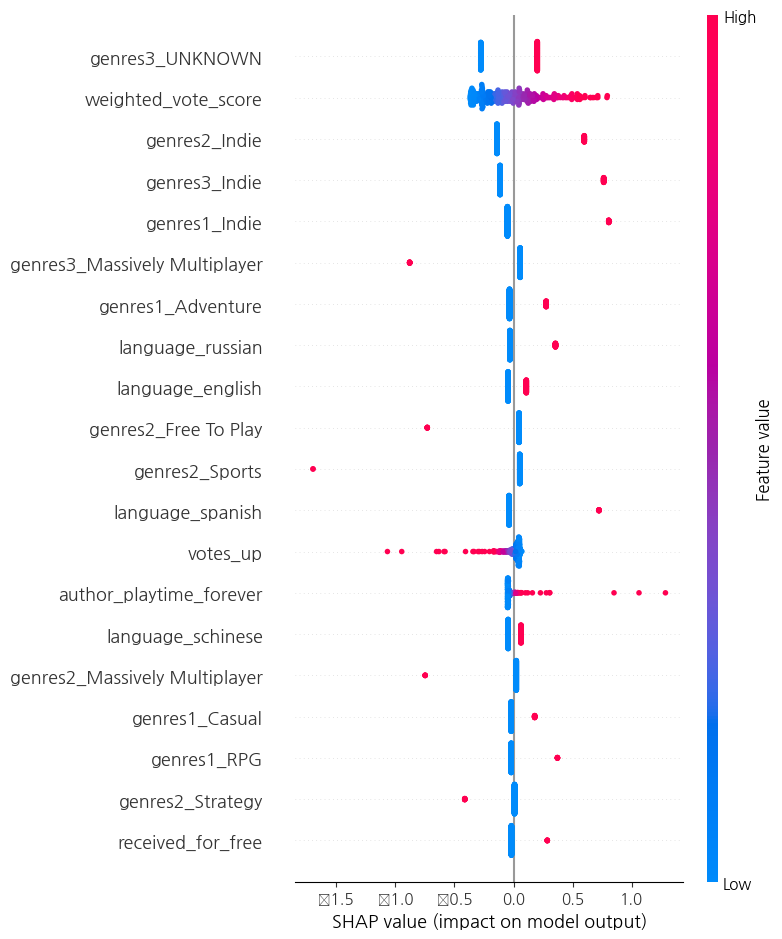

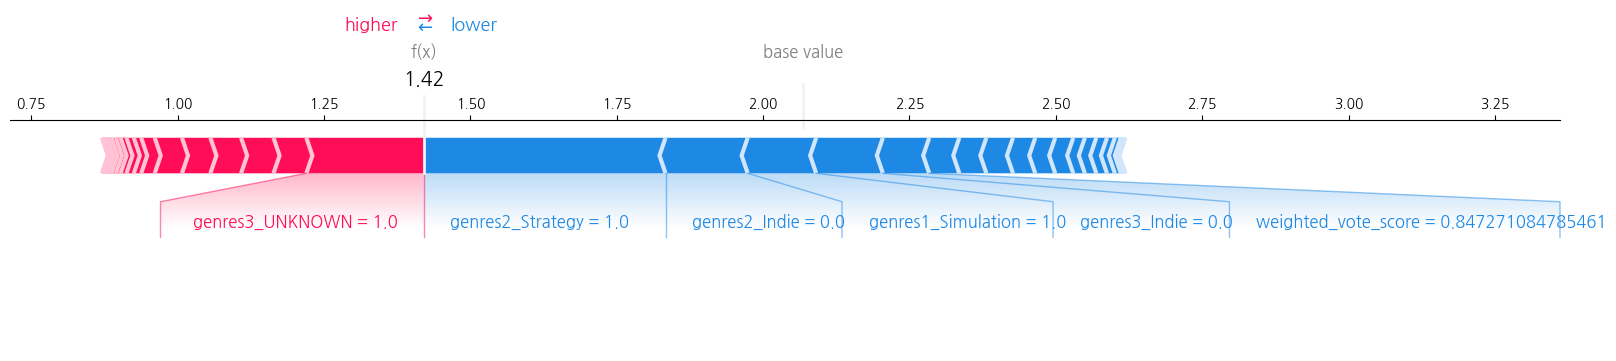

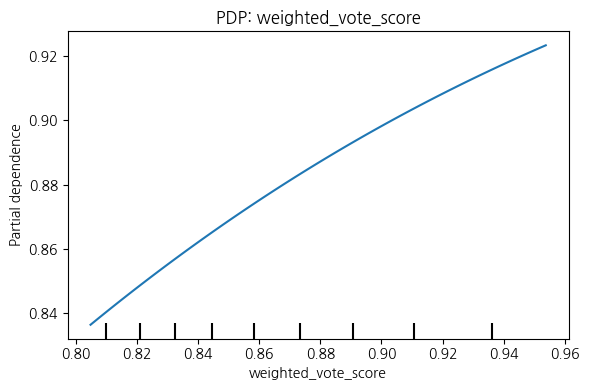


=== DONE ===
Tip) '오즈비(OR)>1'이면 양(+)의 효과, 'AME'는 확률 기준 평균 한계효과(예: +0.03 → +3%p).


In [ ]:
# -*- coding: utf-8 -*-
"""
Explainability-first pipeline: Logistic / GEE / GLMM-like + SHAP + PDP
- Target: voted_up (0/1)
- Cluster (for GEE / random intercept): appid
- Example CSV:/content/weighted_score_above_08_250922-2010pm.csv
"""

import os, re, warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

# Statsmodels for interpretable models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

# Sklearn for split/scale/encoding + SHAP/PDP compatibility
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import PartialDependenceDisplay

# SHAP
import shap
import matplotlib.pyplot as plt

# -----------------------------
# 1) CONFIG
# -----------------------------
# 1) 여기만 바꾸면 동작
CSV_PATH = "/content/weighted_score_above_08_250924.csv"  # ← Colab 업로드 경로
TARGET = "voted_up"          # 0/1
CLUSTER_ID = "appid"         # 군집/랜덤효과용
ID_COLS = ["review_id"]      # 있으면 지정(없으면 자동 무시)
MAX_ONEHOT_PER_CAT = 10      # 범주형은 상위 k개만 one-hot, 나머지는 OTHER
TEST_SIZE = 0.2
RANDOM_STATE = 42

# 사용자가 보고 싶은 주요 설명변수 후보(있는 것만 사용)
PREFERRED_FEATURES = [
    "pos_rate", "weighted_vote_score", "votes_up", "comment_count",
    "author_playtime_forever", "author_num_games_owned", "early_access",
    "received_for_free", "language", "genres1", "genres2", "genres3"
]

# -----------------------------
# 2) LOAD
# -----------------------------
df = pd.read_csv(CSV_PATH)
print(f"[LOAD] rows={len(df):,}, cols={len(df.columns)}")
assert TARGET in df.columns, f"TARGET '{TARGET}' not in columns"
if CLUSTER_ID not in df.columns:
    # 안전장치: 없으면 가짜 군집으로 채움
    df[CLUSTER_ID] = "cluster_0"

# -----------------------------
# 3) FEATURE SELECTION (interpretable)
#    - 존재하는 것만 선택
#    - 수치/범주 분리
# -----------------------------
use_cols = [c for c in PREFERRED_FEATURES if c in df.columns]
# 타깃/클러스터 제외
use_cols = [c for c in use_cols if c not in [TARGET, CLUSTER_ID] + ID_COLS]

# dtype 기반 분리 (object→categorical, bool→categorical)
num_cols = [c for c in use_cols if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in use_cols if (df[c].dtype == "object" or pd.api.types.is_bool_dtype(df[c]))]

# 간단 정제
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
for c in cat_cols:
    df[c] = df[c].astype("object").fillna("UNKNOWN")

# 높은 카디널리티 범주형을 상위 K + OTHER로 축소(해석력 유지)
def topk_or_other(s: pd.Series, k=MAX_ONEHOT_PER_CAT):
    top = s.value_counts(dropna=False).index[:k]
    return s.where(s.isin(top), other="OTHER")

for c in cat_cols:
    df[c] = topk_or_other(df[c], k=MAX_ONEHOT_PER_CAT)

# 결측 제거(간단히)
df = df.dropna(subset=[TARGET] + num_cols)
df[TARGET] = df[TARGET].astype(int)

# -----------------------------
# 4) TRAIN / TEST SPLIT
# -----------------------------
X = df[num_cols + cat_cols].copy()
y = df[TARGET].copy()
groups = df[CLUSTER_ID].copy()

X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
    X, y, groups, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# -----------------------------
# 5) DESIGN MATRIX (statsmodels용)
#     - 해석력 위해: 수치 + 범주형 원-핫(기준범주 자동 형성)
# -----------------------------
X_all = pd.concat([X_train, X_test], axis=0)
dummies = pd.get_dummies(X_all[cat_cols], drop_first=True) if cat_cols else pd.DataFrame(index=X_all.index)
X_all_num = X_all[num_cols].copy()
X_dm = pd.concat([X_all_num, dummies], axis=1)
X_dm = sm.add_constant(X_dm, has_constant="add")

# train/test 분할 복원
X_dm_train = X_dm.loc[X_train.index]
X_dm_test  = X_dm.loc[X_test.index]

# -----------------------------
# 5-1) 디자인 매트릭스 정규화 (object → float64, NaN/Inf 처리)
#     ↑ X_dm_train / X_dm_test 만든 '바로 다음' 셀/줄에 추가하세요.
# -----------------------------
def normalize_design_matrix(X_train, X_test):
    # 1) object → numeric (coerce), Inf → NaN
    for X in (X_train, X_test):
        obj_cols = X.select_dtypes(include=["object"]).columns
        if len(obj_cols) > 0:
            # 숫자로 변환 불가한 값은 NaN으로
            X[obj_cols] = X[obj_cols].apply(pd.to_numeric, errors="coerce")
        X.replace([np.inf, -np.inf], np.nan, inplace=True)

    # 2) 학습 기준으로 '전부 NaN'이 된 컬럼 제거 (테스트도 맞춰서 제거)
    all_nan_cols = X_train.columns[X_train.isna().all(axis=0)]
    if len(all_nan_cols) > 0:
        X_train.drop(columns=all_nan_cols, inplace=True)
        X_test.drop(columns=[c for c in all_nan_cols if c in X_test.columns], inplace=True)

    # 3) 결측 채우기
    X_train.fillna(0.0, inplace=True)
    X_test.fillna(0.0, inplace=True)

    # 3-1) 분산 0 컬럼 제거 (단, const는 보존)
    nunique = X_train.nunique(dropna=True)
    zero_var_cols = nunique.index[(nunique <= 1) & (nunique.index != "const")]
    if len(zero_var_cols) > 0:
        X_train.drop(columns=zero_var_cols, inplace=True)
        X_test = X_test.reindex(columns=X_train.columns, fill_value=0.0)

    # 4) dtype
    X_train = X_train.astype("float64")
    X_test  = X_test.astype("float64")
    return X_train, X_test


# ✅ 여기서 호출 (X_dm_train / X_dm_test 만든 '직후')
# -----------------------------
# 5-2) sklearn용 디자인 매트릭스 (const 제거, 열 정렬 고정)
# -----------------------------
def to_sklearn_matrix(X_train_dm: pd.DataFrame, X_test_dm: pd.DataFrame):
    # statsmodels용 상수항은 sklearn에 불필요 → 제거
    X_tr = X_train_dm.drop(columns=["const"], errors="ignore").copy()
    # test는 train 열 구성/순서에 강제 맞춤
    X_te = X_test_dm.reindex(columns=X_tr.columns, fill_value=0.0).copy()
    # 안전: float64
    return X_tr.astype("float64"), X_te.astype("float64")

X_skl_train, X_skl_test = to_sklearn_matrix(X_dm_train, X_dm_test)
X_skl_test_num = X_skl_test  # (one-hot 포함 전부 수치라서 그대로 사용)

X_dm_train, X_dm_test = normalize_design_matrix(X_dm_train, X_dm_test)

# (선택) y도 안전하게 숫자로 보장
y_train = pd.to_numeric(y_train, errors="coerce").fillna(0).astype(int)
y_test  = pd.to_numeric(y_test, errors="coerce").fillna(0).astype(int)


# -----------------------------
# 6) Logistic (statsmodels): 계수/오즈비/한계효과
# -----------------------------
logit_model = sm.Logit(y_train, X_dm_train)
logit_res = logit_model.fit(disp=False)

# 성능
proba_test = logit_res.predict(X_dm_test).clip(1e-6, 1-1e-6)
auc = roc_auc_score(y_test, proba_test)
ll  = log_loss(y_test, proba_test)
print("\n[Logistic] AUC=%.4f | LogLoss=%.4f" % (auc, ll))

# 계수/오즈비 요약
params = logit_res.params
conf = logit_res.conf_int()
summary_table = pd.DataFrame({
    "coef": params,
    "odds_ratio": np.exp(params),
    "ci_low(OR)": np.exp(conf[0]),
    "ci_high(OR)": np.exp(conf[1]),
    "p_value": logit_res.pvalues
})
summary_table = summary_table.sort_values("p_value")
print("\n[Logistic Coefficients → Odds Ratios]\n", summary_table.head(30))

# 평균 한계효과 (AME)
mfx = logit_res.get_margeff(at="overall").summary_frame()
print("\n[Average Marginal Effects]\n", mfx.head(30))

# -----------------------------
# 7) GEE (군집 상관 보정)
# -----------------------------
# 같은 디자인 매트릭스를 사용하되, 그룹은 g_train
gee_model = GEE(y_train, X_dm_train, groups=g_train, family=Binomial(), cov_struct=Exchangeable())
gee_res = gee_model.fit()
proba_test_gee = gee_res.predict(X_dm_test)
auc_gee = roc_auc_score(y_test, proba_test_gee)
ll_gee  = log_loss(y_test, proba_test_gee)
print("\n[GEE] AUC=%.4f | LogLoss=%.4f" % (auc_gee, ll_gee))
print("[GEE Coeff OR]\n", pd.DataFrame({
    "coef": gee_res.params,
    "odds_ratio": np.exp(gee_res.params),
    "p_value": gee_res.pvalues
}).sort_values("p_value").head(30))

# -----------------------------
# 8) GLMM-like (랜덤 절편: 게임별)
#    BinomialBayesMixedGLM: y ~ X, random_intercept per group
# -----------------------------
# 상위 그룹만 랜덤효과에 포함(메모리/수렴 안정화)
grp_counts = g_train.value_counts()
top_groups = set(grp_counts.index[:200])

Z_train = pd.get_dummies(g_train.where(g_train.isin(top_groups), other="OTHER"), drop_first=True)
Z_test  = pd.get_dummies(g_test.where(g_test.isin(top_groups),  other="OTHER"), drop_first=True)
Z_test  = Z_test.reindex(columns=Z_train.columns, fill_value=0)

# BinomialBayesMixedGLM은 X에서 상수항 제거 필요
drop_cols = [c for c in ["const"] if c in X_dm_train.columns]
X_glmm_train = X_dm_train.drop(columns=drop_cols)
X_glmm_test  = X_dm_test.drop(columns=drop_cols)

# 타입 통일
X_glmm_train = X_glmm_train.astype("float64")
X_glmm_test  = X_glmm_test.astype("float64")
Z_train = Z_train.astype("float64")
Z_test  = Z_test.astype("float64")

# === 핵심: exog_vc는 2D ndarray, ident 길이는 '열 수'와 동일해야 함 ===
exog    = X_glmm_train.values
exog_vc = Z_train.values                            # ✅ 리스트가 아니라 2D ndarray
ident   = np.zeros(exog_vc.shape[1], dtype=int)     # 모든 랜덤효과 열을 분산성분 0으로 묶기

# 방어: 랜덤효과 열이 0개면 GLMM 스킵
if exog_vc.shape[1] == 0:
    print("[GLMM] 랜덤효과 열이 없어 스킵합니다.")
else:
    model_glmm = BinomialBayesMixedGLM(y_train.values, exog, exog_vc, ident, vcp_p=1.0)
    glmm_res   = model_glmm.fit_vb()  # 변분근사

    # 고정효과만 사용한 예측
    # 로짓 스케일 원하면 linear=True, 확률 원하면 linear=False
    proba_test_glmm = model_glmm.predict(glmm_res.params, X_glmm_test.values, linear=False)

    auc_glmm = roc_auc_score(y_test, proba_test_glmm)
    ll_glmm  = log_loss(y_test, proba_test_glmm)
    print("\n[BinomialBayesMixedGLM] AUC=%.4f | LogLoss=%.4f" % (auc_glmm, ll_glmm))

    # 고정효과 요약
    glmm_fix = pd.DataFrame({
        "coef": glmm_res.params[:X_glmm_train.shape[1]],
        "odds_ratio": np.exp(glmm_res.params[:X_glmm_train.shape[1]])
    }, index=X_glmm_train.columns).sort_values("odds_ratio", ascending=False)
    print("\n[GLMM Fixed Effects OR]\n", glmm_fix.head(30))




# -----------------------------
# 9) SHAP (LinearExplainer 우선, 실패 시 KernelExplainer)
# -----------------------------
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

rng = np.random.RandomState(RANDOM_STATE)

pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(max_iter=200, solver="lbfgs"))
])
pipe.fit(X_skl_train, y_train)

# 배경/테스트 샘플
bg_n   = min(1000, X_skl_train.shape[0])
te_n   = min(300,   X_skl_test.shape[0])
bg_idx = rng.choice(X_skl_train.shape[0], size=bg_n, replace=False)
te_idx = rng.choice(X_skl_test.shape[0],  size=te_n, replace=False)

# 스케일된 행렬
X_tr_scaled = pipe.named_steps["scaler"].transform(X_skl_train)
X_te_scaled = pipe.named_steps["scaler"].transform(X_skl_test)
clf = pipe.named_steps["clf"]

# SHAP
X_te_scaled_sub = X_te_scaled[te_idx]
X_plot = X_skl_test.iloc[te_idx].copy()  # 특성명/원범위 표시용
try:
    explainer = shap.LinearExplainer(clf, X_tr_scaled[bg_idx], model_output="logit")
    sv = explainer.shap_values(X_te_scaled_sub)
    shap_values = sv if not isinstance(sv, list) else sv[0]
except Exception:
    explainer = shap.KernelExplainer(lambda a: clf.predict_proba(a)[:, 1], X_tr_scaled[bg_idx])
    shap_values = explainer.shap_values(X_te_scaled_sub)

assert shap_values.shape[1] == X_plot.shape[1], \
    f"SHAP n_features {shap_values.shape[1]} != X_plot {X_plot.shape[1]}"

plt.figure()
shap.summary_plot(shap_values, X_plot, show=False)
plt.tight_layout()
plt.show()

# 국소(force) 예시
base_val = getattr(explainer, "expected_value", 0)
if not np.isscalar(base_val):
    base_val = base_val[1] if len(base_val) > 1 else base_val[0]
shap.plots.force(
    base_val,
    shap_values[0, :],
    X_plot.iloc[0, :],
    matplotlib=True,
    show=True
)

# -----------------------------
# 10) PDP (부분의존) - 파이프라인 그대로 사용
# -----------------------------
pdp_candidates = [c for c in ["pos_rate","weighted_vote_score","author_playtime_forever","votes_up"]
                  if c in X_skl_train.columns]

if len(pdp_candidates) > 0:
    feat_name = pdp_candidates[0]
    feat_idx  = list(X_skl_train.columns).index(feat_name)

    fig, ax = plt.subplots(figsize=(6,4))
    PartialDependenceDisplay.from_estimator(
        pipe,               # 스케일 포함 파이프라인
        X_skl_test,         # 원본 스케일 → 내부에서 변환
        features=[feat_idx],# 인덱스로 지정(버전 호환성 안전)
        ax=ax
    )
    plt.title(f"PDP: {feat_name}")
    plt.tight_layout()
    plt.show()


print("\n=== DONE ===")
print("Tip) '오즈비(OR)>1'이면 양(+)의 효과, 'AME'는 확률 기준 평균 한계효과(예: +0.03 → +3%p).")


In [ ]:
pip install pandas numpy scikit-learn imbalanced-learn optuna lightgbm xgboost catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 4.0 MB/s eta 0:00:00


###성능개선모델  리뷰 단위의 voted_up 분류” = 리뷰가 추천(Thumbs-up)될 확률을 예측하는 ‘사용자 반응 예측(리뷰 수준)

In [ ]:
# reviews_auc_push_any.py (AUC-boost: calibrated SGD + richer blender)
# -*- coding: utf-8 -*-
"""
목표: AUC 극대화(누수 방지) + 예측 다양성/보정 강화
변경 핵심:
- SGD 확률보정 모델 추가: sgd_log_cal, sgd_log_c_cal (CalibratedClassifierCV, sigmoid, cv=2)
- LinearSVC 다양성: linsvc_cal(C=1.0), linsvc_cal_15(C=1.5)
- 메타 블렌더 입력 확장: [모델 OOF] + [app_baseline_OOF] + [user_TE_OOF] + [cat_TE_OOF들]
- 블렌더 강한 규제: C ∈ {0.25, 0.5, 1.0} 중 OOF AUC 최고 자동 선택
- 해싱: alternate_sign=False, word 차원 확대(//2) 유지
"""

import os, json, argparse, warnings, unicodedata, html, time, threading, re
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.model_selection import GroupKFold
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import roc_auc_score, log_loss, average_precision_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import BaseEstimator, TransformerMixin

# -------- Constants --------
RNG = 42
TARGET = "voted_up"
GROUP = "appid"
ROWID = "review_id"
DEFAULT_INPUT_CSV = "/content/S-team_250930-final.csv"

# -------- Heartbeat --------
def _start_heartbeat(get_state_fn, interval_sec: int):
    if interval_sec is None or interval_sec <= 0: return lambda: None
    stop_event = threading.Event(); t0 = time.time()
    try:
        import psutil; _PROC = psutil.Process(os.getpid())
    except Exception:
        _PROC = None
    def hb():
        while not stop_event.wait(interval_sec):
            try: state = get_state_fn() or {}
            except Exception: state = {}
            elapsed = int(time.time()-t0)
            stag = state.get("stage","running"); fold = state.get("fold","-"); model = state.get("model","-")
            mem = ""
            if _PROC is not None:
                try: mem = f" | RSS={_PROC.memory_info().rss/(1024**3):.2f} GiB"
                except Exception: pass
            print(f"[HB] elapsed={elapsed}s | stage={stag} | fold={fold} | model={model}{mem}", flush=True)
    th = threading.Thread(target=hb, daemon=True); th.start()
    def stop():
        stop_event.set()
        try: state = get_state_fn() or {}
        except Exception: state = {}
        print(f"[HB] stop | stage={state.get('stage','done')}", flush=True)
    return stop

# -------- Helpers: inference --------
def infer_text_col(df: pd.DataFrame):
    cands = [c for c in df.columns if c.lower() in ("review","review_text","text","review_body","content","review_body_clean")]
    return cands[0] if cands else None

def infer_date_col(df: pd.DataFrame):
    for c in df.columns:
        if c.lower() in ("review_created","timestamp_created","created_at","date","time_created"):
            return c
    return None

def infer_user_col(df: pd.DataFrame):
    for c in df.columns:
        if c.lower() in ("author","author_id","author_steamid","steamid","user_id","reviewer_id","profile_id"):
            return c
    return None

# -------- Core blocks --------
def topk_categories(s: pd.Series, k=30):
    vc = s.value_counts(dropna=False); keep = set(vc.head(k).index)
    return s.where(s.isin(keep), other="__OTHER__")

class MetaBlock(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols, cat_cols, topk=30):
        self.num_cols = list(num_cols); self.cat_cols = list(cat_cols); self.topk = topk
    def fit(self, X, y=None):
        cols = self.num_cols + self.cat_cols
        df = pd.DataFrame(X, columns=cols) if not isinstance(X, pd.DataFrame) else X[cols].copy()
        if self.num_cols:
            num_df = df[self.num_cols].apply(pd.to_numeric, errors="coerce")
            self.num_means_ = num_df.mean(); self.num_stds_ = num_df.std().replace(0,1.0).fillna(1.0)
        else:
            self.num_means_ = pd.Series(dtype=float); self.num_stds_ = pd.Series(dtype=float)
        self.cat_levels_ = {}
        for c in self.cat_cols:
            s2 = topk_categories(df[c].astype(object), self.topk).astype(object).fillna("__MISSING__")
            levels = pd.Series(s2.unique(), dtype=object).astype(str).tolist() or ["__MISSING__"]
            self.cat_levels_[c] = sorted(set(levels))
        return self
    def transform(self, X):
        cols = self.num_cols + self.cat_cols
        df = pd.DataFrame(X, columns=cols) if not isinstance(X, pd.DataFrame) else X[cols].copy()
        mats = []
        if self.num_cols:
            num_df = df[self.num_cols].apply(pd.to_numeric, errors="coerce").fillna(self.num_means_)
            num_std = (num_df - self.num_means_) / self.num_stds_
            mats.append(sparse.csr_matrix(num_std.values.astype(np.float32)))
        else:
            mats.append(sparse.csr_matrix((len(df),0), dtype=np.float32))
        for c in self.cat_cols:
            levels = self.cat_levels_[c]; level_index = {v:i for i,v in enumerate(levels)}
            col = df[c].astype(object).fillna("__MISSING__").astype(str)
            col = col.where(col.isin(levels), "__OTHER__")
            if "__OTHER__" not in level_index:
                levels = levels+["__OTHER__"]; level_index = {v:i for i,v in enumerate(levels)}
            rows = np.arange(len(col)); cols_idx = col.map(level_index).values; data = np.ones(len(col), dtype=np.float32)
            mats.append(sparse.csr_matrix((data,(rows, cols_idx)), shape=(len(col), len(levels)), dtype=np.float32))
        return sparse.hstack(mats, format="csr", dtype=np.float32)

def build_text_matrix(text: pd.Series, max_features=2**20):
    # alternate_sign=False, word 차원 확장(//2)
    norm = []
    for t in text.fillna("").astype(str).values:
        t = unicodedata.normalize("NFKC", t); t = html.unescape(t); norm.append(t)
    hv_char = HashingVectorizer(
        analyzer="char_wb", ngram_range=(2,5),
        n_features=max_features, alternate_sign=False, dtype=np.float32, norm="l2"
    )
    hv_word = HashingVectorizer(
        analyzer="word", ngram_range=(1,2),
        n_features=max_features//2, alternate_sign=False, dtype=np.float32, norm="l2",
        token_pattern=r"(?u)\b\w+\b"
    )
    Xc = hv_char.transform(norm); Xw = hv_word.transform(norm)
    return sparse.hstack([Xc, Xw], format="csr", dtype=np.float32)

def safe_num_df(df: pd.DataFrame):
    return pd.DataFrame({c: pd.to_numeric(df[c], errors="coerce") for c in df.columns})

# -------- Target Encoding (OOF, smoothed) --------
def oof_target_encode(df, y, groups, col, n_splits, alpha=5.0, beta=5.0):
    gkf = GroupKFold(n_splits=n_splits); oof = np.zeros(len(df), dtype=np.float32); prior = float(y.mean())
    for tr, va in gkf.split(np.zeros(len(df)), y, groups):
        sub = pd.DataFrame({col: df.iloc[tr][col].astype(object), 'y': y[tr]})
        agg = sub.groupby(col)['y'].agg(['sum','count'])
        enc = (agg['sum'] + alpha*prior) / (agg['count'] + alpha + beta)
        o = df.iloc[va][col].astype(object).map(enc).fillna(prior).values.astype(np.float32); oof[va] = o
    agg_full = pd.DataFrame({col: df[col].astype(object), 'y': y}).groupby(col)['y'].agg(['sum','count'])
    enc_full = (agg_full['sum'] + alpha*prior) / (agg_full['count'] + alpha + beta)
    full = df[col].astype(object).map(enc_full).fillna(prior).astype(np.float32).values
    return oof, full

# -------- Text stats --------
_WORD = re.compile(r"\w+", re.UNICODE)
def text_stats_series(s: pd.Series):
    s = s.fillna("").astype(str)
    lens = s.str.len().astype(np.float32)
    words = s.apply(lambda x: len(_WORD.findall(x))).astype(np.float32)
    uniqw = s.apply(lambda x: len(set(_WORD.findall(x)))).astype(np.float32)
    exclm = s.str.count(r"!").astype(np.float32)
    ques  = s.str.count(r"\?").astype(np.float32)
    caps  = s.apply(lambda x: sum(1 for ch in x if ch.isupper())).astype(np.float32)
    emoji = s.str.count(u"[\U00010000-\U0010ffff]").astype(np.float32)
    rat_uniq = (uniqw / (words.clip(lower=1))).astype(np.float32)
    rat_caps = (caps / (lens.clip(lower=1))).astype(np.float32)
    return pd.DataFrame({"ts_len":lens,"ts_words":words,"ts_uniqw":uniqw,"ts_exclm":exclm,"ts_ques":ques,"ts_caps":caps,"ts_emoji":emoji,"ts_rat_uniq":rat_uniq,"ts_rat_caps":rat_caps})

# -------- App baseline (OOF) --------
def compute_oof_app_baseline(df, y, groups, n_splits, alpha=5.0, beta=5.0):
    gkf = GroupKFold(n_splits=n_splits); oof_base = np.zeros(len(df), dtype=np.float32)
    for tr, va in gkf.split(np.zeros(len(df)), y, groups):
        agg = df.iloc[tr].groupby(GROUP)[TARGET].agg(['sum','count']).rename(columns={'sum':'pos','count':'n'})
        agg['base'] = (agg['pos'] + alpha) / (agg['n'] + alpha + beta)
        m = df.iloc[va][GROUP].map(agg['base']).fillna(agg['base'].mean() if len(agg) else 0.5)
        oof_base[va] = m.values.astype(np.float32)
    agg_full = df.groupby(GROUP)[TARGET].agg(['sum','count']).rename(columns={'sum':'pos','count':'n'})
    agg_full['base'] = (agg_full['pos'] + alpha) / (agg_full['n'] + alpha + beta)
    base_full = df[GROUP].map(agg_full['base']).fillna(agg_full['base'].mean() if len(agg_full) else 0.5).astype(np.float32).values
    return oof_base, base_full

# -------- Main --------
def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--input_csv", default=None)
    ap.add_argument("--out_dir", default="/mnt/data/_auc_any")
    ap.add_argument("--topk", type=int, default=30)
    ap.add_argument("--n_splits", type=int, default=5)
    ap.add_argument("--max_text_len", type=int, default=0)
    ap.add_argument("--n_features", type=int, default=2**20)
    ap.add_argument("--heartbeat_sec", type=int, default=600)

    # 모델/전처리 옵션
    ap.add_argument("--models", default="linsvc_cal,linsvc_cal_15,sgd_log,sgd_log_c,sgd_log_cal,sgd_log_c_cal",
                    help="쉼표구분: linsvc_cal,linsvc_cal_15,sgd_log,sgd_log_c,sgd_log_cal,sgd_log_c_cal")
    ap.add_argument("--time_halflife_days", type=float, default=180.0)
    ap.add_argument("--recent_start", default=None)
    ap.add_argument("--use_app_baseline", action="store_true")
    ap.add_argument("--use_sample_weight", action="store_true")

    # 고급 전처리 (기본 ON)
    ap.add_argument("--use_te_cat", action="store_true", default=True)
    ap.add_argument("--use_te_user", action="store_true", default=True)
    ap.add_argument("--te_topk", type=int, default=12)
    ap.add_argument("--te_alpha", type=float, default=5.0)
    ap.add_argument("--te_beta", type=float, default=5.0)

    ap.add_argument("--use_text_stats", action="store_true", default=True)
    ap.add_argument("--use_derives", action="store_true", default=True)
    ap.add_argument("--use_interactions", action="store_true", default=True)

    args, _unknown = ap.parse_known_args()

    state = {"stage":"init","fold":-1,"model":"-"}
    stop_hb = _start_heartbeat(lambda: state, args.heartbeat_sec)
    t0 = time.time()

    try:
        env_csv = os.getenv("AUC_INPUT_CSV", "").strip()
        if not args.input_csv: args.input_csv = env_csv if env_csv else DEFAULT_INPUT_CSV
        if not os.path.exists(args.input_csv): raise SystemExit(f"[ERROR] input_csv 없음: {args.input_csv}")
        os.makedirs(args.out_dir, exist_ok=True)
        print(f"[LOAD] {args.input_csv}", flush=True)

        df = pd.read_csv(args.input_csv)
        if TARGET not in df.columns: raise SystemExit(f"[ERROR] target '{TARGET}' 없음")
        if GROUP not in df.columns: df[GROUP] = np.arange(len(df))
        if ROWID not in df.columns: df[ROWID] = np.arange(len(df))

        date_col = infer_date_col(df)
        if date_col:
            df[date_col] = pd.to_datetime(df[date_col], errors="coerce", utc=True).dt.tz_localize(None)
            if args.recent_start:
                cut = pd.to_datetime(args.recent_start); before = len(df)
                df = df[df[date_col] >= cut].reset_index(drop=True)
                print(f"[FILTER] recent_start={args.recent_start} | kept={len(df)}/{before}", flush=True)

        user_col = infer_user_col(df)
        if user_col: print(f"[INFER] user_col={user_col}", flush=True)

        y = df[TARGET].astype(int).values; groups = df[GROUP].values

        sample_weight = np.ones(len(df), dtype=np.float32)
        if date_col and args.time_halflife_days and args.time_halflife_days > 0:
            now_dt = df[date_col].max()
            delta_days = (now_dt - df[date_col]).dt.days.clip(lower=0).astype(float)
            H = max(args.time_halflife_days, 1.0)
            sample_weight = np.power(0.5, delta_days / H).astype(np.float32)
            print(f"[TIME-W] halflife={H}d | min={sample_weight.min():.4f} max={sample_weight.max():.4f}", flush=True)

        # TEXT
        state.update(stage="text")
        text_col = infer_text_col(df)
        if text_col is None:
            X_text = sparse.csr_matrix((len(df),1), dtype=np.float32); print("[TEXT] 텍스트 컬럼 없음 → dummy 1열", flush=True)
        else:
            tt = df[text_col].astype(str)
            if args.max_text_len and args.max_text_len > 0:
                tt = tt.str.slice(0, args.max_text_len); print(f"[TEXT] {text_col} | max_len={args.max_text_len}", flush=True)
            else:
                print(f"[TEXT] {text_col}", flush=True)
            X_text = build_text_matrix(tt, max_features=args.n_features)
        print(f"[TEXT] shape={X_text.shape}", flush=True)

        # TEXT STATS / DERIVES
        extra_num_df = pd.DataFrame(index=df.index)
        if args.use_text_stats and text_col is not None:
            ts = text_stats_series(df[text_col]); extra_num_df = pd.concat([extra_num_df, ts], axis=1)
            print(f"[TSTATS] added cols={list(ts.columns)}", flush=True)

        if args.use_derives:
            if date_col:
                review_age = (df[date_col].max() - df[date_col]).dt.days.clip(lower=0)
                extra_num_df["d_review_age"] = review_age.astype(np.float32)
            if "release_date" in df.columns:
                rel = pd.to_datetime(df["release_date"], errors="coerce")
                if date_col:
                    extra_num_df["d_since_release"] = (df[date_col].fillna(rel.max()) - rel).dt.days.fillna(9999).astype(np.float32)
                else:
                    extra_num_df["d_since_release"] = (rel.max()-rel).dt.days.fillna(9999).astype(np.float32)
                extra_num_df["is_new_release90"] = ((rel.max() - rel).dt.days <= 90).fillna(False).astype(np.int8)
            for price_col in ["price","price_final","price_original"]:
                if price_col in df.columns:
                    p = pd.to_numeric(df[price_col], errors="coerce").fillna(0.0)
                    extra_num_df[f"price_log_{price_col}"] = np.log1p(p).astype(np.float32)
            if {"price_final","price_original"}.issubset(df.columns):
                pf = pd.to_numeric(df["price_final"], errors="coerce")
                po = pd.to_numeric(df["price_original"], errors="coerce").replace(0, np.nan)
                disc = 1.0 - (pf/po); extra_num_df["discount_rate"] = disc.fillna(0.0).clip(0,1).astype(np.float32)
            for pt in ["author_playtime_forever","author_playtime_last_two_weeks"]:
                if pt in df.columns:
                    ptn = pd.to_numeric(df[pt], errors="coerce").fillna(0.0)
                    extra_num_df[f"log1p_{pt}"] = np.log1p(ptn).astype(np.float32)

        # META
        state.update(stage="meta")
        drop_cols = {TARGET, GROUP, ROWID};
        if text_col: drop_cols.add(text_col)
        if date_col: drop_cols.add(date_col)
        cand = [c for c in df.columns if c not in drop_cols]
        num_guess, cat_guess = [], []
        for c in cand:
            s_num = pd.to_numeric(df[c], errors="coerce"); null_rate = s_num.isna().mean()
            if null_rate < 0.3: num_guess.append(c)
            else: cat_guess.append(c)
        num_guess = num_guess[:32]; cat_guess = cat_guess[:16]
        print(f"[META] num={len(num_guess)} cat={len(cat_guess)} (topk={args.topk})", flush=True)

        X_meta_in = pd.concat([
            safe_num_df(df[num_guess]) if num_guess else pd.DataFrame(index=df.index),
            df[cat_guess] if cat_guess else pd.DataFrame(index=df.index)
        ], axis=1)
        if not extra_num_df.empty:
            X_meta_in = pd.concat([X_meta_in, extra_num_df], axis=1)

        meta = MetaBlock(
            num_cols=[c for c in X_meta_in.columns if c not in (df[cat_guess].columns if cat_guess else [])],
            cat_cols=list(df[cat_guess].columns) if cat_guess else [], topk=args.topk
        )
        meta.fit(X_meta_in); X_meta = meta.transform(X_meta_in)
        print(f"[META] shape={X_meta.shape}", flush=True)

        # BASELINE (app)
        base_oof = base_full = None
        if args.use_app_baseline:
            state.update(stage="app_baseline")
            base_oof, base_full = compute_oof_app_baseline(df, y, groups, args.n_splits, alpha=5.0, beta=5.0)
            print("[BASE] app baseline (OOF/full) computed", flush=True)

        # TE (cat)
        te_oof_list, te_full_list, te_cols_used = [], [], []
        if args.use_te_cat:
            obj_cols = [c for c in df.columns if c not in {TARGET, GROUP, ROWID, text_col, date_col} and df[c].dtype == object]
            obj_cols = sorted(obj_cols, key=lambda c: df[c].nunique(dropna=False))
            for c in obj_cols[:args.te_topk]:
                try:
                    oofv, fullv = oof_target_encode(df, y, groups, c, args.n_splits, alpha=args.te_alpha, beta=args.te_beta)
                    te_oof_list.append(sparse.csr_matrix(oofv.reshape(-1,1)))
                    te_full_list.append(sparse.csr_matrix(fullv.reshape(-1,1)))
                    te_cols_used.append(c)
                except Exception: continue
            print(f"[TE] cat used={te_cols_used}", flush=True)

        # TE (user)
        user_te_oof = user_te_full = None
        if args.use_te_user:
            ucol = infer_user_col(df)
            if ucol and ucol in df.columns:
                try:
                    user_te_oof, user_te_full = oof_target_encode(df, y, groups, ucol, args.n_splits, alpha=args.te_alpha, beta=args.te_beta)
                    print("[TE] user OOF/full computed", flush=True)
                except Exception as e:
                    print(f"[TE] user TE skipped: {e}", flush=True)

        # STACK X
        state.update(stage="stack")
        mats = [X_text, X_meta]
        if args.use_app_baseline and base_oof is not None:
            mats.append(sparse.csr_matrix(base_oof.reshape(-1,1)))
        for m in te_oof_list: mats.append(m)
        if user_te_oof is not None: mats.append(sparse.csr_matrix(user_te_oof.reshape(-1,1)))
        X = sparse.hstack(mats, format="csr", dtype=np.float32)
        print(f"[X] shape={X.shape}", flush=True)

        # INTERACTIONS (간단)
        if args.use_interactions:
            inter_cols = []
            def add_dense_inter(a,b):
                inter_cols.append(sparse.csr_matrix((a.astype(np.float32)*b.astype(np.float32)).reshape(-1,1)))
            if "discount_rate" in extra_num_df.columns and "is_new_release90" in extra_num_df.columns:
                add_dense_inter(extra_num_df["discount_rate"].values, extra_num_df["is_new_release90"].values)
            if "log1p_author_playtime_last_two_weeks" in extra_num_df.columns and "is_new_release90" in extra_num_df.columns:
                add_dense_inter(extra_num_df["log1p_author_playtime_last_two_weeks"].values, extra_num_df["is_new_release90"].values)
            if args.use_app_baseline and base_oof is not None:
                sw_norm = (sample_weight - sample_weight.min()) / max(1e-6, (sample_weight.max()-sample_weight.min()))
                add_dense_inter(base_oof, sw_norm)
            if inter_cols:
                X = sparse.hstack([X] + inter_cols, format="csr", dtype=np.float32)
                print(f"[INTER] added={len(inter_cols)} → X shape={X.shape}", flush=True)

        # MODELS
        model_list = [m.strip() for m in args.models.split(",") if m.strip()]
        base_models = {
            "linsvc_cal": CalibratedClassifierCV(
                estimator=LinearSVC(C=1.0, loss="squared_hinge", random_state=RNG),
                method="sigmoid", cv=2
            ),
            "linsvc_cal_15": CalibratedClassifierCV(
                estimator=LinearSVC(C=1.5, loss="squared_hinge", random_state=RNG+1),
                method="sigmoid", cv=2
            ),
            "sgd_log":   SGDClassifier(loss="log_loss", alpha=1e-5, penalty="l2", max_iter=2000, random_state=RNG),
            "sgd_log_c": SGDClassifier(loss="log_loss", alpha=1e-5, penalty="elasticnet", l1_ratio=0.05, max_iter=2000, random_state=RNG+21),
            # 확률 보정 버전(다양성↑)
            "sgd_log_cal": CalibratedClassifierCV(
                estimator=SGDClassifier(loss="log_loss", alpha=1e-5, penalty="l2", max_iter=2000, random_state=RNG+101),
                method="sigmoid", cv=2
            ),
            "sgd_log_c_cal": CalibratedClassifierCV(
                estimator=SGDClassifier(loss="log_loss", alpha=1e-5, penalty="elasticnet", l1_ratio=0.05, max_iter=2000, random_state=RNG+121),
                method="sigmoid", cv=2
            ),
        }
        base_models = {k:v for k,v in base_models.items() if k in model_list}
        if not base_models:
            raise SystemExit("[ERROR] 선택된 모델이 없습니다. --models 옵션을 확인하세요.")

        gkf = GroupKFold(n_splits=args.n_splits)
        oof = {name: np.zeros(len(df), dtype=np.float32) for name in base_models}
        oof_metrics = {}; fold_idx = np.zeros(len(df), dtype=int)

        # CV
        state.update(stage="cv", fold=-1, model="-")
        for f, (tr, va) in enumerate(gkf.split(X, y, groups)):
            state.update(fold=f, model="-")
            print(f"[CV] fold {f+1}/{args.n_splits} | train={len(tr)} valid={len(va)}", flush=True)
            Xtr, Xva = X[tr], X[va]; ytr, yva = y[tr], y[va]; fold_idx[va] = f
            wtr = sample_weight[tr] if args.use_sample_weight else None
            for name, model in base_models.items():
                state.update(model=name); t_fit0 = time.time(); mdl = model
                if wtr is not None:
                    try: mdl.fit(Xtr, ytr, sample_weight=wtr)
                    except TypeError: mdl.fit(Xtr, ytr)
                else:
                    mdl.fit(Xtr, ytr)
                fit_sec = time.time() - t_fit0
                if hasattr(mdl,"predict_proba"): p = mdl.predict_proba(Xva)[:,1]
                elif hasattr(mdl,"decision_function"):
                    score = mdl.decision_function(Xva); p = 1.0/(1.0+np.exp(-score))
                else: p = mdl.predict(Xva).astype(float)
                oof[name][va] = p.astype(np.float32)
                auc = roc_auc_score(yva,p); ll = log_loss(yva,np.clip(p,1e-6,1-1e-6)); pra = average_precision_score(yva,p)
                print(f"  [fit] {name:<14} time={fit_sec:.1f}s | foldAUC={auc:.6f} | foldLogLoss={ll:.6f} | foldPR-AUC={pra:.6f}", flush=True)

        # OOF 지표
        state.update(stage="oof_metrics", model="-")
        for name in base_models:
            auc = roc_auc_score(y, oof[name]); ll = log_loss(y, np.clip(oof[name],1e-6,1-1e-6)); pra = average_precision_score(y, oof[name])
            oof_metrics[name] = {"AUC": float(auc), "LogLoss": float(ll), "PR_AUC": float(pra)}

        # BLEND: richer features + 강한 규제 그리드
        state.update(stage="blend")
        Z_list = [oof[name] for name in base_models]  # base OOFs
        # 앱 베이스라인/TE OOF도 함께 입력으로 (있을 때만)
        if args.use_app_baseline and base_oof is not None: Z_list.append(base_oof)
        if infer_user_col(df) and 'user_te_oof' in locals() and user_te_oof is not None: Z_list.append(user_te_oof)
        for m in te_oof_list: Z_list.append(np.asarray(m.todense()).ravel())
        Z = np.vstack(Z_list).T

        best_C, best_auc, best_oof_blend, best_clf = None, -1.0, None, None
        for C in (0.25, 0.5, 1.0):
            clf = LogisticRegression(solver="lbfgs", C=C, max_iter=500, random_state=RNG)
            clf.fit(Z, y); o = clf.predict_proba(Z)[:,1]; auc = roc_auc_score(y, o)
            if auc > best_auc:
                best_auc, best_C, best_oof_blend, best_clf = auc, C, o, clf
        oof_metrics["blend"] = {
            "AUC": float(best_auc),
            "LogLoss": float(log_loss(y, np.clip(best_oof_blend,1e-6,1-1e-6))),
            "PR_AUC": float(average_precision_score(y, best_oof_blend)),
            "C": best_C,
            "Z_cols": Z.shape[1]
        }
        best_name = max(oof_metrics.items(), key=lambda kv: kv[1]["AUC"])[0]

        # SAVE OOF
        state.update(stage="save_oof")
        oof_df = pd.DataFrame({
            ROWID: df[ROWID],
            "fold": fold_idx,
            "y": y,
            **{f"oof_{k}": v for k, v in oof.items()},
            "oof_blend": best_oof_blend
        })
        oof_df.to_csv(os.path.join(args.out_dir, "oof_pred.csv"), index=False)
        with open(os.path.join(args.out_dir, "metrics.json"), "w", encoding="utf-8") as f:
            json.dump({"args": vars(args), "oof": oof_metrics, "best": best_name}, f, ensure_ascii=False, indent=2)

        # FULL FIT (블렌더도 확장 입력 구조 동일)
        state.update(stage="full_fit_pred")
        mats_full = [X_text, X_meta]
        if args.use_app_baseline and base_full is not None:
            mats_full.append(sparse.csr_matrix(base_full.reshape(-1,1)))
        for tfull in te_full_list: mats_full.append(tfull)
        if user_te_full is not None: mats_full.append(sparse.csr_matrix(user_te_full.reshape(-1,1)))
        X_full = sparse.hstack(mats_full, format="csr", dtype=np.float32)

        full_probs = {}
        for name, model in base_models.items():
            state.update(model=name); mdl = model
            if args.use_sample_weight:
                try: mdl.fit(X_full, y, sample_weight=sample_weight)
                except TypeError: mdl.fit(X_full, y)
            else:
                mdl.fit(X_full, y)
            if hasattr(mdl,"predict_proba"): full_probs[name] = mdl.predict_proba(X_full)[:,1]
            elif hasattr(mdl,"decision_function"):
                sc = mdl.decision_function(X_full); full_probs[name] = 1.0/(1.0+np.exp(-sc))
            else: full_probs[name] = mdl.predict(X_full).astype(float)

        # 블렌더 입력(풀) 구성
        Zfull_list = [full_probs[name] for name in base_models]
        if args.use_app_baseline and base_full is not None: Zfull_list.append(base_full)
        if user_te_full is not None: Zfull_list.append(user_te_full)
        for tfull in te_full_list: Zfull_list.append(np.asarray(tfull.todense()).ravel())
        Zfull = np.vstack(Zfull_list).T

        full_blend = best_clf.fit(Z, y).predict_proba(Zfull)[:,1]

        pred_df = pd.DataFrame({
            ROWID: df[ROWID],
            **{f"proba_{k}": v for k, v in full_probs.items()},
            "proba_blend": full_blend
        })
        pred_df.to_csv(os.path.join(args.out_dir, "testlike_full_pred.csv"), index=False)

        state.update(stage="done", model="-")
        auc_summary = {k: round(v["AUC"], 6) for k, v in oof_metrics.items()}
        print("[OOF] AUCs:", auc_summary, flush=True)
        print(f"[BEST] {best_name} (by AUC)", flush=True)
        print(f"[OUT] {args.out_dir}/oof_pred.csv, testlike_full_pred.csv, metrics.json", flush=True)
        print(f"[TIME] total={int(time.time()-t0)}s", flush=True)

    finally:
        stop_hb()

if __name__ == "__main__":
    main()


[LOAD] /content/S-team_250930-final.csv
[INFER] user_col=author_steamid
[TIME-W] halflife=180.0d | min=0.0009 max=1.0000
[TEXT] review
[TEXT] shape=(188273, 1572864)
[TSTATS] added cols=['ts_len', 'ts_words', 'ts_uniqw', 'ts_exclm', 'ts_ques', 'ts_caps', 'ts_emoji', 'ts_rat_uniq', 'ts_rat_caps']
[META] num=28 cat=16 (topk=30)
[META] shape=(188273, 442)
[TE] cat used=['is_free', 'sale_context', 'user_groupby_owner', 'user_groupby_playtime', 'event_type', '_nllb_src', 'language', 'genres3', 'genres2', 'genres1', 'year_month', 'event_start_utc']
[TE] user OOF/full computed
[X] shape=(188273, 1573319)
[CV] fold 1/5 | train=150618 valid=37655


In [ ]:
# explainability_first_pipeline_ml_only_fixed.py
# -*- coding: utf-8 -*-
"""
ML-only: Logistic / GEE(Exchangeable vs Independence) / GLMM-like
- Laplace-smoothed app baseline feature
- GEE 전용 표준화(const 제외, train 통계)
- 범주 Top-K=20
- Singular matrix 방지: 중복열/완전공선성 프루닝 + 정규화 fit 폴백
"""

import os, re, argparse, warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable, Independence
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss

TARGET = "voted_up"
CLUSTER_ID = "appid"
ID_COLS = ["review_id"]
MAX_ONEHOT_PER_CAT = 20
TEST_SIZE = 0.2
RANDOM_STATE = 42

PREFERRED_FEATURES = [
    "pos_rate","weighted_vote_score","votes_up","comment_count",
    "author_playtime_forever","author_num_games_owned","early_access",
    "received_for_free","language","genres1","genres2","genres3"
]

LAPLACE_ALPHA = 1.0
LAPLACE_BETA  = 1.0
BASELINE_FEAT = "app_baseline_rate"

def find_input(path_arg: str | None) -> str:
    if path_arg and os.path.isfile(path_arg): return path_arg
    pat = re.compile(r"weighted_score_above_08.*\.csv$", re.I)
    for base in ["/content","/mnt/data"]:
        try:
            cands = [os.path.join(base,fn) for fn in os.listdir(base) if pat.search(fn)]
            if cands:
                cands.sort(key=lambda p: os.path.getmtime(p), reverse=True)
                return cands[0]
        except Exception: pass
    raise FileNotFoundError("입력 CSV를 찾지 못했습니다. --input_csv 로 경로를 명시하세요.")

def apply_topk_by_train(X_tr, X_te, cat_cols, k=MAX_ONEHOT_PER_CAT):
    X_tr = X_tr.copy(); X_te = X_te.copy()
    for c in cat_cols:
        top = X_tr[c].value_counts(dropna=False).index[:k]
        X_tr[c] = X_tr[c].where(X_tr[c].isin(top), "OTHER")
        X_te[c]  = X_te[c].where(X_te[c].isin(top), "OTHER")
    return X_tr, X_te

def build_design_matrices(X_tr, X_te, num_cols, cat_cols):
    X_tr_num = X_tr[num_cols].copy() if num_cols else pd.DataFrame(index=X_tr.index)
    X_te_num = X_te[num_cols].copy() if num_cols else pd.DataFrame(index=X_te.index)
    if cat_cols:
        d_tr = pd.get_dummies(X_tr[cat_cols], drop_first=True)
        d_te = pd.get_dummies(X_te[cat_cols], drop_first=True)
        d_te = d_te.reindex(columns=d_tr.columns, fill_value=0)
    else:
        d_tr = pd.DataFrame(index=X_tr.index); d_te = pd.DataFrame(index=X_te.index)
    X_dm_tr = pd.concat([X_tr_num, d_tr], axis=1)
    X_dm_te = pd.concat([X_te_num, d_te], axis=1)
    X_dm_tr = sm.add_constant(X_dm_tr, has_constant="add")
    X_dm_te = sm.add_constant(X_dm_te, has_constant="add")
    return X_dm_tr, X_dm_te

def normalize_design_matrix(X_train_dm, X_test_dm):
    X_train_dm = X_train_dm.copy(); X_test_dm = X_test_dm.copy()
    for X_ in (X_train_dm, X_test_dm):
        obj_cols = X_.select_dtypes(include=["object"]).columns
        if len(obj_cols) > 0:
            X_[obj_cols] = X_[obj_cols].apply(pd.to_numeric, errors="coerce")
        X_.replace([np.inf,-np.inf], np.nan, inplace=True)
    # all-NaN 제거
    all_nan_cols = X_train_dm.columns[X_train_dm.isna().all(0)]
    if len(all_nan_cols)>0:
        X_train_dm.drop(columns=all_nan_cols, inplace=True)
        X_test_dm.drop(columns=[c for c in all_nan_cols if c in X_test_dm.columns], inplace=True)
    # 결측 0 채움
    X_train_dm.fillna(0.0, inplace=True)
    X_test_dm.fillna(0.0, inplace=True)
    # 분산 0 제거(const 제외)
    nunique = X_train_dm.nunique(dropna=True)
    zero_var_cols = nunique.index[(nunique<=1) & (nunique.index!="const")]
    if len(zero_var_cols)>0:
        X_train_dm.drop(columns=zero_var_cols, inplace=True)
        X_test_dm = X_test_dm.reindex(columns=X_train_dm.columns, fill_value=0.0)
    # 중복 열 제거
    dup_mask = X_train_dm.T.duplicated()
    if dup_mask.any():
        drop_cols = list(X_train_dm.columns[dup_mask])
        keep = [c for c in X_train_dm.columns if c not in drop_cols]
        X_train_dm = X_train_dm[keep]
        X_test_dm  = X_test_dm.reindex(columns=keep, fill_value=0.0)
    # 상관 1에 가까운 완전공선 열 프루닝(수치 안정화)
    corr = X_train_dm.drop(columns=["const"], errors="ignore").corr().abs()
    # 상삼각만 보고 임계 초과 열 제거
    to_drop = set()
    if corr.shape[0] > 1:
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        too_high = [col for col in upper.columns if any(upper[col] >= 0.999999)]
        to_drop.update(too_high)
    if to_drop:
        X_train_dm.drop(columns=list(to_drop), inplace=True, errors="ignore")
        X_test_dm  = X_test_dm.reindex(columns=X_train_dm.columns, fill_value=0.0)
    # dtype
    X_train_dm = X_train_dm.astype("float64")
    X_test_dm  = X_test_dm.astype("float64")
    return X_train_dm, X_test_dm

def standardize_for_gee(X_dm_train, X_dm_test):
    Xtr = X_dm_train.copy(); Xte = X_dm_test.copy()
    cols = [c for c in Xtr.columns if c!="const"]
    mu = Xtr[cols].mean(0)
    sd = Xtr[cols].std(0).replace(0.0, 1.0)
    Xtr[cols] = (Xtr[cols]-mu)/sd
    Xte = Xte.reindex(columns=Xtr.columns, fill_value=0.0)
    Xte[cols] = (Xte[cols]-mu)/sd
    if "const" in Xtr.columns:
        Xtr["const"] = 1.0; Xte["const"] = 1.0
    return Xtr.astype("float64"), Xte.astype("float64")

def add_app_baseline_feature(X_tr, X_te, g_tr, g_te, y_tr,
                             alpha=LAPLACE_ALPHA, beta=LAPLACE_BETA,
                             feat_name=BASELINE_FEAT):
    grp_sum = y_tr.groupby(g_tr).sum()
    grp_cnt = y_tr.groupby(g_tr).size()
    grp_rate = (grp_sum + alpha) / (grp_cnt + alpha + beta)
    global_rate = (y_tr.sum() + alpha) / (len(y_tr) + alpha + beta)
    X_tr[feat_name] = g_tr.map(grp_rate).fillna(global_rate).astype("float64")
    X_te[feat_name] = g_te.map(grp_rate).fillna(global_rate).astype("float64")
    return X_tr, X_te

def main(argv=None):
    ap = argparse.ArgumentParser()
    ap.add_argument("--input_csv", type=str, default=None)
    ap.add_argument("--test_size", type=float, default=TEST_SIZE)
    ap.add_argument("--random_state", type=int, default=RANDOM_STATE)
    ap.add_argument("--max_onehot_per_cat", type=int, default=MAX_ONEHOT_PER_CAT)
    ap.add_argument("--laplace_alpha", type=float, default=LAPLACE_ALPHA)
    ap.add_argument("--laplace_beta", type=float, default=LAPLACE_BETA)
    ap.add_argument("--logit_alpha", type=float, default=1e-4, help="Logit fit_regularized L2 강도(폴백용)")
    args, _ = ap.parse_known_args(argv)

    csv_path = find_input(args.input_csv)
    print(f"[READ] {csv_path}")
    df = pd.read_csv(csv_path)
    print(f"[LOAD] rows={len(df):,}, cols={len(df.columns)}")
    assert TARGET in df.columns, f"TARGET '{TARGET}' not in columns"
    if CLUSTER_ID not in df.columns:
        df[CLUSTER_ID] = "cluster_0"

    use_cols = [c for c in PREFERRED_FEATURES if c in df.columns]
    use_cols = [c for c in use_cols if c not in [TARGET, CLUSTER_ID] + [c for c in ID_COLS if c in df.columns]]
    num_cols = [c for c in use_cols if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in use_cols if (df[c].dtype=="object" or pd.api.types.is_bool_dtype(df[c]))]

    for c in num_cols: df[c] = pd.to_numeric(df[c], errors="coerce")
    for c in cat_cols: df[c] = df[c].astype("object").fillna("UNKNOWN")

    df = df.dropna(subset=[TARGET] + (num_cols if len(num_cols)>0 else []))
    df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

    X = df[num_cols + cat_cols].copy()
    y = df[TARGET].copy()
    groups = df[CLUSTER_ID].copy()

    X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
        X, y, groups, test_size=args.test_size, random_state=args.random_state, stratify=y
    )

    # baseline feature
    X_train, X_test = add_app_baseline_feature(
        X_train, X_test, g_train, g_test, y_train,
        alpha=args.laplace_alpha, beta=args.laplace_beta
    )
    num_cols2 = num_cols + [BASELINE_FEAT]

    if len(cat_cols)>0:
        X_train, X_test = apply_topk_by_train(X_train, X_test, cat_cols, k=args.max_onehot_per_cat)

    X_dm_train, X_dm_test = build_design_matrices(X_train, X_test, num_cols2, cat_cols)
    X_dm_train, X_dm_test = normalize_design_matrix(X_dm_train, X_dm_test)

    y_train = pd.to_numeric(y_train, errors="coerce").fillna(0).astype(int)
    y_test  = pd.to_numeric(y_test, errors="coerce").fillna(0).astype(int)

    # ---------- Logistic (singular 대비 폴백) ----------
    try:
        logit_model = sm.Logit(y_train, X_dm_train)
        logit_res = logit_model.fit(disp=False)
        proba_test = logit_res.predict(X_dm_test).clip(1e-6, 1-1e-6)
        auc = roc_auc_score(y_test, proba_test); ll = log_loss(y_test, proba_test)
        print(f"\n[Logistic] AUC={auc:.4f} | LogLoss={ll:.4f}")
    except Exception as e:
        print(f"[Logistic] 기본 적합 실패({e}) → fit_regularized 폴백 시도")
        # L2 정규화(Logit ridge), 상수항에는 페널티 최소화: pen_weight로 조절
        pen_w = np.ones(X_dm_train.shape[1])
        if "const" in X_dm_train.columns:
            pen_w[list(X_dm_train.columns).index("const")] = 0.0
        try:
            logit_res = sm.Logit(y_train, X_dm_train).fit_regularized(
                alpha=args.logit_alpha, L1_wt=0.0, pen_weight=pen_w, maxiter=2000
            )
            proba_test = logit_res.predict(X_dm_test).clip(1e-6, 1-1e-6)
            auc = roc_auc_score(y_test, proba_test); ll = log_loss(y_test, proba_test)
            print(f"[Logistic-Ridge] AUC={auc:.4f} | LogLoss={ll:.4f} | alpha={args.logit_alpha}")
        except Exception as e2:
            print(f"[Logistic-Ridge] 폴백도 실패: {e2}")

    # ---------- GEE (Exchangeable vs Independence) ----------
    try:
        X_tr_g, X_te_g = standardize_for_gee(X_dm_train, X_dm_test)
        results = []
        for cov_name, cov_struct in [("Exchangeable", Exchangeable()), ("Independence", Independence())]:
            try:
                gee_model = GEE(y_train, X_tr_g, groups=g_train, family=Binomial(), cov_struct=cov_struct)
                gee_res = gee_model.fit()
                proba = gee_res.predict(X_te_g)
                auc_ge = roc_auc_score(y_test, proba); ll_ge = log_loss(y_test, proba)
                results.append((cov_name, auc_ge, ll_ge, gee_res))
                print(f"\n[GEE-{cov_name}] AUC={auc_ge:.4f} | LogLoss={ll_ge:.4f}")
            except Exception as eg:
                print(f"[GEE-{cov_name}] 실패: {eg}")
        if results:
            results.sort(key=lambda x: x[1], reverse=True)
            best = results[0]
            print(f"\n[GEE] 채택: {best[0]} (AUC={best[1]:.4f}, LogLoss={best[2]:.4f})")
        else:
            print("\n[GEE] 전부 실패")
    except Exception as e:
        print(f"[GEE] 세팅 실패: {e}")

    # ---------- GLMM-like ----------
    try:
        grp_counts = g_train.value_counts()
        top_groups = set(grp_counts.index[:200])
        Z_train = pd.get_dummies(g_train.where(g_train.isin(top_groups), "OTHER"), drop_first=True)
        Z_test  = pd.get_dummies(g_test.where(g_test.isin(top_groups),  "OTHER"), drop_first=True)
        Z_test  = Z_test.reindex(columns=Z_train.columns, fill_value=0)

        X_glmm_train = X_dm_train.drop(columns=[c for c in ["const"] if c in X_dm_train.columns]).astype("float64")
        X_glmm_test  = X_dm_test.drop(columns=[c for c in ["const"] if c in X_dm_test.columns]).astype("float64")
        Z_train = Z_train.astype("float64"); Z_test = Z_test.astype("float64")

        exog, exog_vc = X_glmm_train.values, Z_train.values
        ident = np.zeros(exog_vc.shape[1], dtype=int) if exog_vc.shape[1] > 0 else np.array([], dtype=int)

        if exog_vc.shape[1] == 0:
            print("[GLMM] 랜덤효과 열이 없어 스킵합니다.")
        else:
            model_glmm = BinomialBayesMixedGLM(y_train.values, exog, exog_vc, ident, vcp_p=1.0)
            glmm_res   = model_glmm.fit_vb()
            proba_test_glmm = model_glmm.predict(glmm_res.params, X_glmm_test.values, linear=False)
            auc_glmm = roc_auc_score(y_test, proba_test_glmm); ll_glmm = log_loss(y_test, proba_test_glmm)
            print(f"\n[BinomialBayesMixedGLM] AUC={auc_glmm:.4f} | LogLoss={ll_glmm:.4f}")
    except Exception as e:
        print(f"[GLMM] 실패: {e}")

    print("\n=== DONE ===")
    print("Note) Singular 방지는 (1) 중복/완전공선성 제거, (2) Logit ridge 폴백 순서로 처리했습니다.")

if __name__ == "__main__":
    main()


FileNotFoundError: 입력 CSV를 찾지 못했습니다. --input_csv 로 경로를 명시하세요.

In [ ]:
# explainability_first_pipeline_ml_only_fixed.py
# -*- coding: utf-8 -*-
"""
ML-only: Logistic / GEE(Exchangeable vs Independence) / GLMM-like
- Laplace-smoothed app baseline feature
- GEE 전용 표준화(const 제외, train 통계)
- 범주 Top-K=20
- Singular matrix 방지: 중복열/완전공선성 프루닝 + 정규화 fit 폴백
"""

import os, re, argparse, warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable, Independence
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss

# =========================
# 설정
# =========================
TARGET = "voted_up"
CLUSTER_ID = "appid"
ID_COLS = ["review_id"]
MAX_ONEHOT_PER_CAT = 20
TEST_SIZE = 0.2
RANDOM_STATE = 42

PREFERRED_FEATURES = [
    "pos_rate","weighted_vote_score","votes_up","comment_count",
    "author_playtime_forever","author_num_games_owned","early_access",
    "received_for_free","language","genres1","genres2","genres3"
]

LAPLACE_ALPHA = 1.0
LAPLACE_BETA  = 1.0
BASELINE_FEAT = "app_baseline_rate"

# =========================
# 유틸: 입력 탐색 강화
# =========================
_COMMON_DIRS = ["/content", "/content/drive/MyDrive", "/mnt/data", ".", "./data", "/kaggle/input"]

def _isfile(p: str | None) -> bool:
    try:
        return bool(p) and os.path.isfile(p)
    except Exception:
        return False

def _normalize_candidates(path_arg: str | None):
    cands = []
    if path_arg:
        cands += [path_arg, os.path.expanduser(path_arg)]
        try:
            cands.append(os.path.abspath(path_arg))
        except Exception:
            pass
        base = os.path.basename(path_arg)
        if base:
            for d in _COMMON_DIRS:
                cands.append(os.path.join(d, base))
    # 중복 제거, 존재하는 것 우선
    seen = set()
    out = []
    for p in cands:
        if p not in seen:
            seen.add(p)
            out.append(p)
    return out

def find_input(path_arg: str | None) -> str:
    """
    1) 사용자가 준 경로를 다양한 형태로 정규화해 순차 검사
    2) 실패 시 공통 디렉토리 내 이름/패턴 기반 후보 검색
    """
    # 1) 직접 지정 경로 우선 시도
    for p in _normalize_candidates(path_arg):
        if _isfile(p):
            return p

    # 2) 내부 검색(패턴 확장)
    patterns = [
        r"S[-_ ]?team.*\.csv$",         # S-team_*.csv 류
        r".*weighted.*\.csv$",          # weighted_* 류
        r".*final.*\.csv$",             # *_final.csv 류
        r".*steam.*\.csv$",             # steam 포함
        r".*\.csv$"                     # 최후의 보루: 아무 csv
    ]
    for d in _COMMON_DIRS:
        try:
            files = [os.path.join(d, f) for f in os.listdir(d)]
            files = [f for f in files if os.path.isfile(f) and f.lower().endswith(".csv")]
        except Exception:
            continue
        if not files:
            continue
        for pat in patterns:
            rx = re.compile(pat, re.I)
            matches = [f for f in files if rx.search(os.path.basename(f))]
            if matches:
                matches.sort(key=lambda p: os.path.getmtime(p), reverse=True)
                return matches[0]

    # 3) 모두 실패 → 진단 정보 제공
    msg = [
        "입력 CSV를 찾지 못했습니다. 아래를 확인하세요:",
        f"- 전달된 --input_csv/--paths 값: {path_arg}",
        "- 런타임에서 실제 파일이 존재하는지(경로 오타/마운트 여부) 확인",
        "- Colab이라면 /content 가 맞는지, 혹은 /content/drive/MyDrive 하위인지 확인",
        "- 파일명을 따옴표로 감싸서 공백/특수문자 이슈 회피",
        "",
        "예시 실행:",
        '  python explainability_first_pipeline_ml_only_fixed.py --input_csv "/content/S-team_250930-final.csv"',
        '  python explainability_first_pipeline_ml_only_fixed.py --paths "/content/S-team_250930-final.csv"',
    ]
    raise FileNotFoundError("\n".join(msg))

# =========================
# 전처리 유틸
# =========================
def apply_topk_by_train(X_tr, X_te, cat_cols, k=MAX_ONEHOT_PER_CAT):
    X_tr = X_tr.copy(); X_te = X_te.copy()
    for c in cat_cols:
        top = X_tr[c].value_counts(dropna=False).index[:k]
        X_tr[c] = X_tr[c].where(X_tr[c].isin(top), "OTHER")
        X_te[c]  = X_te[c].where(X_te[c].isin(top), "OTHER")
    return X_tr, X_te

def build_design_matrices(X_tr, X_te, num_cols, cat_cols):
    X_tr_num = X_tr[num_cols].copy() if num_cols else pd.DataFrame(index=X_tr.index)
    X_te_num = X_te[num_cols].copy() if num_cols else pd.DataFrame(index=X_te.index)
    if cat_cols:
        d_tr = pd.get_dummies(X_tr[cat_cols], drop_first=True)
        d_te = pd.get_dummies(X_te[cat_cols], drop_first=True)
        d_te = d_te.reindex(columns=d_tr.columns, fill_value=0)
    else:
        d_tr = pd.DataFrame(index=X_tr.index); d_te = pd.DataFrame(index=X_te.index)
    X_dm_tr = pd.concat([X_tr_num, d_tr], axis=1)
    X_dm_te = pd.concat([X_te_num, d_te], axis=1)
    X_dm_tr = sm.add_constant(X_dm_tr, has_constant="add")
    X_dm_te = sm.add_constant(X_dm_te, has_constant="add")
    return X_dm_tr, X_dm_te

def normalize_design_matrix(X_train_dm, X_test_dm):
    X_train_dm = X_train_dm.copy(); X_test_dm = X_test_dm.copy()
    for X_ in (X_train_dm, X_test_dm):
        obj_cols = X_.select_dtypes(include=["object"]).columns
        if len(obj_cols) > 0:
            X_[obj_cols] = X_[obj_cols].apply(pd.to_numeric, errors="coerce")
        X_.replace([np.inf,-np.inf], np.nan, inplace=True)
    all_nan_cols = X_train_dm.columns[X_train_dm.isna().all(0)]
    if len(all_nan_cols)>0:
        X_train_dm.drop(columns=all_nan_cols, inplace=True)
        X_test_dm.drop(columns=[c for c in all_nan_cols if c in X_test_dm.columns], inplace=True)
    X_train_dm.fillna(0.0, inplace=True)
    X_test_dm.fillna(0.0, inplace=True)
    nunique = X_train_dm.nunique(dropna=True)
    zero_var_cols = nunique.index[(nunique<=1) & (nunique.index!="const")]
    if len(zero_var_cols)>0:
        X_train_dm.drop(columns=zero_var_cols, inplace=True)
        X_test_dm = X_test_dm.reindex(columns=X_train_dm.columns, fill_value=0.0)
    dup_mask = X_train_dm.T.duplicated()
    if dup_mask.any():
        drop_cols = list(X_train_dm.columns[dup_mask])
        keep = [c for c in X_train_dm.columns if c not in drop_cols]
        X_train_dm = X_train_dm[keep]
        X_test_dm  = X_test_dm.reindex(columns=keep, fill_value=0.0)
    corr = X_train_dm.drop(columns=["const"], errors="ignore").corr().abs()
    to_drop = set()
    if corr.shape[0] > 1:
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        too_high = [col for col in upper.columns if any(upper[col] >= 0.999999)]
        to_drop.update(too_high)
    if to_drop:
        X_train_dm.drop(columns=list(to_drop), inplace=True, errors="ignore")
        X_test_dm  = X_test_dm.reindex(columns=X_train_dm.columns, fill_value=0.0)
    X_train_dm = X_train_dm.astype("float64")
    X_test_dm  = X_test_dm.astype("float64")
    return X_train_dm, X_test_dm

def standardize_for_gee(X_dm_train, X_dm_test):
    Xtr = X_dm_train.copy(); Xte = X_dm_test.copy()
    cols = [c for c in Xtr.columns if c!="const"]
    mu = Xtr[cols].mean(0)
    sd = Xtr[cols].std(0).replace(0.0, 1.0)
    Xtr[cols] = (Xtr[cols]-mu)/sd
    Xte = Xte.reindex(columns=Xtr.columns, fill_value=0.0)
    Xte[cols] = (Xte[cols]-mu)/sd
    if "const" in Xtr.columns:
        Xtr["const"] = 1.0; Xte["const"] = 1.0
    return Xtr.astype("float64"), Xte.astype("float64")

def add_app_baseline_feature(X_tr, X_te, g_tr, g_te, y_tr,
                             alpha=LAPLACE_ALPHA, beta=LAPLACE_BETA,
                             feat_name=BASELINE_FEAT):
    grp_sum = y_tr.groupby(g_tr).sum()
    grp_cnt = y_tr.groupby(g_tr).size()
    grp_rate = (grp_sum + alpha) / (grp_cnt + alpha + beta)
    global_rate = (y_tr.sum() + alpha) / (len(y_tr) + alpha + beta)
    X_tr[feat_name] = g_tr.map(grp_rate).fillna(global_rate).astype("float64")
    X_te[feat_name] = g_te.map(grp_rate).fillna(global_rate).astype("float64")
    return X_tr, X_te

# =========================
# 메인
# =========================
def main(argv=None):
    ap = argparse.ArgumentParser()
    ap.add_argument("--input_csv", type=str, default=None, help="분석할 CSV 경로")
    ap.add_argument("--paths", type=str, default=None, help="--input_csv 별칭(동일 동작)")
    ap.add_argument("--test_size", type=float, default=TEST_SIZE)
    ap.add_argument("--random_state", type=int, default=RANDOM_STATE)
    ap.add_argument("--max_onehot_per_cat", type=int, default=MAX_ONEHOT_PER_CAT)
    ap.add_argument("--laplace_alpha", type=float, default=LAPLACE_ALPHA)
    ap.add_argument("--laplace_beta", type=float, default=LAPLACE_BETA)
    ap.add_argument("--logit_alpha", type=float, default=1e-4, help="Logit fit_regularized L2 강도(폴백용)")
    args, _ = ap.parse_known_args(argv)

    # --paths 지원
    path_arg = args.input_csv if args.input_csv else args.paths
    csv_path = find_input(path_arg)
    print(f"[READ] {csv_path}")
    if not os.path.isfile(csv_path):
        raise FileNotFoundError(f"해당 경로가 파일이 아닙니다: {csv_path}")

    df = pd.read_csv(csv_path)
    print(f"[LOAD] rows={len(df):,}, cols={len(df.columns)}")
    assert TARGET in df.columns, f"TARGET '{TARGET}' not in columns"
    if CLUSTER_ID not in df.columns:
        df[CLUSTER_ID] = "cluster_0"

    use_cols = [c for c in PREFERRED_FEATURES if c in df.columns]
    use_cols = [c for c in use_cols if c not in [TARGET, CLUSTER_ID] + [c for c in ID_COLS if c in df.columns]]
    num_cols = [c for c in use_cols if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in use_cols if (df[c].dtype=="object" or pd.api.types.is_bool_dtype(df[c]))]

    for c in num_cols: df[c] = pd.to_numeric(df[c], errors="coerce")
    for c in cat_cols: df[c] = df[c].astype("object").fillna("UNKNOWN")

    df = df.dropna(subset=[TARGET] + (num_cols if len(num_cols)>0 else []))
    df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

    X = df[num_cols + cat_cols].copy()
    y = df[TARGET].copy()
    groups = df[CLUSTER_ID].copy()

    X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
        X, y, groups, test_size=args.test_size, random_state=args.random_state, stratify=y
    )

    # baseline feature
    X_train, X_test = add_app_baseline_feature(
        X_train, X_test, g_train, g_test, y_train,
        alpha=args.laplace_alpha, beta=args.laplace_beta
    )
    num_cols2 = num_cols + [BASELINE_FEAT]

    if len(cat_cols)>0:
        X_train, X_test = apply_topk_by_train(X_train, X_test, cat_cols, k=args.max_onehot_per_cat)

    X_dm_train, X_dm_test = build_design_matrices(X_train, X_test, num_cols2, cat_cols)
    X_dm_train, X_dm_test = normalize_design_matrix(X_dm_train, X_dm_test)

    y_train = pd.to_numeric(y_train, errors="coerce").fillna(0).astype(int)
    y_test  = pd.to_numeric(y_test, errors="coerce").fillna(0).astype(int)

    # ---------- Logistic (singular 대비 폴백) ----------
    try:
        logit_model = sm.Logit(y_train, X_dm_train)
        logit_res = logit_model.fit(disp=False)
        proba_test = logit_res.predict(X_dm_test).clip(1e-6, 1-1e-6)
        auc = roc_auc_score(y_test, proba_test); ll = log_loss(y_test, proba_test)
        print(f"\n[Logistic] AUC={auc:.4f} | LogLoss={ll:.4f}")
    except Exception as e:
        print(f"[Logistic] 기본 적합 실패({e}) → fit_regularized 폴백 시도")
        pen_w = np.ones(X_dm_train.shape[1])
        if "const" in X_dm_train.columns:
            pen_w[list(X_dm_train.columns).index("const")] = 0.0
        try:
            logit_res = sm.Logit(y_train, X_dm_train).fit_regularized(
                alpha=args.logit_alpha, L1_wt=0.0, pen_weight=pen_w, maxiter=2000
            )
            proba_test = logit_res.predict(X_dm_test).clip(1e-6, 1-1e-6)
            auc = roc_auc_score(y_test, proba_test); ll = log_loss(y_test, proba_test)
            print(f"[Logistic-Ridge] AUC={auc:.4f} | LogLoss={ll:.4f} | alpha={args.logit_alpha}")
        except Exception as e2:
            print(f"[Logistic-Ridge] 폴백도 실패: {e2}")

    # ---------- GEE (Exchangeable vs Independence) ----------
    try:
        X_tr_g, X_te_g = standardize_for_gee(X_dm_train, X_dm_test)
        results = []
        for cov_name, cov_struct in [("Exchangeable", Exchangeable()), ("Independence", Independence())]:
            try:
                gee_model = GEE(y_train, X_tr_g, groups=g_train, family=Binomial(), cov_struct=cov_struct)
                gee_res = gee_model.fit()
                proba = gee_res.predict(X_te_g)
                auc_ge = roc_auc_score(y_test, proba); ll_ge = log_loss(y_test, proba)
                results.append((cov_name, auc_ge, ll_ge, gee_res))
                print(f"\n[GEE-{cov_name}] AUC={auc_ge:.4f} | LogLoss={ll_ge:.4f}")
            except Exception as eg:
                print(f"[GEE-{cov_name}] 실패: {eg}")
        if results:
            results.sort(key=lambda x: x[1], reverse=True)
            best = results[0]
            print(f"\n[GEE] 채택: {best[0]} (AUC={best[1]:.4f}, LogLoss={best[2]:.4f})")
        else:
            print("\n[GEE] 전부 실패")
    except Exception as e:
        print(f"[GEE] 세팅 실패: {e}")

    # ---------- GLMM-like ----------
    try:
        grp_counts = g_train.value_counts()
        top_groups = set(grp_counts.index[:200])
        Z_train = pd.get_dummies(g_train.where(g_train.isin(top_groups), "OTHER"), drop_first=True)
        Z_test  = pd.get_dummies(g_test.where(g_test.isin(top_groups),  "OTHER"), drop_first=True)
        Z_test  = Z_test.reindex(columns=Z_train.columns, fill_value=0)

        X_glmm_train = X_dm_train.drop(columns=[c for c in ["const"] if c in X_dm_train.columns]).astype("float64")
        X_glmm_test  = X_dm_test.drop(columns=[c for c in ["const"] if c in X_dm_test.columns]).astype("float64")
        Z_train = Z_train.astype("float64"); Z_test = Z_test.astype("float64")

        exog, exog_vc = X_glmm_train.values, Z_train.values
        ident = np.zeros(exog_vc.shape[1], dtype=int) if exog_vc.shape[1] > 0 else np.array([], dtype=int)

        if exog_vc.shape[1] == 0:
            print("[GLMM] 랜덤효과 열이 없어 스킵합니다.")
        else:
            model_glmm = BinomialBayesMixedGLM(y_train.values, exog, exog_vc, ident, vcp_p=1.0)
            glmm_res   = model_glmm.fit_vb()
            proba_test_glmm = model_glmm.predict(glmm_res.params, X_glmm_test.values, linear=False)
            auc_glmm = roc_auc_score(y_test, proba_test_glmm); ll_glmm = log_loss(y_test, proba_test_glmm)
            print(f"\n[BinomialBayesMixedGLM] AUC={auc_glmm:.4f} | LogLoss={ll_glmm:.4f}")
    except Exception as e:
        print(f"[GLMM] 실패: {e}")

    print("\n=== DONE ===")
    print("Note) Singular 방지는 (1) 중복/완전공선성 제거, (2) Logit ridge 폴백 순서로 처리했습니다.")

if __name__ == "__main__":
    main()


[READ] /content/S-team_250930-final.csv
[LOAD] rows=188,273, cols=52
[Logistic] 기본 적합 실패(Singular matrix) → fit_regularized 폴백 시도
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24479441331773963
            Iterations: 831
            Function evaluations: 855
            Gradient evaluations: 831
[Logistic-Ridge] AUC=0.8426 | LogLoss=0.2809 | alpha=0.0001

[GEE-Exchangeable] AUC=0.8441 | LogLoss=0.2903

[GEE-Independence] AUC=0.8426 | LogLoss=0.2813

[GEE] 채택: Exchangeable (AUC=0.8441, LogLoss=0.2903)

[BinomialBayesMixedGLM] AUC=0.5000 | LogLoss=0.6931

=== DONE ===
Note) Singular 방지는 (1) 중복/완전공선성 제거, (2) Logit ridge 폴백 순서로 처리했습니다.


In [ ]:
# === Feature Importance Runner (for explainability_first_pipeline_ml_only_fixed.py) ===
# - 같은 파이프라인(전처리/스플릿/라플라스 baseline/원-핫/정규화)을 재현
# - Logistic 계수 중요도, Permutation AUC drop, GEE 계수 중요도까지 산출
# - 결과 CSV 3개를 /mnt/data 아래 저장

import os, re, warnings, copy, time
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable, Independence
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss

# ====== 설정 (스크립트와 동일 값 사용) ======
TARGET = "voted_up"
CLUSTER_ID = "appid"
ID_COLS = ["review_id"]
MAX_ONEHOT_PER_CAT = 20
TEST_SIZE = 0.2
RANDOM_STATE = 42

PREFERRED_FEATURES = [
    "pos_rate","weighted_vote_score","votes_up","comment_count",
    "author_playtime_forever","author_num_games_owned","early_access",
    "received_for_free","language","genres1","genres2","genres3"
]

LAPLACE_ALPHA = 1.0
LAPLACE_BETA  = 1.0
BASELINE_FEAT = "app_baseline_rate"

LOGIT_RIDGE_ALPHA = 1e-4          # 기본 스크립트의 폴백 강도와 일치
PERM_TOPK = 50                    # permutation AUC drop 계산할 후보 개수(계수 Top-K 기준)
OUTPUT_DIR = "/mnt/data"
CSV_CAND = None                   # None이면 자동 탐색; 경로를 확정하려면 "/content/S-team_250930-final.csv" 등으로 지정

# ====== 파일 찾기 유틸(원 스크립트 축약 버전) ======
_COMMON_DIRS = ["/content", "/content/drive/MyDrive", "/mnt/data", ".", "./data", "/kaggle/input"]
def _isfile(p):
    try:
        return bool(p) and os.path.isfile(p)
    except:
        return False

def _normalize_candidates(path_arg):
    cands = []
    if path_arg:
        cands += [path_arg, os.path.expanduser(path_arg)]
        try:
            cands.append(os.path.abspath(path_arg))
        except:
            pass
        base = os.path.basename(path_arg)
        if base:
            for d in _COMMON_DIRS:
                cands.append(os.path.join(d, base))
    # dedup
    seen, out = set(), []
    for p in cands:
        if p not in seen:
            seen.add(p); out.append(p)
    return out

def find_input(path_arg):
    for p in _normalize_candidates(path_arg):
        if _isfile(p):
            return p
    patterns = [
        r"S[-_ ]?team.*\.csv$",
        r".*weighted.*\.csv$",
        r".*final.*\.csv$",
        r".*steam.*\.csv$",
        r".*\.csv$"
    ]
    for d in _COMMON_DIRS:
        try:
            files = [os.path.join(d, f) for f in os.listdir(d)]
            files = [f for f in files if os.path.isfile(f) and f.lower().endswith(".csv")]
        except:
            continue
        if not files:
            continue
        for pat in patterns:
            rx = re.compile(pat, re.I)
            matches = [f for f in files if rx.search(os.path.basename(f))]
            if matches:
                matches.sort(key=lambda p: os.path.getmtime(p), reverse=True)
                return matches[0]
    raise FileNotFoundError("입력 CSV를 찾을 수 없습니다. CSV_CAND를 직접 지정하세요.")

# ====== 전처리 함수(원 스크립트와 동일 로직) ======
def apply_topk_by_train(X_tr, X_te, cat_cols, k=MAX_ONEHOT_PER_CAT):
    X_tr = X_tr.copy(); X_te = X_te.copy()
    for c in cat_cols:
        top = X_tr[c].value_counts(dropna=False).index[:k]
        X_tr[c] = X_tr[c].where(X_tr[c].isin(top), "OTHER")
        X_te[c]  = X_te[c].where(X_te[c].isin(top), "OTHER")
    return X_tr, X_te

def build_design_matrices(X_tr, X_te, num_cols, cat_cols):
    X_tr_num = X_tr[num_cols].copy() if num_cols else pd.DataFrame(index=X_tr.index)
    X_te_num = X_te[num_cols].copy() if num_cols else pd.DataFrame(index=X_te.index)
    if cat_cols:
        d_tr = pd.get_dummies(X_tr[cat_cols], drop_first=True)
        d_te = pd.get_dummies(X_te[cat_cols], drop_first=True)
        d_te = d_te.reindex(columns=d_tr.columns, fill_value=0)
    else:
        d_tr = pd.DataFrame(index=X_tr.index); d_te = pd.DataFrame(index=X_te.index)
    X_dm_tr = pd.concat([X_tr_num, d_tr], axis=1)
    X_dm_te = pd.concat([X_te_num, d_te], axis=1)
    X_dm_tr = sm.add_constant(X_dm_tr, has_constant="add")
    X_dm_te = sm.add_constant(X_dm_te, has_constant="add")
    return X_dm_tr, X_dm_te

def normalize_design_matrix(X_train_dm, X_test_dm):
    X_train_dm = X_train_dm.copy(); X_test_dm = X_test_dm.copy()
    for X_ in (X_train_dm, X_test_dm):
        obj_cols = X_.select_dtypes(include=["object"]).columns
        if len(obj_cols) > 0:
            X_[obj_cols] = X_[obj_cols].apply(pd.to_numeric, errors="coerce")
        X_.replace([np.inf,-np.inf], np.nan, inplace=True)
    all_nan_cols = X_train_dm.columns[X_train_dm.isna().all(0)]
    if len(all_nan_cols)>0:
        X_train_dm.drop(columns=all_nan_cols, inplace=True)
        X_test_dm.drop(columns=[c for c in all_nan_cols if c in X_test_dm.columns], inplace=True)
    X_train_dm.fillna(0.0, inplace=True)
    X_test_dm.fillna(0.0, inplace=True)

    nunique = X_train_dm.nunique(dropna=True)
    zero_var_cols = nunique.index[(nunique<=1) & (nunique.index!="const")]
    if len(zero_var_cols)>0:
        X_train_dm.drop(columns=zero_var_cols, inplace=True)
        X_test_dm = X_test_dm.reindex(columns=X_train_dm.columns, fill_value=0.0)

    dup_mask = X_train_dm.T.duplicated()
    if dup_mask.any():
        drop_cols = list(X_train_dm.columns[dup_mask])
        keep = [c for c in X_train_dm.columns if c not in drop_cols]
        X_train_dm = X_train_dm[keep]
        X_test_dm  = X_test_dm.reindex(columns=keep, fill_value=0.0)

    corr = X_train_dm.drop(columns=["const"], errors="ignore").corr().abs()
    to_drop = set()
    if corr.shape[0] > 1:
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        too_high = [col for col in upper.columns if any(upper[col] >= 0.999999)]
        to_drop.update(too_high)
    if to_drop:
        X_train_dm.drop(columns=list(to_drop), inplace=True, errors="ignore")
        X_test_dm  = X_test_dm.reindex(columns=X_train_dm.columns, fill_value=0.0)
    X_train_dm = X_train_dm.astype("float64")
    X_test_dm  = X_test_dm.astype("float64")
    return X_train_dm, X_test_dm

def standardize_for_gee(X_dm_train, X_dm_test):
    Xtr = X_dm_train.copy(); Xte = X_dm_test.copy()
    cols = [c for c in Xtr.columns if c!="const"]
    mu = Xtr[cols].mean(0)
    sd = Xtr[cols].std(0).replace(0.0, 1.0)
    Xtr[cols] = (Xtr[cols]-mu)/sd
    Xte = Xte.reindex(columns=Xtr.columns, fill_value=0.0)
    Xte[cols] = (Xte[cols]-mu)/sd
    if "const" in Xtr.columns:
        Xtr["const"] = 1.0; Xte["const"] = 1.0
    return Xtr.astype("float64"), Xte.astype("float64")

def add_app_baseline_feature(X_tr, X_te, g_tr, g_te, y_tr,
                             alpha=LAPLACE_ALPHA, beta=LAPLACE_BETA,
                             feat_name=BASELINE_FEAT):
    grp_sum = y_tr.groupby(g_tr).sum()
    grp_cnt = y_tr.groupby(g_tr).size()
    grp_rate = (grp_sum + alpha) / (grp_cnt + alpha + beta)
    global_rate = (y_tr.sum() + alpha) / (len(y_tr) + alpha + beta)
    X_tr[feat_name] = g_tr.map(grp_rate).fillna(global_rate).astype("float64")
    X_te[feat_name] = g_te.map(grp_rate).fillna(global_rate).astype("float64")
    return X_tr, X_te

# ====== 데이터 로드 & 파이프라인 재현 ======
csv_path = find_input(CSV_CAND)
print(f"[READ] {csv_path}")
df = pd.read_csv(csv_path)
print(f"[LOAD] rows={len(df):,}, cols={len(df.columns)}")

assert TARGET in df.columns, f"TARGET '{TARGET}' not in columns"
if CLUSTER_ID not in df.columns:
    df[CLUSTER_ID] = "cluster_0"

use_cols = [c for c in PREFERRED_FEATURES if c in df.columns]
use_cols = [c for c in use_cols if c not in [TARGET, CLUSTER_ID] + [c for c in ID_COLS if c in df.columns]]
num_cols = [c for c in use_cols if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in use_cols if (df[c].dtype=="object" or pd.api.types.is_bool_dtype(df[c]))]

for c in num_cols: df[c] = pd.to_numeric(df[c], errors="coerce")
for c in cat_cols: df[c] = df[c].astype("object").fillna("UNKNOWN")

df = df.dropna(subset=[TARGET] + (num_cols if len(num_cols)>0 else []))
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

X = df[num_cols + cat_cols].copy()
y = df[TARGET].copy()
groups = df[CLUSTER_ID].copy()

X_tr, X_te, y_tr, y_te, g_tr, g_te = train_test_split(
    X, y, groups, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# baseline feature
X_tr, X_te = add_app_baseline_feature(X_tr, X_te, g_tr, g_te, y_tr,
                                      alpha=LAPLACE_ALPHA, beta=LAPLACE_BETA)
num_cols2 = num_cols + [BASELINE_FEAT]

# 카테고리 Top-K 축소
if len(cat_cols) > 0:
    X_tr, X_te = apply_topk_by_train(X_tr, X_te, cat_cols, k=MAX_ONEHOT_PER_CAT)

# 디자인 매트릭스
X_dm_tr, X_dm_te = build_design_matrices(X_tr, X_te, num_cols2, cat_cols)
X_dm_tr, X_dm_te = normalize_design_matrix(X_dm_tr, X_dm_te)

y_tr = pd.to_numeric(y_tr, errors="coerce").fillna(0).astype(int)
y_te = pd.to_numeric(y_te, errors="coerce").fillna(0).astype(int)

# ====== 1) Logistic (ridge 폴백 포함) ======
logit_res = None
try:
    logit_model = sm.Logit(y_tr, X_dm_tr)
    logit_res = logit_model.fit(disp=False)
    proba_te = logit_res.predict(X_dm_te).clip(1e-6, 1-1e-6)
    auc = roc_auc_score(y_te, proba_te); ll = log_loss(y_te, proba_te)
    print(f"[Logistic] AUC={auc:.4f} | LogLoss={ll:.4f}")
except Exception as e:
    print(f"[Logistic] 실패({e}) → fit_regularized 폴백")
    pen_w = np.ones(X_dm_tr.shape[1])
    if "const" in X_dm_tr.columns:
        pen_w[list(X_dm_tr.columns).index("const")] = 0.0
    logit_res = sm.Logit(y_tr, X_dm_tr).fit_regularized(
        alpha=LOGIT_RIDGE_ALPHA, L1_wt=0.0, pen_weight=pen_w, maxiter=2000
    )
    proba_te = logit_res.predict(X_dm_te).clip(1e-6, 1-1e-6)
    auc = roc_auc_score(y_te, proba_te); ll = log_loss(y_te, proba_te)
    print(f"[Logistic-Ridge] AUC={auc:.4f} | LogLoss={ll:.4f} | alpha={LOGIT_RIDGE_ALPHA}")

# Logistic 계수 중요도 (절댓값 기준)
coef_s = pd.Series(logit_res.params, index=X_dm_tr.columns, name="coef")
coef_imp = (pd.DataFrame({
    "feature": coef_s.index,
    "coef": coef_s.values,
    "abs_coef": np.abs(coef_s.values)
})
 .sort_values("abs_coef", ascending=False)
 .reset_index(drop=True))

# ====== 2) Permutation Importance (AUC drop) ======
# 너무 오래 걸리지 않도록 계수 상위 PERM_TOPK만 대상으로
cand_feats = [f for f in coef_imp["feature"].tolist() if f != "const"][:PERM_TOPK]
base_auc = auc
perm_rows = []
rng = np.random.default_rng(2025)
X_te_perm = X_dm_te.copy()

t0 = time.time()
for f in cand_feats:
    backup = X_te_perm[f].copy()
    X_te_perm[f] = rng.permutation(X_te_perm[f].values)
    proba_perm = logit_res.predict(X_te_perm).clip(1e-6, 1-1e-6)
    auc_perm = roc_auc_score(y_te, proba_perm)
    drop = base_auc - auc_perm
    perm_rows.append((f, auc_perm, drop))
    X_te_perm[f] = backup
t1 = time.time()
print(f"[Permutation] computed for {len(cand_feats)} features in {t1-t0:.1f}s")

perm_imp = (pd.DataFrame(perm_rows, columns=["feature","auc_perm","auc_drop"])
            .sort_values("auc_drop", ascending=False)
            .reset_index(drop=True))

# ====== 3) GEE 계수 중요도 (표준화 디자인 매트릭스) ======
gee_rows = []
try:
    Xtr_g, Xte_g = standardize_for_gee(X_dm_tr, X_dm_te)
    for cov_name, cov_struct in [("Exchangeable", Exchangeable()), ("Independence", Independence())]:
        try:
            gee_model = GEE(y_tr, Xtr_g, groups=g_tr, family=Binomial(), cov_struct=cov_struct)
            gee_res = gee_model.fit()
            proba_g = gee_res.predict(Xte_g)
            auc_g = roc_auc_score(y_te, proba_g); ll_g = log_loss(y_te, proba_g)
            # 계수 절댓값 기준
            geecoef = pd.Series(gee_res.params, index=Xtr_g.columns, name="coef")
            tmp = (pd.DataFrame({
                    "feature": geecoef.index,
                    "coef": geecoef.values,
                    "abs_coef": np.abs(geecoef.values),
                    "model": f"GEE-{cov_name}",
                    "AUC": auc_g,
                    "LogLoss": ll_g
                  })
                  .sort_values("abs_coef", ascending=False)
                  .reset_index(drop=True))
            gee_rows.append(tmp)
            print(f"[GEE-{cov_name}] AUC={auc_g:.4f} | LogLoss={ll_g:.4f}")
        except Exception as eg:
            print(f"[GEE-{cov_name}] 실패: {eg}")
except Exception as e:
    print(f"[GEE] 세팅 실패: {e}")

gee_imp = pd.concat(gee_rows, axis=0) if len(gee_rows)>0 else pd.DataFrame(columns=["feature","coef","abs_coef","model","AUC","LogLoss"])

# ====== 저장 ======
os.makedirs(OUTPUT_DIR, exist_ok=True)
p1 = os.path.join(OUTPUT_DIR, "_feat_importance_logit_coef.csv")
p2 = os.path.join(OUTPUT_DIR, "_feat_importance_permutation_aucdrop.csv")
p3 = os.path.join(OUTPUT_DIR, "_feat_importance_gee_coef.csv")

coef_imp.to_csv(p1, index=False)
perm_imp.to_csv(p2, index=False)
gee_imp.to_csv(p3, index=False)

print("\n[Saved]")
print(" - Logistic coef importance:", p1)
print(" - Permutation AUC drop    :", p2)
print(" - GEE coef importance     :", p3)

# 미리보기 Top-15
print("\n[Top-15 | Logistic | abs(coef)]")
display(coef_imp.head(15))

print("\n[Top-15 | Permutation | AUC drop]")
display(perm_imp.head(15))

if len(gee_imp) > 0:
    print("\n[Top-15 | GEE | abs(coef)]")
    display(gee_imp.groupby("model", as_index=False)
            .apply(lambda df: df.sort_values("abs_coef", ascending=False).head(15))
            .reset_index(drop=True))


[READ] /content/S-team_250930-final.csv
[LOAD] rows=188,273, cols=52
[Logistic] 실패(Singular matrix) → fit_regularized 폴백
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24479441331773963
            Iterations: 831
            Function evaluations: 855
            Gradient evaluations: 831
[Logistic-Ridge] AUC=0.8426 | LogLoss=0.2809 | alpha=0.0001
[Permutation] computed for 50 features in 1.3s
[GEE-Exchangeable] AUC=0.8441 | LogLoss=0.2903
[GEE-Independence] AUC=0.8426 | LogLoss=0.2813

[Saved]
 - Logistic coef importance: /mnt/data/_feat_importance_logit_coef.csv
 - Permutation AUC drop    : /mnt/data/_feat_importance_permutation_aucdrop.csv
 - GEE coef importance     : /mnt/data/_feat_importance_gee_coef.csv

[Top-15 | Logistic | abs(coef)]


,feature,coef,abs_coef
0,genres2_Education,10.252329,10.252329
1,const,-8.012909,8.012909
2,app_baseline_rate,7.467902,7.467902
3,genres1_Violent,6.754145,6.754145
4,genres1_Game Development,6.736246,6.736246
5,weighted_vote_score,6.133070,6.133070
6,genres2_Gore,-5.980824,5.980824
7,genres3_Software Training,-3.811430,3.811430
8,genres1_Audio Production,1.784290,1.784290
9,genres3_Design & Illustration,1.573688,1.573688



[Top-15 | Permutation | AUC drop]


,feature,auc_perm,auc_drop
0,app_baseline_rate,0.558052,0.284548
1,language_schinese,0.791135,0.051465
2,language_english,0.803205,0.039394
3,weighted_vote_score,0.826641,0.015959
4,language_russian,0.829783,0.012816
5,language_turkish,0.831181,0.011418
6,language_brazilian,0.833554,0.009045
7,language_koreana,0.838337,0.004263
8,genres1_Indie,0.838972,0.003627
9,language_german,0.840214,0.002385



[Top-15 | GEE | abs(coef)]


,feature,coef,abs_coef,model,AUC,LogLoss
0,const,3.014185,3.014185,GEE-Exchangeable,0.844109,0.290298
1,app_baseline_rate,1.534173,1.534173,GEE-Exchangeable,0.844109,0.290298
2,genres2_Education,0.591187,0.591187,GEE-Exchangeable,0.844109,0.290298
3,language_schinese,-0.567494,0.567494,GEE-Exchangeable,0.844109,0.290298
4,language_english,-0.482478,0.482478,GEE-Exchangeable,0.844109,0.290298
5,weighted_vote_score,0.327600,0.327600,GEE-Exchangeable,0.844109,0.290298
6,genres1_Violent,0.309098,0.309098,GEE-Exchangeable,0.844109,0.290298
7,genres1_Game Development,0.288944,0.288944,GEE-Exchangeable,0.844109,0.290298
8,genres3_Software Training,-0.285732,0.285732,GEE-Exchangeable,0.844109,0.290298
9,genres2_Gore,-0.262666,0.262666,GEE-Exchangeable,0.844109,0.290298


In [ ]:
import pandas as pd
import numpy as np

# CSV 불러오기
df = pd.read_csv("/content/S-team_250930-final.csv")

def calc_r2(x, y):
    r = np.corrcoef(x, y)[0, 1]
    return r**2

# 대상 변수
y = df["voted_up"].fillna(0)

# R² 계산
r2_comment = calc_r2(df["comment_count"].fillna(0), y)
r2_votes   = calc_r2(df["votes_up"].fillna(0), y)

print(f"comment_count: R² = {r2_comment:.6f}")
print(f"votes_up:      R² = {r2_votes:.6f}")


comment_count: R² = 0.002275
votes_up:      R² = 0.004903


In [ ]:
# explainability_first_pipeline_ml_only_fixed.py
# -*- coding: utf-8 -*-
"""
ML-only: Logistic / GEE(Exchangeable vs Independence) / GLMM-like
- Laplace-smoothed app baseline feature
- GEE 전용 표준화(const 제외, train 통계)
- 범주 Top-K=20
- Singular matrix 방지: 중복열/완전공선성 프루닝 + 정규화 fit 폴백
- [추가] Logistic 결과를 엑셀(xlsx)로 내보내기 (캔바 업로드용)
"""

import os, re, argparse, warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable, Independence
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss

# ---- 추가 import (엑셀 저장용 메트릭/유틸) ----
from sklearn.metrics import (
    roc_curve, precision_recall_curve, average_precision_score,
    accuracy_score, f1_score
)
from datetime import datetime

TARGET = "voted_up"
CLUSTER_ID = "appid"
ID_COLS = ["review_id"]
MAX_ONEHOT_PER_CAT = 20
TEST_SIZE = 0.2
RANDOM_STATE = 42

PREFERRED_FEATURES = [
    "pos_rate","weighted_vote_score","votes_up","comment_count",
    "author_playtime_forever","author_num_games_owned","early_access",
    "received_for_free","language","genres1","genres2","genres3"
]

LAPLACE_ALPHA = 1.0
LAPLACE_BETA  = 1.0
BASELINE_FEAT = "app_baseline_rate"

def find_input(path_arg: str | None) -> str:
    if path_arg and os.path.isfile(path_arg): return path_arg
    pat = re.compile(r"weighted_score_above_08.*\.csv$", re.I)
    for base in ["/content","/mnt/data"]:
        try:
            cands = [os.path.join(base,fn) for fn in os.listdir(base) if pat.search(fn)]
            if cands:
                cands.sort(key=lambda p: os.path.getmtime(p), reverse=True)
                return cands[0]
        except Exception: pass
    raise FileNotFoundError("입력 CSV를 찾지 못했습니다. --input_csv 로 경로를 명시하세요.")

def apply_topk_by_train(X_tr, X_te, cat_cols, k=MAX_ONEHOT_PER_CAT):
    X_tr = X_tr.copy(); X_te = X_te.copy()
    for c in cat_cols:
        top = X_tr[c].value_counts(dropna=False).index[:k]
        X_tr[c] = X_tr[c].where(X_tr[c].isin(top), "OTHER")
        X_te[c]  = X_te[c].where(X_te[c].isin(top), "OTHER")
    return X_tr, X_te

def build_design_matrices(X_tr, X_te, num_cols, cat_cols):
    X_tr_num = X_tr[num_cols].copy() if num_cols else pd.DataFrame(index=X_tr.index)
    X_te_num = X_te[num_cols].copy() if num_cols else pd.DataFrame(index=X_te.index)
    if cat_cols:
        d_tr = pd.get_dummies(X_tr[cat_cols], drop_first=True)
        d_te = pd.get_dummies(X_te[cat_cols], drop_first=True)
        d_te = d_te.reindex(columns=d_tr.columns, fill_value=0)
    else:
        d_tr = pd.DataFrame(index=X_tr.index); d_te = pd.DataFrame(index=X_te.index)
    X_dm_tr = pd.concat([X_tr_num, d_tr], axis=1)
    X_dm_te = pd.concat([X_te_num, d_te], axis=1)
    X_dm_tr = sm.add_constant(X_dm_tr, has_constant="add")
    X_dm_te = sm.add_constant(X_dm_te, has_constant="add")
    return X_dm_tr, X_dm_te

def normalize_design_matrix(X_train_dm, X_test_dm):
    X_train_dm = X_train_dm.copy(); X_test_dm = X_test_dm.copy()
    for X_ in (X_train_dm, X_test_dm):
        obj_cols = X_.select_dtypes(include=["object"]).columns
        if len(obj_cols) > 0:
            X_[obj_cols] = X_[obj_cols].apply(pd.to_numeric, errors="coerce")
        X_.replace([np.inf,-np.inf], np.nan, inplace=True)
    # all-NaN 제거
    all_nan_cols = X_train_dm.columns[X_train_dm.isna().all(0)]
    if len(all_nan_cols)>0:
        X_train_dm.drop(columns=all_nan_cols, inplace=True)
        X_test_dm.drop(columns=[c for c in all_nan_cols if c in X_test_dm.columns], inplace=True)
    # 결측 0 채움
    X_train_dm.fillna(0.0, inplace=True)
    X_test_dm.fillna(0.0, inplace=True)
    # 분산 0 제거(const 제외)
    nunique = X_train_dm.nunique(dropna=True)
    zero_var_cols = nunique.index[(nunique<=1) & (nunique.index!="const")]
    if len(zero_var_cols)>0:
        X_train_dm.drop(columns=zero_var_cols, inplace=True)
        X_test_dm = X_test_dm.reindex(columns=X_train_dm.columns, fill_value=0.0)
    # 중복 열 제거
    dup_mask = X_train_dm.T.duplicated()
    if dup_mask.any():
        drop_cols = list(X_train_dm.columns[dup_mask])
        keep = [c for c in X_train_dm.columns if c not in drop_cols]
        X_train_dm = X_train_dm[keep]
        X_test_dm  = X_test_dm.reindex(columns=keep, fill_value=0.0)
    # 상관 1에 가까운 완전공선 열 프루닝(수치 안정화)
    corr = X_train_dm.drop(columns=["const"], errors="ignore").corr().abs()
    # 상삼각만 보고 임계 초과 열 제거
    to_drop = set()
    if corr.shape[0] > 1:
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        too_high = [col for col in upper.columns if any(upper[col] >= 0.999999)]
        to_drop.update(too_high)
    if to_drop:
        X_train_dm.drop(columns=list(to_drop), inplace=True, errors="ignore")
        X_test_dm  = X_test_dm.reindex(columns=X_train_dm.columns, fill_value=0.0)
    # dtype
    X_train_dm = X_train_dm.astype("float64")
    X_test_dm  = X_test_dm.astype("float64")
    return X_train_dm, X_test_dm

def standardize_for_gee(X_dm_train, X_dm_test):
    Xtr = X_dm_train.copy(); Xte = X_dm_test.copy()
    cols = [c for c in Xtr.columns if c!="const"]
    mu = Xtr[cols].mean(0)
    sd = Xtr[cols].std(0).replace(0.0, 1.0)
    Xtr[cols] = (Xtr[cols]-mu)/sd
    Xte = Xte.reindex(columns=Xtr.columns, fill_value=0.0)
    Xte[cols] = (Xte[cols]-mu)/sd
    if "const" in Xtr.columns:
        Xtr["const"] = 1.0; Xte["const"] = 1.0
    return Xtr.astype("float64"), Xte.astype("float64")

def add_app_baseline_feature(X_tr, X_te, g_tr, g_te, y_tr,
                             alpha=LAPLACE_ALPHA, beta=LAPLACE_BETA,
                             feat_name=BASELINE_FEAT):
    grp_sum = y_tr.groupby(g_tr).sum()
    grp_cnt = y_tr.groupby(g_tr).size()
    grp_rate = (grp_sum + alpha) / (grp_cnt + alpha + beta)
    global_rate = (y_tr.sum() + alpha) / (len(y_tr) + alpha + beta)
    X_tr[feat_name] = g_tr.map(grp_rate).fillna(global_rate).astype("float64")
    X_te[feat_name] = g_te.map(grp_rate).fillna(global_rate).astype("float64")
    return X_tr, X_te

# ---- 추가: 로지스틱 결과 엑셀 저장 헬퍼 ----
def _to_series(params, feature_names):
    """statsmodels params를 피처명과 매칭된 Series로 변환"""
    try:
        s = pd.Series(params)
        if s.index.size == len(feature_names):
            return s
        s.index = feature_names
        return s
    except Exception:
        return pd.Series(np.asarray(params), index=feature_names)

def export_logistic_to_excel(y_true: pd.Series,
                             proba: np.ndarray,
                             feature_names: list[str],
                             coef_like,
                             out_dir: str = "/mnt/data/_ml_only") -> str:
    """
    캔바용 그래프 데이터 포함 엑셀 저장:
    - metrics / predictions / roc_curve / pr_curve / coefficients
    """
    os.makedirs(out_dir, exist_ok=True)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_path = os.path.join(out_dir, f"logistic_results_{ts}.xlsx")

    proba = np.clip(np.asarray(proba).reshape(-1), 1e-9, 1 - 1e-9)
    y_true = pd.Series(pd.to_numeric(y_true, errors="coerce").fillna(0).astype(int).values, name="y_true")

    pred_df = pd.DataFrame({
        "y_true": y_true.values,
        "proba": proba,
        "pred_label_0_50": (proba >= 0.5).astype(int)
    })

    fpr, tpr, roc_th = roc_curve(y_true, proba)
    roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": roc_th})

    prec, rec, _pr_th = precision_recall_curve(y_true, proba)
    pr_df = pd.DataFrame({"recall": rec, "precision": prec})

    coef_s = _to_series(coef_like, feature_names)
    coef_df = pd.DataFrame({
        "feature": coef_s.index,
        "coefficient": coef_s.values,
        "abs_coefficient": np.abs(coef_s.values)
    }).sort_values("abs_coefficient", ascending=False).reset_index(drop=True)

    metrics = {
        "samples": int(len(y_true)),
        "pos_rate": float(y_true.mean()),
        "auc": float(roc_auc_score(y_true, proba)),
        "logloss": float(log_loss(y_true, proba)),
        "pr_auc": float(average_precision_score(y_true, proba)),
        "acc@0.5": float(accuracy_score(y_true, (proba >= 0.5).astype(int))),
        "f1@0.5": float(f1_score(y_true, (proba >= 0.5).astype(int))),
    }
    metrics_df = pd.DataFrame([metrics])

    with pd.ExcelWriter(out_path, engine="xlsxwriter") as w:
        metrics_df.to_excel(w, sheet_name="metrics", index=False)
        pred_df.to_excel(w, sheet_name="predictions", index=False)
        roc_df.to_excel(w, sheet_name="roc_curve", index=False)
        pr_df.to_excel(w, sheet_name="pr_curve", index=False)
        coef_df.to_excel(w, sheet_name="coefficients", index=False)

    print(f"[EXPORT] Logistic results → {out_path}")
    print("Sheets: metrics / predictions / roc_curve / pr_curve / coefficients")
    return out_path

def main(argv=None):
    ap = argparse.ArgumentParser()
    ap.add_argument("--input_csv", type=str, default=None)
    ap.add_argument("--test_size", type=float, default=TEST_SIZE)
    ap.add_argument("--random_state", type=int, default=RANDOM_STATE)
    ap.add_argument("--max_onehot_per_cat", type=int, default=MAX_ONEHOT_PER_CAT)
    ap.add_argument("--laplace_alpha", type=float, default=LAPLACE_ALPHA)
    ap.add_argument("--laplace_beta", type=float, default=LAPLACE_BETA)
    ap.add_argument("--logit_alpha", type=float, default=1e-4, help="Logit fit_regularized L2 강도(폴백용)")
    ap.add_argument("--export_dir", type=str, default="/mnt/data/_ml_only", help="엑셀 출력 디렉터리")
    args, _ = ap.parse_known_args(argv)

    csv_path = find_input(args.input_csv)
    print(f"[READ] {csv_path}")
    df = pd.read_csv(csv_path)
    print(f"[LOAD] rows={len(df):,}, cols={len(df.columns)}")
    assert TARGET in df.columns, f"TARGET '{TARGET}' not in columns"
    if CLUSTER_ID not in df.columns:
        df[CLUSTER_ID] = "cluster_0"

    use_cols = [c for c in PREFERRED_FEATURES if c in df.columns]
    use_cols = [c for c in use_cols if c not in [TARGET, CLUSTER_ID] + [c for c in ID_COLS if c in df.columns]]
    num_cols = [c for c in use_cols if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in use_cols if (df[c].dtype=="object" or pd.api.types.is_bool_dtype(df[c]))]

    for c in num_cols: df[c] = pd.to_numeric(df[c], errors="coerce")
    for c in cat_cols: df[c] = df[c].astype("object").fillna("UNKNOWN")

    df = df.dropna(subset=[TARGET] + (num_cols if len(num_cols)>0 else []))
    df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

    X = df[num_cols + cat_cols].copy()
    y = df[TARGET].copy()
    groups = df[CLUSTER_ID].copy()

    X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
        X, y, groups, test_size=args.test_size, random_state=args.random_state, stratify=y
    )

    # baseline feature
    X_train, X_test = add_app_baseline_feature(
        X_train, X_test, g_train, g_test, y_train,
        alpha=args.laplace_alpha, beta=args.laplace_beta
    )
    num_cols2 = num_cols + [BASELINE_FEAT]

    if len(cat_cols)>0:
        X_train, X_test = apply_topk_by_train(X_train, X_test, cat_cols, k=args.max_onehot_per_cat)

    X_dm_train, X_dm_test = build_design_matrices(X_train, X_test, num_cols2, cat_cols)
    X_dm_train, X_dm_test = normalize_design_matrix(X_dm_train, X_dm_test)

    y_train = pd.to_numeric(y_train, errors="coerce").fillna(0).astype(int)
    y_test  = pd.to_numeric(y_test, errors="coerce").fillna(0).astype(int)

    # ---------- Logistic (singular 대비 폴백) ----------
    try:
        logit_model = sm.Logit(y_train, X_dm_train)
        logit_res = logit_model.fit(disp=False)
        proba_test = logit_res.predict(X_dm_test).clip(1e-6, 1-1e-6)
        auc = roc_auc_score(y_test, proba_test); ll = log_loss(y_test, proba_test)
        print(f"\n[Logistic] AUC={auc:.4f} | LogLoss={ll:.4f}")

        # 엑셀 내보내기
        export_logistic_to_excel(
            y_true=y_test,
            proba=proba_test,
            feature_names=list(X_dm_train.columns),
            coef_like=logit_res.params,
            out_dir=args.export_dir
        )

    except Exception as e:
        print(f"[Logistic] 기본 적합 실패({e}) → fit_regularized 폴백 시도")
        # L2 정규화(Logit ridge), 상수항에는 페널티 최소화: pen_weight로 조절
        pen_w = np.ones(X_dm_train.shape[1])
        if "const" in X_dm_train.columns:
            pen_w[list(X_dm_train.columns).index("const")] = 0.0
        try:
            logit_res = sm.Logit(y_train, X_dm_train).fit_regularized(
                alpha=args.logit_alpha, L1_wt=0.0, pen_weight=pen_w, maxiter=2000
            )
            proba_test = logit_res.predict(X_dm_test).clip(1e-6, 1-1e-6)
            auc = roc_auc_score(y_test, proba_test); ll = log_loss(y_test, proba_test)
            print(f"[Logistic-Ridge] AUC={auc:.4f} | LogLoss={ll:.4f} | alpha={args.logit_alpha}")

            # 엑셀 내보내기(폴백 모델)
            export_logistic_to_excel(
                y_true=y_test,
                proba=proba_test,
                feature_names=list(X_dm_train.columns),
                coef_like=logit_res.params,
                out_dir=args.export_dir
            )
        except Exception as e2:
            print(f"[Logistic-Ridge] 폴백도 실패: {e2}")

    # ---------- GEE (Exchangeable vs Independence) ----------
    try:
        X_tr_g, X_te_g = standardize_for_gee(X_dm_train, X_dm_test)
        results = []
        for cov_name, cov_struct in [("Exchangeable", Exchangeable()), ("Independence", Independence())]:
            try:
                gee_model = GEE(y_train, X_tr_g, groups=g_train, family=Binomial(), cov_struct=cov_struct)
                gee_res = gee_model.fit()
                proba = gee_res.predict(X_te_g)
                auc_ge = roc_auc_score(y_test, proba); ll_ge = log_loss(y_test, proba)
                results.append((cov_name, auc_ge, ll_ge, gee_res))
                print(f"\n[GEE-{cov_name}] AUC={auc_ge:.4f} | LogLoss={ll_ge:.4f}")
            except Exception as eg:
                print(f"[GEE-{cov_name}] 실패: {eg}")
        if results:
            results.sort(key=lambda x: x[1], reverse=True)
            best = results[0]
            print(f"\n[GEE] 채택: {best[0]} (AUC={best[1]:.4f}, LogLoss={best[2]:.4f})")
        else:
            print("\n[GEE] 전부 실패")
    except Exception as e:
        print(f"[GEE] 세팅 실패: {e}")

    # ---------- GLMM-like ----------
    try:
        grp_counts = g_train.value_counts()
        top_groups = set(grp_counts.index[:200])
        Z_train = pd.get_dummies(g_train.where(g_train.isin(top_groups), "OTHER"), drop_first=True)
        Z_test  = pd.get_dummies(g_test.where(g_test.isin(top_groups),  "OTHER"), drop_first=True)
        Z_test  = Z_test.reindex(columns=Z_train.columns, fill_value=0)

        X_glmm_train = X_dm_train.drop(columns=[c for c in ["const"] if c in X_dm_train.columns]).astype("float64")
        X_glmm_test  = X_dm_test.drop(columns=[c for c in ["const"] if c in X_dm_test.columns]).astype("float64")
        Z_train = Z_train.astype("float64"); Z_test = Z_test.astype("float64")

        exog, exog_vc = X_glmm_train.values, Z_train.values
        ident = np.zeros(exog_vc.shape[1], dtype=int) if exog_vc.shape[1] > 0 else np.array([], dtype=int)

        if exog_vc.shape[1] == 0:
            print("[GLMM] 랜덤효과 열이 없어 스킵합니다.")
        else:
            model_glmm = BinomialBayesMixedGLM(y_train.values, exog, exog_vc, ident, vcp_p=1.0)
            glmm_res   = model_glmm.fit_vb()
            proba_test_glmm = model_glmm.predict(glmm_res.params, X_glmm_test.values, linear=False)
            auc_glmm = roc_auc_score(y_test, proba_test_glmm); ll_glmm = log_loss(y_test, proba_test_glmm)
            print(f"\n[BinomialBayesMixedGLM] AUC={auc_glmm:.4f} | LogLoss={ll_glmm:.4f}")
    except Exception as e:
        print(f"[GLMM] 실패: {e}")

    print("\n=== DONE ===")
    print("Note) Logistic 결과 엑셀: 기본 /mnt/data/_ml_only/ 폴더에 저장됩니다. "
          "Singular 방지는 (1) 중복/완전공선성 제거, (2) Logit ridge 폴백 순서로 처리.")

if __name__ == "__main__":
    main()


[READ] /content/weighted_score_above_08_250925-최종.csv
[LOAD] rows=188,273, cols=47
[Logistic] 기본 적합 실패(Singular matrix) → fit_regularized 폴백 시도
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24479441331773963
            Iterations: 831
            Function evaluations: 855
            Gradient evaluations: 831
[Logistic-Ridge] AUC=0.8426 | LogLoss=0.2809 | alpha=0.0001
[EXPORT] Logistic results → /mnt/data/_ml_only/logistic_results_20250930_005555.xlsx
Sheets: metrics / predictions / roc_curve / pr_curve / coefficients

[GEE-Exchangeable] AUC=0.8441 | LogLoss=0.2903

[GEE-Independence] AUC=0.8426 | LogLoss=0.2813

[GEE] 채택: Exchangeable (AUC=0.8441, LogLoss=0.2903)

[BinomialBayesMixedGLM] AUC=0.5000 | LogLoss=0.6931

=== DONE ===
Note) Logistic 결과 엑셀: 기본 /mnt/data/_ml_only/ 폴더에 저장됩니다. Singular 방지는 (1) 중복/완전공선성 제거, (2) Logit ridge 폴백 순서로 처리.


In [ ]:
# make_canva_excel.py
# -*- coding: utf-8 -*-
"""
캔바 업로드용 ROC/PR '곡선' 데이터가 담긴 엑셀 생성 스크립트
- 입력: 게임 리뷰 데이터 CSV (voted_up 타깃 포함)
- 모델: Logistic → Ridge 폴백
- 출력 엑셀 시트
  * canva_roc: fpr, model_tpr, random_line (y=x)
  * canva_pr : recall, model_precision
  * metrics  : 요약 지표(AUC 등)
  * coefficients: 상수 포함 계수표
"""

import os, re, argparse, warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, log_loss, roc_curve, precision_recall_curve,
    average_precision_score, accuracy_score, f1_score
)

# -------------------- 설정 --------------------
TARGET = "voted_up"
CLUSTER_ID = "appid"
ID_COLS = ["review_id"]
PREFERRED_FEATURES = [
    "pos_rate","weighted_vote_score","votes_up","comment_count",
    "author_playtime_forever","author_num_games_owned","early_access",
    "received_for_free","language","genres1","genres2","genres3"
]
MAX_ONEHOT_PER_CAT = 20
TEST_SIZE = 0.2
RANDOM_STATE = 42
LAPLACE_ALPHA = 1.0
LAPLACE_BETA  = 1.0
BASELINE_FEAT = "app_baseline_rate"

# -------------------- 유틸 --------------------
def find_input(path_arg: str | None) -> str:
    if path_arg and os.path.isfile(path_arg):
        return path_arg
    pat = re.compile(r"weighted_score_above_08.*\.csv$", re.I)
    for base in ["/content","/mnt/data"]:
        try:
            cands = [os.path.join(base,fn) for fn in os.listdir(base) if pat.search(fn)]
            if cands:
                cands.sort(key=lambda p: os.path.getmtime(p), reverse=True)
                return cands[0]
        except Exception:
            pass
    raise FileNotFoundError("입력 CSV를 찾지 못했습니다. --input_csv 경로를 명시하세요.")

def apply_topk_by_train(X_tr, X_te, cat_cols, k=MAX_ONEHOT_PER_CAT):
    X_tr = X_tr.copy(); X_te = X_te.copy()
    for c in cat_cols:
        top = X_tr[c].value_counts(dropna=False).index[:k]
        X_tr[c] = X_tr[c].where(X_tr[c].isin(top), "OTHER")
        X_te[c]  = X_te[c].where(X_te[c].isin(top), "OTHER")
    return X_tr, X_te

def build_design_matrices(X_tr, X_te, num_cols, cat_cols):
    import statsmodels.api as sm
    X_tr_num = X_tr[num_cols].copy() if num_cols else pd.DataFrame(index=X_tr.index)
    X_te_num = X_te[num_cols].copy() if num_cols else pd.DataFrame(index=X_te.index)
    if cat_cols:
        d_tr = pd.get_dummies(X_tr[cat_cols], drop_first=True)
        d_te = pd.get_dummies(X_te[cat_cols], drop_first=True)
        d_te = d_te.reindex(columns=d_tr.columns, fill_value=0)
    else:
        d_tr = pd.DataFrame(index=X_tr.index); d_te = pd.DataFrame(index=X_te.index)
    X_dm_tr = pd.concat([X_tr_num, d_tr], axis=1)
    X_dm_te = pd.concat([X_te_num, d_te], axis=1)
    X_dm_tr = sm.add_constant(X_dm_tr, has_constant="add")
    X_dm_te = sm.add_constant(X_dm_te, has_constant="add")
    return X_dm_tr, X_dm_te

def normalize_design_matrix(X_train_dm, X_test_dm):
    X_train_dm = X_train_dm.copy(); X_test_dm = X_test_dm.copy()
    for X_ in (X_train_dm, X_test_dm):
        obj_cols = X_.select_dtypes(include=["object"]).columns
        if len(obj_cols) > 0:
            X_[obj_cols] = X_[obj_cols].apply(pd.to_numeric, errors="coerce")
        X_.replace([np.inf,-np.inf], np.nan, inplace=True)
    # all-NaN 제거
    all_nan_cols = X_train_dm.columns[X_train_dm.isna().all(0)]
    if len(all_nan_cols)>0:
        X_train_dm.drop(columns=all_nan_cols, inplace=True)
        X_test_dm.drop(columns=[c for c in all_nan_cols if c in X_test_dm.columns], inplace=True)
    # 결측 0 채움
    X_train_dm.fillna(0.0, inplace=True)
    X_test_dm.fillna(0.0, inplace=True)
    # 분산 0 제거(const 제외)
    nunique = X_train_dm.nunique(dropna=True)
    zero_var_cols = nunique.index[(nunique<=1) & (nunique.index!="const")]
    if len(zero_var_cols)>0:
        X_train_dm.drop(columns=zero_var_cols, inplace=True)
        X_test_dm = X_test_dm.reindex(columns=X_train_dm.columns, fill_value=0.0)
    # 중복 열 제거
    dup_mask = X_train_dm.T.duplicated()
    if dup_mask.any():
        keep = [c for i,c in enumerate(X_train_dm.columns) if not dup_mask[i]]
        X_train_dm = X_train_dm[keep]
        X_test_dm  = X_test_dm.reindex(columns=keep, fill_value=0.0)
    # 완전공선성 근접 제거
    corr = X_train_dm.drop(columns=["const"], errors="ignore").corr().abs()
    to_drop = set()
    if corr.shape[0] > 1:
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        too_high = [col for col in upper.columns if any(upper[col] >= 0.999999)]
        to_drop.update(too_high)
    if to_drop:
        X_train_dm.drop(columns=list(to_drop), inplace=True, errors="ignore")
        X_test_dm  = X_test_dm.reindex(columns=X_train_dm.columns, fill_value=0.0)
    return X_train_dm.astype("float64"), X_test_dm.astype("float64")

def add_app_baseline_feature(X_tr, X_te, g_tr, g_te, y_tr,
                             alpha=LAPLACE_ALPHA, beta=LAPLACE_BETA,
                             feat_name=BASELINE_FEAT):
    grp_sum = y_tr.groupby(g_tr).sum()
    grp_cnt = y_tr.groupby(g_tr).size()
    grp_rate = (grp_sum + alpha) / (grp_cnt + alpha + beta)
    global_rate = (y_tr.sum() + alpha) / (len(y_tr) + alpha + beta)
    X_tr[feat_name] = g_tr.map(grp_rate).fillna(global_rate).astype("float64")
    X_te[feat_name] = g_te.map(grp_rate).fillna(global_rate).astype("float64")
    return X_tr, X_te

def _to_series(params, feature_names):
    try:
        s = pd.Series(params)
        if s.index.size == len(feature_names):
            return s
        s.index = feature_names
        return s
    except Exception:
        return pd.Series(np.asarray(params), index=feature_names)

def _downsample_xy(x, y, max_points=400):
    x = np.asarray(x); y = np.asarray(y)
    n = len(x)
    if n <= max_points: return x, y
    idx = np.linspace(0, n-1, max_points).round().astype(int)
    return x[idx], y[idx]

def export_canva_excel(y_true, proba, feature_names, coef_like, out_path: str):
    """캔바 친화 엑셀 작성: canva_roc / canva_pr / metrics / coefficients"""
    from pandas import ExcelWriter

    y_true = pd.Series(pd.to_numeric(y_true, errors="coerce").fillna(0).astype(int).values, name="y_true")
    proba  = np.clip(np.asarray(proba).reshape(-1), 1e-9, 1-1e-9)

    # ROC/PR 데이터
    fpr, tpr, roc_th = roc_curve(y_true, proba)
    prec, rec, pr_th = precision_recall_curve(y_true, proba)

    # 다운샘플(캔바 과밀 방지)
    fpr_ds, tpr_ds = _downsample_xy(fpr, tpr)
    rec_ds, prec_ds = _downsample_xy(rec, prec)

    canva_roc = pd.DataFrame({"fpr": fpr_ds, "model_tpr": tpr_ds, "random_line": fpr_ds})
    canva_pr  = pd.DataFrame({"recall": rec_ds, "model_precision": prec_ds})

    # 메트릭/계수
    metrics = {
        "samples": int(len(y_true)),
        "pos_rate": float(y_true.mean()),
        "auc": float(roc_auc_score(y_true, proba)),
        "logloss": float(log_loss(y_true, proba)),
        "pr_auc": float(average_precision_score(y_true, proba)),
        "acc@0.5": float(accuracy_score(y_true, (proba >= 0.5).astype(int))),
        "f1@0.5": float(f1_score(y_true, (proba >= 0.5).astype(int))),
    }
    metrics_df = pd.DataFrame([metrics])

    coef_s = _to_series(coef_like, feature_names)
    coef_df = pd.DataFrame({
        "feature": coef_s.index,
        "coefficient": coef_s.values,
        "abs_coefficient": np.abs(coef_s.values)
    }).sort_values("abs_coefficient", ascending=False).reset_index(drop=True)

    # 엑셀 저장 (엔진 폴백)
    saved = False
    for engine in ("xlsxwriter","openpyxl"):
        try:
            with ExcelWriter(out_path, engine=engine) as w:
                canva_roc.to_excel(w, sheet_name="canva_roc", index=False)
                canva_pr.to_excel(w,  sheet_name="canva_pr",  index=False)
                metrics_df.to_excel(w, sheet_name="metrics", index=False)
                coef_df.to_excel(w, sheet_name="coefficients", index=False)
            saved = True
            break
        except ModuleNotFoundError:
            continue

    if not saved:
        # 엔진이 없으면 CSV로라도 남김
        base = out_path[:-5]
        canva_roc.to_csv(base + "_canva_roc.csv", index=False)
        canva_pr.to_csv(base + "_canva_pr.csv", index=False)
        metrics_df.to_csv(base + "_metrics.csv", index=False)
        coef_df.to_csv(base + "_coefficients.csv", index=False)
        print("[EXPORT] 엑셀 엔진이 없어 CSV로 저장했습니다:")
        print(base + "_canva_roc.csv")
        print(base + "_canva_pr.csv")
        return

    print(f"[EXPORT] Canva Excel saved → {out_path}")
    print("Sheets: canva_roc (fpr, model_tpr, random_line), canva_pr (recall, model_precision), metrics, coefficients")

# -------------------- 메인 --------------------
def main(argv=None):
    ap = argparse.ArgumentParser()
    ap.add_argument("--input_csv", type=str, default=None)
    ap.add_argument("--export_dir", type=str, default="/content")
    ap.add_argument("--test_size", type=float, default=TEST_SIZE)
    ap.add_argument("--random_state", type=int, default=RANDOM_STATE)
    ap.add_argument("--logit_alpha", type=float, default=1e-4)
    args, _ = ap.parse_known_args(argv)

    csv_path = find_input(args.input_csv)
    print(f"[READ] {csv_path}")
    df = pd.read_csv(csv_path)
    print(f"[LOAD] rows={len(df):,}, cols={len(df.columns)}")
    assert TARGET in df.columns, f"TARGET '{TARGET}' not in columns"
    if CLUSTER_ID not in df.columns: df[CLUSTER_ID] = "cluster_0"

    # 사용 컬럼
    use_cols = [c for c in PREFERRED_FEATURES if c in df.columns]
    use_cols = [c for c in use_cols if c not in [TARGET, CLUSTER_ID] + [c for c in ID_COLS if c in df.columns]]

    num_cols = [c for c in use_cols if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in use_cols if (df[c].dtype=="object" or pd.api.types.is_bool_dtype(df[c]))]

    for c in num_cols: df[c] = pd.to_numeric(df[c], errors="coerce")
    for c in cat_cols: df[c] = df[c].astype("object").fillna("UNKNOWN")

    df = df.dropna(subset=[TARGET] + (num_cols if len(num_cols)>0 else []))
    df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

    X = df[num_cols + cat_cols].copy()
    y = df[TARGET].copy()
    groups = df[CLUSTER_ID].copy()

    X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
        X, y, groups, test_size=args.test_size, random_state=args.random_state, stratify=y
    )

    # Laplace 앱 베이스라인 피처 추가
    X_train, X_test = add_app_baseline_feature(X_train, X_test, g_train, g_test, y_train,
                                               alpha=LAPLACE_ALPHA, beta=LAPLACE_BETA)
    num_cols2 = num_cols + [BASELINE_FEAT]

    if len(cat_cols)>0:
        X_train, X_test = apply_topk_by_train(X_train, X_test, cat_cols, k=MAX_ONEHOT_PER_CAT)

    X_dm_train, X_dm_test = build_design_matrices(X_train, X_test, num_cols2, cat_cols)
    X_dm_train, X_dm_test = normalize_design_matrix(X_dm_train, X_dm_test)

    y_train = pd.to_numeric(y_train, errors="coerce").fillna(0).astype(int)
    y_test  = pd.to_numeric(y_test,  errors="coerce").fillna(0).astype(int)

    # Logistic → Ridge 폴백
    coef_like = None
    try:
        res = sm.Logit(y_train, X_dm_train).fit(disp=False)
        proba_test = res.predict(X_dm_test).clip(1e-6, 1-1e-6)
        coef_like = res.params
        print("[Logistic] OK")
    except Exception as e:
        print(f"[Logistic] 실패({e}) → Ridge 폴백")
        # const에 페널티 제외
        pen_w = np.ones(X_dm_train.shape[1])
        if "const" in X_dm_train.columns:
            pen_w[list(X_dm_train.columns).index("const")] = 0.0
        res = sm.Logit(y_train, X_dm_train).fit_regularized(
            alpha=args.logit_alpha, L1_wt=0.0, pen_weight=pen_w, maxiter=2000
        )
        proba_test = res.predict(X_dm_test).clip(1e-6, 1-1e-6)
        coef_like = res.params
        print("[Logistic-Ridge] OK")

    # 엑셀 출력
    os.makedirs(args.export_dir, exist_ok=True)
    ts = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    out_path = os.path.join(args.export_dir, f"canva_curves_{ts}.xlsx")
    export_canva_excel(
        y_true=y_test,
        proba=proba_test,
        feature_names=list(X_dm_train.columns),
        coef_like=coef_like,
        out_path=out_path
    )
    print("\n=== DONE ===")
    print("캔바에서 엑셀 업로드 후:")
    print("- ROC: 시트 canva_roc 선택 → X=fpr, Y=model_tpr (+ random_line로 대각선)")
    print("- PR : 시트 canva_pr  선택 → X=recall, Y=model_precision")

if __name__ == "__main__":
    main()


[READ] /content/weighted_score_above_08_250925-최종.csv
[LOAD] rows=188,273, cols=47
[Logistic] 실패(Singular matrix) → Ridge 폴백
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24479441331773963
            Iterations: 831
            Function evaluations: 855
            Gradient evaluations: 831
[Logistic-Ridge] OK
[EXPORT] Canva Excel saved → /content/canva_curves_20250930_013922.xlsx
Sheets: canva_roc (fpr, model_tpr, random_line), canva_pr (recall, model_precision), metrics, coefficients

=== DONE ===
캔바에서 엑셀 업로드 후:
- ROC: 시트 canva_roc 선택 → X=fpr, Y=model_tpr (+ random_line로 대각선)
- PR : 시트 canva_pr  선택 → X=recall, Y=model_precision


In [ ]:
# explainability_first_pipeline_ml_only_fixed.py
# -*- coding: utf-8 -*-
"""
ML-only: Logistic / GEE(Exchangeable vs Independence) / GLMM-like
- Laplace-smoothed app baseline feature
- GEE 전용 표준화(const 제외, train 통계)
- 범주 Top-K=20
- Singular matrix 방지: 중복열/완전공선성 프루닝 + 정규화 fit 폴백
"""

import os, re, argparse, warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable, Independence
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss

TARGET = "voted_up"
CLUSTER_ID = "appid"
ID_COLS = ["review_id"]
MAX_ONEHOT_PER_CAT = 20
TEST_SIZE = 0.2
RANDOM_STATE = 42

PREFERRED_FEATURES = [
    "pos_rate","weighted_vote_score","votes_up","comment_count",
    "author_playtime_forever","author_num_games_owned","early_access",
    "received_for_free","language","genres1","genres2","genres3"
]

LAPLACE_ALPHA = 1.0
LAPLACE_BETA  = 1.0
BASELINE_FEAT = "app_baseline_rate"

DEFAULT_INPUT_PATH = "/content/S-team_250930-final.csv"

def find_input(path_arg: str | None) -> str:
    """
    요구사항: '내가 준 경로만' 사용.
    - 인자로 경로가 주어지면 그 파일만 허용(없으면 즉시 에러)
    - 인자가 없으면 DEFAULT_INPUT_PATH 한 곳만 시도(없으면 에러)
    """
    if path_arg:
        if os.path.isfile(path_arg):
            return path_arg
        raise FileNotFoundError(f"지정한 파일을 찾을 수 없습니다: {path_arg}")
    if os.path.isfile(DEFAULT_INPUT_PATH):
        return DEFAULT_INPUT_PATH
    raise FileNotFoundError(
        "입력 CSV를 찾지 못했습니다. --input_csv 로 '/content/S-team_250930-final.csv'를 명시하세요."
    )

def apply_topk_by_train(X_tr, X_te, cat_cols, k=MAX_ONEHOT_PER_CAT):
    X_tr = X_tr.copy(); X_te = X_te.copy()
    for c in cat_cols:
        top = X_tr[c].value_counts(dropna=False).index[:k]
        X_tr[c] = X_tr[c].where(X_tr[c].isin(top), "OTHER")
        X_te[c]  = X_te[c].where(X_te[c].isin(top), "OTHER")
    return X_tr, X_te

def build_design_matrices(X_tr, X_te, num_cols, cat_cols):
    X_tr_num = X_tr[num_cols].copy() if num_cols else pd.DataFrame(index=X_tr.index)
    X_te_num = X_te[num_cols].copy() if num_cols else pd.DataFrame(index=X_te.index)
    if cat_cols:
        d_tr = pd.get_dummies(X_tr[cat_cols], drop_first=True)
        d_te = pd.get_dummies(X_te[cat_cols], drop_first=True)
        d_te = d_te.reindex(columns=d_tr.columns, fill_value=0)
    else:
        d_tr = pd.DataFrame(index=X_tr.index); d_te = pd.DataFrame(index=X_te.index)
    X_dm_tr = pd.concat([X_tr_num, d_tr], axis=1)
    X_dm_te = pd.concat([X_te_num, d_te], axis=1)
    X_dm_tr = sm.add_constant(X_dm_tr, has_constant="add")
    X_dm_te = sm.add_constant(X_dm_te, has_constant="add")
    return X_dm_tr, X_dm_te

def normalize_design_matrix(X_train_dm, X_test_dm):
    X_train_dm = X_train_dm.copy(); X_test_dm = X_test_dm.copy()
    for X_ in (X_train_dm, X_test_dm):
        obj_cols = X_.select_dtypes(include=["object"]).columns
        if len(obj_cols) > 0:
            X_[obj_cols] = X_[obj_cols].apply(pd.to_numeric, errors="coerce")
        X_.replace([np.inf,-np.inf], np.nan, inplace=True)
    # all-NaN 제거
    all_nan_cols = X_train_dm.columns[X_train_dm.isna().all(0)]
    if len(all_nan_cols)>0:
        X_train_dm.drop(columns=all_nan_cols, inplace=True)
        X_test_dm.drop(columns=[c for c in all_nan_cols if c in X_test_dm.columns], inplace=True)
    # 결측 0 채움
    X_train_dm.fillna(0.0, inplace=True)
    X_test_dm.fillna(0.0, inplace=True)
    # 분산 0 제거(const 제외)
    nunique = X_train_dm.nunique(dropna=True)
    zero_var_cols = nunique.index[(nunique<=1) & (nunique.index!="const")]
    if len(zero_var_cols)>0:
        X_train_dm.drop(columns=zero_var_cols, inplace=True)
        X_test_dm = X_test_dm.reindex(columns=X_train_dm.columns, fill_value=0.0)
    # 중복 열 제거
    dup_mask = X_train_dm.T.duplicated()
    if dup_mask.any():
        drop_cols = list(X_train_dm.columns[dup_mask])
        keep = [c for c in X_train_dm.columns if c not in drop_cols]
        X_train_dm = X_train_dm[keep]
        X_test_dm  = X_test_dm.reindex(columns=keep, fill_value=0.0)
    # 상관 1에 가까운 완전공선 열 프루닝
    corr = X_train_dm.drop(columns=["const"], errors="ignore").corr().abs()
    to_drop = set()
    if corr.shape[0] > 1:
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        too_high = [col for col in upper.columns if any(upper[col] >= 0.999999)]
        to_drop.update(too_high)
    if to_drop:
        X_train_dm.drop(columns=list(to_drop), inplace=True, errors="ignore")
        X_test_dm  = X_test_dm.reindex(columns=X_train_dm.columns, fill_value=0.0)
    # dtype
    X_train_dm = X_train_dm.astype("float64")
    X_test_dm  = X_test_dm.astype("float64")
    return X_train_dm, X_test_dm

def standardize_for_gee(X_dm_train, X_dm_test):
    Xtr = X_dm_train.copy(); Xte = X_dm_test.copy()
    cols = [c for c in Xtr.columns if c!="const"]
    mu = Xtr[cols].mean(0)
    sd = Xtr[cols].std(0).replace(0.0, 1.0)
    Xtr[cols] = (Xtr[cols]-mu)/sd
    Xte = Xte.reindex(columns=Xtr.columns, fill_value=0.0)
    Xte[cols] = (Xte[cols]-mu)/sd
    if "const" in Xtr.columns:
        Xtr["const"] = 1.0; Xte["const"] = 1.0
    return Xtr.astype("float64"), Xte.astype("float64")

def add_app_baseline_feature(X_tr, X_te, g_tr, g_te, y_tr,
                             alpha=LAPLACE_ALPHA, beta=LAPLACE_BETA,
                             feat_name=BASELINE_FEAT):
    grp_sum = y_tr.groupby(g_tr).sum()
    grp_cnt = y_tr.groupby(g_tr).size()
    grp_rate = (grp_sum + alpha) / (grp_cnt + alpha + beta)
    global_rate = (y_tr.sum() + alpha) / (len(y_tr) + alpha + beta)
    X_tr[feat_name] = g_tr.map(grp_rate).fillna(global_rate).astype("float64")
    X_te[feat_name] = g_te.map(grp_rate).fillna(global_rate).astype("float64")
    return X_tr, X_te

def main(argv=None):
    ap = argparse.ArgumentParser()
    ap.add_argument("--input_csv", type=str, default=None)
    ap.add_argument("--test_size", type=float, default=TEST_SIZE)
    ap.add_argument("--random_state", type=int, default=RANDOM_STATE)
    ap.add_argument("--max_onehot_per_cat", type=int, default=MAX_ONEHOT_PER_CAT)
    ap.add_argument("--laplace_alpha", type=float, default=LAPLACE_ALPHA)
    ap.add_argument("--laplace_beta", type=float, default=LAPLACE_BETA)
    ap.add_argument("--logit_alpha", type=float, default=1e-4, help="Logit fit_regularized L2 강도(폴백용)")
    args, _ = ap.parse_known_args(argv)

    csv_path = find_input(args.input_csv)
    print(f"[READ] {csv_path}")
    df = pd.read_csv(csv_path)
    print(f"[LOAD] rows={len(df):,}, cols={len(df.columns)}")
    assert TARGET in df.columns, f"TARGET '{TARGET}' not in columns"
    if CLUSTER_ID not in df.columns:
        df[CLUSTER_ID] = "cluster_0"

    # 실제 사용 피처 선별
    use_cols = [c for c in PREFERRED_FEATURES if c in df.columns]
    use_cols = [c for c in use_cols if c not in [TARGET, CLUSTER_ID] + [c for c in ID_COLS if c in df.columns]]
    num_cols = [c for c in use_cols if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in use_cols if (df[c].dtype=="object" or pd.api.types.is_bool_dtype(df[c]))]

    for c in num_cols: df[c] = pd.to_numeric(df[c], errors="coerce")
    for c in cat_cols: df[c] = df[c].astype("object").fillna("UNKNOWN")

    # NaN 제거 및 타깃 정수화
    df = df.dropna(subset=[TARGET] + (num_cols if len(num_cols)>0 else []))
    df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

    X = df[num_cols + cat_cols].copy()
    y = df[TARGET].copy()
    groups = df[CLUSTER_ID].copy()

    X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
        X, y, groups, test_size=args.test_size, random_state=args.random_state, stratify=y
    )

    # baseline feature
    X_train, X_test = add_app_baseline_feature(
        X_train, X_test, g_train, g_test, y_train,
        alpha=args.laplace_alpha, beta=args.laplace_beta
    )
    num_cols2 = num_cols + [BASELINE_FEAT]

    # 범주 Top-K
    if len(cat_cols)>0:
        X_train, X_test = apply_topk_by_train(X_train, X_test, cat_cols, k=args.max_onehot_per_cat)

    # 디자인 행렬 구성 + 정규화
    X_dm_train, X_dm_test = build_design_matrices(X_train, X_test, num_cols2, cat_cols)
    X_dm_train, X_dm_test = normalize_design_matrix(X_dm_train, X_dm_test)

    y_train = pd.to_numeric(y_train, errors="coerce").fillna(0).astype(int)
    y_test  = pd.to_numeric(y_test, errors="coerce").fillna(0).astype(int)

    # ---------- Logistic (singular 대비 폴백) ----------
    try:
        logit_model = sm.Logit(y_train, X_dm_train)
        logit_res = logit_model.fit(disp=False)
        proba_test = logit_res.predict(X_dm_test).clip(1e-6, 1-1e-6)
        auc = roc_auc_score(y_test, proba_test); ll = log_loss(y_test, proba_test)
        print(f"\n[Logistic] AUC={auc:.4f} | LogLoss={ll:.4f}")
    except Exception as e:
        print(f"[Logistic] 기본 적합 실패({e}) → fit_regularized 폴백 시도")
        pen_w = np.ones(X_dm_train.shape[1])
        if "const" in X_dm_train.columns:
            pen_w[list(X_dm_train.columns).index("const")] = 0.0
        try:
            logit_res = sm.Logit(y_train, X_dm_train).fit_regularized(
                alpha=args.logit_alpha, L1_wt=0.0, pen_weight=pen_w, maxiter=2000
            )
            proba_test = logit_res.predict(X_dm_test).clip(1e-6, 1-1e-6)
            auc = roc_auc_score(y_test, proba_test); ll = log_loss(y_test, proba_test)
            print(f"[Logistic-Ridge] AUC={auc:.4f} | LogLoss={ll:.4f} | alpha={args.logit_alpha}")
        except Exception as e2:
            print(f"[Logistic-Ridge] 폴백도 실패: {e2}")

    # ---------- GEE (Exchangeable vs Independence) ----------
    try:
        X_tr_g, X_te_g = standardize_for_gee(X_dm_train, X_dm_test)
        results = []
        for cov_name, cov_struct in [("Exchangeable", Exchangeable()), ("Independence", Independence())]:
            try:
                gee_model = GEE(y_train, X_tr_g, groups=g_train, family=Binomial(), cov_struct=cov_struct)
                gee_res = gee_model.fit()
                proba = gee_res.predict(X_te_g)
                auc_ge = roc_auc_score(y_test, proba); ll_ge = log_loss(y_test, proba)
                results.append((cov_name, auc_ge, ll_ge, gee_res))
                print(f"\n[GEE-{cov_name}] AUC={auc_ge:.4f} | LogLoss={ll_ge:.4f}")
            except Exception as eg:
                print(f"[GEE-{cov_name}] 실패: {eg}")
        if results:
            results.sort(key=lambda x: x[1], reverse=True)
            best = results[0]
            print(f"\n[GEE] 채택: {best[0]} (AUC={best[1]:.4f}, LogLoss={best[2]:.4f})")
        else:
            print("\n[GEE] 전부 실패")
    except Exception as e:
        print(f"[GEE] 세팅 실패: {e}")

    # ---------- GLMM-like ----------
    try:
        grp_counts = g_train.value_counts()
        top_groups = set(grp_counts.index[:200])
        Z_train = pd.get_dummies(g_train.where(g_train.isin(top_groups), "OTHER"), drop_first=True)
        Z_test  = pd.get_dummies(g_test.where(g_test.isin(top_groups),  "OTHER"), drop_first=True)
        Z_test  = Z_test.reindex(columns=Z_train.columns, fill_value=0)

        X_glmm_train = X_dm_train.drop(columns=[c for c in ["const"] if c in X_dm_train.columns]).astype("float64")
        X_glmm_test  = X_dm_test.drop(columns=[c for c in ["const"] if c in X_dm_test.columns]).astype("float64")
        Z_train = Z_train.astype("float64"); Z_test = Z_test.astype("float64")

        exog, exog_vc = X_glmm_train.values, Z_train.values
        ident = np.zeros(exog_vc.shape[1], dtype=int) if exog_vc.shape[1] > 0 else np.array([], dtype=int)

        if exog_vc.shape[1] == 0:
            print("[GLMM] 랜덤효과 열이 없어 스킵합니다.")
        else:
            model_glmm = BinomialBayesMixedGLM(y_train.values, exog, exog_vc, ident, vcp_p=1.0)
            glmm_res   = model_glmm.fit_vb()
            proba_test_glmm = model_glmm.predict(glmm_res.params, X_glmm_test.values, linear=False)
            auc_glmm = roc_auc_score(y_test, proba_test_glmm); ll_glmm = log_loss(y_test, proba_test_glmm)
            print(f"\n[BinomialBayesMixedGLM] AUC={auc_glmm:.4f} | LogLoss={ll_glmm:.4f}")
    except Exception as e:
        print(f"[GLMM] 실패: {e}")

    print("\n=== DONE ===")
    print("Note) Singular 방지는 (1) 중복/완전공선성 제거, (2) Logit ridge 폴백 순서로 처리했습니다.")

if __name__ == "__main__":
    main()


[READ] /content/S-team_250930-final.csv
[LOAD] rows=188,273, cols=52
[Logistic] 기본 적합 실패(Singular matrix) → fit_regularized 폴백 시도
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24479441331773963
            Iterations: 831
            Function evaluations: 855
            Gradient evaluations: 831
[Logistic-Ridge] AUC=0.8426 | LogLoss=0.2809 | alpha=0.0001

[GEE-Exchangeable] AUC=0.8441 | LogLoss=0.2903

[GEE-Independence] AUC=0.8426 | LogLoss=0.2813

[GEE] 채택: Exchangeable (AUC=0.8441, LogLoss=0.2903)

[BinomialBayesMixedGLM] AUC=0.5000 | LogLoss=0.6931

=== DONE ===
Note) Singular 방지는 (1) 중복/완전공선성 제거, (2) Logit ridge 폴백 순서로 처리했습니다.


In [ ]:
# -*- coding: utf-8 -*-
"""
ML-only: Logistic / GEE(Exchangeable vs Independence) / GLMM-like
- Laplace-smoothed app baseline feature
- GEE 전용 표준화(const 제외, train 통계)
- 범주 Top-K=20
- Singular matrix 방지: 중복열/완전공선성 프루닝 + 정규화 fit 폴백
- GLM(Binomial) + cluster-robust(SE) 추가
- 계수 기반 해석 Top-20 출력
- ✅ Pseudo-R²(McFadden / Cox–Snell / Nagelkerke) 계산/출력 추가
"""

import os, argparse, warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable, Independence
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss

# === R² 유틸 ===
def _safe_clip(p, eps=1e-12):
    return np.clip(p, eps, 1 - eps)

def _loglik_from_proba(y: pd.Series | np.ndarray, p: np.ndarray) -> float:
    p = _safe_clip(np.asarray(p))
    y = np.asarray(y).astype(int)
    return float(np.sum(y * np.log(p) + (1 - y) * np.log(1 - p)))

def pseudo_r2_from_ll(ll_model: float, ll_null: float, n: int) -> dict:
    """
    반환: {'McFadden':.., 'CoxSnell':.., 'Nagelkerke':..}
    """
    # McFadden
    r2_mcf = 1.0 - (ll_model / ll_null) if ll_null != 0 else np.nan
    # Cox & Snell
    r2_cs = 1.0 - np.exp(2.0 * (ll_null - ll_model) / n)
    # Nagelkerke
    denom = 1.0 - np.exp(2.0 * ll_null / n)
    r2_nk = (r2_cs / denom) if denom != 0 else np.nan
    return {"McFadden": r2_mcf, "CoxSnell": r2_cs, "Nagelkerke": r2_nk}

def print_r2_block(name: str, y_train, proba_train):
    n = len(y_train)
    p_null = np.full(n, float(np.clip(np.mean(y_train), 1e-12, 1 - 1e-12)))
    ll_model = _loglik_from_proba(y_train, proba_train)
    ll_null  = _loglik_from_proba(y_train, p_null)
    r2 = pseudo_r2_from_ll(ll_model, ll_null, n)
    print(f"\n[{name}] Pseudo-R² (train)")
    print(f"  McFadden   : {r2['McFadden']:.4f}")
    print(f"  Cox–Snell  : {r2['CoxSnell']:.4f}")
    print(f"  Nagelkerke : {r2['Nagelkerke']:.4f}")


TARGET = "voted_up"
CLUSTER_ID = "appid"
ID_COLS = ["review_id"]
MAX_ONEHOT_PER_CAT = 20
TEST_SIZE = 0.2
RANDOM_STATE = 42

PREFERRED_FEATURES = [
    "pos_rate","weighted_vote_score","votes_up","comment_count",
    "author_playtime_forever","author_num_games_owned","early_access",
    "received_for_free","language","genres1","genres2","genres3"
]

LAPLACE_ALPHA = 1.0
LAPLACE_BETA  = 1.0
BASELINE_FEAT = "app_baseline_rate"

# 현재 세션 업로드 기준 경로
DEFAULT_INPUT_PATH = "/content/S-team_250930-final.csv"

def find_input(path_arg: str | None) -> str:
    """
    요구사항: '내가 준 경로만' 사용.
    - 인자로 경로가 주어지면 그 파일만 허용(없으면 즉시 에러)
    - 인자가 없으면 DEFAULT_INPUT_PATH 한 곳만 시도(없으면 에러)
    """
    if path_arg:
        if os.path.isfile(path_arg):
            return path_arg
        raise FileNotFoundError(f"지정한 파일을 찾을 수 없습니다: {path_arg}")
    if os.path.isfile(DEFAULT_INPUT_PATH):
        return DEFAULT_INPUT_PATH
    raise FileNotFoundError(
        f"입력 CSV를 찾지 못했습니다. --input_csv 로 '{DEFAULT_INPUT_PATH}'를 명시하세요."
    )

def apply_topk_by_train(X_tr, X_te, cat_cols, k=MAX_ONEHOT_PER_CAT):
    X_tr = X_tr.copy(); X_te = X_te.copy()
    for c in cat_cols:
        top = X_tr[c].value_counts(dropna=False).index[:k]
        X_tr[c] = X_tr[c].where(X_tr[c].isin(top), "OTHER")
        X_te[c]  = X_te[c].where(X_te[c].isin(top), "OTHER")
    return X_tr, X_te

def build_design_matrices(X_tr, X_te, num_cols, cat_cols):
    X_tr_num = X_tr[num_cols].copy() if num_cols else pd.DataFrame(index=X_tr.index)
    X_te_num = X_te[num_cols].copy() if num_cols else pd.DataFrame(index=X_te.index)
    if cat_cols:
        d_tr = pd.get_dummies(X_tr[cat_cols], drop_first=True)
        d_te = pd.get_dummies(X_te[cat_cols], drop_first=True)
        d_te = d_te.reindex(columns=d_tr.columns, fill_value=0)
    else:
        d_tr = pd.DataFrame(index=X_tr.index); d_te = pd.DataFrame(index=X_te.index)
    X_dm_tr = pd.concat([X_tr_num, d_tr], axis=1)
    X_dm_te = pd.concat([X_te_num, d_te], axis=1)
    X_dm_tr = sm.add_constant(X_dm_tr, has_constant="add")
    X_dm_te = sm.add_constant(X_dm_te, has_constant="add")
    return X_dm_tr, X_dm_te

def normalize_design_matrix(X_train_dm, X_test_dm):
    X_train_dm = X_train_dm.copy(); X_test_dm = X_test_dm.copy()
    for X_ in (X_train_dm, X_test_dm):
        obj_cols = X_.select_dtypes(include=["object"]).columns
        if len(obj_cols) > 0:
            X_[obj_cols] = X_[obj_cols].apply(pd.to_numeric, errors="coerce")
        X_.replace([np.inf,-np.inf], np.nan, inplace=True)
    # all-NaN 제거
    all_nan_cols = X_train_dm.columns[X_train_dm.isna().all(0)]
    if len(all_nan_cols)>0:
        X_train_dm.drop(columns=all_nan_cols, inplace=True)
        X_test_dm.drop(columns=[c for c in all_nan_cols if c in X_test_dm.columns], inplace=True)
    # 결측 0 채움
    X_train_dm.fillna(0.0, inplace=True); X_test_dm.fillna(0.0, inplace=True)
    # 분산 0 제거(const 제외)
    nunique = X_train_dm.nunique(dropna=True)
    zero_var_cols = nunique.index[(nunique<=1) & (nunique.index!="const")]
    if len(zero_var_cols)>0:
        X_train_dm.drop(columns=zero_var_cols, inplace=True)
        X_test_dm = X_test_dm.reindex(columns=X_train_dm.columns, fill_value=0.0)
    # 중복 열 제거
    dup_mask = X_train_dm.T.duplicated()
    if dup_mask.any():
        drop_cols = list(X_train_dm.columns[dup_mask])
        keep = [c for c in X_train_dm.columns if c not in drop_cols]
        X_train_dm = X_train_dm[keep]
        X_test_dm  = X_test_dm.reindex(columns=keep, fill_value=0.0)
    # 상관 1에 가까운 완전공선 열 프루닝
    corr = X_train_dm.drop(columns=["const"], errors="ignore").corr().abs()
    to_drop = set()
    if corr.shape[0] > 1:
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        too_high = [col for col in upper.columns if any(upper[col] >= 0.999999)]
        to_drop.update(too_high)
    if to_drop:
        X_train_dm.drop(columns=list(to_drop), inplace=True, errors="ignore")
        X_test_dm  = X_test_dm.reindex(columns=X_train_dm.columns, fill_value=0.0)
    # dtype
    X_train_dm = X_train_dm.astype("float64")
    X_test_dm  = X_test_dm.astype("float64")
    return X_train_dm, X_test_dm

def standardize_for_gee(X_dm_train, X_dm_test):
    Xtr = X_dm_train.copy(); Xte = X_dm_test.copy()
    cols = [c for c in Xtr.columns if c!="const"]
    mu = Xtr[cols].mean(0)
    sd = Xtr[cols].std(0).replace(0.0, 1.0)
    Xtr[cols] = (Xtr[cols]-mu)/sd
    Xte = Xte.reindex(columns=Xtr.columns, fill_value=0.0)
    Xte[cols] = (Xte[cols]-mu)/sd
    if "const" in Xtr.columns:
        Xtr["const"] = 1.0; Xte["const"] = 1.0
    return Xtr.astype("float64"), Xte.astype("float64")

def add_app_baseline_feature(X_tr, X_te, g_tr, g_te, y_tr,
                             alpha=LAPLACE_ALPHA, beta=LAPLACE_BETA,
                             feat_name=BASELINE_FEAT):
    grp_sum = y_tr.groupby(g_tr).sum()
    grp_cnt = y_tr.groupby(g_tr).size()
    grp_rate = (grp_sum + alpha) / (grp_cnt + alpha + beta)
    global_rate = (y_tr.sum() + alpha) / (len(y_tr) + alpha + beta)
    X_tr[feat_name] = g_tr.map(grp_rate).fillna(global_rate).astype("float64")
    X_te[feat_name] = g_te.map(grp_rate).fillna(global_rate).astype("float64")
    return X_tr, X_te

def print_top_coefs(name, params, k=20):
    if params is None: return
    s = params.copy()
    if "const" in s.index: s = s.drop("const", errors="ignore")
    s = s.replace([np.inf,-np.inf], np.nan).dropna()
    if s.empty: return
    order = s.abs().sort_values(ascending=False).head(k).index
    print(f"\n[{name}] Coef Top-{min(k,len(s))} (|β| 기준):")
    for i in order:
        print(f"  {i:40s}  {s[i]: .6f}")

def main(argv=None):
    ap = argparse.ArgumentParser()
    ap.add_argument("--input_csv", type=str, default=None)
    ap.add_argument("--test_size", type=float, default=TEST_SIZE)
    ap.add_argument("--random_state", type=int, default=RANDOM_STATE)
    ap.add_argument("--max_onehot_per_cat", type=int, default=MAX_ONEHOT_PER_CAT)
    ap.add_argument("--laplace_alpha", type=float, default=LAPLACE_ALPHA)
    ap.add_argument("--laplace_beta", type=float, default=LAPLACE_BETA)
    ap.add_argument("--logit_alpha", type=float, default=1e-4, help="Logit fit_regularized L2 강도(폴백용)")
    ap.add_argument("--gee", type=str, default="ex", choices=["ex","ind","none"],
                    help="GEE 공분산 구조: ex=Exchangeable, ind=Independence, none=skip")
    args, _ = ap.parse_known_args(argv)

    csv_path = find_input(args.input_csv)
    print(f"[READ] {csv_path}")
    df = pd.read_csv(csv_path)
    print(f"[LOAD] rows={len(df):,}, cols={len(df.columns)}")
    assert TARGET in df.columns, f"TARGET '{TARGET}' not in columns"
    if CLUSTER_ID not in df.columns:
        df[CLUSTER_ID] = "cluster_0"

    # 실제 사용 피처 선별
    use_cols = [c for c in PREFERRED_FEATURES if c in df.columns]
    use_cols = [c for c in use_cols if c not in [TARGET, CLUSTER_ID] + [c for c in ID_COLS if c in df.columns]]

    num_cols = [c for c in use_cols if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in use_cols if (df[c].dtype=="object" or pd.api.types.is_bool_dtype(df[c]))]

    for c in num_cols: df[c] = pd.to_numeric(df[c], errors="coerce")
    for c in cat_cols: df[c] = df[c].astype("object").fillna("UNKNOWN")

    # NaN 제거 및 타깃 정수화
    df = df.dropna(subset=[TARGET] + (num_cols if len(num_cols)>0 else []))
    df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

    # 불균형/단일 클래스 방어
    cls_counts = df[TARGET].value_counts()
    if len(cls_counts) < 2 or cls_counts.min() < 5:
        raise ValueError(f"타깃 클래스 분포가 학습에 부적합합니다: {cls_counts.to_dict()}")

    X = df[num_cols + cat_cols].copy()
    y = df[TARGET].copy()
    groups = df[CLUSTER_ID].copy()

    X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
        X, y, groups, test_size=args.test_size, random_state=args.random_state, stratify=y
    )

    # baseline feature
    X_train, X_test = add_app_baseline_feature(
        X_train, X_test, g_train, g_test, y_train,
        alpha=args.laplace_alpha, beta=args.laplace_beta
    )
    num_cols2 = num_cols + [BASELINE_FEAT]

    # 범주 Top-K
    if len(cat_cols)>0:
        X_train, X_test = apply_topk_by_train(X_train, X_test, cat_cols, k=args.max_onehot_per_cat)

    # 디자인 행렬 구성 + 정규화
    X_dm_train, X_dm_test = build_design_matrices(X_train, X_test, num_cols2, cat_cols)
    X_dm_train, X_dm_test = normalize_design_matrix(X_dm_train, X_dm_test)

    y_train = pd.to_numeric(y_train, errors="coerce").fillna(0).astype(int)
    y_test  = pd.to_numeric(y_test, errors="coerce").fillna(0).astype(int)

    print(f"[DM] train_shape={X_dm_train.shape}, test_shape={X_dm_test.shape}, "
          f"num={len(num_cols2)}, cat={len(cat_cols)}")

    # ---------- Logistic (singular 대비 폴백) ----------
    proba_test = None
    try:
        logit_model = sm.Logit(y_train, X_dm_train)
        logit_res = logit_model.fit(disp=False)
        proba_train = _safe_clip(logit_res.predict(X_dm_train))
        proba_test  = _safe_clip(logit_res.predict(X_dm_test))
        auc = roc_auc_score(y_test, proba_test); ll = log_loss(y_test, proba_test)
        print(f"\n[Logistic] AUC={auc:.4f} | LogLoss={ll:.4f}")
        print_r2_block("Logistic", y_train, proba_train)
        print_top_coefs("Logistic", logit_res.params)
    except Exception as e:
        print(f"[Logistic] 기본 적합 실패({e}) → fit_regularized 폴백 시도")
        pen_w = np.ones(X_dm_train.shape[1])
        if "const" in X_dm_train.columns:
            pen_w[list(X_dm_train.columns).index("const")] = 0.0
        try:
            logit_res = sm.Logit(y_train, X_dm_train).fit_regularized(
                alpha=args.logit_alpha, L1_wt=0.0, pen_weight=pen_w, maxiter=2000
            )
            proba_train = _safe_clip(logit_res.predict(X_dm_train))
            proba_test  = _safe_clip(logit_res.predict(X_dm_test))
            auc = roc_auc_score(y_test, proba_test); ll = log_loss(y_test, proba_test)
            print(f"[Logistic-Ridge] AUC={auc:.4f} | LogLoss={ll:.4f} | alpha={args.logit_alpha}")
            print_r2_block("Logistic-Ridge", y_train, proba_train)
            # fit_regularized 결과는 params가 축약적일 수 있음
            try:
                print_top_coefs("Logistic-Ridge", pd.Series(logit_res.params, index=X_dm_train.columns))
            except Exception:
                pass
        except Exception as e2:
            print(f"[Logistic-Ridge] 폴백도 실패: {e2}")

    # ---------- GLM(Binomial) + cluster-robust(SE) ----------
    try:
        glm_bin = sm.GLM(y_train, X_dm_train, family=sm.families.Binomial())
        glm_res = glm_bin.fit(cov_type="cluster", cov_kwds={"groups": g_train})
        proba_glm_tr = _safe_clip(glm_res.predict(X_dm_train))
        proba_glm_te = _safe_clip(glm_res.predict(X_dm_test))
        auc_glm = roc_auc_score(y_test, proba_glm_te); ll_glm = log_loss(y_test, proba_glm_te)
        print(f"\n[GLM-Binomial|Cluster-robust] AUC={auc_glm:.4f} | LogLoss={ll_glm:.4f}")
        print_r2_block("GLM-Binomial", y_train, proba_glm_tr)
        print_top_coefs("GLM-Binomial", glm_res.params)
    except Exception as e:
        print(f"[GLM-Binomial] 실패: {e}")

    # ---------- GEE (Exchangeable vs Independence) ----------
    if args.gee != "none":
        try:
            X_tr_g, X_te_g = standardize_for_gee(X_dm_train, X_dm_test)
            cov_name, cov_struct = ("Exchangeable", Exchangeable()) if args.gee=="ex" else ("Independence", Independence())
            gee_model = GEE(y_train, X_tr_g, groups=g_train, family=Binomial(), cov_struct=cov_struct)
            gee_res = gee_model.fit()
            proba_tr = _safe_clip(gee_res.predict(X_tr_g))
            proba_te = _safe_clip(gee_res.predict(X_te_g))
            auc_ge = roc_auc_score(y_test, proba_te); ll_ge = log_loss(y_test, proba_te)
            print(f"\n[GEE-{cov_name}] AUC={auc_ge:.4f} | LogLoss={ll_ge:.4f}")
            print_r2_block(f"GEE-{cov_name}", y_train, proba_tr)
            # GEE도 params 제공 → 표준화 기반 해석 가능
            try:
                params = pd.Series(gee_res.params, index=X_tr_g.columns)
                print_top_coefs(f"GEE-{cov_name}", params)
            except Exception:
                pass
        except Exception as e:
            print(f"[GEE] 실패: {e}")
    else:
        print("\n[GEE] skip (by --gee none)")

    # ---------- GLMM-like ----------
    try:
        grp_counts = g_train.value_counts()
        top_groups = set(grp_counts.index[:200])
        Z_train = pd.get_dummies(g_train.where(g_train.isin(top_groups), "OTHER"), drop_first=True)
        Z_test  = pd.get_dummies(g_test.where(g_test.isin(top_groups),  "OTHER"), drop_first=True)
        Z_test  = Z_test.reindex(columns=Z_train.columns, fill_value=0)

        X_glmm_train = X_dm_train.drop(columns=[c for c in ["const"] if c in X_dm_train.columns]).astype("float64")
        X_glmm_test  = X_dm_test.drop(columns=[c for c in ["const"] if c in X_dm_test.columns]).astype("float64")
        Z_train = Z_train.astype("float64"); Z_test = Z_test.astype("float64")

        exog, exog_vc = X_glmm_train.values, Z_train.values
        ident = np.zeros(exog_vc.shape[1], dtype=int) if exog_vc.shape[1] > 0 else np.array([], dtype=int)

        if exog_vc.shape[1] == 0:
            print("[GLMM] 랜덤효과 열이 없어 스킵합니다.")
        else:
            model_glmm = BinomialBayesMixedGLM(y_train.values, exog, exog_vc, ident, vcp_p=1.0)
            glmm_res   = model_glmm.fit_vb()
            proba_train_glmm = _safe_clip(model_glmm.predict(glmm_res.params, X_glmm_train.values, linear=False))
            proba_test_glmm  = _safe_clip(model_glmm.predict(glmm_res.params, X_glmm_test.values,  linear=False))
            auc_glmm = roc_auc_score(y_test, proba_test_glmm); ll_glmm = log_loss(y_test, proba_test_glmm)
            print(f"\n[BinomialBayesMixedGLM] AUC={auc_glmm:.4f} | LogLoss={ll_glmm:.4f}")
            print_r2_block("BinomialBayesMixedGLM", y_train, proba_train_glmm)
    except Exception as e:
        print(f"[GLMM] 실패: {e}")

    print("\n=== DONE ===")
    print("Note) Singular 방지는 (1) 중복/완전공선성 제거, (2) Logit ridge 폴백, (3) GLM(cluster-robust) 병행으로 처리했습니다.")

if __name__ == "__main__":
    main()


[READ] /content/S-team_250930-final.csv
[LOAD] rows=188,273, cols=52
[DM] train_shape=(150618, 88), test_shape=(37655, 88), num=7, cat=4
[Logistic] 기본 적합 실패(Singular matrix) → fit_regularized 폴백 시도
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24479441331773963
            Iterations: 831
            Function evaluations: 855
            Gradient evaluations: 831
[Logistic-Ridge] AUC=0.8426 | LogLoss=0.2809 | alpha=0.0001

[Logistic-Ridge] Pseudo-R² (train)
  McFadden   : 0.3383
  Cox–Snell  : 0.2215
  Nagelkerke : 0.4236

[Logistic-Ridge] Coef Top-20 (|β| 기준):
  genres2_Education                          10.252329
  app_baseline_rate                          7.467902
  genres1_Violent                            6.754145
  genres1_Game Development                   6.736246
  weighted_vote_score                        6.133070
  genres2_Gore                              -5.980824
  genres3_Software Training                 -3.811430
  genre

#시물레이션 1(대작)

In [ ]:
# whatif_counterfactuals.py
# -*- coding: utf-8 -*-
import math
import numpy as np
import pandas as pd
from dataclasses import dataclass, field
from typing import Dict, Optional, List, Tuple

# --------- 기본 유틸 ----------
def sigmoid(z: float) -> float:
    return 1.0 / (1.0 + math.exp(-z))

def odds(p: float) -> float:
    return p / (1 - p + 1e-15)

def inv_odds(o: float) -> float:
    return o / (1 + o)

# --------- 시뮬레이터 ----------
@dataclass
class WhatIfSimulator:
    # statsmodels/sklearn 로지스틱 계수
    # 예: {"const": -0.8, "pos_rate": 5.10, "log1p_comment": 0.35, "pos_rate:log1p_comment": 1.20, "genres1_Violent": 0.42, ...}
    beta: Dict[str, float]

    # 카테고리 기준(reference) 지정: 계수 0의 기준 레벨
    # 예: {"language": "English", "genres1": "Action"}
    reference_cats: Dict[str, str] = field(default_factory=dict)

    # 베이스라인(현재 상태) 피처 값
    # 예: {"pos_rate": 0.72, "comment_count": 30, "language": "English", "genres1": "Action"}
    baseline: Dict[str, float] = field(default_factory=dict)

    # 전처리 규칙
    log1p_comment_key: str = "log1p_comment"
    interaction_key: str = "pos_rate:log1p_comment"
    pos_rate_key: str = "pos_rate"
    comment_key: str = "comment_count"

    # (선택) 확률 보정 파라미터 (Platt: p = σ(a*z + b))
    calibration_ab: Optional[Tuple[float, float]] = None  # (a, b)

    def _feature_vector(self, state: Dict[str, float]) -> Dict[str, float]:
        """현재 상태 dict -> 모델 입력 벡터(원-핫/파생/상호작용 포함)로 확장"""
        x = {}

        # 1) 연속형: pos_rate
        if self.pos_rate_key in state:
            x[self.pos_rate_key] = float(state[self.pos_rate_key])
        else:
            x[self.pos_rate_key] = float(self.baseline.get(self.pos_rate_key, 0.0))

        # 2) comment_count -> log1p
        if self.comment_key in state:
            cc = float(state[self.comment_key])
        else:
            cc = float(self.baseline.get(self.comment_key, 0.0))
        x[self.log1p_comment_key] = math.log1p(max(cc, 0.0))

        # 3) 상호작용
        x[self.interaction_key] = x[self.pos_rate_key] * x[self.log1p_comment_key]

        # 4) 카테고리: baseline/reference_cats에 명목 키가 있을 때만 더미 활성화
        for k in list(self.beta.keys()):
            if k in (self.log1p_comment_key, self.interaction_key, self.pos_rate_key, "const"):
                continue
            if "_" not in k:
                continue

            var, val = k.split("_", 1)

            # 명목형 여부는 reference_cats 또는 baseline 값이 문자열인 경우로 한정
            is_categorical = (
                (var in self.reference_cats) or
                (var in self.baseline and isinstance(self.baseline[var], str))
            )
            if not is_categorical:
                continue

            cur = state.get(var, self.baseline.get(var, self.reference_cats.get(var)))
            x[k] = 1.0 if (cur is not None and str(cur) == val) else 0.0

        # 5) const
        if "const" in self.beta:
            x["const"] = 1.0

        return x

    def _raw_logit(self, x: Dict[str, float]) -> float:
        return sum(self.beta.get(k, 0.0) * v for k, v in x.items())

    def _calibrated_prob(self, z: float) -> float:
        # 선택적 보정: p = sigmoid(a*z + b)
        if self.calibration_ab is not None:
            a, b = self.calibration_ab
            return sigmoid(a * z + b)
        return sigmoid(z)

    def predict_proba(self, state: Optional[Dict[str, float]] = None) -> float:
        if state is None:
            state = self.baseline
        x = self._feature_vector(state)
        z = self._raw_logit(x)
        return self._calibrated_prob(z)

    def delta_report(
        self,
        scenarios: Dict[str, Dict[str, float]],
        roi_inputs: Optional[Dict[str, float]] = None,
        lift_ref_segment: Optional[Dict[str, str]] = None
    ) -> pd.DataFrame:
        """
        scenarios: 시나리오 이름 -> 변경값 dict
            지원 키:
              - "d_pos_rate": +0.05 (절대 5%p)
              - "x_comment": 2.0 (배수)
              - 명목 변경: {"language": "Korean"} 처럼 set
        roi_inputs: {"cost_<시나리오>": 금액, ...} (선택)
        lift_ref_segment: {"genres1": "Action", "language": "English"} (선택, 세그먼트 상대 Lift 기준)
        """
        # 베이스라인 확률/승산
        p0 = self.predict_proba(self.baseline)
        o0 = odds(p0)

        rows = []
        for name, change in scenarios.items():
            # 1) 변경 적용
            st = dict(self.baseline)

            # pos_rate 증감 (절대 변화)
            if "d_pos_rate" in change:
                st[self.pos_rate_key] = max(0.0, min(1.0, st.get(self.pos_rate_key, 0.0) + float(change["d_pos_rate"])))

            # comment 배수
            if "x_comment" in change:
                st[self.comment_key] = max(0.0, float(st.get(self.comment_key, 0.0)) * float(change["x_comment"]))

            # 명목형 세팅 (언어/장르 등)
            for k, v in change.items():
                if k not in ("d_pos_rate", "x_comment"):
                    st[k] = v

            # 2) 예측
            p1 = self.predict_proba(st)
            o1 = odds(p1)

            # 3) 지표
            dp = (p1 - p0) * 100.0       # 확률 변화(%p)
            do = (o1 / (o0 + 1e-15))     # odds ratio
            lift = (p1 / (p0 + 1e-15))   # 확률 배율

            # 4) 세그먼트 Lift (선택): 지정 ref 세그먼트 대비 상대
            seg_lift = np.nan
            if lift_ref_segment:
                st_ref = dict(st)
                for k, v in lift_ref_segment.items():
                    st_ref[k] = v
                pref = self.predict_proba(st_ref)
                seg_lift = (p1 / (pref + 1e-15))

            # 5) ROI(선택)
            cost = np.nan
            if roi_inputs:
                cost = roi_inputs.get(f"cost_{name}", np.nan)

            rows.append({
                "strategy": name,
                "p_base": p0,
                "p_scenario": p1,
                "Δprob_%p": dp,
                "odds_ratio": do,
                "lift": lift,
                "seg_lift_vs_ref": seg_lift,
                "cost": cost
            })

        df = pd.DataFrame(rows)

        # === 반올림 처리: 특수문자 컬럼은 대괄호 접근으로 안전하게 ===
        if "p_base" in df.columns:
            df["p_base"] = df["p_base"].astype(float).round(4)
        if "p_scenario" in df.columns:
            df["p_scenario"] = df["p_scenario"].astype(float).round(4)
        if "Δprob_%p" in df.columns:
            df["Δprob_%p"] = df["Δprob_%p"].astype(float).round(2)
        if "odds_ratio" in df.columns:
            df["odds_ratio"] = df["odds_ratio"].astype(float).round(3)
        if "lift" in df.columns:
            df["lift"] = df["lift"].astype(float).round(3)
        if "seg_lift_vs_ref" in df.columns:
            df["seg_lift_vs_ref"] = df["seg_lift_vs_ref"].astype(float).round(3)

        return df

# --------- 라벨링 헬퍼(선택): 내부 안전 키 -> 슬라이드 표기 라벨 ----------
def pretty_labels(df: pd.DataFrame) -> pd.DataFrame:
    rename_map = {
        "strategy": "전략",
        "p_base": "기준확률",
        "p_scenario": "시나리오확률",
        "Δprob_%p": "확률변화(Δ,%p)",
        "odds_ratio": "오즈배율(OR)",
        "lift": "Lift",
        "seg_lift_vs_ref": "세그먼트Lift(Ref대비)",
        "cost": "비용"
    }
    out = df.copy()
    out = out.rename(columns={k: v for k, v in rename_map.items() if k in out.columns})
    return out

# --------- 예시 사용법 ----------
if __name__ == "__main__":
    # (1) 모델 계수 예시: 실제 추정치로 교체하세요 (statsmodels result.params.to_dict())
    beta = {
        "const": -0.85,
        "pos_rate": 5.10,
        "log1p_comment": 0.35,
        "pos_rate:log1p_comment": 1.20,
        # 카테고리(원-핫) 예시
        "language_Korean": 0.18,
        # 참고: 실제 학습에서는 reference 레벨 더미 키가 모델에 '없을' 수 있습니다.
        "genres1_Violent": 0.42,
        "genres1_Education": -0.35,
    }

    # (2) 베이스라인 상태(실제 제품/앱 상태로 교체)
    baseline = {
        "pos_rate": 0.72,          # 72% 긍/부정 비율 (0~1)
        "comment_count": 30,       # 댓글 수
        "language": "English",
        "genres1": "Action",
    }

    # (3) 레퍼런스 카테고리(실제 더미 기준 카테고리)
    reference_cats = {
        "language": "English",
        "genres1": "Action",
    }

    sim = WhatIfSimulator(
        beta=beta,
        baseline=baseline,
        reference_cats=reference_cats,
        calibration_ab=None  # 보정 있으면 (a,b) 넣기
    )

    # (4) 시나리오 정의
    scenarios = {
        # 1) 리뷰 품질 개선: pos_rate +5%p
        "Improve Reviews (+5%p pos_rate)": {"d_pos_rate": +0.05},
        # 2) 커뮤니티 활성화: 댓글 2배 (log1p 증가 자동 반영)
        "Boost Comments (x2)": {"x_comment": 2.0},
        # 3) 동시 개선(상호작용 고려)
        "Both (+5%p & x2)": {"d_pos_rate": +0.05, "x_comment": 2.0},
        # 4) 시장 타깃 조정: 유의 장르/언어로 스위치 (상대 Lift 확인)
        "Target Violent+Korean": {"genres1": "Violent", "language": "Korean"},
    }

    # (5) ROI(선택): 비용을 넣으면 테이블에 포함
    roi_inputs = {
        "cost_Improve Reviews (+5%p pos_rate)": 5_000_000,
        "cost_Boost Comments (x2)": 3_000_000,
        "cost_Both (+5%p & x2)": 7_000_000,
        "cost_Target Violent+Korean": 2_000_000,
    }

    # (6) 세그먼트 Lift 기준(선택): 특정 기준 세그먼트 대비 상대 Lift
    ref_seg = {"genres1": "Action", "language": "English"}

    df = sim.delta_report(scenarios, roi_inputs=roi_inputs, lift_ref_segment=ref_seg)
    print("=== Raw Columns ===")
    print(df.to_string(index=False))

    # 라벨 예쁘게(슬라이드용)
    print("\n=== Pretty Labels (for slides) ===")
    print(pretty_labels(df).to_string(index=False))

    # 슬라이드용 문장 예시(자동 생성)
    msg = (
        "“리뷰 품질 개선 + 커뮤니티 활성화를 동시 설계할 때 상호작용으로 초과효과가 발생합니다. "
        "우선순위는 ‘리뷰 신뢰성·가이드 제고 → 댓글 참여 유도 → 세그먼트 타깃 확산’.”"
    )
    print("\nSlide takeaway:\n", msg)


=== Raw Columns ===
                       strategy  p_base  p_scenario  Δprob_%p  odds_ratio  lift  seg_lift_vs_ref    cost
Improve Reviews (+5%p pos_rate)  0.9991      0.9994      0.03       1.586 1.000              1.0 5000000
            Boost Comments (x2)  0.9991      0.9996      0.05       2.274 1.001              1.0 3000000
               Both (+5%p & x2)  0.9991      0.9998      0.07       3.756 1.001              1.0 7000000
          Target Violent+Korean  0.9991      0.9995      0.04       1.822 1.000              1.0 2000000

=== Pretty Labels (for slides) ===
                             전략   기준확률  시나리오확률  확률변화(Δ,%p)  오즈배율(OR)  Lift  세그먼트Lift(Ref대비)      비용
Improve Reviews (+5%p pos_rate) 0.9991  0.9994        0.03     1.586 1.000              1.0 5000000
            Boost Comments (x2) 0.9991  0.9996        0.05     2.274 1.001              1.0 3000000
               Both (+5%p & x2) 0.9991  0.9998        0.07     3.756 1.001              1.0 7000000
          Target Vi

#시뮬레이션 2(전체)

In [ ]:
# batch_whatif_counterfactuals.py
# -*- coding: utf-8 -*-
"""
게임 '전체'에 대해 What-If/Counterfactual 시뮬레이션을 배치로 수행.
- 입력: 게임별 baseline 피처가 들어있는 DataFrame (예: pos_rate, comment_count, language, genres1 ...)
- 출력:
  1) 앱별 상세 결과 (각 시나리오의 Δ확률, OR, Lift, seg_lift 등)
  2) 세그먼트/장르/언어 등 그룹별 요약 집계
  3) (선택) weight_col(노출/유저수/플레이수 등) 기반 '예상 추가 성과' 추정

주의: 전처리 일관성 유지! (pos_rate=0~1, comment_count는 log1p로 처리, 상호작용=pos_rate*log1p(comment))
"""

import math
import numpy as np
import pandas as pd
from dataclasses import dataclass, field
from typing import Dict, Optional, List, Tuple, Iterable

# ========= 유틸 =========
def sigmoid(z: float) -> float:
    return 1.0 / (1.0 + math.exp(-z))

def odds(p: float) -> float:
    return p / (1 - p + 1e-15)

# ========= 단일 샘플용 시뮬레이터 (이전 버전 내장) =========
@dataclass
class WhatIfSimulator:
    beta: Dict[str, float]
    reference_cats: Dict[str, str] = field(default_factory=dict)
    baseline: Dict[str, float] = field(default_factory=dict)
    log1p_comment_key: str = "log1p_comment"
    interaction_key: str = "pos_rate:log1p_comment"
    pos_rate_key: str = "pos_rate"
    comment_key: str = "comment_count"
    calibration_ab: Optional[Tuple[float, float]] = None  # (a,b) if Platt

    def _feature_vector(self, state: Dict[str, float]) -> Dict[str, float]:
        x = {}
        # pos_rate
        x[self.pos_rate_key] = float(state.get(self.pos_rate_key, self.baseline.get(self.pos_rate_key, 0.0)))
        # log1p(comment)
        cc = float(state.get(self.comment_key, self.baseline.get(self.comment_key, 0.0)))
        x[self.log1p_comment_key] = math.log1p(max(cc, 0.0))
        # interaction
        x[self.interaction_key] = x[self.pos_rate_key] * x[self.log1p_comment_key]
        # categorical dummies: only if categorical by reference/baseline(str)
        for k in list(self.beta.keys()):
            if k in (self.log1p_comment_key, self.interaction_key, self.pos_rate_key, "const"):
                continue
            if "_" not in k:
                continue
            var, val = k.split("_", 1)
            is_cat = (var in self.reference_cats) or (var in self.baseline and isinstance(self.baseline[var], str))
            if not is_cat:
                continue
            cur = state.get(var, self.baseline.get(var, self.reference_cats.get(var)))
            x[k] = 1.0 if (cur is not None and str(cur) == val) else 0.0
        if "const" in self.beta:
            x["const"] = 1.0
        return x

    def _raw_logit(self, x: Dict[str, float]) -> float:
        return sum(self.beta.get(k, 0.0) * v for k, v in x.items())

    def _calibrated_prob(self, z: float) -> float:
        if self.calibration_ab is not None:
            a, b = self.calibration_ab
            return sigmoid(a * z + b)
        return sigmoid(z)

    def predict_proba(self, state: Optional[Dict[str, float]] = None) -> float:
        if state is None:
            state = self.baseline
        z = self._raw_logit(self._feature_vector(state))
        return self._calibrated_prob(z)

    def delta_once(
        self,
        scenario_change: Dict[str, float],
        lift_ref_segment: Optional[Dict[str, str]] = None
    ) -> Dict[str, float]:
        """단일 baseline 상태(self.baseline)에 scenario_change 적용한 결과 dict 반환"""
        p0 = self.predict_proba(self.baseline)
        o0 = odds(p0)

        st = dict(self.baseline)
        if "d_pos_rate" in scenario_change:
            st[self.pos_rate_key] = max(0.0, min(1.0, st.get(self.pos_rate_key, 0.0) + float(scenario_change["d_pos_rate"])))
        if "x_comment" in scenario_change:
            st[self.comment_key] = max(0.0, float(st.get(self.comment_key, 0.0)) * float(scenario_change["x_comment"]))
        for k, v in scenario_change.items():
            if k not in ("d_pos_rate", "x_comment"):
                st[k] = v

        p1 = self.predict_proba(st)
        o1 = odds(p1)

        out = {
            "p_base": p0,
            "p_scenario": p1,
            "Δprob_%p": (p1 - p0) * 100.0,
            "odds_ratio": (o1 / (o0 + 1e-15)),
            "lift": (p1 / (p0 + 1e-15)),
        }
        if lift_ref_segment:
            st_ref = dict(st)
            for k, v in lift_ref_segment.items():
                st_ref[k] = v
            pref = self.predict_proba(st_ref)
            out["seg_lift_vs_ref"] = (p1 / (pref + 1e-15))
        else:
            out["seg_lift_vs_ref"] = np.nan
        return out

# ========= 배치 실행기 =========
def run_batch_scenarios(
    df: pd.DataFrame,
    beta: Dict[str, float],
    reference_cats: Dict[str, str],
    scenarios: Dict[str, Dict[str, float]],
    *,
    id_col: str = "appid",
    pos_rate_col: str = "pos_rate",
    comment_col: str = "comment_count",
    cat_cols: Optional[Iterable[str]] = None,   # 예: ["language","genres1"]
    lift_ref_segment: Optional[Dict[str, str]] = None,
    calibration_ab: Optional[Tuple[float, float]] = None,
    weight_col: Optional[str] = None,           # 노출/유저수 등
) -> pd.DataFrame:
    """
    df 의 각 행(게임)에 대해 모든 scenarios를 적용한 앱별 결과를 반환.
    - weight_col이 있으면 expected_uplift = Δprob * weight 도 함께 계산.
    """
    cat_cols = cat_cols or list(reference_cats.keys())

    results = []
    for _, row in df.iterrows():
        baseline_state = {
            pos_rate_col: float(row.get(pos_rate_col, 0.0)),
            comment_col: float(row.get(comment_col, 0.0)),
        }
        # 범주형 값 채우기
        for c in cat_cols:
            if c in row:
                baseline_state[c] = row[c]
        # 시뮬레이터 인스턴스 (baseline=해당 앱 상태)
        sim = WhatIfSimulator(
            beta=beta,
            reference_cats=reference_cats,
            baseline=baseline_state,
            pos_rate_key=pos_rate_col,
            comment_key=comment_col,
            calibration_ab=calibration_ab
        )

        # 앱 메타
        rid = row.get(id_col, None)
        meta = {id_col: rid}
        for c in cat_cols:
            meta[c] = row.get(c, None)
        meta[pos_rate_col] = baseline_state[pos_rate_col]
        meta[comment_col] = baseline_state[comment_col]

        # 각 시나리오 수행
        for sname, schg in scenarios.items():
            out = sim.delta_once(schg, lift_ref_segment=lift_ref_segment)
            rec = dict(meta)
            rec["strategy"] = sname
            rec.update(out)
            # weight 기반 기대 추가 성과
            if weight_col and weight_col in row and pd.notna(row[weight_col]):
                w = float(row[weight_col])
                rec["expected_uplift"] = max(0.0, out["Δprob_%p"]/100.0) * w
            results.append(rec)

    res_df = pd.DataFrame(results)

    # 반올림 (특수문자 컬럼은 [] 접근)
    for col, nd in [("p_base", 4), ("p_scenario", 4), ("Δprob_%p", 2), ("odds_ratio", 3), ("lift", 3), ("seg_lift_vs_ref", 3)]:
        if col in res_df.columns:
            res_df[col] = res_df[col].astype(float).round(nd)

    return res_df

# ========= 그룹 요약 =========
def summarize_by_group(
    res_df: pd.DataFrame,
    group_cols: List[str],
    weight_col: Optional[str] = None
) -> pd.DataFrame:
    """
    시나리오별 & 그룹별 요약.
    - 평균/중앙값/90백분위 Δ확률
    - 평균 Lift, 평균 OR
    - (선택) expected_uplift 합계
    """
    agg = {
        "Δprob_%p": ["mean", "median", lambda s: np.percentile(s, 90)],
        "lift": "mean",
        "odds_ratio": "mean",
    }
    if weight_col and "expected_uplift" in res_df.columns:
        agg["expected_uplift"] = "sum"

    out = (
        res_df.groupby(group_cols + ["strategy"], dropna=False)
              .agg(agg)
              .rename(columns={"<lambda_0>": "p90"})
    )
    # 멀티인덱스 칼럼 펼치기
    out.columns = ["_".join([c for c in map(str, cols) if c != ""]) for cols in out.columns.values]
    return out.reset_index()

# ========= 예시 실행 =========
if __name__ == "__main__":
    # 1) 모델 계수 (실제 추정치로 교체)
    beta = {
        "const": -0.85,
        "pos_rate": 5.10,
        "log1p_comment": 0.35,
        "pos_rate:log1p_comment": 1.20,
        "language_Korean": 0.18,
        "genres1_Violent": 0.42,
        "genres1_Education": -0.35,
    }

    # 2) 레퍼런스 카테고리 (더미 기준 레벨)
    reference_cats = {"language": "English", "genres1": "Action"}

    # 3) 데이터프레임 예시 (실전에선 CSV 로드)
    data = [
        {"appid": 10, "pos_rate": 0.72, "comment_count": 30, "language": "English", "genres1": "Action", "owners": 100000},
        {"appid": 20, "pos_rate": 0.60, "comment_count": 5,  "language": "Korean",  "genres1": "Education", "owners": 20000},
        {"appid": 30, "pos_rate": 0.55, "comment_count": 2,  "language": "English", "genres1": "Violent",   "owners": 80000},
    ]
    df = pd.DataFrame(data)

    # 4) 시나리오
    scenarios = {
        "Improve Reviews (+5%p)": {"d_pos_rate": +0.05},
        "Boost Comments (x2)": {"x_comment": 2.0},
        "Both (+5%p & x2)": {"d_pos_rate": +0.05, "x_comment": 2.0},
        "Target Violent+Korean": {"genres1": "Violent", "language": "Korean"},
    }

    # 5) 배치 실행 (weight_col=owners 로 '예상 추가 성과' 계산)
    res_df = run_batch_scenarios(
        df=df,
        beta=beta,
        reference_cats=reference_cats,
        scenarios=scenarios,
        id_col="appid",
        pos_rate_col="pos_rate",
        comment_col="comment_count",
        cat_cols=["language","genres1"],
        lift_ref_segment={"language": "English", "genres1": "Action"},
        calibration_ab=None,       # 보정 있으면 (a,b)
        weight_col="owners"        # 없으면 None
    )

    print("=== 앱별 상세 결과 (상위 10행) ===")
    print(res_df.head(10).to_string(index=False))

    # 6) 그룹 요약 (장르/전략)
    grp = summarize_by_group(res_df, group_cols=["genres1"], weight_col="owners")
    print("\n=== 장르별 요약 ===")
    print(grp.to_string(index=False))

    # 7) 전략별 전체 요약
    overall = summarize_by_group(res_df, group_cols=[], weight_col="owners")
    print("\n=== 전체 요약(전략별) ===")
    print(overall.to_string(index=False))


=== 앱별 상세 결과 (상위 10행) ===
 appid language   genres1  pos_rate  comment_count               strategy  p_base  p_scenario  Δprob_%p  odds_ratio  lift  seg_lift_vs_ref  expected_uplift
    10  English    Action      0.72           30.0 Improve Reviews (+5%p)  0.9991      0.9994      0.03       1.586 1.000            1.000        33.940675
    10  English    Action      0.72           30.0    Boost Comments (x2)  0.9991      0.9996      0.05       2.274 1.001            1.000        51.496754
    10  English    Action      0.72           30.0       Both (+5%p & x2)  0.9991      0.9998      0.07       3.756 1.001            1.000        67.446850
    10  English    Action      0.72           30.0  Target Violent+Korean  0.9991      0.9995      0.04       1.822 1.000            1.000        41.461690
    20   Korean Education      0.60            5.0 Improve Reviews (+5%p)  0.9812      0.9869      0.56       1.437 1.006            0.998       112.578793
    20   Korean Education      0.60   

###앱 단위 회귀/ML(owners 예측 = “실제 흥행 예측”)

In [ ]:
# app_owners_reg.py
# -*- coding: utf-8 -*-
"""
앱 단위 '흥행 예측' 회귀 스크립트
- 타깃 우선순위: owners (steam_owners_ccu.csv) → 없으면 peak(all-time_peak.csv)
- /content/all-time_peak.csv 우선 사용 (없으면 /mnt/data)
- CSV 구분자/헤더/열명 자동 감지, 숫자 강제 변환, 결측 안전 가드
- 리뷰 원자료(/content/weighted_score_above_08_250925-최종.csv)가 있으면 앱 단위 집계 피처 자동 추가
- 결과: /content/_owners_ml(또는 /mnt/data/_owners_ml)/ 아래 저장
"""

import os, re, json, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge

try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

# ---------------- 설정 ----------------
PREFERRED_TARGET = "owners"        # owners 우선, 없으면 peak
PREDICTION_MODE = "prelaunch"      # "prelaunch" | "early" | "retro"
EARLY_WINDOW_DAYS = 7              # (참고용) early 모드에서 T일 컷 — 현재는 안전상 미사용

# ---------------- 유틸 ----------------
def first_existing_path(candidates):
    for p in candidates:
        if p and os.path.exists(p):
            return p
    return None

BASE_OUT = "/content" if os.path.exists("/content") else "/mnt/data"
OUTDIR = os.path.join(BASE_OUT, "_owners_ml")
os.makedirs(OUTDIR, exist_ok=True)

def parse_owners_range(s):
    if pd.isna(s): return np.nan, np.nan, np.nan
    m = re.findall(r"\d+", str(s))
    if len(m) >= 2:
        lo, hi = int(m[0]), int(m[1]); mid = (lo+hi)/2
        return lo, hi, mid
    if len(m) == 1:
        v = int(m[0]); return v, v, v
    return np.nan, np.nan, np.nan

def safe_log1p(x): return np.log1p(np.clip(x, 0, None))
def safe_expm1(x): return np.expm1(x)

def coerce_numeric_series(s):
    """쉼표/공백/텍스트 제거 → 숫자(float)로 강제 변환"""
    if pd.api.types.is_numeric_dtype(s):
        return s.astype(float)
    s2 = s.astype(str).str.replace(",", "", regex=False).str.replace(" ", "", regex=False)
    s2 = s2.str.replace(r"[^0-9.\-eE+]", "", regex=True)
    return pd.to_numeric(s2, errors="coerce")

def read_csv_flex(path, want_dtype=str, prefer_sep_auto=True):
    """엔진/구분자/인코딩을 다양하게 시도하는 견고한 CSV 로더"""
    last_err = None
    seps_auto = [None] if prefer_sep_auto else []
    seps_list = [",", ";", "\t", "|"]
    trials = [("c", seps_auto), ("python", seps_auto), ("c", seps_list), ("python", seps_list)]
    encodings = ["utf-8", "utf-8-sig", "cp949", "latin1"]
    for enc in encodings:
        for engine, seps in trials:
            for sep in seps:
                try:
                    kwargs = dict(dtype=want_dtype, encoding=enc)
                    if engine == "c":
                        kwargs["low_memory"] = False
                    kwargs["sep"] = sep
                    kwargs["engine"] = engine
                    df = pd.read_csv(path, **kwargs)
                    print(f"[read_csv_flex] OK enc={enc} engine={engine} sep={'auto' if sep is None else repr(sep)} rows={len(df)} cols={len(df.columns)}")
                    return df, {"encoding": enc, "engine": engine, "sep": sep}
                except Exception as e:
                    last_err = e
                    continue
    raise RuntimeError(f"CSV 파싱 실패: {last_err}")

def rmse_fn(y_true, y_pred):
    """squared=False 미지원 환경 호환용"""
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# ---------------- 로더 ----------------
def load_core():
    path = first_existing_path([
        "/content/steam_core_data - steam_core_data.csv",
        "/mnt/data/steam_core_data - steam_core_data.csv",
    ])
    if path is None:
        print("[core] 파일 없음 → 건너뜀")
        return pd.DataFrame(), None
    print(f"[core] {path}")
    df, _meta = read_csv_flex(path, want_dtype=str)
    for c in ["appid","app_id","AppID"]:
        if c in df.columns: df = df.rename(columns={c:"appid"}); break
    if "appid" not in df.columns and len(df)>0:
        raise ValueError("core meta에 appid/app_id 컬럼이 필요합니다.")
    df["appid"] = coerce_numeric_series(df["appid"]).astype("Int64")
    return df, path

def load_owners_ccu_optional():
    path = first_existing_path([
        "/content/steam_owners_ccu.csv",
        "/mnt/data/steam_owners_ccu.csv",
    ])
    if path is None:
        print("[owners] steam_owners_ccu.csv 없음 → owners 타깃 사용 불가")
        return None, None
    print(f"[owners+ccu] {path}")
    df, _meta = read_csv_flex(path, want_dtype=str)
    for c in ["appid","app_id","AppID"]:
        if c in df.columns: df = df.rename(columns={c:"appid"}); break
    if "owners" not in df.columns:
        print("[owners] owners 컬럼 없음 → owners 타깃 사용 불가")
        return None, None
    lo, hi, mid = [], [], []
    for s in df["owners"]:
        l,h,m = parse_owners_range(s); lo.append(l); hi.append(h); mid.append(m)
    df["owners_lo"], df["owners_hi"], df["owners_mid"] = lo, hi, mid
    for c in ["player_count","ccu","current_players"]:
        if c in df.columns: df = df.rename(columns={c:"ccu_now"}); break
    if "ccu_now" not in df.columns: df["ccu_now"] = np.nan
    df["appid"] = coerce_numeric_series(df["appid"]).astype("Int64")
    df["owners_mid"] = coerce_numeric_series(df["owners_mid"])
    return df[["appid","owners_lo","owners_hi","owners_mid","ccu_now"]], path

def load_peak():
    path = first_existing_path([
        "/content/all-time_peak.csv",
        "/mnt/data/all-time_peak.csv",
    ])
    if path is None:
        print("[peak] 파일 없음 → 건너뜀")
        return pd.DataFrame(columns=["appid","all_time_peak"]), None

    print(f"[peak] {path}")
    df, meta = read_csv_flex(path, want_dtype=str, prefer_sep_auto=True)
    df = df.rename(columns={c: c.strip() for c in df.columns})
    cols_lower = {c.lower(): c for c in df.columns}

    appid_col = None
    for key in ["appid","app_id","AppID","app id"]:
        if key in df.columns:
            appid_col = key; break
    if appid_col is None:
        for k in ["appid","app_id","id","app"]:
            c = next((orig for low, orig in cols_lower.items() if k == low), None)
            if c: appid_col = c; break
    if appid_col is None:
        def score_appid(s):
            v = coerce_numeric_series(s).dropna()
            if len(v)==0: return 0
            as_int = (np.floor(v)==v)
            lens = v.astype(int).astype(str).str.len()
            mask = as_int & lens.between(5, 8, inclusive="both")
            return int(mask.sum())
        best, best_score = None, -1
        for c in df.columns:
            sc = score_appid(df[c])
            if sc > best_score:
                best, best_score = c, sc
        appid_col = best
        print(f"[peak] 추정 appid 열: {appid_col} (score={best_score})")

    peak_col = None
    for c in df.columns:
        if "peak" in c.lower():
            peak_col = c; break
    if peak_col is None:
        for c in df.columns:
            low = c.lower()
            if any(k in low for k in ["all_time_peak","all-time","all time","최대","동접"]):
                peak_col = c; break
    if peak_col is None:
        def numeric_density(s):
            v = coerce_numeric_series(s)
            return v.notna().mean()
        best, best_density = None, -1.0
        for c in df.columns:
            if c == appid_col: continue
            dens = numeric_density(df[c])
            if dens > best_density:
                best, best_density = c, dens
        peak_col = best
        print(f"[peak] 추정 peak 열: {peak_col} (density={best_density:.3f})")

    df_appid = coerce_numeric_series(df[appid_col]).astype("Int64") if appid_col else pd.Series(dtype="Int64")
    df_peak  = coerce_numeric_series(df[peak_col]).astype(float)     if peak_col  else pd.Series(dtype=float)

    out = pd.DataFrame({"appid": df_appid, "all_time_peak": df_peak})
    before = len(out)
    out = out.dropna(subset=["appid","all_time_peak"])
    after = len(out)
    print(f"[peak] rows before/after drop = {before}/{after} | columns used: appid='{appid_col}', peak='{peak_col}' | meta={meta}")

    if after == 0:
        head = df.head(5).to_dict(orient="list")
        with open(os.path.join(OUTDIR, "DEBUG_peak_inspect.json"), "w", encoding="utf-8") as f:
            json.dump({"columns": list(df.columns), "sample": head, "meta": meta}, f, ensure_ascii=False, indent=2)
        print("[ERROR] peak 유효 샘플 0 → DEBUG_peak_inspect.json 확인")

    return out, path

def load_review_agg():
    path = first_existing_path([
        "/content/weighted_score_above_08_250925-최종.csv",
        "/mnt/data/weighted_score_above_08_250925-최종.csv",
    ])
    if path is None:
        print("[reviews] 리뷰 원자료 없음 → 집계 피처 생략")
        return pd.DataFrame(columns=["appid"]), None

    print(f"[reviews] {path}")
    df, _meta = read_csv_flex(path, want_dtype=str)

    for c in ["appid","app_id","AppID"]:
        if c in df.columns:
            df = df.rename(columns={c:"appid"})
            break
    if "appid" not in df.columns:
        print("[reviews] appid 컬럼 없음 → 집계 피처 생략")
        return pd.DataFrame(columns=["appid"]), path

    allow_num_lower = {
        "votes_up","votes_funny","comment_count","author_num_reviews",
        "author_num_games_owned","author_playtime_forever",
        "author_playtime_last_two_weeks","weighted_vote_score","helpful"
    }
    cand_num_cols = [c for c in df.columns if c.lower() in allow_num_lower]
    for c in cand_num_cols:
        df[c] = coerce_numeric_series(df[c])

    has_voted_up = "voted_up" in df.columns
    if has_voted_up:
        vu = df["voted_up"]
        df["voted_up"] = vu.replace({
            True:1, False:0, "True":1, "False":0, "true":1, "false":0,
            "t":1, "f":0, "T":1, "F":0, "yes":1, "no":0, "Y":1, "N":0,
            "y":1, "n":0
        })
        df["voted_up"] = coerce_numeric_series(df["voted_up"]).fillna(0.0)

    num_cols = [c for c in cand_num_cols if df[c].notna().mean() >= 0.3]  # 50%→30% 완화
    df["appid"] = coerce_numeric_series(df["appid"]).astype("Int64")

    agg_dict = {c: ["mean","median","max","sum"] for c in num_cols}
    if has_voted_up:
        agg_dict["voted_up"] = ["mean","sum","count"]
    if len(agg_dict) == 0:
        print("[reviews] 집계할 수치 컬럼이 없음 → 집계 피처 생략")
        return pd.DataFrame(columns=["appid"]), path

    g = df.groupby("appid").agg(agg_dict)
    g.columns = ["review__" + "_".join(col).strip() for col in g.columns.values]
    g = g.reset_index()
    g["appid"] = coerce_numeric_series(g["appid"]).astype("Int64")
    return g, path

def try_parse_release_date(core_df):
    """core 메타에서 출시일 컬럼(들)을 찾아 datetime으로 파싱해 '__release_dt' 생성"""
    if len(core_df) == 0:
        core_df = core_df.copy()
        core_df["__release_dt"] = pd.NaT
        return core_df
    date_cols = [c for c in core_df.columns if "release" in c.lower() or "date" in c.lower()]
    for c in date_cols:
        try:
            tmp = pd.to_datetime(core_df[c], errors="coerce")
            if tmp.notna().sum() > len(core_df) * 0.2:
                out = core_df.copy()
                out["__release_dt"] = tmp
                return out
        except Exception:
            pass
    out = core_df.copy()
    out["__release_dt"] = pd.NaT
    return out

# --------- 자동 로그 변환 후보 탐색 ----------
COUNT_LIKE_KEYS = [
    "count","num","n_","_n","votes","playtime","hours","owners","ccu",
    "review","score","sum","max","median"
]
def is_count_like(name:str)->bool:
    low = name.lower()
    return any(k in low for k in COUNT_LIKE_KEYS)

def pick_log_targets(df, numeric_cols):
    to_log, to_lin = [], []
    for c in numeric_cols:
        s = pd.to_numeric(df[c], errors="coerce")
        if s.notna().sum()==0:
            to_lin.append(c); continue
        mn = s.min()
        skew = s.dropna().skew() if s.notna().sum()>=10 else 0.0
        if (mn >= 0 and (is_count_like(c) or skew > 1.0)):
            to_log.append(c)
        else:
            to_lin.append(c)
    return sorted(list(set(to_log))), sorted(list(set(to_lin)))

# ---------------- 메인 ----------------
def build_dataset():
    used_paths = {}

    owners_df, owners_path = load_owners_ccu_optional()
    if owners_path: used_paths["owners_ccu"] = owners_path

    peak_df, peak_path = load_peak()
    if peak_path: used_paths["all_time_peak"] = peak_path

    core_df, core_path = load_core()
    if core_path: used_paths["core_meta"] = core_path

    reviews_df, reviews_path = load_review_agg()
    if reviews_path: used_paths["reviews_raw"] = reviews_path

    # 타깃 결정
    if PREFERRED_TARGET == "owners" and owners_df is not None:
        target_used = "owners"
        base = owners_df.copy()
        base["owners_mid"] = coerce_numeric_series(base["owners_mid"])
        base["y"] = base["owners_mid"].astype(float)
        target_col_original = "owners_mid"
    else:
        target_used = "peak"
        base = peak_df.copy()
        base["all_time_peak"] = coerce_numeric_series(base["all_time_peak"])
        base["y"] = base["all_time_peak"].astype(float)
        target_col_original = "all_time_peak"

    # 조인
    if target_used == "peak" and owners_df is not None:
        base = base.merge(owners_df, on="appid", how="left")
    if len(core_df)>0:
        core_df = try_parse_release_date(core_df)
        base = base.merge(core_df, on="appid", how="left")
    if len(reviews_df)>0:
        base = base.merge(reviews_df, on="appid", how="left")

    # 유효 샘플 필터
    before = len(base)
    base = base[base["y"].notna()].copy()
    after = len(base)
    print(f"[Target] Using: {target_used} | samples before/after NaN drop = {before}/{after}")
    if after == 0:
        with open(os.path.join(OUTDIR, "DEBUG_no_samples.json"), "w", encoding="utf-8") as f:
            json.dump({"target_used": target_used, "used_paths": used_paths}, f, ensure_ascii=False, indent=2)
        print("[ERROR] 유효한 타깃 샘플이 0개입니다. all_time_peak/owners 숫자 정규화 및 열 매핑을 확인하세요.")
        return

    base["y_log"] = safe_log1p(base["y"])

    # --- 피처 후보 (타깃/시점 누출 방지) ---
    EXCLUDE = {"appid","owners_lo","owners_hi","owners_mid","y","y_log","__release_dt"}
    EXCLUDE.add(target_col_original)  # 타깃 원본 컬럼 제외

    # 리뷰/동시접속 사용 정책
    ALLOW_REVIEW = (PREDICTION_MODE in ["early","retro"])   # prelaunch에서는 False
    ALLOW_CCU_NOW = (PREDICTION_MODE in ["early","retro"])  # prelaunch에서는 False

    # 리뷰 피처 접두사 처리
    review_cols = {c for c in base.columns if c.startswith("review__")}
    if not ALLOW_REVIEW:
        EXCLUDE |= review_cols

    numeric_candidates = set()
    if "ccu_now" in base.columns and ALLOW_CCU_NOW:
        numeric_candidates.add("ccu_now")
    if ALLOW_REVIEW:
        numeric_candidates |= review_cols

    # 나머지 수치형 자동 탐색 (EXCLUDE 제외)
    for c in base.columns:
        if c in EXCLUDE:
            continue
        if pd.api.types.is_numeric_dtype(base[c]):
            numeric_candidates.add(c)

    # 범주형 후보
    cat_candidates = []
    for c in base.columns:
        if c in EXCLUDE:
            continue
        if base[c].dtype=="object":
            cat_candidates.append(c)

    # 결측/상수 필터 (결측 허용 70%까지)
    def prune(df, cols, na_keep=0.3):
        kept=[]
        for c in cols:
            if c not in df.columns: continue
            if df[c].nunique(dropna=True)<=1: continue
            if df[c].notna().mean()<na_keep: continue
            kept.append(c)
        return kept

    numeric_features = prune(base, sorted(numeric_candidates), na_keep=0.3)
    cat_features     = prune(base, cat_candidates, na_keep=0.3)
    # 범주형 과대원핫 방지: 고유값 200 초과시 제외
    cat_features = [c for c in cat_features if base[c].nunique(dropna=True) <= 200]

    # --- [추가] 피처가 0개일 때 상수 피처 자동 추가 ---
    if len(numeric_features) == 0 and len(cat_features) == 0:
        print("[Warn] No usable features after leakage-guard; adding bias feature.")
        bias_col = "__bias__"
        base[bias_col] = 1.0
        numeric_features = [bias_col]

    # 형변환
    for c in numeric_features: base[c] = pd.to_numeric(base[c], errors="coerce")
    for c in cat_features:     base[c] = base[c].astype("object").fillna("NA")

    # ---- 수치 피처 자동 로그 분기 ----
    to_log, to_lin = pick_log_targets(base, numeric_features)
    # 컬럼 변환기 구성
    log_tf = FunctionTransformer(safe_log1p, validate=False)
    num_transformers = []
    if len(to_lin) > 0:
        num_transformers.append(("num_lin", Pipeline([
            ("imp_scale", StandardScaler())
        ]), to_lin))
    if len(to_log) > 0:
        num_transformers.append(("num_log", Pipeline([
            ("log1p", log_tf),
            ("imp_scale", StandardScaler())
        ]), to_log))

    # OHE 구버전 호환
    def make_ohe():
        try:
            return OneHotEncoder(handle_unknown="ignore", min_frequency=5)
        except TypeError:
            return OneHotEncoder(handle_unknown="ignore")

    transformers = num_transformers + ([("cat", make_ohe(), cat_features)] if len(cat_features)>0 else [])
    pre = ColumnTransformer(transformers=transformers, remainder="drop", sparse_threshold=0.3)

    # 모델들
    ridge = Pipeline([("pre", pre), ("model", Ridge(alpha=1.0, random_state=42 if hasattr(Ridge(),'random_state') else None))])
    models=[("Ridge", ridge)]
    if HAS_LGBM:
        # LGBM 파라미터: 분할 제약 완화 + 과적합 기본 방지
        lgbm = Pipeline([("pre", pre), ("model", LGBMRegressor(
            objective="regression",
            n_estimators=2000,
            learning_rate=0.05,
            num_leaves=255,
            max_depth=-1,
            min_data_in_leaf=30,
            subsample=0.8,              # bagging_fraction
            subsample_freq=1,           # bagging_freq
            colsample_bytree=0.8,       # feature_fraction
            reg_lambda=0.0,
            reg_alpha=0.0,
            random_state=42,
            n_jobs=-1
        ))])
        models.append(("LightGBM", lgbm))

    # 시간 분할: prelaunch/early에서는 가능하면 강제 적용(출시일이 있을 때)
    use_time_split=False
    if "__release_dt" in base.columns and base["__release_dt"].notna().sum()>=len(base)*0.3:
        if PREDICTION_MODE in ["prelaunch","early"]:
            use_time_split=True

    if use_time_split:
        cutoff = pd.Timestamp("2024-01-01")
        print("[Split] Time-based: <2024-01-01 train / >=2024-01-01 test")
        train_idx = base.index[(base["__release_dt"].notna())&(base["__release_dt"]<cutoff)].tolist()
        test_idx  = base.index[(base["__release_dt"].notna())&(base["__release_dt"]>=cutoff)].tolist()
        if len(test_idx) < max(2, int(0.1*len(base))):
            print("[Warn] 출시일 기준 테스트 샘플이 충분치 않아 GroupKFold로 대체")
            use_time_split=False

    results=[]
    X = base[numeric_features+cat_features].copy()
    y_log = base["y_log"].values
    groups = base["appid"].values

    if use_time_split:
        Xtr, Xte = X.loc[train_idx], X.loc[test_idx]
        ytr, yte = y_log[train_idx], y_log[test_idx]
        for name, pipe in models:
            pipe.fit(Xtr, ytr)
            pred_log = pipe.predict(Xte)
            pred, y_true = safe_expm1(pred_log), safe_expm1(yte)
            rmse = rmse_fn(y_true, pred)
            mae  = mean_absolute_error(y_true, pred)
            r2   = r2_score(y_true, pred)
            results.append((name, rmse, mae, r2, pred, y_true, Xte.index.values, pipe))
    else:
        # --- 안전한 GroupKFold 분할 ---
        uniq_groups = pd.Series(groups).dropna().unique()
        n_groups = len(uniq_groups)
        if n_groups < 2:
            with open(os.path.join(OUTDIR, "DEBUG_too_few_groups.json"), "w", encoding="utf-8") as f:
                json.dump({"n_groups": int(n_groups)}, f, ensure_ascii=False, indent=2)
            print(f"[ERROR] 고유 appid 그룹 수가 {n_groups}개로 부족합니다 (>=2 필요).")
            return

        n_splits = min(5, max(2, n_groups))
        print(f"[Split] GroupKFold({n_splits}) by appid")
        gkf = GroupKFold(n_splits=n_splits)

        for name, pipe in models:
            oof_log = np.zeros(len(base))
            for tr_idx, te_idx in gkf.split(X, y_log, groups=groups):
                pipe.fit(X.iloc[tr_idx], y_log[tr_idx])
                oof_log[te_idx] = pipe.predict(X.iloc[te_idx])
            pred = safe_expm1(oof_log)
            y_true = base["y"].values
            rmse = rmse_fn(y_true, pred)
            mae  = mean_absolute_error(y_true, pred)
            r2   = r2_score(y_true, pred)
            results.append((name, rmse, mae, r2, pred, y_true, np.arange(len(base)), pipe))

    # 메트릭/결과 출력
    pd.DataFrame([{"model":n,"RMSE":r,"MAE":m,"R2":r2} for n,r,m,r2,_,_,_,_ in results]) \
        .to_csv(os.path.join(OUTDIR,"metrics_table.csv"), index=False)

    best = min(results, key=lambda x: x[1])
    best_name, rmse, mae, r2, pred, y_true, idx_used, best_pipe = best
    print(f"[Best] {best_name} | RMSE={rmse:,.0f}, MAE={mae:,.0f}, R2={r2:.3f}")
    print(f"[Output] {OUTDIR}")

    # 예측 결과 저장
    cols = ["appid"]
    for c in ["owners_lo","owners_hi","owners_mid","all_time_peak"]:
        if c in base.columns: cols.append(c)
    pred_df = base.loc[idx_used, cols].copy()
    pred_df["y_true"] = y_true
    pred_df["y_pred"] = pred
    pred_df["y_pred_clipped"] = np.clip(pred, 0, None)
    pred_df.to_csv(os.path.join(OUTDIR,"owners_pred.csv"), index=False)

    with open(os.path.join(OUTDIR,"metrics.json"), "w", encoding="utf-8") as f:
        json.dump({
            "target_used": ("owners" if (PREFERRED_TARGET=="owners" and "owners_mid" in base.columns) else "peak"),
            "best_model": best_name,
            "rmse": float(rmse),
            "mae": float(mae),
            "r2": float(r2),
            "used_paths": used_paths,
            "n_samples": int(len(base)),
            "prediction_mode": PREDICTION_MODE,
            "numeric_features": {"log1p": to_log, "linear": to_lin},
            "categorical_features": cat_features
        }, f, ensure_ascii=False, indent=2)

    # 특성 중요도/계수 저장(가능한 경우)
    fi_out = os.path.join(OUTDIR,"feature_importance.csv")
    try:
        pre = best_pipe.named_steps["pre"]
        model = best_pipe.named_steps["model"]
        # 수치 이름
        num_names = []
        for name, _, cols in pre.transformers_:
            if name.startswith("num_"):
                num_names.extend(cols)
        # 범주 이름
        cat_names = []
        for name, trans, cols in pre.transformers_:
            if name == "cat":
                try:
                    cat_names = list(trans.get_feature_names_out(cols))
                except Exception:
                    cat_names = [f"{c}" for c in cols]
        feat_names = list(num_names) + list(cat_names)

        if HAS_LGBM and isinstance(model, LGBMRegressor):
            imp = pd.DataFrame({
                "feature": feat_names[:len(model.feature_importances_)],
                "gain": model.feature_importances_
            }).sort_values("gain", ascending=False)
            imp.to_csv(fi_out, index=False)
        else:
            coef = getattr(model, "coef_", None)
            if coef is not None and getattr(coef, "ndim", 1)==1:
                pd.DataFrame({
                    "feature": feat_names[:len(coef)],
                    "coef_abs": np.abs(coef)
                }).sort_values("coef_abs", ascending=False).to_csv(fi_out, index=False)
    except Exception as e:
        print(f"[Warn] feature importance skipped: {e}")

if __name__ == "__main__":
    build_dataset()


KeyboardInterrupt: 

#시각화

[INFO] 한글 폰트: NanumGothic
[INFO] 후보 파일: ['/content/S-team_250930-final.csv']
[READ] /content/S-team_250930-final.csv
[SHAPE] 행=188,273, 열=52


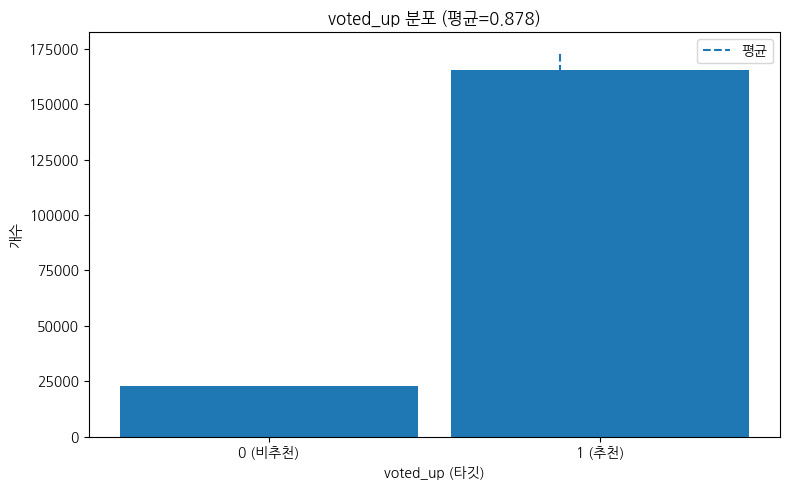

[INFO] pos_rate / app_baseline_rate 없음 → 해당 그래프 생략


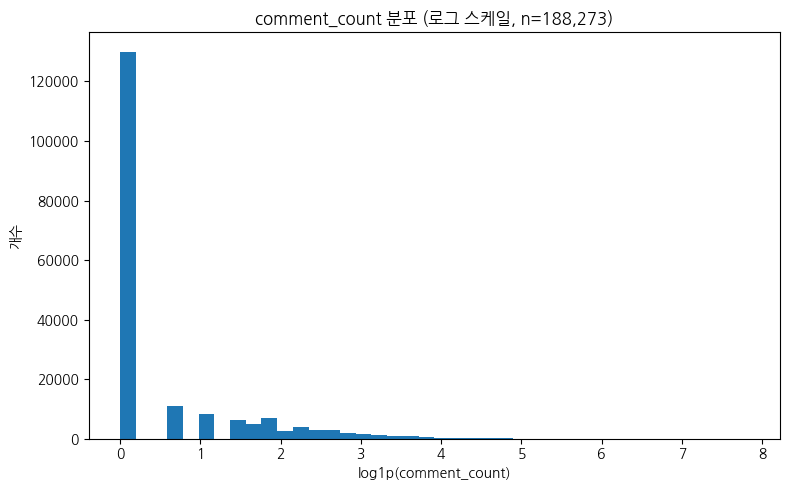

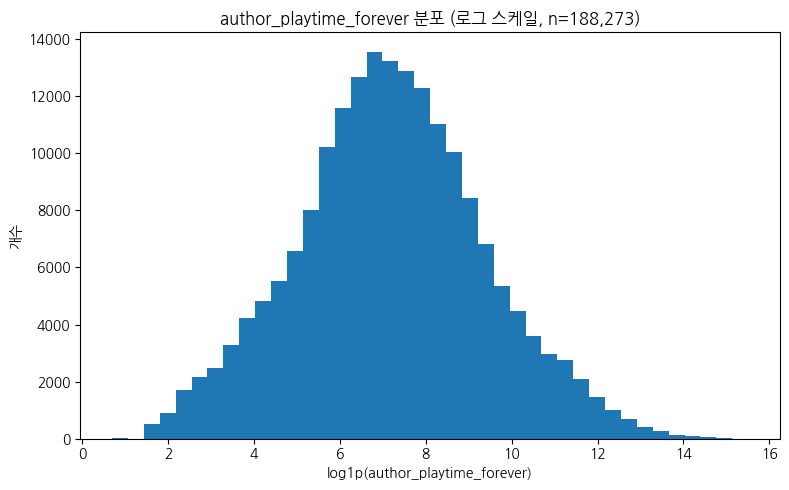

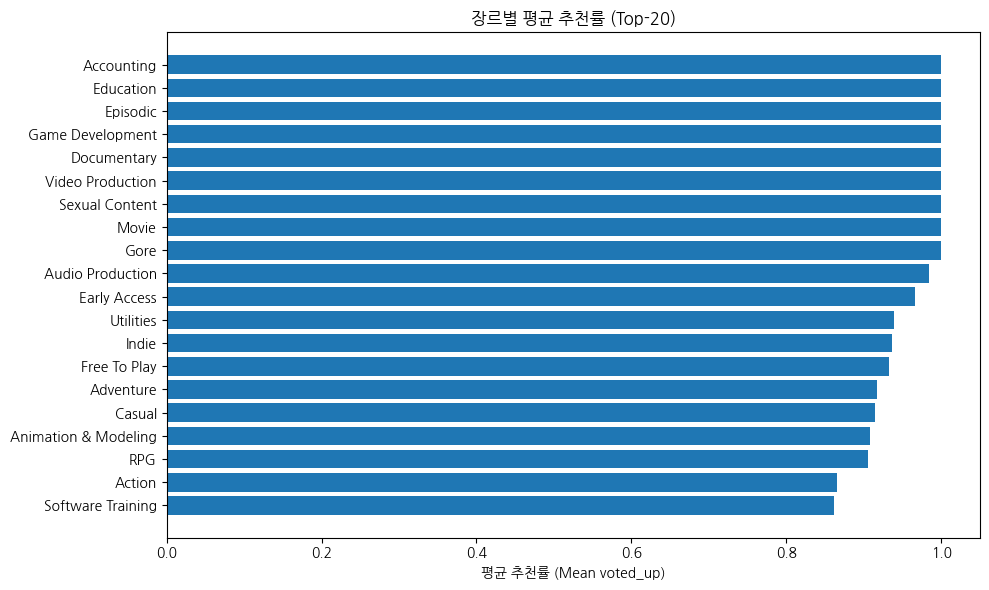

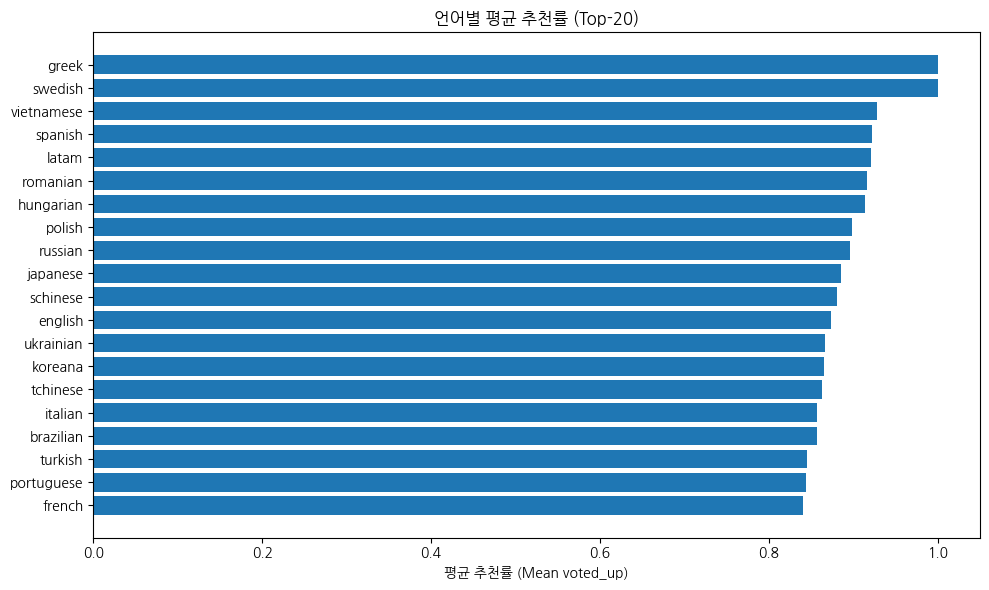

[SAVE] 요약 CSV: /content/_viz_exports/current_state_snapshot_20250930_063935.csv
[SAVE] 이미지: /content/_viz_exports/state_voted_up_hist_20250930_063928.png
[SAVE] 이미지: /content/_viz_exports/state_comment_count_loghist_20250930_063929.png
[SAVE] 이미지: /content/_viz_exports/state_author_playtime_forever_loghist_20250930_063930.png
[SAVE] 이미지: /content/_viz_exports/state_genres1_mean_up_top20_20250930_063930.png
[SAVE] 이미지: /content/_viz_exports/state_language_mean_up_top20_20250930_063933.png
[DONE] 현재 상태 시각화 완료.


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
current_state_viz_ko.py

현 시점 '데이터 상태' 시각화 전용 (모델/계수 X)
- 입력: --csv 또는 --paths (글롭 여러 개)
- 출력: 분포/그룹 비교 그래프 + 요약 CSV
- 화면 표시: plt.show() 포함 (저장 병행)

차트 목록
1) voted_up 분포(0/1 히스토그램 + 평균선)
2) pos_rate 또는 app_baseline_rate 분포(스케일 자동판단)
3) comment_count 분포(log)
4) author_playtime_forever 분포(log)
5) 장르(genres1)별 평균 추천률 Top-K
6) 언어(language)별 평균 추천률 Top-K
"""

import os, sys, glob, argparse, warnings
from datetime import datetime
from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

warnings.filterwarnings("ignore")

TARGET = "voted_up"
CAND_NUM = ["pos_rate", "app_baseline_rate", "comment_count", "author_playtime_forever"]
CAT_K1   = "genres1"
CAT_K2   = "language"

# ---------- 한글 폰트 설정 ----------
def _set_korean_font():
    """
    실행 환경에 설치된 한글 폰트를 자동 탐색해 설정합니다.
    (우선순위: Malgun Gothic, AppleGothic, NanumGothic, Noto Sans CJK, DejaVu Sans)
    """
    candidates = [
        "Malgun Gothic", "AppleGothic", "NanumGothic",
        "Noto Sans CJK KR", "Noto Sans CJK", "Noto Sans",
        "DejaVu Sans"
    ]
    installed = {f.name for f in font_manager.fontManager.ttflist}
    chosen = None
    for name in candidates:
        if name in installed:
            chosen = name
            break
    if chosen is None:
        # 마지막 안전장치
        chosen = rcParams.get("font.sans-serif", ["DejaVu Sans"])[0]
    rcParams["font.family"] = chosen
    rcParams["axes.unicode_minus"] = False  # 음수 기호 깨짐 방지
    print(f"[INFO] 한글 폰트: {chosen}")

_set_korean_font()

# ---------- utils ----------
def _expand_paths(paths: List[str]) -> List[str]:
    out = []
    for p in paths:
        out.extend(glob.glob(p))
    # 중복 제거 & 파일만
    uniq = []
    for f in out:
        if os.path.isfile(f) and f not in uniq:
            uniq.append(f)
    return uniq

def _pick_best_csv(cands: List[str]) -> str:
    if not cands: return ""
    # voted_up 존재 우선
    for f in cands:
        try:
            h = pd.read_csv(f, nrows=2000, low_memory=False)
            if TARGET in h.columns:
                return f
        except Exception:
            pass
    return cands[0]

def _infer_pos_like(df: pd.DataFrame) -> Tuple[str, float, float, str]:
    """
    pos_rate가 있으면 그걸, 없으면 app_baseline_rate 사용.
    반환: (col, lo, hi, scale_tag)  # 스케일 하한/상한 + 라벨 표기용 태그
    scale_tag ∈ {"0-1", "0-100"}
    """
    if "pos_rate" in df.columns:
        s = pd.to_numeric(df["pos_rate"], errors="coerce").dropna()
        if s.empty: return "pos_rate", 0.0, 1.0, "0-1"
        mx = float(s.quantile(0.95))
        return ("pos_rate", 0.0, 1.0, "0-1") if mx <= 1.2 else ("pos_rate", 0.0, 100.0, "0-100")
    if "app_baseline_rate" in df.columns:
        s = pd.to_numeric(df["app_baseline_rate"], errors="coerce").dropna()
        if s.empty: return "app_baseline_rate", 0.0, 1.0, "0-1"
        mx = float(s.quantile(0.95))
        return ("app_baseline_rate", 0.0, 1.0, "0-1") if mx <= 1.2 else ("app_baseline_rate", 0.0, 100.0, "0-100")
    return "", 0.0, 1.0, "0-1"

def _safe_num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def _save_show(figpath: str):
    plt.tight_layout()
    plt.savefig(figpath, dpi=150)
    plt.show()
    plt.close()

# ---------- plotting ----------
def plot_target_hist(df: pd.DataFrame, outdir: str):
    if TARGET not in df.columns:
        print("[WARN] 'voted_up' 컬럼이 없어 분포 그래프를 건너뜁니다.")
        return None
    s = _safe_num(df[TARGET].dropna().astype(int))
    if s.empty: return None
    m = s.mean()
    plt.figure(figsize=(8,5))
    plt.hist(s.values, bins=[-0.5,0.5,1.5], rwidth=0.9)
    plt.xticks([0,1], ["0 (비추천)", "1 (추천)"])
    plt.xlabel("voted_up (타깃)")
    plt.ylabel("개수")
    plt.title(f"voted_up 분포 (평균={m:.3f})")
    ymin, ymax = plt.ylim()
    # 평균선(세로)
    plt.vlines(m, ymin, ymax, linestyles="dashed", label="평균")
    plt.legend(loc="upper right")
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    path = os.path.join(outdir, f"state_voted_up_hist_{ts}.png")
    _save_show(path)
    return path

def plot_pos_like_hist(df: pd.DataFrame, outdir: str):
    col, lo, hi, tag = _infer_pos_like(df)
    if not col:
        print("[INFO] pos_rate / app_baseline_rate 없음 → 해당 그래프 생략")
        return None
    s = _safe_num(df[col]).dropna()
    if s.empty: return None
    s = s.clip(lo, hi)
    bins = 30
    plt.figure(figsize=(8,5))
    plt.hist(s.values, bins=bins)
    xlabel = f"{col} (스케일: {tag})"
    plt.xlabel(xlabel)
    plt.ylabel("개수")
    plt.title(f"{col} 분포 (n={len(s):,})")
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    path = os.path.join(outdir, f"state_{col}_hist_{ts}.png")
    _save_show(path)
    return path

def plot_log_hist(df: pd.DataFrame, col: str, outdir: str, bins: int = 40):
    if col not in df.columns:
        print(f"[INFO] '{col}' 없음 → 로그 분포 생략")
        return None
    s = _safe_num(df[col]).dropna()
    if s.empty: return None
    v = np.log1p(s.values)  # log(1+x)
    plt.figure(figsize=(8,5))
    plt.hist(v, bins=bins)
    plt.xlabel(f"log1p({col})")
    plt.ylabel("개수")
    plt.title(f"{col} 분포 (로그 스케일, n={len(s):,})")
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    path = os.path.join(outdir, f"state_{col}_loghist_{ts}.png")
    _save_show(path)
    return path

def plot_groupbar_mean_up(df: pd.DataFrame, cat: str, outdir: str, topk: int):
    if (cat not in df.columns) or (TARGET not in df.columns):
        print(f"[INFO] '{cat}' 또는 '{TARGET}' 없음 → 그룹 평균 그래프 생략")
        return None
    sub = df[[cat, TARGET]].copy()
    sub[TARGET] = _safe_num(sub[TARGET])
    sub = sub.dropna()
    if sub.empty: return None
    g = sub.groupby(cat, dropna=True)[TARGET].mean().sort_values(ascending=False).head(topk)
    if g.empty: return None
    plt.figure(figsize=(10,6))
    y = np.arange(len(g))
    plt.barh(y, g.values)
    plt.yticks(y, g.index.astype(str))
    plt.xlabel("평균 추천률 (Mean voted_up)")
    title_ko = "장르별 평균 추천률 (Top-{})".format(topk) if cat == "genres1" else "언어별 평균 추천률 (Top-{})".format(topk) if cat == "language" else f"{cat}별 평균 추천률 (Top-{topk})"
    plt.title(title_ko)
    plt.gca().invert_yaxis()
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    path = os.path.join(outdir, f"state_{cat}_mean_up_top{topk}_{ts}.png")
    _save_show(path)
    return path

# ---------- summary ----------
def snapshot_stats(df: pd.DataFrame, outdir: str) -> str:
    rows = []
    def add_row(name, s: pd.Series):
        s = _safe_num(s)
        rows.append({
            "지표": name,
            "유효개수": int(s.notna().sum()),
            "결측개수": int(s.isna().sum()),
            "mean": float(np.nanmean(s)) if s.notna().any() else np.nan,
            "median": float(np.nanmedian(s)) if s.notna().any() else np.nan,
            "p95": float(np.nanpercentile(s, 95)) if s.notna().any() else np.nan,
            "p99": float(np.nanpercentile(s, 99)) if s.notna().any() else np.nan,
        })

    if TARGET in df.columns: add_row("voted_up", df[TARGET])
    for c in CAND_NUM:
        if c in df.columns: add_row(c, df[c])

    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    path = os.path.join(outdir, f"current_state_snapshot_{ts}.csv")
    pd.DataFrame(rows).to_csv(path, index=False)
    return path

# ---------- main ----------
def main():
    ap = argparse.ArgumentParser(description="현 시점 데이터 상태 시각화 (한글 라벨)")
    ap.add_argument("--csv", type=str, default=None, help="단일 CSV 경로")
    ap.add_argument("--paths", type=str, nargs="*", default=None, help="여러 경로/글롭 (예: '/content/*.csv' '/mnt/data/*.csv')")
    ap.add_argument("--outdir", type=str, default="/content/_viz_exports", help="이미지/스냅샷 저장 폴더")
    ap.add_argument("--topk", type=int, default=20, help="범주 Top-K (기본 20)")
    args = ap.parse_args()

    os.makedirs(args.outdir, exist_ok=True)

    chosen = None
    loaded = []

    if args.csv and os.path.isfile(args.csv):
        chosen = args.csv
        loaded = [args.csv]
    if chosen is None and args.paths:
        cand = _expand_paths(args.paths)
        loaded = cand
        chosen = _pick_best_csv(cand)
    if chosen is None:
        defaults = ["/content/S-team_250930-final.csv", "/mnt/data/S-team_250930-final.csv"]
        cand = [p for p in defaults if os.path.isfile(p)]
        loaded = cand
        chosen = cand[0] if cand else None

    print(f"[INFO] 후보 파일: {loaded}")
    if not chosen:
        print("[FATAL] CSV를 찾지 못했습니다. --csv 또는 --paths 를 확인하세요.", file=sys.stderr)
        sys.exit(2)

    print(f"[READ] {chosen}")
    df = pd.read_csv(chosen, low_memory=False)
    print(f"[SHAPE] 행={len(df):,}, 열={len(df.columns)}")

    # ---- plots ----
    out_paths = []

    p = plot_target_hist(df, args.outdir)
    if p: out_paths.append(p)

    p = plot_pos_like_hist(df, args.outdir)
    if p: out_paths.append(p)

    if "comment_count" in df.columns:
        p = plot_log_hist(df, "comment_count", args.outdir)
        if p: out_paths.append(p)

    if "author_playtime_forever" in df.columns:
        p = plot_log_hist(df, "author_playtime_forever", args.outdir)
        if p: out_paths.append(p)

    p = plot_groupbar_mean_up(df, CAT_K1, args.outdir, args.topk)
    if p: out_paths.append(p)

    p = plot_groupbar_mean_up(df, CAT_K2, args.outdir, args.topk)
    if p: out_paths.append(p)

    snap = snapshot_stats(df, args.outdir)

    print("[SAVE] 요약 CSV:", snap)
    for x in out_paths:
        print("[SAVE] 이미지:", x)
    print("[DONE] 현재 상태 시각화 완료.")

if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
import statsmodels.api as sm

# CSV 불러오기 (경로 맞게 수정하세요)
df = pd.read_csv("/content/S-team_250930-final.csv")

# 필요한 컬럼만 선택
cols = ["voted_up", "votes_up", "votes_funny", "comment_count"]
df = df[cols].dropna()

# 종속변수 (리뷰 가치 = voted_up: 0/1)
y = df["voted_up"].astype(int)

# 독립변수 (커뮤니티 반응 3개)
X = df[["votes_up", "votes_funny", "comment_count"]]

# 상수항 추가
X = sm.add_constant(X)

# 로지스틱 회귀 적합
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# 결과 요약
print(result.summary())

# ---------- Pseudo-R² (McFadden) ----------
llf = result.llf      # log-likelihood of fitted model
llnull = result.llnull # log-likelihood of null model (상수만 있는 경우)
pseudo_r2 = 1 - (llf / llnull)
print(f"Pseudo-R² (McFadden): {pseudo_r2:.4f}")


Optimization terminated successfully.
         Current function value: 0.365392
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               voted_up   No. Observations:               188273
Model:                          Logit   Df Residuals:                   188269
Method:                           MLE   Df Model:                            3
Date:                Wed, 01 Oct 2025   Pseudo R-squ.:                 0.01236
Time:                        05:50:09   Log-Likelihood:                -68793.
converged:                       True   LL-Null:                       -69654.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.0246      0.008    254.192      0.000       2.009       2.040
votes_up         -0.

In [ ]:
import pandas as pd
import statsmodels.api as sm

# CSV 로드 (경로 맞게 수정하세요)
df = pd.read_csv("/content/S-team_250930-final.csv")

# 필요한 컬럼 선택
cols = ["weighted_vote_score", "votes_up", "votes_funny", "comment_count"]
df = df[cols].dropna()

# 종속변수 (리뷰 가치)
y = df["weighted_vote_score"]

# 독립변수 (커뮤니티 반응 3개)
X = df[["votes_up", "votes_funny", "comment_count"]]

# 상수항 추가
X = sm.add_constant(X)

# 선형회귀 적합
model = sm.OLS(y, X).fit()

# 결과 요약 출력
print(model.summary())

# 결정계수 (R²)
print(f"\nR²: {model.rsquared:.4f}")
print(f"Adj. R²: {model.rsquared_adj:.4f}")


                             OLS Regression Results                            
Dep. Variable:     weighted_vote_score   R-squared:                       0.141
Model:                             OLS   Adj. R-squared:                  0.141
Method:                  Least Squares   F-statistic:                 1.029e+04
Date:                 Wed, 01 Oct 2025   Prob (F-statistic):               0.00
Time:                         05:59:26   Log-Likelihood:             3.2407e+05
No. Observations:               188273   AIC:                        -6.481e+05
Df Residuals:                   188269   BIC:                        -6.481e+05
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8587      0.000 

In [ ]:
import pandas as pd
import statsmodels.api as sm

# CSV 불러오기 (경로 맞게 수정)
df = pd.read_csv("/content/S-team_250930-final.csv")

# 필요한 컬럼만 선택
cols = ["weighted_vote_score", "votes_up", "votes_funny"]
df = df[cols].dropna()

# 종속변수 (리뷰 가치)
y = df["weighted_vote_score"]

# 독립변수 (보츠업, 보츠퍼니)
X = df[["votes_up", "votes_funny"]]

# 상수항 추가 (절편 d 추정)
X = sm.add_constant(X)

# OLS 회귀 적합
model = sm.OLS(y, X).fit()

# 결과 요약
print(model.summary())

# 계수 확인 (a, b, d)
a = model.params["votes_up"]
b = model.params["votes_funny"]
d = model.params["const"]
print(f"\n회귀식: weighted_vote_score ≈ {d:.4f} + {a:.4f}*votes_up + {b:.4f}*votes_funny")

# R² (설명력)
print(f"R²: {model.rsquared:.4f}, Adj R²: {model.rsquared_adj:.4f}")


                             OLS Regression Results                            
Dep. Variable:     weighted_vote_score   R-squared:                       0.141
Model:                             OLS   Adj. R-squared:                  0.141
Method:                  Least Squares   F-statistic:                 1.542e+04
Date:                 Wed, 01 Oct 2025   Prob (F-statistic):               0.00
Time:                         06:06:21   Log-Likelihood:             3.2406e+05
No. Observations:               188273   AIC:                        -6.481e+05
Df Residuals:                   188270   BIC:                        -6.481e+05
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8587      0.000   7895

In [ ]:
# -*- coding: utf-8 -*-
"""
tree_xai_review_value_colab_rmsepatch.py

가설-증명 연결 강화용: Tree 계열 + SHAP (Notebook-friendly)
- 기본: 회귀  (target = weighted_vote_score)
- 옵션: 분류  (target = voted_up)  -> CONFIG["task"] = "clf"
- 설명변수 기본: votes_up, votes_funny, comment_count
- 산출: metrics.json, feature_importance.csv/png, shap_summary_{bar,beeswarm}.png, analysis_note.txt
- 주의: sklearn 구버전 호환을 위해 RMSE는 sqrt(MSE)로 직접 계산 (squared=False 미사용)
"""

import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# CONFIG (여기만 바꿔서 쓰세요)
# =========================
CONFIG = {
    "csv": "/content/S-team_250930-final.csv",      # 데이터 경로
    "task": "reg",                                   # "reg"=회귀 | "clf"=분류
    "target": "weighted_vote_score",                 # 회귀 타깃; 분류면 "voted_up"
    "features": ["votes_up", "votes_funny", "comment_count"],
    "test_size": 0.2,
    "random_state": 42,
    "outdir": "_tree_xai_out"
}

# =========================
# Optional deps import
# =========================
LGBM_OK = XGB_OK = False
try:
    from lightgbm import LGBMRegressor, LGBMClassifier
    LGBM_OK = True
except Exception:
    pass

try:
    from xgboost import XGBRegressor, XGBClassifier
    XGB_OK = True
except Exception:
    pass

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error,
    roc_auc_score, log_loss
)

try:
    import shap
    SHAP_OK = True
except Exception:
    SHAP_OK = False


# =========================
# Utils
# =========================
def ensure_outdir(d):
    os.makedirs(d, exist_ok=True)
    return d

def plot_importance(imp_series: pd.Series, out_png: str):
    plt.figure(figsize=(6, 4))
    imp_series.sort_values(ascending=True).plot(kind="barh")
    plt.title("Feature importance (model-based)")
    plt.tight_layout()
    plt.savefig(out_png, dpi=220)
    plt.close()

def save_metrics_json(path, d):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(d, f, ensure_ascii=False, indent=2)

def clip_extreme(X: pd.DataFrame, low_q=0.001, high_q=0.999):
    X = X.copy()
    for c in X.columns:
        try:
            lo = X[c].quantile(low_q)
            hi = X[c].quantile(high_q)
            X[c] = X[c].clip(lower=lo, upper=hi)
        except Exception:
            pass
    return X


# =========================
# Train functions (RMSE patch)
# =========================
def train_reg(Xtr, ytr, Xte, yte, random_state=42):
    # LightGBM -> XGBoost -> RandomForest fallback
    if LGBM_OK:
        model = LGBMRegressor(
            n_estimators=600, learning_rate=0.03, subsample=0.8,
            colsample_bytree=0.8, num_leaves=63, random_state=random_state
        )
        model_name = "LightGBMRegressor"
    elif XGB_OK:
        model = XGBRegressor(
            n_estimators=700, learning_rate=0.03, subsample=0.8,
            colsample_bytree=0.8, max_depth=8, random_state=random_state, tree_method="hist"
        )
        model_name = "XGBRegressor"
    else:
        model = RandomForestRegressor(
            n_estimators=600, max_depth=None, min_samples_split=2,
            random_state=random_state, n_jobs=-1
        )
        model_name = "RandomForestRegressor"

    model.fit(Xtr, ytr)
    p_tr = model.predict(Xtr)
    p_te = model.predict(Xte)

    # RMSE = sqrt(MSE)  (구버전 sklearn 호환)
    mse_tr = mean_squared_error(ytr, p_tr)
    mse_te = mean_squared_error(yte, p_te)
    rmse_tr = float(np.sqrt(mse_tr))
    rmse_te = float(np.sqrt(mse_te))

    metrics = {
        "model": model_name,
        "r2_train": float(r2_score(ytr, p_tr)),
        "r2_test":  float(r2_score(yte, p_te)),
        "rmse_train": rmse_tr,
        "rmse_test":  rmse_te,
        "mae_train": float(mean_absolute_error(ytr, p_tr)),
        "mae_test":  float(mean_absolute_error(yte, p_te)),
    }
    return model, metrics, p_te

def train_clf(Xtr, ytr, Xte, yte, random_state=42):
    if LGBM_OK:
        model = LGBMClassifier(
            n_estimators=800, learning_rate=0.03, subsample=0.8, colsample_bytree=0.8,
            num_leaves=63, random_state=random_state
        )
        model_name = "LightGBMClassifier"
    elif XGB_OK:
        model = XGBClassifier(
            n_estimators=900, learning_rate=0.03, subsample=0.8, colsample_bytree=0.8,
            max_depth=8, random_state=random_state, tree_method="hist", eval_metric="logloss"
        )
        model_name = "XGBClassifier"
    else:
        model = RandomForestClassifier(
            n_estimators=800, max_depth=None, min_samples_split=2,
            random_state=random_state, n_jobs=-1
        )
        model_name = "RandomForestClassifier"

    model.fit(Xtr, ytr)
    if hasattr(model, "predict_proba"):
        p_tr = model.predict_proba(Xtr)[:, 1]
        p_te = model.predict_proba(Xte)[:, 1]
    else:
        p_tr = model.predict(Xtr)
        p_te = model.predict(Xte)

    # Null model prob (baseline) for McFadden-like ratio
    p_null = np.repeat(ytr.mean(), len(yte))

    metrics = {
        "model": model_name,
        "auc_train": float(roc_auc_score(ytr, p_tr)),
        "auc_test":  float(roc_auc_score(yte, p_te)),
        "logloss_train": float(log_loss(ytr, p_tr, eps=1e-7)),
        "logloss_test":  float(log_loss(yte, p_te, eps=1e-7)),
        "pseudo_r2_mcfadden_like": float(1 - (log_loss(yte, p_te, eps=1e-7) / log_loss(yte, p_null, eps=1e-7))),
    }
    return model, metrics, p_te

def compute_importance(model, X_cols):
    if hasattr(model, "feature_importances_"):
        return pd.Series(model.feature_importances_, index=X_cols)
    return pd.Series(np.ones(len(X_cols)), index=X_cols)  # Fallback


# =========================
# SHAP
# =========================
def run_shap(model, Xtr, Xte, outdir, task="reg"):
    if not SHAP_OK:
        print("[WARN] shap이 설치되어 있지 않아 SHAP 시각화를 건너뜁니다. (pip install shap)")
        return None

    try:
        explainer = shap.TreeExplainer(model, feature_names=Xtr.columns.tolist())
        sv = explainer.shap_values(Xte)
    except Exception as e:
        print(f"[WARN] TreeExplainer 실패({e}) → KernelExplainer로 폴백 (느림)")
        bg = shap.sample(Xtr, 200, random_state=42)
        if task == "reg":
            pred_fn = model.predict
        else:
            pred_fn = (lambda x: model.predict_proba(x)[:, 1]) if hasattr(model, "predict_proba") else model.predict
        explainer = shap.KernelExplainer(pred_fn, bg)
        sv = explainer.shap_values(shap.sample(Xte, 500, random_state=42))

    # Summary bar
    plt.figure()
    shap.summary_plot(sv, Xte, plot_type="bar", show=False)
    out_bar = os.path.join(outdir, "shap_summary_bar.png")
    plt.tight_layout(); plt.savefig(out_bar, dpi=220); plt.close()

    # Beeswarm
    plt.figure()
    shap.summary_plot(sv, Xte, show=False)
    out_bee = os.path.join(outdir, "shap_summary_beeswarm.png")
    plt.tight_layout(); plt.savefig(out_bee, dpi=220); plt.close()

    print(f"[SHAP] saved: {out_bar}, {out_bee}")
    return {"bar": out_bar, "beeswarm": out_bee}


# =========================
# MAIN (Notebook-friendly)
# =========================
def run_pipeline(cfg: dict):
    outdir = ensure_outdir(cfg["outdir"])
    print(f"[INFO] csv={cfg['csv']}")
    df = pd.read_csv(cfg["csv"])

    need = [cfg["target"]] + list(cfg["features"])
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError(f"필수 컬럼이 없습니다: {missing}")

    df2 = df[need].dropna()
    if cfg["task"] == "clf":
        y = pd.to_numeric(df2[cfg["target"]], errors="coerce").fillna(0).astype(int)
    else:
        y = pd.to_numeric(df2[cfg["target"]], errors="coerce")
    X = df2[cfg["features"]].copy()

    # 카운트형 극단값 완화 (outlier clip)
    X = clip_extreme(X, 0.001, 0.999)

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=cfg["test_size"], random_state=cfg["random_state"],
        stratify=y if cfg["task"] == "clf" else None
    )

    if cfg["task"] == "reg":
        model, metrics, _ = train_reg(Xtr, ytr, Xte, yte, cfg["random_state"])
    else:
        model, metrics, _ = train_clf(Xtr, ytr, Xte, yte, cfg["random_state"])

    print("[METRICS]", metrics)
    save_metrics_json(os.path.join(outdir, "metrics.json"), metrics)

    # Feature importance
    imp = compute_importance(model, X.columns)
    imp.sort_values(ascending=False).to_csv(os.path.join(outdir, "feature_importance.csv"))
    plot_importance(imp, os.path.join(outdir, "feature_importance.png"))
    print(f"[IMP] saved: feature_importance.csv, feature_importance.png")

    # SHAP
    _ = run_shap(model, Xtr, Xte, outdir, task=cfg["task"])

    # 연결 서술 노트
    with open(os.path.join(outdir, "analysis_note.txt"), "w", encoding="utf-8") as f:
        f.write("가설: 커뮤니티 반응(보츠업/보츠퍼니/댓글수)이 리뷰 가치를 결정한다.\n")
        f.write(f"- 타깃: {cfg['target']} | 설명변수: {', '.join(cfg['features'])} | 모델: {metrics['model']}\n")
        if cfg["task"] == "reg":
            f.write(
                f"- 성능(R²_test={metrics['r2_test']:.3f}, RMSE_test={metrics['rmse_test']:.3f}, "
                f"MAE_test={metrics['mae_test']:.3f})\n"
                "- 해석: R²가 높을수록 커뮤니티 반응이 리뷰 가치 변동을 잘 설명.\n"
            )
        else:
            f.write(
                f"- 성능(AUC_test={metrics['auc_test']:.3f}, LogLoss_test={metrics['logloss_test']:.3f}, "
                f"PseudoR2_like={metrics['pseudo_r2_mcfadden_like']:.3f})\n"
                "- 해석: AUC가 높을수록 커뮤니티 반응으로 리뷰 가치(추천 확률)를 잘 예측.\n"
            )
        f.write(
            "- 피처중요도/SHAP에서 댓글수·보츠업·보츠퍼니의 기여도를 시각적으로 제시함으로써, "
            "가설(커뮤니티 반응의 중요성)과 증명(모델이 실제로 그 변수를 주요 요인으로 선택함) 사이의 연결을 강화.\n"
        )
    print("[DONE] outputs saved to:", outdir)

# =========================
# Execute
# =========================
run_pipeline(CONFIG)


[INFO] csv=/content/S-team_250930-final.csv
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 150618, number of used features: 3
[LightGBM] [Info] Start training from score 0.866425
[METRICS] {'model': 'LightGBMRegressor', 'r2_train': 0.5867395516844248, 'r2_test': 0.5614807908762978, 'rmse_train': 0.03002208135190258, 'rmse_test': 0.0308748673645941, 'mae_train': 0.023488927354865272, 'mae_test': 0.023945532808714375}
[IMP] saved: feature_importance.csv, feature_importance.png
[SHAP] saved: _tree_xai_out/shap_summary_bar.png, _tree_xai_out/shap_summary_beeswarm.png
[DONE] outputs saved to: _tree_xai_out


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
LightGBM 회귀 (target=weighted_vote_score)
- JSON 특수문자 포함 컬럼명 → 안전한 이름으로 일괄 치환 (중복시 _n 부여)
- early stopping: callbacks (구버전 LightGBM 호환)
"""

import os, json, argparse, warnings, re
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

# -----------------------------
# Utils
# -----------------------------
def ensure_dir(d):
    if d and not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

def safe_mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def load_csv(path):
    print(f"[INFO] csv={path}", end=" ")
    df = pd.read_csv(path)
    print(f"rows={len(df):,}, cols={df.shape[1]}")
    return df

def sanitize_feature_names(df: pd.DataFrame):
    """
    LightGBM이 거부하는 JSON 특수문자 제거.
    - 허용: [A-Za-z0-9_]
    - 나머지는 '_'로 대체, 연속 '_' 축소, 양끝 '_' 제거
    - 충돌 시 _1, _2… 부여
    """
    old_cols = list(df.columns)
    new_cols = []
    used = {}

    def _clean(name: str) -> str:
        # 1) 비허용 문자 -> '_'
        s = re.sub(r'[^A-Za-z0-9_]', '_', str(name))
        # 2) 연속 '_' 축소
        s = re.sub(r'_+', '_', s)
        # 3) 앞뒤 '_' 제거
        s = s.strip('_')
        # 4) 빈 문자열이면 대체
        if s == "":
            s = "col"
        return s

    for c in old_cols:
        base = _clean(c)
        candidate = base
        k = 1
        while candidate in used:
            k += 1
            candidate = f"{base}_{k}"
        used[candidate] = True
        new_cols.append(candidate)

    mapping = dict(zip(old_cols, new_cols))
    df_renamed = df.rename(columns=mapping)
    return df_renamed, mapping

def infer_features(df, target):
    all_cols = list(df.columns)
    if target not in all_cols:
        raise ValueError(f"target '{target}' not in columns after rename")
    drop_like = {"review_id", "id", "index"}
    drop_cols = [c for c in all_cols if c.lower() in drop_like]
    feat_cols = [c for c in all_cols if c not in drop_cols + [target]]
    return feat_cols

def cast_categoricals(df, feat_cols):
    obj_cols = [c for c in feat_cols if df[c].dtype == "object"]
    for c in obj_cols:
        df[c] = df[c].astype("category")
    return [c for c in feat_cols if str(df[c].dtype) == "category"]

# -----------------------------
# Train & Evaluate
# -----------------------------
def train_eval_lgbm(df, target, outdir, test_size=0.2, random_state=42):
    print(f"[INFO] target = {target}")

    feat_cols = infer_features(df, target)
    cat_cols = cast_categoricals(df, feat_cols)

    X = df[feat_cols].copy()
    y = df[target].astype(float).values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    params = dict(
        n_estimators=3000,
        learning_rate=0.03,
        num_leaves=63,
        min_data_in_leaf=200,     # 경고는 무시 가능
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model = LGBMRegressor(**params)

    # 구버전 호환: callbacks 사용
    cbs = [early_stopping(stopping_rounds=200), log_evaluation(100)]
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="l2",     # MSE
        callbacks=cbs
    )

    y_pred = model.predict(X_test)

    mse  = mean_squared_error(y_test, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = float(mean_absolute_error(y_test, y_pred))
    r2   = float(r2_score(y_test, y_pred))
    mape = safe_mape(y_test, y_pred)

    metrics = {
        "RMSE": rmse, "MAE": mae, "R2": r2, "MAPE_%": mape,
        "best_iteration": int(getattr(model, "best_iteration_", 0) or len(model.evals_result_['valid_0']['l2'])),
        "n_features": int(X.shape[1]),
        "n_train": int(X_train.shape[0]),
        "n_test": int(X_test.shape[0]),
        "n_cat_features": len(cat_cols)
    }
    print("[METRICS]", json.dumps(metrics, ensure_ascii=False, indent=2))

    ensure_dir(outdir)
    # 예측 저장
    pred_df = X_test.copy()
    pred_df[target + "_true"] = y_test
    pred_df[target + "_pred"] = y_pred
    pred_df.to_csv(os.path.join(outdir, "predictions.csv"), index=False)

    # 피처 중요도 저장
    try:
        fi = pd.DataFrame({
            "feature": feat_cols,
            "importance_gain": model.booster_.feature_importance(importance_type="gain"),
            "importance_split": model.booster_.feature_importance(importance_type="split"),
            "dtype": [str(X[c].dtype) for c in feat_cols]
        }).sort_values("importance_gain", ascending=False)
        fi.to_csv(os.path.join(outdir, "feature_importance.csv"), index=False)
    except Exception as e:
        print(f"[WARN] feature_importance export skipped: {e}")

    with open(os.path.join(outdir, "metrics.json"), "w", encoding="utf-8") as f:
        json.dump(metrics, f, ensure_ascii=False, indent=2)

    return model, metrics

# -----------------------------
# Main
# -----------------------------
def main(args):
    raw = load_csv(args.csv)

    # 1) 컬럼명 정화 + 매핑 저장
    df, mapping = sanitize_feature_names(raw)
    ensure_dir(args.outdir)
    pd.DataFrame(
        [(k, v) for k, v in mapping.items()],
        columns=["old_name", "new_name"]
    ).to_csv(os.path.join(args.outdir, "column_renames.csv"), index=False)

    # 2) 타깃명도 매핑 반영
    target_new = mapping.get(args.target, args.target)

    # 3) 결측 처리(간단)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=[target_new])
    if "comment_count" in df.columns:
        df["comment_count"] = df["comment_count"].fillna(0)

    # 4) 학습
    train_eval_lgbm(df, target_new, args.outdir, args.test_size, args.seed)

if __name__ == "__main__" or True:
    parser = argparse.ArgumentParser()
    parser.add_argument("--csv", type=str, default="/content/S-team_250930-final.csv")
    parser.add_argument("--target", type=str, default="weighted_vote_score")
    parser.add_argument("--outdir", type=str, default="./_lgbm_reg")
    parser.add_argument("--test_size", type=float, default=0.2)
    parser.add_argument("--seed", type=int, default=42)
    args = parser.parse_args(args=[])

    ensure_dir(args.outdir)
    main(args)


[INFO] csv=/content/S-team_250930-final.csv rows=188,273, cols=52
[INFO] target = weighted_vote_score
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31343
[LightGBM] [Info] Number of data points in the train set: 150618, number of used features: 51
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[Lig

In [ ]:
import os, pandas as pd, numpy as np

# 1) 여기서 lgbm_model 확보: 이전 학습 함수가 (model, metrics)를 반환했다면 아래처럼 받았을 겁니다.
# lgbm_model, metrics = train_eval_lgbm(df, target_new, args.outdir, args.test_size, args.seed)
# 만약 현재 세션에 lgbm_model이 없다면, 마지막으로 저장된 feature_importance.csv를 읽어 fallback 하도록 처리합니다.

outdir = args.outdir if 'args' in globals() else "./_lgbm_reg"
fi_path = os.path.join(outdir, "feature_importance.csv")

def _safe_top20_and_save(fi: pd.DataFrame, fi_path: str):
    fi = fi.copy()
    # 중요도 결측/음수 방지
    for col in ["importance_gain", "importance_split"]:
        if col in fi.columns:
            fi[col] = pd.to_numeric(fi[col], errors="coerce").fillna(0.0)
    # 최종 정렬 키: gain 우선, 없으면 split
    sort_key = "importance_gain" if "importance_gain" in fi.columns else "importance_split"
    fi = fi.sort_values(sort_key, ascending=False)
    # 저장
    fi.to_csv(fi_path, index=False)
    # Top-20 출력
    print("=== Top-20 Feature Importance ===")
    print(fi.head(20))
    print(f"[SAVE] feature_importance -> {fi_path}")
    return fi

try:
    # 2) LightGBM 모델에서 직접 추출 (가장 정확)
    #    - booster_ 가 있으면 gain/split 모두 가능
    #    - 없으면 sklearn 속성(feature_importances_)만 사용 가능
    if 'lgbm_model' in globals():
        if hasattr(lgbm_model, "booster_") and lgbm_model.booster_ is not None:
            features = list(lgbm_model.booster_.feature_name())
            gain = lgbm_model.booster_.feature_importance(importance_type="gain")
            split = lgbm_model.booster_.feature_importance(importance_type="split")
            fi = pd.DataFrame({
                "feature": features,
                "importance_gain": gain,
                "importance_split": split
            })
        else:
            # booster_가 없으면 sklearn API만 가능한 환경
            features = getattr(lgbm_model, "feature_name_", None)
            if features is None:
                # 학습에 사용한 피처 리스트가 코드 상에 있다면 그것을 쓰세요 (feat_cols)
                # 여기서는 안전하게 길이를 맞춥니다.
                raise RuntimeError("feature_name_를 찾지 못했습니다. booster_가 없는 sklearn LightGBM은 학습 직후 객체를 사용해야 합니다.")
            split = getattr(lgbm_model, "feature_importances_", None)
            if split is None:
                raise RuntimeError("feature_importances_를 찾지 못했습니다.")
            fi = pd.DataFrame({
                "feature": list(features),
                "importance_split": split
            })
    else:
        # 3) 세션에 모델이 없으면, 직전에 저장된 CSV를 읽어서 Top-20만 보여줌
        if not os.path.exists(fi_path):
            raise RuntimeError("lgbm_model도 없고, feature_importance.csv도 없습니다. 학습 함수를 다시 실행해 lgbm_model을 확보하세요.")
        fi = pd.read_csv(fi_path)

    # 4) 원래 컬럼명 복원(선택): column_renames.csv가 있으면 join
    rename_path = os.path.join(outdir, "column_renames.csv")
    if os.path.exists(rename_path):
        rn = pd.read_csv(rename_path)
        # rn: old_name, new_name
        fi = fi.merge(rn.rename(columns={"new_name": "feature", "old_name": "original_name"}),
                      on="feature", how="left")

    # 5) 저장 + Top-20 출력
    fi = _safe_top20_and_save(fi, fi_path)

except Exception as e:
    print(f"[ERROR] Feature importance extraction failed: {e}")
    if os.path.exists(fi_path):
        print(f"→ Fallback: loading saved file {fi_path}")
        fi = pd.read_csv(fi_path)
        # Top-20 보여주기
        sort_key = "importance_gain" if "importance_gain" in fi.columns else "importance_split"
        fi = fi.sort_values(sort_key, ascending=False)
        print("=== Top-20 Feature Importance (from saved) ===")
        print(fi.head(20))
    else:
        raise


=== Top-20 Feature Importance ===
                      feature  importance_gain  importance_split     dtype  \
0                    votes_up      2893.323949              3596     int64   
1                        game       548.814110             16042  category   
2                 votes_funny       226.537911              1668     int64   
3                    language       180.636770              1221  category   
4                    voted_up       121.883180               555     int64   
5               translated_en        92.614836               944  category   
6             event_start_utc        76.857772              4322  category   
7                    nllb_src        71.692208               270  category   
8                  year_month        70.633514              4840  category   
9              sale_start_utc        68.079398              4151  category   
10                     review        44.708747              1166  category   
11               sale_end_utc 

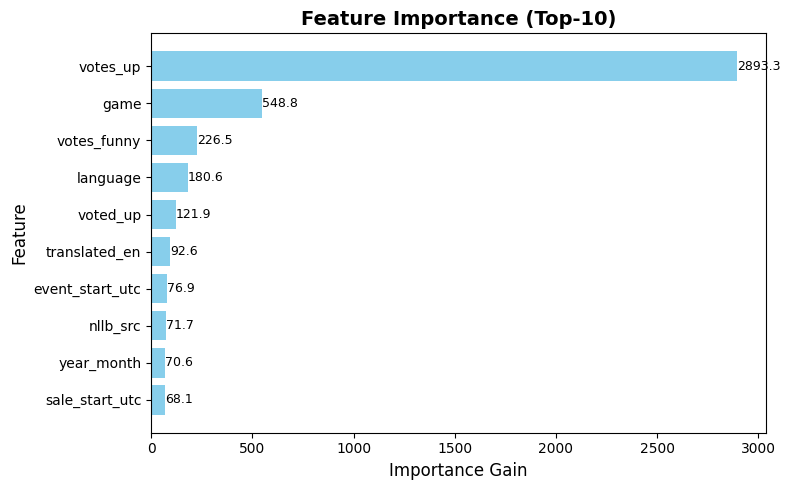

In [ ]:
# feature_importance_top10.py
import pandas as pd
import matplotlib.pyplot as plt

# CSV 불러오기
df = pd.read_csv("./_lgbm_reg/feature_importance.csv")

# importance_gain 기준으로 내림차순 정렬 후 상위 10개 추출
topk = 10
df_top = df.sort_values("importance_gain", ascending=False).head(topk)

# 시각화
plt.figure(figsize=(8,5))
plt.barh(df_top["feature"], df_top["importance_gain"], color="skyblue")
plt.gca().invert_yaxis()  # 상위가 위로 오게
plt.title(f"Feature Importance (Top-{topk})", fontsize=14, weight="bold")
plt.xlabel("Importance Gain", fontsize=12)
plt.ylabel("Feature", fontsize=12)

# 값 라벨 표시
for i, v in enumerate(df_top["importance_gain"]):
    plt.text(v, i, f"{v:.1f}", va="center", fontsize=9)

plt.tight_layout()
plt.show()



=== 성능 비교 (테스트셋) ===
       model       R2     RMSE
A_const_only 0.000000 0.046626
B_voted_only 0.003229 0.046549
 C_comm_only 0.150624 0.042970
      D_both 0.157203 0.042803

=== ΔR² (추가 설명력) ===
- voted_up 추가 설명력 (D - C): 0.006579
- 커뮤니티 반응 추가 설명력 (D - B): 0.153973

=== 퍼뮤테이션 중요도 (모델 D) ===
      feature  perm_importance  perm_std
     votes_up         0.205070  0.002591
  votes_funny         0.017307  0.000549
     voted_up         0.011075  0.000838
comment_count         0.000492  0.000071


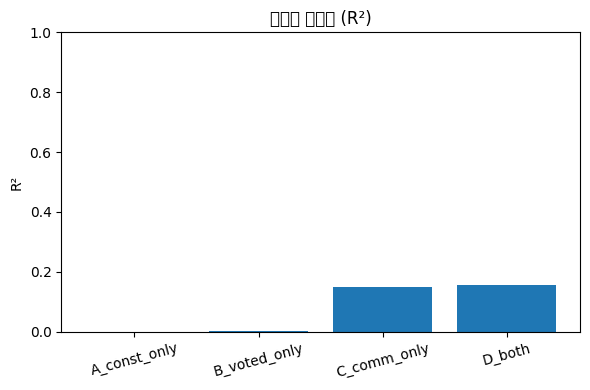

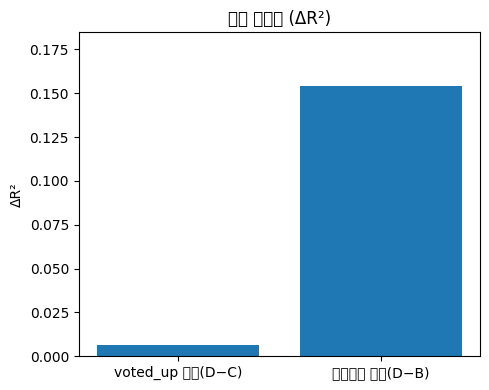

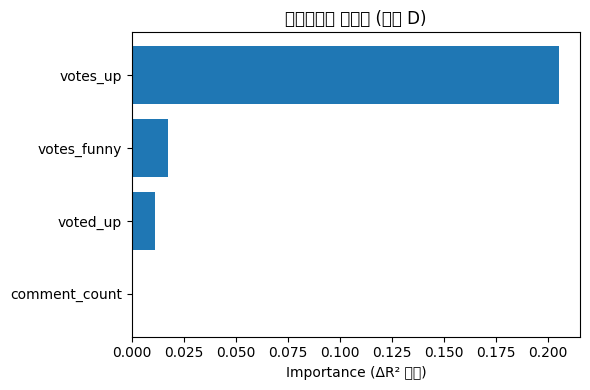


[Saved] /mnt/data/_voted_is_weak/model_perf.csv
[Saved] /mnt/data/_voted_is_weak/permutation_importance_D.csv

해석 가이드:
- B(추천표시만)의 R²가 낮고, C(커뮤니티만)가 높으면 → 추천표시는 설명력이 약함.
- D와 C의 차이(ΔR²=D−C)가 0에 가깝다면 → voted_up의 추가 기여가 사실상 없음.
- 퍼뮤테이션 중요도에서 voted_up이 낮게 나오면 → 커뮤니티 지표 대비 영향 미미.


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
'추천 표시는 큰 의미가 없다'를 정량적으로 증명하는 스크립트 (버전 호환)
- 타깃: weighted_vote_score (연속값)
- 비교 모델:
  A) 상수 기준선(참고)
  B) voted_up 만
  C) 커뮤니티 반응만 (votes_up, votes_funny, comment_count)
  D) B + C 모두
- 산출물:
  1) 모델별 성능표 (R², RMSE)
  2) ΔR² (추가 설명력): voted_up의 추가 기여 = R²(D) - R²(C)
  3) 퍼뮤테이션 중요도(모델 D에서 feature 중요도)
  4) 발표용 그래프 3종
"""

import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance

# -----------------------------
# 0) 설정
# -----------------------------
CSV = "/content/S-team_250930-final.csv"   # 파일 경로 필요시 수정
TARGET = "weighted_vote_score"
VOTE_COL = "voted_up"
COMM_COLS = ["votes_up", "votes_funny", "comment_count"]
RANDOM_STATE = 42
TEST_SIZE = 0.2
ALPHA = 1.0  # Ridge 강도

# -----------------------------
# 1) 데이터 로드/체크
# -----------------------------
df = pd.read_csv(CSV)
need = [TARGET, VOTE_COL] + COMM_COLS
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"필수 컬럼 누락: {missing}")

# 타깃/피처 준비
y = df[TARGET].astype(float)
X_B = df[[VOTE_COL]].copy()
X_C = df[COMM_COLS].copy()
X_D = pd.concat([X_B, X_C], axis=1)

# 결측치 간단 처리(필요시 커스텀 로직 적용)
X_B = X_B.fillna(0)
X_C = X_C.fillna(0)
X_D = X_D.fillna(0)
y = y.fillna(y.median())

# -----------------------------
# 2) 단일 split (모든 블록 동일 split)
# -----------------------------
n = len(df)
indices = np.arange(n)
idx_tr, idx_te = train_test_split(indices, test_size=TEST_SIZE, random_state=RANDOM_STATE)

def split_block(X):
    return X.iloc[idx_tr], X.iloc[idx_te]

X_B_tr, X_B_te = split_block(X_B)
X_C_tr, X_C_te = split_block(X_C)
X_D_tr, X_D_te = split_block(X_D)
y_tr, y_te     = y.iloc[idx_tr], y.iloc[idx_te]

# -----------------------------
# 3) 스케일링(학습셋 기준)
# -----------------------------
def fit_transform_block(Xtr, Xte):
    scaler = StandardScaler()
    Xtr_s = pd.DataFrame(scaler.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
    Xte_s = pd.DataFrame(scaler.transform(Xte), columns=Xte.columns, index=Xte.index)
    return Xtr_s, Xte_s

X_B_trs, X_B_tes = fit_transform_block(X_B_tr, X_B_te)
X_C_trs, X_C_tes = fit_transform_block(X_C_tr, X_C_te)
X_D_trs, X_D_tes = fit_transform_block(X_D_tr, X_D_te)

# -----------------------------
# 4) 모델 학습/평가 유틸
# -----------------------------
def fit_eval_ridge(Xtr, Xte, ytr, yte, alpha=ALPHA):
    mdl = Ridge(alpha=alpha, random_state=RANDOM_STATE)
    mdl.fit(Xtr, ytr)
    pred = mdl.predict(Xte)
    r2  = r2_score(yte, pred)
    rmse = np.sqrt(mean_squared_error(yte, pred))  # 버전 호환
    return mdl, r2, rmse, pred

# 상수 기준선 (A): R²=0으로 두고, RMSE는 y_train 평균 대비
ybar_train = np.repeat(y_tr.mean(), len(y_te))
rmse_A = np.sqrt(mean_squared_error(y_te, ybar_train))
r2_A = 0.0

# B, C, D 학습
mdl_B, r2_B, rmse_B, _   = fit_eval_ridge(X_B_trs, X_B_tes, y_tr, y_te)
mdl_C, r2_C, rmse_C, _   = fit_eval_ridge(X_C_trs, X_C_tes, y_tr, y_te)
mdl_D, r2_D, rmse_D, yD  = fit_eval_ridge(X_D_trs, X_D_tes, y_tr, y_te)

# -----------------------------
# 5) ΔR² (추가 설명력)
# -----------------------------
delta_voted_up  = max(0.0, r2_D - r2_C)  # voted_up이 '추가'로 보태는 설명력
delta_community = max(0.0, r2_D - r2_B)  # 커뮤니티 블록의 '추가' 설명력

summary = pd.DataFrame({
    "model": ["A_const_only", "B_voted_only", "C_comm_only", "D_both"],
    "R2":    [r2_A, r2_B, r2_C, r2_D],
    "RMSE":  [rmse_A, rmse_B, rmse_C, rmse_D]
})

print("\n=== 성능 비교 (테스트셋) ===")
print(summary.to_string(index=False))

print("\n=== ΔR² (추가 설명력) ===")
print(f"- voted_up 추가 설명력 (D - C): {delta_voted_up:.6f}")
print(f"- 커뮤니티 반응 추가 설명력 (D - B): {delta_community:.6f}")

# -----------------------------
# 6) 퍼뮤테이션 중요도 (모델 D 기준)
# -----------------------------
perm = permutation_importance(
    mdl_D, X_D_tes, y_te,
    n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)
imp_df = pd.DataFrame({
    "feature": X_D_tes.columns,
    "perm_importance": perm.importances_mean,
    "perm_std": perm.importances_std
}).sort_values("perm_importance", ascending=False)

print("\n=== 퍼뮤테이션 중요도 (모델 D) ===")
print(imp_df.to_string(index=False))

# -----------------------------
# 7) 시각화 (발표용 3종)
# -----------------------------
plt.figure(figsize=(6,4))
plt.bar(summary["model"], summary["R2"])
plt.title("모델별 설명력 (R²)")
plt.ylabel("R²")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
labels = ["voted_up 추가(D−C)", "커뮤니티 추가(D−B)"]
vals = [delta_voted_up, delta_community]
plt.bar(labels, vals)
plt.title("블록 기여도 (ΔR²)")
plt.ylabel("ΔR²")
plt.ylim(0, max(0.01, max(vals)*1.2))
plt.tight_layout()
plt.show()

topk = imp_df.head(6)  # 상위 6개 정도
plt.figure(figsize=(6,4))
plt.barh(topk["feature"], topk["perm_importance"])
plt.title("퍼뮤테이션 중요도 (모델 D)")
plt.xlabel("Importance (ΔR² 유사)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# -----------------------------
# 8) (선택) CSV 저장 - PPT 반입용
# -----------------------------
outdir = "/mnt/data/_voted_is_weak"
os.makedirs(outdir, exist_ok=True)
summary.to_csv(os.path.join(outdir, "model_perf.csv"), index=False)
imp_df.to_csv(os.path.join(outdir, "permutation_importance_D.csv"), index=False)

print(f"\n[Saved] {os.path.join(outdir, 'model_perf.csv')}")
print(f"[Saved] {os.path.join(outdir, 'permutation_importance_D.csv')}")
print("\n해석 가이드:")
print("- B(추천표시만)의 R²가 낮고, C(커뮤니티만)가 높으면 → 추천표시는 설명력이 약함.")
print("- D와 C의 차이(ΔR²=D−C)가 0에 가깝다면 → voted_up의 추가 기여가 사실상 없음.")
print("- 퍼뮤테이션 중요도에서 voted_up이 낮게 나오면 → 커뮤니티 지표 대비 영향 미미.")


#추천 영향력확인

                             OLS Regression Results                            
Dep. Variable:     weighted_vote_score   R-squared:                       0.146
Model:                             OLS   Adj. R-squared:                  0.146
Method:                  Least Squares   F-statistic:                     8038.
Date:                 Wed, 01 Oct 2025   Prob (F-statistic):               0.00
Time:                         10:22:30   Log-Likelihood:             3.2462e+05
No. Observations:               188273   AIC:                        -6.492e+05
Df Residuals:                   188268   BIC:                        -6.492e+05
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8496      0.000 

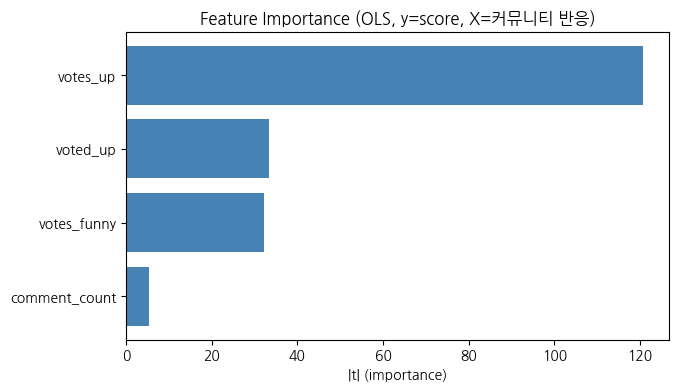

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# y = 점수, X = 커뮤니티 반응
y = df["weighted_vote_score"]
X = df[["votes_up","votes_funny","comment_count","voted_up"]]

X = sm.add_constant(X)
ols = sm.OLS(y, X).fit()

print(ols.summary())

# 중요도 = |t값|
fi = pd.DataFrame({
    "feature": ols.model.exog_names,
    "coef": ols.params,
    "t_abs": ols.tvalues.abs()
})
fi = fi[fi["feature"]!="const"].sort_values("t_abs", ascending=False)

print(fi)

# 시각화
plt.figure(figsize=(7,4))
plt.barh(fi["feature"], fi["t_abs"], color="steelblue")
plt.xlabel("|t| (importance)")
plt.title("Feature Importance (OLS, y=score, X=커뮤니티 반응)")
plt.gca().invert_yaxis()
plt.show()
